# Description

Соревнование 2. Подсчет квадратов на изображении  
Условия  
Описание задачи  
В вашем распоряжении есть набор изображений, которые состоят из нескольких видов геометрических фигур:  

- квадратов;  
- прямоугольников;  
- параллелограммов;  
- окружностей.  
Ваша задача – посчитать количество квадратов на каждом изображении из тестовых данных. Изображения для обучения можно скачать здесь.  

Описание данных  
Весь набор данных состоит из 3 типов изображений в равном количестве:  

Содержат только квадраты, которые могут иметь общие стороны, вкладываться друг в друга, но не пересекаться.  
Содержат квадраты и другие фигуры, все они могут иметь общие стороны, вкладываться друг в друга, но не пересекаться.  
Содержат квадраты и другие фигуры, которые дополнительно могут пересекаться.  
Ниже находятся 2 файла, которые потребуются для решения задачи: train.csv – содержит информацию об изображениях для обучения, test.csv – содержит информацию об изображениях для теста. Имеют поля:  

- img_path – путь до изображения  
- label – число квадратов на изображении (только в обучающем наборе)  
- type – тип изображения 1/2/3 (только в обучающем наборе)  
Пример сабмита можно посмотреть в файле sample_submission.csv. Он содержит одну колонку label, порядок соответсвует порядку данных в тестовом наборе.  

Метрика качества  
В качесте метрики качества используется метрика Root Mean Square Error (RMSE)  

ссылка на скачивание датасетов: https://drive.google.com/drive/folders/1obvLC3Gbu1XSOu75ThRaf7rBEYdWJnq4?usp=sharing

# General solution description

Для решения применил библиотеку openCV для распознавания квадратов. Описание решения с помощью ML смотри ниже.  

Так как фигуры на всех изображениях однотонны и в большинстве случаев имеют отличные друг от друга цвета, то можно поочередно убирать все цвета, оставляя только один. Данное изображение анализируется с помощью инструментов openCV и получаем есть ли на данном изображении квадрат и в каком количестве. После этого оставляем другой цвет, остальные "закрашиваем" и считаем квадраты. Так проходим по всем уникальным цветам на изображении и суммируем значения количества квадратов на каждом шаге.  

Инструменты openCV, по которым определялось квадрат ли на изображении:
 - определение контуров с помощью findContours
 - у контуров определелось - если 4 грани равные и косинус угла между ними = 0 (±0.1) то это квадрат
Однако этих условий не достаточно на случай, когда при "затирании" пересекующихся фигур, или фигур с единой гранью, часть грани квадрата тоже затирается. В таких случаях применялись дополнительные проверки:
 - проверка на равность сторон не по длине граней, а по крайним координатам
 - "утолщение" линий фигур с помощью dialate
 - сдвиг фигуры в центр
 - оценка не самой фигуры, а ее bounding bounds
 
У работы с контурами openCV есть недостаток, что метод возвращает не один объект на каждую фигуру, а сразу несколько похожих, как бы обводя фигуру несколько раз. Для исключения пришлось написать функцию убирающую лишние контуры после проверки, что контур на несколько пикселей совпадает с другими. Кроме этого метод возвращает и и контур всего изображения. Его тоже пришлось вычитать.

Кроме этого было замечено, что изображения  разных типов (1,2 или 3) могут чуть лучше предсказываться изменяя параметры обработки изображений. Например изображения типа 1 лучше определяются вообще без dialation, а изображения типа 3 лучше определяются с утолщением и сдвигом в центр. Для того, чтобы применять к каждому типу изображения свои параметры, была обучена классифицирующая сеть. При прогнозе этой сети что то или иное изображение относится к какму-то классу, выбирались соответствующие параметры. Так удалось снизить ошибку на 0.04.

В качестве результата удалось добиться показателя rmse на тестовом наборе 6000 штук 0.4127145906474998 на публичной части и 0.42504901678120216 на приватной части, что является достаточно хорошим показателем



PS: гипотеза по решению с помощью ML:   
при попытке обучить регрессионную нейронную сеть, подавая на вход изображения, получая на выходе прогноз количества квадратов, была получена очень высокая ошибка (в районе RMSE 1.5).  
Анализ тестовой и обучающей выборок показал, чтов обучающей выборке на каждой картинке не более 10 квадратов, а в тестовой количество квадратов значительно больше и доходит до 20. Таким образом при обучении на наборе с небольшим количестовм квардратов, модель крайне плохо предсказывает количество на картинках, где квадратов больше 10 - для нее это выброс.  
Поэтому есть гипотеза, что необходимо догенерировать обучающий набор с большим количеством квадратов (либо самостоятельно, либо объединяя картинки из текущего набора), обучить сеть на общем наборе, и тогда ошибка будет в пределах допустимого (прогнозно rmse 0.5-0.6). КРоме этого в модель вместе с картинками можно подавать и тип изображения: 1,2 или 3. 

# Import

In [9]:
from datetime import datetime

import pandas as pd
import numpy as np
import cv2 as cv
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
from itertools import combinations

import multiprocessing

# EDA

In [10]:
train = pd.read_csv('train.csv')
train

img_path  label  type
0        train_data/1.png      3     1
1        train_data/2.png      7     3
2        train_data/3.png      9     2
3        train_data/4.png      9     1
4        train_data/5.png     10     1
...                   ...    ...   ...
2995  train_data/2996.png     10     1
2996  train_data/2997.png      2     1
2997  train_data/2998.png      7     1
2998  train_data/2999.png      7     3
2999  train_data/3000.png      1     2

[3000 rows x 3 columns]

In [11]:
test = pd.read_csv('test.csv')
test

img_path
0        test_data/1.png
1        test_data/2.png
2        test_data/3.png
3        test_data/4.png
4        test_data/5.png
...                  ...
5995  test_data/5996.png
5996  test_data/5997.png
5997  test_data/5998.png
5998  test_data/5999.png
5999  test_data/6000.png

[6000 rows x 1 columns]

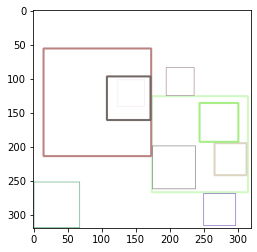

In [12]:
# откроем пример изображения
filename = '111.png' # Имя файла
image = Image.open('train_data/'+filename)
im_arr = np.array(image)
img1 = ImageDraw.Draw(image) 
plt.imshow(image) # Рисуем изображение

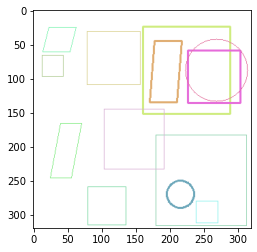

In [8]:
# откроем пример изображения
filename = '6.png' # Имя файла
image = Image.open('train_data/'+filename)
im_arr = np.array(image)
img1 = ImageDraw.Draw(image) 
plt.imshow(image) # Рисуем изображение

# Functions

Определим функции, с помощью которых будем обрабатывать изображения и подсчитывать квадраты

In [52]:
# определим основные параметры
bord = 3                   # количество пикселей в рамках сдвига, когда мы считаем два контура - контурами одной и той же фигуры
bord_square = 2            # количество пикселей, в рамках которым мы считаем отклонение от квадрата допустимым
big_bord = 3               # количество пикселей, представляющее сдвиг от внешних груниц изображение. В рамках этого количества будем считать определнный контур как ложноопределенный

out_bord_min = 10          #  минимальное приближение фигуры к границе, когда необходмио сделать сдвиг в центр
out_bord_max = 310         #  макскимальное приближение фигуры к границе, когда необходимо сделать сдвиг в центр

roll_to_center = 20        #  на сколько пикселей сдвигаем в центр

its = 1                    #  сколько итераций dialate нужно сделать
its_size = (2,2)           #  размер dialate

In [53]:
def preproccess_image(img):
    """
    Предобработка изображения перед подсчетом квадратов
    """
#     инвертируем изображение
    img = img - 255

#     сдвигаем изобржение ближе к центру, если оно находится на границе
    if img[img!=[0,0,0]].shape[0]>0:
        min_0 = np.where(img!=[0,0,0])[0].min()
        min_1 = np.where(img!=[0,0,0])[1].min()
        max_0 = np.where(img!=[0,0,0])[0].max()
        max_1 = np.where(img!=[0,0,0])[1].max()

        if min_0 < out_bord_min:
            img = np.roll(img, roll_to_center, axis=0)
        if min_1 < out_bord_min:
            img = np.roll(img, roll_to_center, axis=1)
        if max_0 > out_bord_max:
            img = np.roll(img, -1 * roll_to_center, axis=0)
        if max_1 > out_bord_max:
            img = np.roll(img, --1 * roll_to_center, axis=1)

#     делаем контуры толще        
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, its_size)
    img = cv.dilate(img, kernel, iterations=its)
    
    return img

In [15]:

pick_shape = im_arr.shape
def is_same(a, b, bord):
    """определяет является ли пара контуров контурами вокруг одной и той же фигуры"""
    a = a[a[:, 1].argsort()]
    b = b[b[:, 1].argsort()]
    
    return abs(np.sum(a[:,0]-b[:,0])) < bord and abs(np.sum(a[:,1]-b[:,1])) < bord
    
def is_square(arr):
    """определяет квадрат ли фигура по его крайним координатам"""
    size1 = abs(arr[:,0].max() - arr[:,0].min())
    size2 = abs(arr[:,1].max() - arr[:,1].min())
    
    if size1 > pick_shape[0] - big_bord and size2 > pick_shape[0] - big_bord:
        return False
    return abs(size1 - size2) < bord_square and ((abs(arr[0,0] - arr[3,0])<bord_square and  abs(arr[1,0] - arr[2,0])<bord_square) or
                                                (abs(arr[0,0] - arr[2,0])<bord_square and  abs(arr[1,0] - arr[3,0])<bord_square) or
                                                (abs(arr[0,0] - arr[1,0])<bord_square and  abs(arr[2,0] - arr[3,0])<bord_square))
        

    


In [16]:
def count_sq(row, bord=10):
    """
    подсчитывает количество квадратов на изображении.
    В цикле перебираются все уникальные цвета на изображении, в каждой итерации оставляется один цвет, остальные закрашиваются 
    под цвет фона.
    После того как получаются значения контуров квадратов, они попарно сравниваются, чтобы исключить когда несколько контуров "рисуются"
    вокруг одного и того же квадрата
    """
    print(row)
    filename = row
    img = cv.imread(filename, 1)

    res_cnt = 0
    
    im_arr = np.array(img)
    
    for color in np.unique(im_arr.reshape([320*320,3]), axis=0):

        mask = ((im_arr[:,:,0] == color[0]) &
                (im_arr[:,:,1] == color[1]) &
                (im_arr[:,:,2] == color[2]))
        im_to_show = im_arr.copy()
        im_to_show[~mask] = [255,255,255]

        im_to_show = preproccess_image(im_to_show)
        sq = np.array(find_squares(im_to_show))

        for i in range(sq.shape[0]):
            for j in range(i+1, sq.shape[0]):
                if is_same(sq[i], sq[j], bord):
                    sq[j] = sq[i]

        un = np.unique(sq, axis=0)
        un_cnt = un.shape[0]

        for last in un:
            if not is_square(last):
                un_cnt -= 1
        res_cnt +=   un_cnt   

    return res_cnt

In [17]:
def angle_cos(p0, p1, p2):
    """Определяет косинул угла между гранями контура по трем точкам"""
    d1, d2 = (p0-p1).astype('float'), (p2-p1).astype('float')
    return abs( np.dot(d1, d2) / np.sqrt( np.dot(d1, d1)*np.dot(d2, d2) ) )

def bb_to_cont(bb):
    """Трансформирует bounding border, который определн по двум крайним точкам в формат конутра, когда указываются координаты 4х точек"""
    bb_new = np.array([
        [bb[0], bb[1]],
        [bb[0], bb[1]+bb[3]-1],
        [bb[0]+bb[2]-1, bb[1]+bb[3]-1],
        [bb[0]+bb[2]-1, bb[1]]
    ])
    return bb_new

bord_inner = 1
def is_same_inner(a, b, bord):
    """Проверяет совпадает ли bounding border с найденным контуром"""
    for comb in combinations(a, 4):
        a_new = np.array(comb)
        if abs(np.sum(a_new[:,0]-b[:,0])) < bord and abs(np.sum(a_new[:,1]-b[:,1])) < bord:
            return True

    return False

def find_squares(img):
    """
    находит квадраты на изображении по контурам
    """
    img = cv.GaussianBlur(img, (5, 5), 0)
    squares = []
#     находим контуры
    for gray in cv.split(img):
        for thrs in range(0, 255, 26):
            if thrs == 0:
                bin = cv.Canny(gray, 0, 50, apertureSize=5)
                bin = cv.dilate(bin, None)
            else:
                _retval, bin = cv.threshold(gray, thrs, 255, cv.THRESH_BINARY)
            contours, _hierarchy = cv.findContours(bin, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)  
            for cnt in contours:
                flag = 0

                cnt_len = cv.arcLength(cnt, True)
                cnt2 = cv.approxPolyDP(cnt, 0.1*cnt_len, True)
#                 считаем количество граней контура и его площадь
                if cnt_len > 120:
                    
                    if len(cnt) == 4 and cv.contourArea(cnt2) > 100 and cv.isContourConvex(cnt2):
                        
                        cnt2 = cnt2.reshape(-1, 2)
#                         считаем косинусы углов между гранями контура. Если макимальный косинус около нуля то считаем фигуру квадратом
                        max_cos = np.max([angle_cos( cnt2[i], cnt2[(i+1) % 4], cnt2[(i+2) % 4] ) for i in range(4)])
                        if max_cos < 0.1:
                            squares.append(cnt2)
#                     отдельно обработаем контуры у которых больше 4х граней. Квдараты с общей гранью после затирания одного из них могли потерять часть грани
#                     в таком случае условие на 4 грани не будет соблюдаться
#                     Будем использовать не контур а bounding border вокруг фигуры.
#                     если bb квадратный и угулы совпадают с конутром фигуры, то считаем саму фигуру за квадрат
                    elif len(cnt) < 50 and len(cnt) >4 :
                        bb =  bb_to_cont(cv.boundingRect(cnt))
                        if cv.contourArea(bb) > 1000:
                            cnt_copy = cnt.reshape(-1, 2)
                            cos_list = [angle_cos( cnt_copy[i], cnt_copy[(i+1) % 4], cnt_copy[(i+2) % 4] ) for i in range(2)]
                            for cos_item in cos_list:
                                if cos_item < 0.1:
                                    if is_same_inner(cnt_copy, bb, bord_inner):
                                        squares.append(bb)
                                        flag = 1
                                        continue
                            if flag:
                                continue

    return squares

In [18]:
def rmse(df):
    """подсчет ошибки rmse по датасету"""
    rmse = (np.sum((df['label'] - df['pred']) ** 2) / df.shape[0]) ** (0.5)
    print('rmse - ', rmse)
    return rmse
    

In [19]:
def pred_to_csv(pred):
    """сохраняем датасет в cvs  в подходящий для контеста формат"""
    pred.rename(columns={'pred': 'label'}, inplace=True)
    pred = pred[['label']]

    pred.to_csv(f'./predictions/predict_{datetime.now()}.csv', index=False)

In [20]:
def stat(df, train=True):
    """Печатает статистику по датасету, включая разбивку по разным типам"""
    if train:
        print('rmse всего =')
        rmse(df)
    print(df.describe())
    
    if train:
        print(pd.concat((df.groupby('label')['label'].value_counts(), df.groupby('pred')['pred'].value_counts()),axis=1))
        for i in range(1,4):
            print('---------------')
            print('type = ', i)
            df_part = df[df.type==i]
            print(f'rmse {i} = ')
            rmse(df_part)
            print(df_part.describe())
            print(pd.concat((df_part.groupby('label')['label'].value_counts(), df_part.groupby('pred')['pred'].value_counts()),axis=1))
            

    else:
        print(df.groupby('label')['label'].value_counts())
    

# Prediction

сначала проверим подсчет квадратов на обучающем наборе

Подсчитаем на тестовом наборе

train_data/1.png


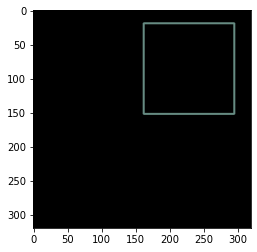

длина 259.65685415267944
длина 505.65685415267944
длина 259.65685415267944
длина 259.65685415267944
длина 259.65685415267944
длина 551.3137083053589
длина 513.6568541526794
длина 543.3137083053589
длина 519.3137083053589
длина 537.6568541526794
длина 524.9705619812012
длина 532.0
длина 259.65685415267944
длина 505.65685415267944
длина 259.65685415267944
длина 259.65685415267944
длина 259.65685415267944
длина 551.3137083053589
длина 513.6568541526794
длина 543.3137083053589
длина 519.3137083053589
длина 537.6568541526794
длина 521.6568541526794
длина 535.3137083053589
длина 524.9705619812012
длина 532.0
длина 259.65685415267944
длина 505.65685415267944
длина 259.65685415267944
длина 259.65685415267944
длина 259.65685415267944
длина 551.3137083053589
длина 513.6568541526794
длина 543.3137083053589
длина 519.3137083053589
длина 537.6568541526794
длина 521.6568541526794
длина 535.3137083053589
длина 527.3137083053589
длина 532.0
itogo 1


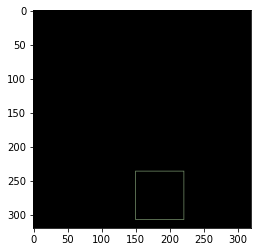

длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 257.65685415267944
длина 123.65685415267944
длина 303.3137083053589
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 287.3137083053589
itogo 2


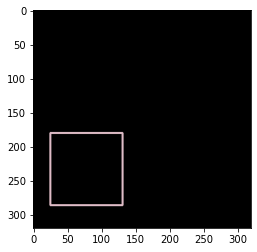

длина 205.65685415267944
длина 397.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 443.3137083053589
длина 403.3137083053589
длина 437.65685415267944
длина 405.65685415267944
длина 435.3137083053589
длина 408.9705619812012
длина 429.65685415267944
длина 411.3137083053589
длина 429.65685415267944
длина 413.65685415267944
длина 427.3137083053589
длина 416.97056245803833
длина 424.0
длина 419.3137083053589
длина 421.65685415267944
длина 205.65685415267944
длина 397.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 443.3137083053589
длина 405.65685415267944
длина 435.3137083053589
длина 405.65685415267944
длина 435.3137083053589
длина 411.3137083053589
длина 429.65685415267944
длина 413.65685415267944
длина 427.3137083053589
длина 416.97056245803833
длина 424.0
длина 419.3137083053589
длина 421.65685415267944
длина 205.65685415267944
длина 397.65685415267944
длина 205.65685415267944
длина 205.6568

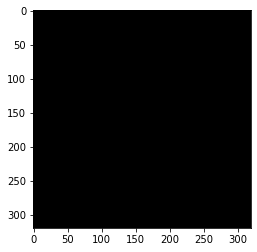

itogo 3
train_data/2.png


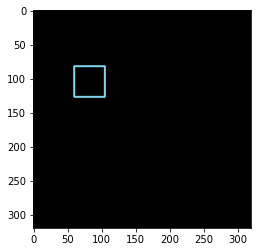

длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 175.3137083053589
длина 177.65685415267944
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 167.3137083053589
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 172.97056198120117
длина 180.0
длина 175.3137083053589
длина 177.65685415267944
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.6568

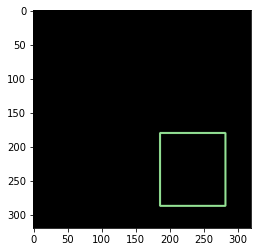

длина 185.65685415267944
длина 379.65685415267944
длина 207.65685415267944
длина 207.65685415267944
длина 185.65685415267944
длина 425.3137083053589
длина 387.65685415267944
длина 417.3137083053589
длина 390.9705619812012
длина 411.65685415267944
длина 395.65685415267944
длина 411.65685415267944
длина 398.97056245803833
длина 406.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 185.65685415267944
длина 379.65685415267944
длина 207.65685415267944
длина 207.65685415267944
длина 185.65685415267944
длина 425.3137083053589
длина 385.3137083053589
длина 419.65685415267944
длина 387.65685415267944
длина 417.3137083053589
длина 390.9705619812012
длина 411.65685415267944
длина 393.3137083053589
длина 411.65685415267944
длина 395.65685415267944
длина 409.3137083053589
длина 398.97056245803833
длина 406.0
длина 401.3137083053589
длина 406.0
длина 185.65685415267944
длина 379.65685415267944
длина 207.65685415267944
длина 207.65685415267944

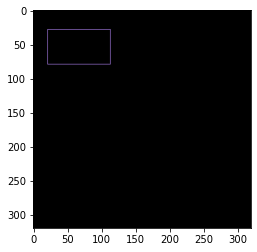

длина 262.97056245803833
длина 302.0
длина 275.65685415267944
длина 291.65685415267944
длина 281.3137083053589
длина 286.0
длина 261.3137083053589
длина 303.65685415267944
длина 275.65685415267944
длина 289.3137083053589
длина 261.3137083053589
длина 303.65685415267944
длина 275.65685415267944
длина 291.65685415267944
длина 278.9705619812012
длина 286.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


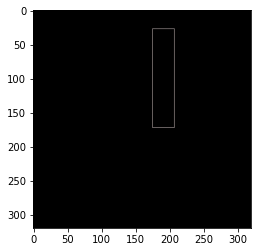

длина 330.97056245803833
длина 370.0
длина 343.65685415267944
длина 359.65685415267944
длина 349.3137083053589
длина 354.0
длина 45.65685415267944
длина 271.65685415267944
длина 271.65685415267944
длина 327.65685415267944
длина 45.65685415267944
длина 373.3137083053589
длина 343.65685415267944
длина 359.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 45.65685415267944
длина 271.65685415267944
длина 271.65685415267944
длина 327.65685415267944
длина 45.65685415267944
длина 373.3137083053589
длина 343.65685415267944
длина 359.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


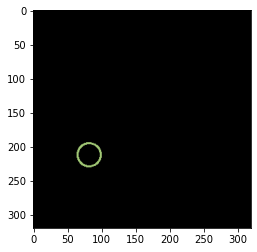

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 98.91168785095215
длина 126.22539567947388
длина 102.22539710998535
длина 122.9116872549057
длина 104.56854057312012
длина 120.56854128837585
длина 106.91168737411499
длина 118.22539567947388
длина 110.22539710998535
длина 114.9116872549057
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 96.56854057312012
длина 128.56854152679443
длина 98.91168880462646
длина 126.22539556026459
длина 104.56854152679443
длина 120.56854152679443
длина 104.56854057312012
длина 120.56854128837585
длина 106.91168785095215
длина 118.22539567947388
длина 110.22539710998535
длина 114.9116872549057
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 5.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443

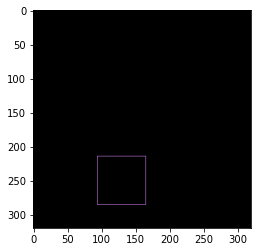

длина 260.97056245803833
длина 300.0
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
длина 260.97056245803833
длина 300.0
длина 276.9705619812012
длина 284.0
длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 276.9705619812012
длина 284.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


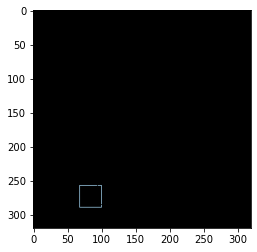

длина 45.65685415267944
длина 37.65685415267944
длина 45.65685415267944
длина 103.31370830535889
длина 33.65685415267944
длина 148.1421353816986
длина 119.31370830535889
длина 135.3137083053589
длина 58.82842707633972
длина 176.48528122901917
длина 45.65685415267944
длина 37.65685415267944
длина 45.65685415267944
длина 103.31370830535889
длина 33.65685415267944
длина 147.3137083053589
длина 115.89949476718903
длина 133.65685415267944
длина 63.899494767189026
длина 180.3847759962082
длина 54.82842707633972
длина 174.48528122901917
длина 45.65685415267944
длина 37.65685415267944
длина 45.65685415267944
длина 103.31370830535889
длина 33.65685415267944
длина 148.1421353816986
длина 115.31370830535889
длина 133.65685415267944
длина 119.31370830535889
длина 132.97056245803833
длина 58.82842707633972
длина 176.48528122901917
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 3


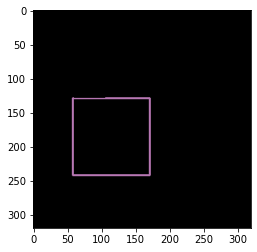

длина 219.65685415267944
длина 425.65685415267944
длина 219.65685415267944
длина 219.65685415267944
длина 125.65685415267944
длина 471.3137083053589
длина 433.65685415267944
длина 464.1421353816986
длина 433.65685415267944
длина 463.3137083053589
длина 439.3137083053589
длина 458.48528122901917
длина 441.65685415267944
длина 455.3137083053589
длина 805.5563485622406
длина 800.1421353816986
длина 219.65685415267944
длина 425.65685415267944
длина 219.65685415267944
длина 219.65685415267944
длина 125.65685415267944
длина 471.3137083053589
длина 433.65685415267944
длина 463.3137083053589
длина 439.3137083053589
длина 458.48528122901917
длина 808.3847759962082
длина 10.242640614509583
длина 10.242640614509583
длина 5.414213538169861
длина 10.242640614509583
длина 219.65685415267944
длина 425.65685415267944
длина 219.65685415267944
длина 219.65685415267944
длина 125.65685415267944
длина 471.3137083053589
длина 433.65685415267944
длина 464.1421353816986
длина 433.65685415267944
длина 463.3137

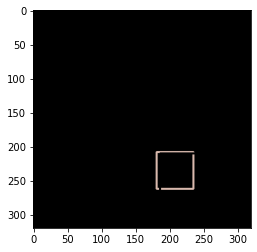

длина 87.65685415267944
длина 93.65685415267944
длина 192.48528122901917
длина 101.65685415267944
длина 236.1421353816986
длина 201.89949476718903
длина 228.97056245803833
длина 199.55634891986847
длина 226.97056245803833
длина 196.24264061450958
длина 221.89949476718903
длина 193.89949476718903
длина 221.3137083053589
длина 193.89949476718903
длина 218.72792184352875
длина 188.2426404953003
длина 117.07106757164001
длина 184.24264061450958
длина 113.0710676908493
длина 87.65685415267944
длина 93.65685415267944
длина 192.48528122901917
длина 101.65685415267944
длина 236.1421353816986
длина 201.89949476718903
длина 228.1421353816986
длина 197.89949476718903
длина 226.1421353816986
длина 196.24264061450958
длина 221.89949476718903
длина 193.89949476718903
длина 218.72792184352875
длина 188.24264061450958
длина 117.0710676908493
длина 184.24264061450958
длина 113.0710676908493
длина 87.65685415267944
длина 93.65685415267944
длина 192.48528122901917
длина 101.65685415267944
длина 236.14213

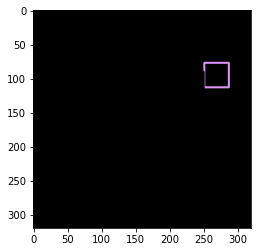

длина 63.65685415267944
длина 117.0710676908493
длина 65.65685415267944
длина 17.656854152679443
длина 65.65685415267944
длина 162.72792184352875
длина 123.31370830535889
длина 156.48528122901917
длина 125.65685415267944
длина 154.1421353816986
длина 129.5563485622406
длина 149.0710676908493
длина 235.55634891986847
длина 232.97056245803833
длина 230.14213502407074
длина 226.72792184352875
длина 63.65685415267944
длина 117.0710676908493
длина 65.65685415267944
длина 17.656854152679443
длина 65.65685415267944
длина 162.72792184352875
длина 125.65685415267944
длина 154.72792184352875
длина 129.5563485622406
длина 149.0710676908493
длина 235.55634891986847
длина 230.1421353816986
длина 222.72792184352875
длина 63.65685415267944
длина 27.656854152679443
длина 117.0710676908493
длина 65.65685415267944
длина 17.656854152679443
длина 65.65685415267944
длина 162.72792184352875
длина 123.31370830535889
длина 156.48528122901917
длина 125.65685415267944
длина 154.72792184352875
длина 129.55634856

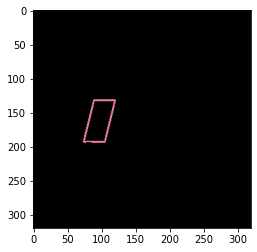

длина 35.65685415267944
длина 168.42640614509583
длина 57.65685415267944
длина 214.08326029777527
длина 175.25483322143555
длина 210.911687374115
длина 176.42640614509583
длина 206.911687374115
длина 180.9116871356964
длина 202.911687374115
длина 183.25483322143555
длина 202.911687374115
длина 184.42640614509583
длина 198.911687374115
длина 372.16652059555054
длина 39.41421353816986
длина 4.0
длина 14.242640614509583
длина 103.11269783973694
длина 103.11269783973694
длина 4.0
длина 71.65685415267944
длина 2.0
длина 3.414213538169861
длина 35.65685415267944
длина 168.42640614509583
длина 57.65685415267944
длина 214.08326029777527
длина 176.42640614509583
длина 208.56854152679443
длина 182.08326029777527
длина 202.911687374115
длина 376.99494767189026
длина 34.0
длина 3.414213538169861
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина

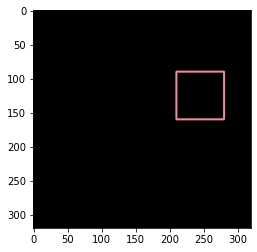

длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 259.3137083053589
длина 293.65685415267944
длина 261.65685415267944
длина 291.3137083053589
длина 264.9705619812012
длина 288.0
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 272.9705619812012
длина 280.0
длина 275.3137083053589
длина 277.65685415267944
длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.65685415267944
длина 291.3137083053589
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 272.9705619812012
длина 280.0
длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
дли

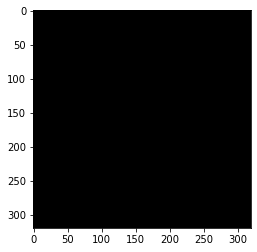

itogo 7
train_data/3.png


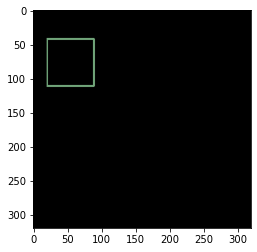

длина 131.65685415267944
длина 249.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 293.3137083053589
длина 257.65685415267944
длина 285.3137083053589
длина 263.3137083053589
длина 280.8284270763397
длина 412.1421353816986
длина 131.65685415267944
длина 249.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 293.3137083053589
длина 257.65685415267944
длина 286.48528122901917
длина 257.65685415267944
длина 285.3137083053589
длина 263.3137083053589
длина 280.8284270763397
длина 265.65685415267944
длина 278.48528122901917
длина 409.3137080669403
длина 131.65685415267944
длина 249.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 293.3137083053589
длина 257.65685415267944
длина 286.48528122901917
длина 263.3137083053589
длина 280.8284270763397
длина 418.97056245803833
длина 406.48528122901917
itogo 1


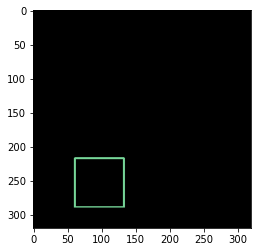

длина 261.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 305.3137083053589
длина 269.65685415267944
длина 297.3137083053589
длина 275.3137083053589
длина 292.8284270763397
длина 431.79898953437805
длина 2.0
длина 2.0
длина 10.242640614509583
длина 10.242640614509583
длина 261.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 305.3137083053589
длина 269.65685415267944
длина 298.48528122901917
длина 269.65685415267944
длина 297.3137083053589
длина 275.3137083053589
длина 292.8284270763397
длина 275.3137083053589
длина 291.65685415267944
длина 277.65685415267944
длина 290.48528122901917
длина 427.3137080669403
длина 424.48528122901917
длина 261.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 305.3137083053589
длина 269.65685415267944
длина 298.48528122901917
длина 272.9705619812012
длина 292.8284270763397
длина 275.3137083053589
длина 291.656854152

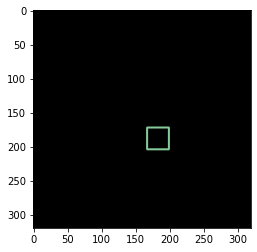

длина 57.65685415267944
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 147.3137083053589
длина 109.65685415267944
длина 139.3137083053589
длина 115.31370830535889
длина 133.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 123.31370830535889
длина 128.0
длина 57.65685415267944
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 147.3137083053589
длина 109.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 139.3137083053589
длина 115.31370830535889
длина 133.65685415267944
длина 115.31370830535889
длина 133.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 120.97056198120117
длина 128.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 57.65685415267944
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 147.3137083053

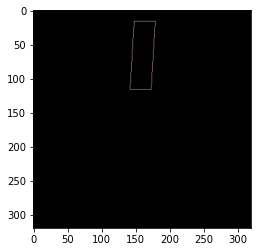

длина 241.4558436870575
длина 283.79898953437805
длина 256.6274166107178
длина 272.6274166107178
длина 87.65685415267944
длина 28.0
длина 28.0
длина 26.0
длина 26.0
длина 28.0
длина 28.0
длина 28.0
длина 28.0
длина 26.0
длина 26.0
длина 87.65685415267944
длина 241.4558436870575
длина 283.79898953437805
длина 256.6274166107178
длина 270.2842707633972
длина 43.65685415267944
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 240.62741661071777
длина 47.65685415267944
длина 286.2842707633972
длина 256.6274166107178
длина 270.2842707633972
itogo 3


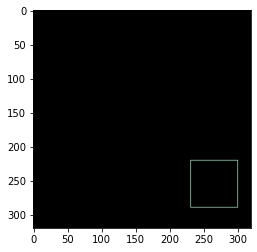

длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 249.65685415267944
длина 119.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 281.65685415267944
длина 271.3137083053589
длина 276.0
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 249.65685415267944
длина 119.65685415267944
длина 295.3137083053589
длина 263.3137083053589
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
длина 252.97056245803833
длина 292.0
длина 265.65685415267944
длина 281.65685415267944
длина 268.9705619812012
длина 276.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 4


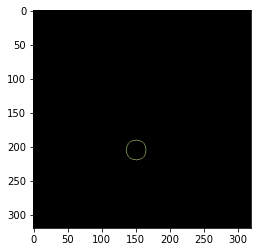

длина 77.25483322143555
длина 117.25483322143555
длина 89.94112491607666
длина 101.25483322143555
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 77.25483322143555
длина 117.25483322143555
длина 89.94112491607666
длина 101.25483322143555
длина 95.59797859191895
длина 98.91168785095215
длина 77.25483322143555
длина 117.25483322143555
длина 95.5979790687561
длина 98.91168785095215
itogo 4


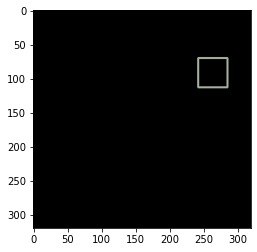

длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 156.97056198120117
длина 180.0
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 164.97056198120117
длина 172.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65

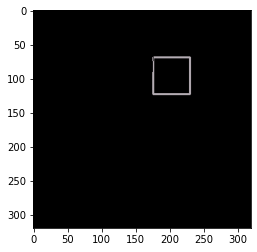

длина 101.65685415267944
длина 59.65685415267944
длина 189.0710676908493
длина 101.65685415267944
длина 7.656854152679443
длина 101.65685415267944
длина 235.55634891986847
длина 197.65685415267944
длина 228.1421353816986
длина 198.48528122901917
длина 226.72792184352875
длина 203.3137083053589
длина 221.89949476718903
длина 414.97056245803833
длина 378.7279214859009
длина 372.72792184352875
длина 101.65685415267944
длина 59.65685415267944
длина 189.0710676908493
длина 101.65685415267944
длина 7.656854152679443
длина 101.65685415267944
длина 235.55634891986847
длина 197.65685415267944
длина 228.1421353816986
длина 199.0710676908493
длина 226.72792184352875
длина 204.14213526248932
длина 221.0710676908493
длина 413.55634891986847
длина 378.7279214859009
длина 101.65685415267944
длина 59.65685415267944
длина 189.0710676908493
длина 101.65685415267944
длина 7.656854152679443
длина 99.65685415267944
длина 235.55634891986847
длина 197.65685415267944
длина 228.1421353816986
длина 199.07106769

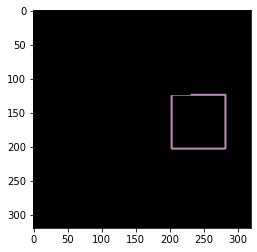

длина 151.65685415267944
длина 289.0710676908493
длина 149.65685415267944
длина 151.65685415267944
длина 35.65685415267944
длина 95.65685415267944
длина 334.72792184352875
длина 297.65685415267944
длина 326.72792184352875
длина 298.48528122901917
длина 326.97056245803833
длина 574.9705624580383
длина 571.5563489198685
длина 566.1421353816986
длина 560.7279218435287
длина 151.65685415267944
длина 289.0710676908493
длина 149.65685415267944
длина 151.65685415267944
длина 95.65685415267944
длина 334.72792184352875
длина 297.65685415267944
длина 326.72792184352875
длина 303.3137083053589
длина 321.0710676908493
длина 571.5563489198685
длина 564.7279214859009
длина 151.65685415267944
длина 289.0710676908493
длина 149.65685415267944
длина 151.65685415267944
длина 35.65685415267944
длина 95.65685415267944
длина 334.72792184352875
длина 297.65685415267944
длина 326.72792184352875
длина 298.48528122901917
длина 326.97056245803833
длина 574.9705624580383
длина 570.9705624580383
длина 566.14213502

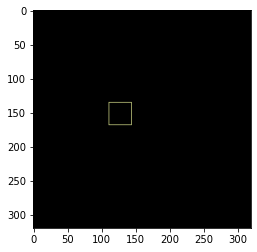

длина 47.65685415267944
длина 47.65685415267944
длина 47.65685415267944
длина 105.65685415267944
длина 47.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 107.31370830535889
длина 149.65685415267944
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 107.31370830535889
длина 149.65685415267944
длина 121.65685415267944
длина 137.65685415267944
длина 127.31370830535889
длина 132.0
itogo 8


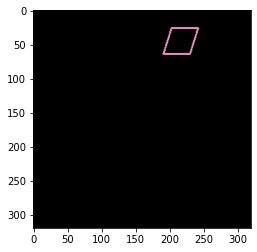

длина 73.65685415267944
длина 7.656854152679443
длина 135.94112491607666
длина 7.656854152679443
длина 73.65685415267944
длина 181.5979790687561
длина 139.94112491607666
длина 177.5979790687561
длина 143.94112491607666
длина 173.5979790687561
длина 146.76955199241638
длина 169.5979790687561
длина 149.5979790687561
длина 169.5979790687561
длина 151.94112491607666
длина 165.59797883033752
длина 151.94112491607666
длина 165.5979790687561
длина 106.14213538169861
длина 31.313708305358887
длина 31.313708305358887
длина 106.14213538169861
длина 5.414213538169861
длина 5.414213538169861
длина 73.65685415267944
длина 7.656854152679443
длина 135.94112491607666
длина 7.656854152679443
длина 73.65685415267944
длина 181.5979790687561
длина 143.94112491607666
длина 175.25483322143555
длина 147.94112491607666
длина 169.5979790687561
длина 151.94112491607666
длина 169.5979790687561
длина 153.59797883033752
длина 163.94112491607666
длина 6.828427076339722
длина 6.828427076339722
длина 73.6568541526794

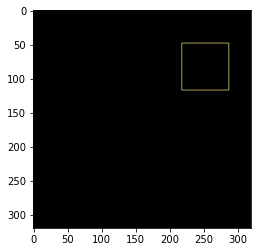

длина 252.97056245803833
длина 292.0
длина 263.3137083053589
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 251.3137083053589
длина 293.65685415267944
длина 263.3137083053589
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
длина 252.97056245803833
длина 292.0
длина 265.65685415267944
длина 279.3137083053589
itogo 9


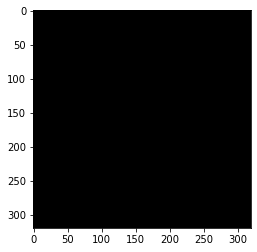

itogo 9
train_data/4.png


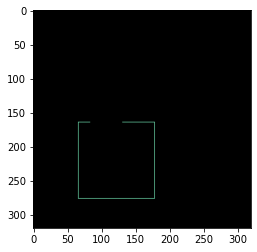

длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 79.65685415267944
длина 19.656854152679443
длина 810.6274166107178
длина 799.597978591919
длина 809.798989534378
длина 799.3137083053589
длина 794.6274166107178
длина 787.3137083053589
длина 809.798989534378
длина 799.3137083053589
длина 791.3137083053589
itogo 1


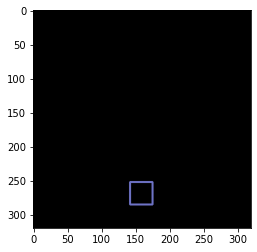

длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 124.97056198120117
длина 132.0
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132

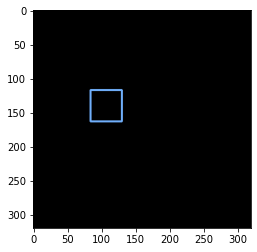

длина 85.65685415267944
длина 157.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 203.3137083053589
длина 165.65685415267944
длина 195.3137083053589
длина 171.3137083053589
длина 189.65685415267944
длина 176.97056245803833
длина 184.0
длина 85.65685415267944
длина 157.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 203.3137083053589
длина 165.65685415267944
длина 195.3137083053589
длина 165.65685415267944
длина 195.3137083053589
длина 171.3137083053589
длина 189.65685415267944
длина 173.65685415267944
длина 187.3137083053589
длина 176.97056198120117
длина 184.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 85.65685415267944
длина 157.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 203.3137083053589
длина 163.3137083053589
длина 197.65685415267944
длина 165.65685415267944
длина 195.3137083053589

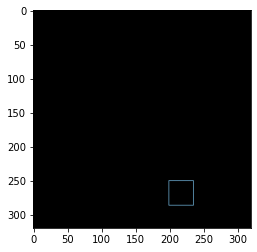

длина 120.97056245803833
длина 160.0
длина 133.65685415267944
длина 147.3137083053589
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 149.65685415267944
длина 136.97056198120117
длина 144.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 119.31370830535889
длина 161.65685415267944
длина 131.3137083053589
длина 149.65685415267944
длина 133.65685415267944
длина 147.3137083053589
длина 139.3137083053589
длина 144.0
itogo 4


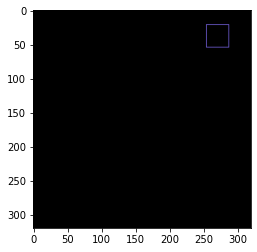

длина 107.31370830535889
длина 149.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 47.65685415267944
длина 47.65685415267944
длина 51.65685415267944
длина 105.65685415267944
длина 51.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 135.3137083053589
длина 107.31370830535889
длина 149.65685415267944
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
itogo 5


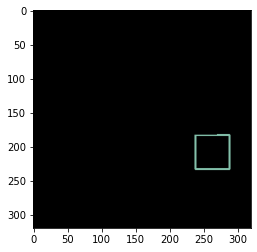

длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 31.656854152679443
длина 218.72792184352875
длина 181.65685415267944
длина 211.3137083053589
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 331.899494767189
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 31.656854152679443
длина 218.72792184352875
длина 181.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 210.72792184352875
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 205.0710676908493
длина 334.3847759962082
длина 329.899494767189
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 31.656854152679443
длина 218.72792184352875
длина 181.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 210.72792184352875
длина 187.3137083053589
длина 205.656854152679

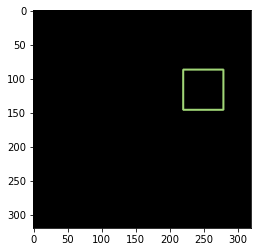

длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 220.97056198120117
длина 244.0
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 223.3137083053589
длина 241.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 228.97056198120117
длина 236.0
длина 231.3137083053589
длина 233.65685415267944
длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
дл

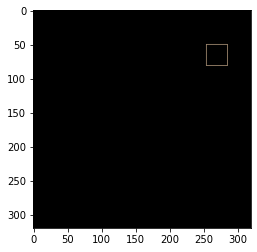

длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 116.97056198120117
длина 124.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 129.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 8


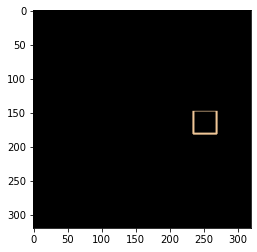

длина 61.65685415267944
длина 59.65685415267944
длина 108.48528122901917
длина 59.65685415267944
длина 153.3137083053589
длина 115.31370830535889
длина 145.65685415267944
длина 117.65685415267944
длина 143.3137083053589
длина 122.14213514328003
длина 140.0
длина 203.3137083053589
длина 200.48528122901917
длина 195.3137083053589
длина 192.4852809906006
длина 188.48528122901917
длина 61.65685415267944
длина 59.65685415267944
длина 108.48528122901917
длина 59.65685415267944
длина 153.3137083053589
длина 117.65685415267944
длина 144.48528122901917
длина 118.48528122901917
длина 144.1421353816986
длина 203.3137083053589
длина 200.48528122901917
длина 195.3137083053589
длина 193.65685415267944
длина 61.65685415267944
длина 59.65685415267944
длина 108.48528122901917
длина 59.65685415267944
длина 152.48528122901917
длина 117.65685415267944
длина 144.48528122901917
длина 122.14213514328003
длина 138.82842707633972
длина 199.3137083053589
длина 195.3137083053589
длина 188.48528122901917
itogo 9


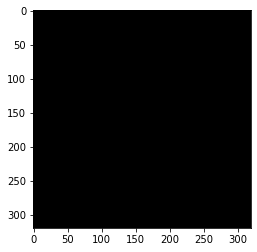

itogo 9
train_data/5.png


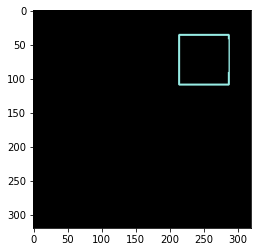

длина 139.65685415267944
длина 31.656854152679443
длина 266.48528122901917
длина 7.656854152679443
длина 139.65685415267944
длина 139.65685415267944
длина 311.3137083053589
длина 274.48528122901917
длина 303.3137083053589
длина 277.7989890575409
длина 297.65685415267944
длина 280.1421353816986
длина 297.65685415267944
длина 484.6274166107178
длина 474.97056245803833
длина 139.65685415267944
длина 31.656854152679443
длина 266.48528122901917
длина 7.656854152679443
длина 139.65685415267944
длина 139.65685415267944
длина 311.3137083053589
длина 272.1421353816986
длина 305.65685415267944
длина 274.48528122901917
длина 303.3137083053589
длина 277.7989890575409
длина 297.65685415267944
длина 280.1421353816986
длина 297.65685415267944
длина 282.48528122901917
длина 295.3137083053589
длина 484.6274166107178
длина 478.9705619812012
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 139.65685415267944
длина 31.656854152679443
длина 266.48528

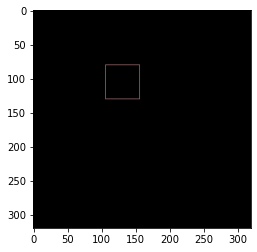

длина 175.3137083053589
длина 217.65685415267944
длина 189.65685415267944
длина 205.65685415267944
длина 195.3137083053589
длина 200.0
длина 175.3137083053589
длина 217.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 175.3137083053589
длина 217.65685415267944
длина 189.65685415267944
длина 203.3137083053589
itogo 2


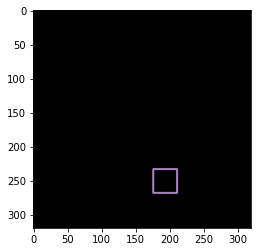

длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 124.97056198120117
длина 148.0
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65

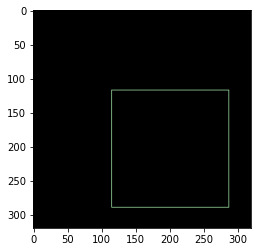

длина 325.65685415267944
длина 325.65685415267944
длина 325.65685415267944
длина 661.6568541526794
длина 325.65685415267944
длина 707.3137083053589
длина 677.6568541526794
длина 693.6568541526794
длина 683.3137083053589
длина 688.0
длина 664.9705624580383
длина 704.0
длина 675.3137083053589
длина 693.6568541526794
длина 677.6568541526794
длина 691.3137083053589
длина 683.3137083053589
длина 688.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 663.3137083053589
длина 705.6568541526794
длина 677.6568541526794
длина 693.6568541526794
длина 683.3137083053589
длина 688.0
itogo 4


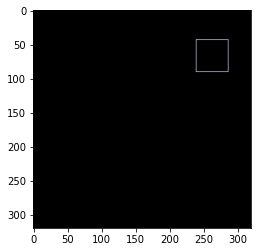

длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 193.65685415267944
длина 183.3137083053589
длина 188.0
длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 193.65685415267944
длина 180.97056198120117
длина 194.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 163.3137083053589
длина 205.65685415267944
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
itogo 5


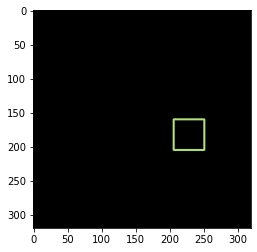

длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 172.97056198120117
длина 180.0
длина 175.3137083053589
длина 177.65685415267944
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.65685415267944
длина 161.65685415267944
длина 191.3137083053589
длина 164.97056198120117
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 172.97056245803833
длина 180.0
длина 175.3137083053589
длина 180.0
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.656

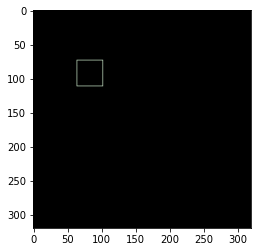

длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 125.65685415267944
длина 57.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 157.65685415267944
длина 144.97056198120117
длина 152.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 125.65685415267944
длина 57.65685415267944
длина 171.3137083053589
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 147.3137083053589
длина 152.0
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 125.65685415267944
длина 57.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 157.65685415267944
длина 144.97056198120117
длина 152.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 7


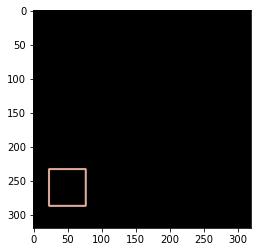

длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 195.3137083053589
длина 229.65685415267944
длина 197.65685415267944
длина 227.3137083053589
длина 200.97056198120117
длина 221.65685415267944
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 208.97056245803833
длина 216.0
длина 211.3137083053589
длина 216.0
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 208.97056198120117
длина 216.0
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
д

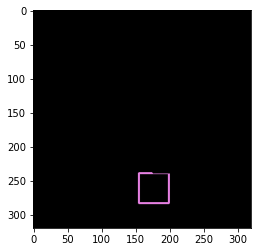

длина 81.65685415267944
длина 79.65685415267944
длина 149.0710676908493
длина 81.65685415267944
длина 33.65685415267944
длина 194.72792184352875
длина 155.3137083053589
длина 188.48528122901917
длина 157.65685415267944
длина 186.1421353816986
длина 161.5563485622406
длина 181.0710676908493
длина 302.97056245803833
длина 299.55634891986847
длина 294.97056245803833
длина 292.48528122901917
длина 81.65685415267944
длина 79.65685415267944
длина 149.0710676908493
длина 81.65685415267944
длина 33.65685415267944
длина 194.72792184352875
длина 157.65685415267944
длина 186.72792184352875
длина 302.97056245803833
длина 296.97056245803833
длина 292.48528122901917
длина 81.65685415267944
длина 79.65685415267944
длина 149.0710676908493
длина 81.65685415267944
длина 33.65685415267944
длина 194.72792184352875
длина 155.3137083053589
длина 188.48528122901917
длина 157.65685415267944
длина 186.1421353816986
длина 161.5563485622406
длина 181.0710676908493
длина 301.55634891986847
длина 298.9705624580383

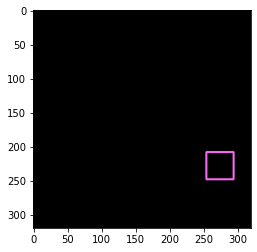

длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 179.3137083053589
длина 139.3137083053589
длина 173.65685415267944
длина 141.65685415267944
длина 171.3137083053589
длина 144.97056198120117
длина 168.0
длина 147.3137083053589
длина 165.65685415267944
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 152.97056198120117
длина 160.0
длина 155.3137083053589
длина 157.65685415267944
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 179.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 147.3137083053589
длина 165.65685415267944
длина 152.97056198120117
длина 160.0
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 179.3137083053589
длина 139.3137083053589
длина 173.65685415267944
длина 141.656

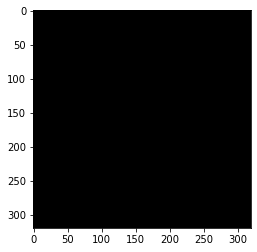

itogo 10
train_data/6.png


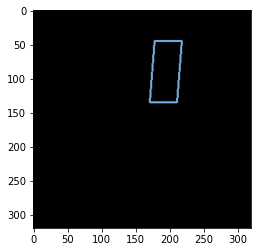

длина 73.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 239.4558436870575
длина 7.656854152679443
длина 7.656854152679443
длина 73.65685415267944
длина 285.11269783973694
длина 247.4558436870575
длина 277.11269783973694
длина 253.11269783973694
длина 271.4558436870575
длина 258.7695519924164
длина 265.79898953437805
длина 73.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.6568

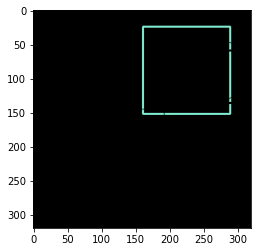

длина 187.65685415267944
длина 55.65685415267944
длина 5.656854152679443
длина 21.656854152679443
длина 127.65685415267944
длина 11.656854152679443
длина 485.65685415267944
длина 39.65685415267944
длина 235.65685415267944
длина 249.65685415267944
длина 531.3137083053589
длина 157.3137083053589
длина 869.5979790687561
длина 150.0
длина 858.9705624580383
длина 71.89949476718903
длина 219.0710676908493
длина 8.828427076339722
длина 134.82842707633972
длина 18.82842707633972
длина 538.1421353816986
длина 66.24264061450958
длина 214.24264061450958
длина 4.0
длина 128.0
длина 12.0
длина 532.4852812290192
длина 187.65685415267944
длина 53.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 127.65685415267944
длина 11.656854152679443
длина 485.65685415267944
длина 39.65685415267944
длина 233.65685415267944
длина 249.65685415267944
длина 531.3137083053589
длина 155.65685415267944
длина 864.6274166107178
длина 154.97056245803833
длина 867.2548332214355
д

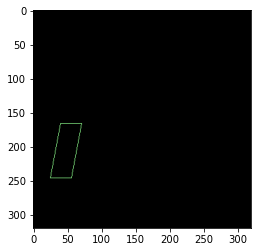

длина 209.49747383594513
длина 249.25483322143555
длина 224.08326029777527
длина 237.7401144504547
длина 2.8284270763397217
длина 3.414213538169861
длина 3.414213538169861
длина 2.8284270763397217
длина 208.6690467596054
длина 250.08326029777527
длина 221.25483322143555
длина 240.08326029777527
длина 224.08326029777527
длина 237.7401144504547
длина 228.0832600593567
длина 234.42640614509583
длина 208.6690467596054
длина 251.25483322143555
длина 224.08326029777527
длина 237.7401144504547
длина 2.8284270763397217
длина 3.414213538169861
длина 3.414213538169861
длина 2.8284270763397217
itogo 1


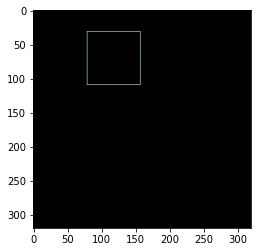

длина 287.3137083053589
длина 329.65685415267944
длина 301.65685415267944
длина 317.65685415267944
длина 307.3137083053589
длина 312.0
длина 287.3137083053589
длина 329.65685415267944
длина 301.65685415267944
длина 317.65685415267944
длина 304.9705619812012
длина 318.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 285.65685415267944
длина 137.65685415267944
длина 331.3137083053589
длина 301.65685415267944
длина 317.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 307.3137083053589
длина 312.0
itogo 2


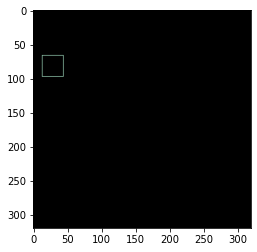

длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 116.97056198120117
длина 124.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
itogo 3


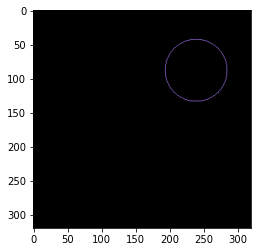

длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 283.0782079696655
длина 5.656854152679443
длина 5.656854152679443
длина 320.73506355285645
длина 293.4213562011719
длина 307.0782079696655
длина 14.0
длина 14.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 14.0
длина 14.0
длина 283.0782079696655
длина 320.73506355285645
длина 299.0782079696655
длина 304.7350616455078
длина 283.0782079696655
длина 320.73506355285645
длина 293.42135524749756
длина 310.3919162750244
длина 299.0782079696655
длина 307.0782079696655
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длин

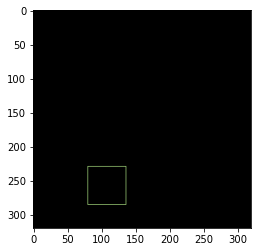

длина 200.97056245803833
длина 240.0
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 197.65685415267944
длина 93.65685415267944
длина 243.3137083053589
длина 213.65685415267944
длина 229.65685415267944
длина 213.65685415267944
длина 227.3137083053589
длина 219.3137083053589
длина 224.0
длина 199.3137083053589
длина 241.65685415267944
длина 213.65685415267944
длина 227.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 4


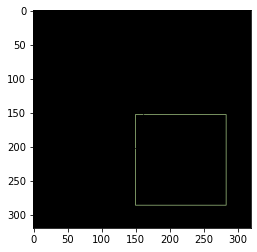

длина 508.97056245803833
длина 552.9705624580383
длина 521.6568541526794
длина 537.6568541526794
длина 928.4852812290192
длина 114.82842707633972
длина 507.3137083053589
длина 552.9705624580383
длина 521.6568541526794
длина 537.6568541526794
длина 935.6984839439392
длина 119.89949464797974
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 247.65685415267944
длина 149.65685415267944
длина 247.65685415267944
длина 83.65685415267944
длина 508.97056245803833
длина 225.65685415267944
длина 7.656854152679443
длина 554.6274166107178
длина 523.3137083053589
длина 539.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


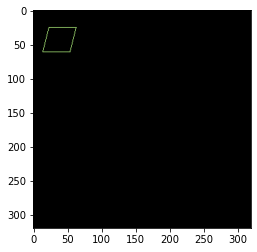

длина 132.28427076339722
длина 175.69848430156708
длина 146.28427076339722
длина 165.11269783973694
длина 151.94112467765808
длина 159.4558436870575
длина 0.0
длина 133.11269783973694
длина 174.87005722522736
длина 146.28427076339722
длина 165.11269783973694
длина 148.28427076339722
длина 161.94112491607666
длина 153.11269772052765
длина 159.4558436870575
длина 0.0
длина 0.0
длина 2.0
длина 132.28427076339722
длина 175.69848430156708
длина 148.28427076339722
длина 161.94112491607666
длина 2.8284270763397217
длина 3.414213538169861
длина 2.0
длина 0.0
itogo 5


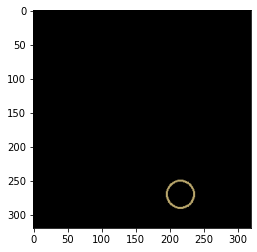

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 117.63960886001587
длина 147.88224935531616
длина 119.98275518417358
длина 145.5391035079956
длина 123.88224983215332
длина 139.88224983215332
длина 125.63960862159729
длина 139.88224983215332
длина 129.53910446166992
длина 134.22539567947388
длина 0.0
длина 77.94112467765808
длина 49.455843806266785
длина 0.0
длина 0.0
длина 21.55634891986847
длина 0.0
длина 49.455843806266785
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 118.22539567947388
длина 145.53910398483276
длина 119.98275518417358
длина 145.5391035079956
длина 123.882248878479
длина 139.88224959373474
длина 125.63960886001587
длина 139.88224935531616
длина 131.29646348953247
длина 134.22539567947388
длина 13.656854152679443
длина 13.656854152679443
длина 13.6568541

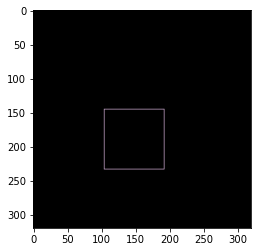

длина 328.97056245803833
длина 368.0
длина 341.65685415267944
длина 357.65685415267944
длина 341.65685415267944
длина 355.3137083053589
длина 347.3137083053589
длина 352.0
длина 327.3137083053589
длина 369.65685415267944
длина 341.65685415267944
длина 357.65685415267944
длина 347.3137083053589
длина 352.0
длина 157.65685415267944
длина 157.65685415267944
длина 157.65685415267944
длина 325.65685415267944
длина 157.65685415267944
длина 371.3137083053589
длина 341.65685415267944
длина 357.65685415267944
длина 341.65685415267944
длина 355.3137083053589
длина 347.3137083053589
длина 352.0
itogo 6


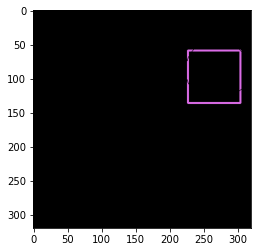

длина 147.65685415267944
длина 29.656854152679443
длина 5.656854152679443
длина 49.65685415267944
длина 49.65685415267944
длина 105.65685415267944
длина 283.3137083053589
длина 11.656854152679443
длина 129.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 328.3847759962082
длина 287.3137083053589
длина 322.72792184352875
длина 292.97056245803833
длина 322.04163014888763
длина 295.3137083053589
длина 314.72792184352875
длина 296.97056245803833
длина 314.72792184352875
длина 62.82842707633972
длина 537.3553384542465
длина 238.4852809906006
длина 52.0
длина 245.07106757164001
длина 24.242640495300293
длина 234.48528122901917
длина 48.0
длина 104.0
длина 128.0
длина 20.242640614509583
длина 147.65685415267944
длина 29.656854152679443
длина 5.656854152679443
длина 49.65685415267944
длина 49.65685415267944
длина 105.65685415267944
длина 283.3137083053589
длина 11.656854152679443
длина 129.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 328.384775996208

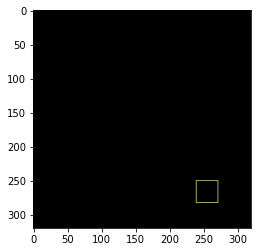

длина 45.65685415267944
длина 45.65685415267944
длина 45.65685415267944
длина 101.65685415267944
длина 45.65685415267944
длина 147.3137083053589
длина 115.31370830535889
длина 133.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 123.31370830535889
длина 128.0
длина 103.31370830535889
длина 145.65685415267944
длина 115.31370830535889
длина 133.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 123.31370830535889
длина 128.0
длина 103.31370830535889
длина 145.65685415267944
длина 117.65685415267944
длина 133.65685415267944
длина 123.31370830535889
длина 128.0
itogo 8


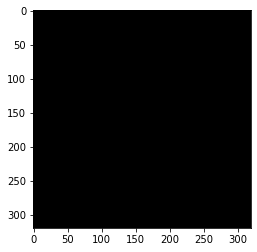

itogo 8
train_data/7.png


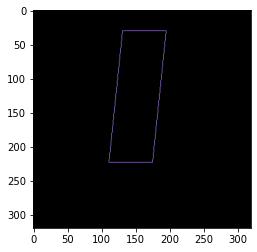

длина 505.0538227558136
длина 547.3969686031342
длина 520.2253956794739
длина 536.2253956794739
длина 137.65685415267944
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 137.65685415267944
длина 505.0538227558136
длина 547.3969686031342
длина 520.2253956794739
длина 533.8822498321533
длина 505.0538227558136
длина 547.3969686031342
длина 520.2253956794739
длина 536.2253956794739
длина 521.8822495937347
длина 535.5391039848328
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 0


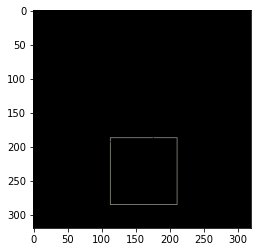

длина 367.3137083053589
длина 410.48528122901917
длина 383.3137083053589
длина 399.3137083053589
длина 634.4852812290192
длина 128.82842707633972
длина 177.65685415267944
длина 165.65685415267944
длина 177.65685415267944
длина 368.1421353816986
длина 51.65685415267944
длина 107.65685415267944
длина 413.79898953437805
длина 381.65685415267944
длина 397.65685415267944
длина 634.4852812290192
длина 128.82842707633972
длина 177.65685415267944
длина 165.65685415267944
длина 177.65685415267944
длина 367.3137083053589
длина 51.65685415267944
длина 107.65685415267944
длина 412.1421353816986
длина 383.3137083053589
длина 399.3137083053589
длина 634.4852812290192
длина 128.82842707633972
itogo 1


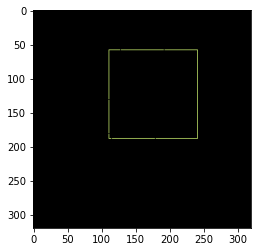

длина 496.97056245803833
длина 536.0
длина 509.65685415267944
длина 525.6568541526794
длина 125.65685415267944
длина 17.899494767189026
длина 97.65685415267944
длина 476.1421353816986
длина 125.65685415267944
длина 175.89949476718903
длина 116.0
длина 10.828427076339722
длина 88.0
длина 467.65685415267944
длина 116.0
длина 166.82842707633972
длина 105.65685415267944
длина 109.65685415267944
длина 81.65685415267944
длина 241.65685415267944
длина 127.65685415267944
длина 502.7695519924164
длина 79.65685415267944
длина 109.65685415267944
длина 15.656854152679443
длина 546.7695519924164
длина 507.3137083053589
длина 525.6568541526794
длина 514.6274166107178
длина 528.2842707633972
длина 120.0
длина 12.828427076339722
длина 92.0
длина 471.65685415267944
длина 120.0
длина 170.82842707633972
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 496.97056245803833
длина 536.0
длина 514.6274166107178
длина 528.2842707633972
itogo 2


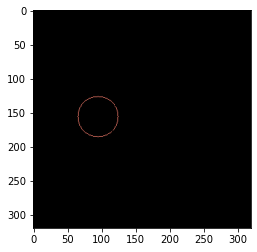

длина 176.166522026062
длина 216.16652011871338
длина 188.8528118133545
длина 203.48023056983948
длина 78.28427076339722
длина 303.1787132024765
длина 23.656854152679443
длина 23.656854152679443
длина 23.656854152679443
длина 23.656854152679443
длина 23.656854152679443
длина 23.656854152679443
длина 23.656854152679443
длина 23.656854152679443
длина 176.166522026062
длина 216.16652011871338
длина 78.28427076339722
длина 303.1787132024765
длина 176.166522026062
длина 216.16652011871338
длина 74.28427076339722
длина 299.0782083272934
itogo 2


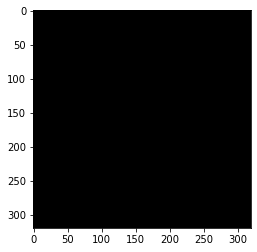

itogo 2
train_data/8.png


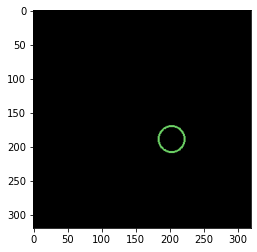

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длина 147.88224947452545
длина 112.56854128837585
длина 137.53910541534424
длина 118.22539567947388
длина 134.2253954410553
длина 123.88224959373474
длина 128.5685418844223
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длина 147.88224947452545
длина 111.39696907997131
длина 139.88224983215332
длина 112.56854128837585
длина 137.53910541534424
длина 118.22539591789246
длина 133.63960933685303
длина 118.22539567947388
длина 134.2253954410553
длина 119.39696907997131
длина 131.88224983215332
длина 125.05382251739502
длина 126.22539567947388
длина 12.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 12.0
длина 12.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 12.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длин

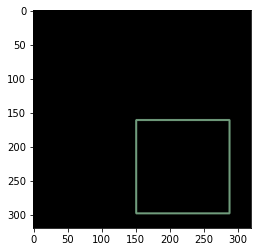

длина 267.65685415267944
длина 521.6568541526794
длина 267.65685415267944
длина 267.65685415267944
длина 267.65685415267944
длина 567.3137083053589
длина 529.6568541526794
длина 559.3137083053589
длина 535.3137083053589
длина 553.6568541526794
длина 540.9705624580383
длина 548.0
длина 267.65685415267944
длина 521.6568541526794
длина 267.65685415267944
длина 267.65685415267944
длина 267.65685415267944
длина 567.3137083053589
длина 529.6568541526794
длина 559.3137083053589
длина 532.9705619812012
длина 553.6568541526794
длина 535.3137083053589
длина 553.6568541526794
длина 537.6568541526794
длина 551.3137083053589
длина 543.3137083053589
длина 545.6568541526794
длина 267.65685415267944
длина 521.6568541526794
длина 267.65685415267944
длина 267.65685415267944
длина 267.65685415267944
длина 567.3137083053589
длина 529.6568541526794
длина 559.3137083053589
длина 535.3137083053589
длина 553.6568541526794
длина 537.6568541526794
длина 551.3137083053589
длина 543.3137083053589
длина 545.656854

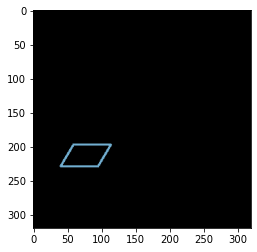

длина 105.65685415267944
длина 9.071067690849304
длина 5.656854152679443
длина 5.656854152679443
длина 156.0832600593567
длина 9.071067690849304
длина 105.65685415267944
длина 208.56854152679443
длина 166.9116871356964
длина 200.56854152679443
длина 170.911687374115
длина 196.56854152679443
длина 176.56854128837585
длина 190.911687374115
длина 8.828427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 8.828427076339722
длина 105.65685415267944
длина 9.071067690849304
длина 5.656854152679443
длина 5.656854152679443
длина 156.0832600593567
длина 9.071067690849304
длина 105.65685415267944
длина 208.56854152679443
длина 164.08326029777527
длина 202.22539567947388
длина 168.08326029777527
длина 199.39696860313416
длина 170.911687374115
длина 196.56854152679443
длина 174.911687374115
длина 192.56854152679443
длина 176.568541765213
длина 189.7401144504547
длина 0.0
длина 2.8284270763397217
длина 10.242640614509583
длина 7.656854152679443
длина 7.65

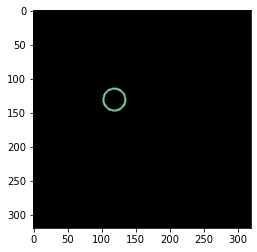

длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 93.25483298301697
длина 118.22539710998535
длина 98.91168737411499
длина 112.56854057312012
длина 101.25483298301697
длина 110.22539710998535
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 0.0
длина 2.0
длина 0.0
длина 2.0
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 90.91168785095215
длина 120.56854152679443
длина 93.25483322143555
длина 118.22539615631104
длина 98.9116872549057
длина 112.56854152679443
длина 98.91168737411499
длина 112.56854057312012
длина 101.25483298301697
длина 110.22539710998535
длина 104.56854152679443
длина 106.91168785095215
д

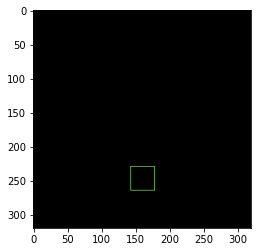

длина 116.97056245803833
длина 156.0
длина 129.65685415267944
длина 143.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 116.97056245803833
длина 156.0
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
длина 51.65685415267944
длина 51.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 55.65685415267944
длина 159.3137083053589
длина 129.65685415267944
длина 143.3137083053589
itogo 2


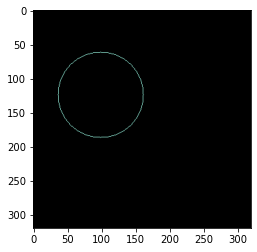

длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 395.64674854278564
длина 9.656854152679443
длина 9.656854152679443
длина 435.64674854278564
длина 411.64674854278564
длина 419.64674854278564
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 395.64674854278564
длина 9.656854152679443
длина 9.656854152679443
длина 435.64674854278564
длина 405.989896774292
длина 422.96045684814453
длина 413.9898943901062
длина 417.30360317230225
длина 16.0
длина 16.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 16.0
длина 16.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 9.656854152679443
длина 9.656854152

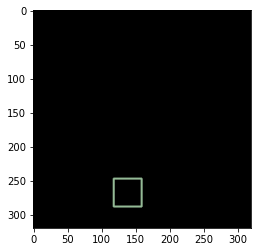

длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 148.97056198120117
длина 169.65685415267944
длина 153.65685415267944
длина 169.65685415267944
длина 156.97056245803833
длина 164.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 156.97056245803833
длина 164.0
длина 159.3137083053589
длина 161.65685415267944
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.31370830535

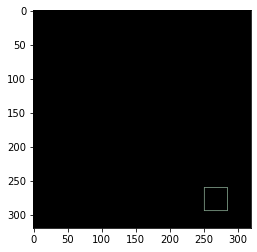

длина 49.65685415267944
длина 49.65685415267944
длина 49.65685415267944
длина 109.65685415267944
длина 49.65685415267944
длина 155.3137083053589
длина 125.65685415267944
длина 141.65685415267944
длина 131.3137083053589
длина 136.0
длина 111.31370830535889
длина 153.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 128.97056198120117
длина 136.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 111.31370830535889
длина 153.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 131.3137083053589
длина 136.0
itogo 4


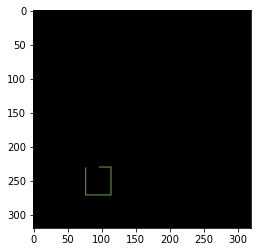

длина 280.72792184352875
длина 270.48528122901917
длина 262.48528122901917
длина 55.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 17.656854152679443
длина 282.3847759962082
длина 270.3847759962082
длина 266.3847759962082
длина 262.48528122901917
длина 280.72792184352875
длина 266.3847759962082
itogo 4


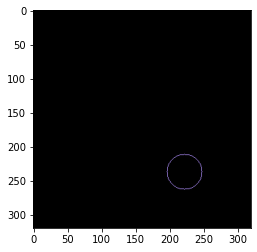

длина 148.85281467437744
длина 188.8528118133545
длина 161.53910446166992
длина 172.85281372070312
длина 51.31370830535889
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 51.31370830535889
длина 51.31370830535889
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 51.31370830535889
длина 148.85281467437744
длина 188.8528118133545
длина 164.8528127670288
длина 172.85281372070312
длина 148.85281467437744
длина 188.8528118133545
длина 161.5391035079956
длина 176.16652297973633
длина 164.85281372070312
длина 172.8528127670288
длина 47.31370830535889
длина 47.31370830535889
длина 47.31370830535889
длина 47.31370830535889
itogo 4


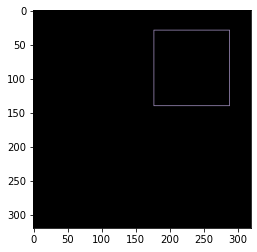

длина 419.3137083053589
длина 461.65685415267944
длина 433.65685415267944
длина 449.65685415267944
длина 439.3137083053589
длина 444.0
длина 203.65685415267944
длина 203.65685415267944
длина 203.65685415267944
длина 417.65685415267944
длина 203.65685415267944
длина 463.3137083053589
длина 433.65685415267944
длина 449.65685415267944
длина 439.3137083053589
длина 444.0
длина 419.3137083053589
длина 461.65685415267944
длина 433.65685415267944
длина 449.65685415267944
длина 433.65685415267944
длина 447.3137083053589
длина 439.3137083053589
длина 444.0
itogo 5


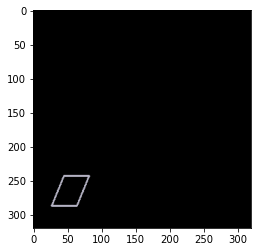

длина 69.65685415267944
длина 5.656854152679443
длина 146.08326029777527
длина 5.656854152679443
длина 69.65685415267944
длина 194.56854152679443
длина 154.08326029777527
длина 188.22539567947388
длина 158.08326029777527
длина 186.56854152679443
длина 160.9116871356964
длина 182.56854152679443
длина 164.911687374115
длина 178.56854128837585
длина 92.14213538169861
длина 6.828427076339722
длина 6.828427076339722
длина 6.828427076339722
длина 6.828427076339722
длина 23.313708305358887
длина 23.313708305358887
длина 6.828427076339722
длина 6.828427076339722
длина 6.828427076339722
длина 6.828427076339722
длина 92.14213538169861
длина 72.82842707633972
длина 72.82842707633972
длина 69.65685415267944
длина 5.656854152679443
длина 146.08326029777527
длина 5.656854152679443
длина 69.65685415267944
длина 194.56854152679443
длина 154.08326029777527
длина 188.22539567947388
длина 158.08326029777527
длина 186.56854152679443
длина 160.9116871356964
длина 182.56854152679443
длина 164.911687374115
д

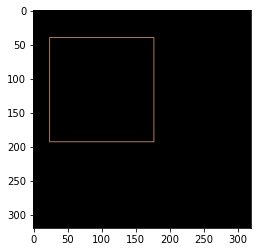

длина 287.65685415267944
длина 287.65685415267944
длина 287.65685415267944
длина 585.6568541526794
длина 287.65685415267944
длина 631.3137083053589
длина 599.3137083053589
длина 617.6568541526794
длина 601.6568541526794
длина 615.3137083053589
длина 607.3137083053589
длина 612.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 287.65685415267944
длина 287.65685415267944
длина 287.65685415267944
длина 585.6568541526794
длина 287.65685415267944
длина 631.3137083053589
длина 601.6568541526794
длина 617.6568541526794
длина 607.3137083053589
длина 612.0
длина 587.3137083053589
длина 629.6568541526794
длина 601.6568541526794
длина 617.6568541526794
длина 607.3137083053589
длина 612.0
itogo 6


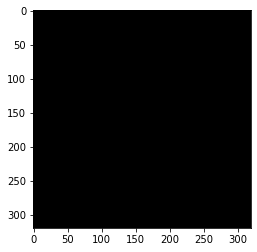

itogo 6
train_data/9.png


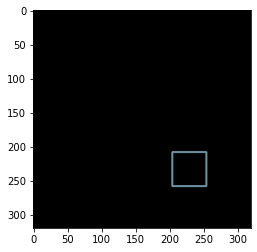

длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 187.3137083053589
длина 205.65685415267944
длина 192.97056198120117
длина 200.0
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 205.65685415267944
длина 192.97056198120117
длина 200.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 184.97056198120117
длина 208.0
длина 187.3137083053589
длина 205.65685415267944
длина 189.

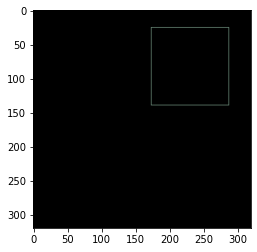

длина 431.3137083053589
длина 473.65685415267944
длина 445.65685415267944
длина 459.3137083053589
длина 432.97056245803833
длина 472.0
длина 445.65685415267944
длина 461.65685415267944
длина 451.3137083053589
длина 456.0
длина 431.3137083053589
длина 473.65685415267944
длина 445.65685415267944
длина 459.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


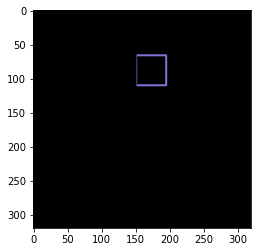

длина 79.65685415267944
длина 148.48528122901917
длина 81.65685415267944
длина 79.65685415267944
длина 193.3137083053589
длина 157.65685415267944
длина 184.48528122901917
длина 263.3137083053589
длина 258.1421353816986
длина 253.65685415267944
длина 79.65685415267944
длина 148.48528122901917
длина 81.65685415267944
длина 79.65685415267944
длина 193.3137083053589
длина 157.65685415267944
длина 183.3137083053589
длина 263.3137083053589
длина 255.3137083053589
длина 79.65685415267944
длина 148.48528122901917
длина 81.65685415267944
длина 79.65685415267944
длина 193.3137083053589
длина 157.65685415267944
длина 184.48528122901917
длина 157.65685415267944
длина 183.3137083053589
длина 163.3137083053589
длина 178.82842707633972
длина 259.3137083053589
длина 258.1421353816986
длина 252.4852809906006
длина 248.48528122901917
itogo 3


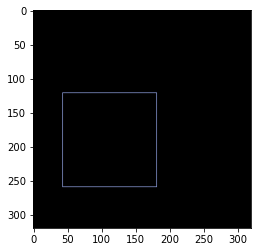

длина 528.9705624580383
длина 568.0
длина 541.6568541526794
длина 557.6568541526794
длина 547.3137083053589
длина 552.0
длина 528.9705624580383
длина 568.0
длина 541.6568541526794
длина 557.6568541526794
длина 547.3137083053589
длина 552.0
длина 527.3137083053589
длина 569.6568541526794
длина 539.3137083053589
длина 557.6568541526794
длина 541.6568541526794
длина 555.3137083053589
длина 547.3137083053589
длина 552.0
itogo 4


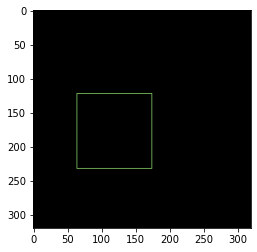

длина 416.97056245803833
длина 456.0
длина 429.65685415267944
длина 445.65685415267944
длина 435.3137083053589
длина 440.0
длина 201.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 413.65685415267944
длина 201.65685415267944
длина 459.3137083053589
длина 427.3137083053589
длина 445.65685415267944
длина 429.65685415267944
длина 443.3137083053589
длина 435.3137083053589
длина 440.0
длина 415.3137083053589
длина 457.65685415267944
длина 429.65685415267944
длина 443.3137083053589
itogo 5


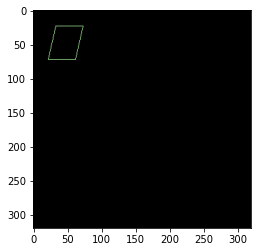

длина 159.94112491607666
длина 202.76955199241638
длина 173.94112491607666
длина 192.76955199241638
длина 180.7695517539978
длина 187.11269783973694
длина 159.94112491607666
длина 203.94112491607666
длина 173.94112491607666
длина 192.76955199241638
длина 176.76955199241638
длина 190.42640614509583
длина 85.65685415267944
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 85.65685415267944
длина 159.94112491607666
длина 203.94112491607666
длина 176.76955199241638
длина 192.76955199241638
длина 82.82842707633972
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 82.82842707633972
itogo 5


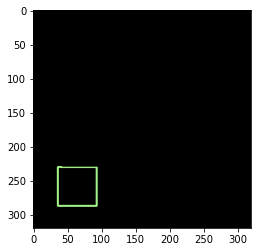

длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 7.656854152679443
длина 246.72792184352875
длина 209.65685415267944
длина 239.3137083053589
длина 212.97056198120117
длина 235.41421353816986
длина 215.3137083053589
длина 233.0710676908493
длина 357.79898953437805
длина 349.899494767189
длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 7.656854152679443
длина 246.72792184352875
длина 207.3137083053589
длина 241.0710676908493
длина 209.65685415267944
длина 238.72792184352875
длина 212.97056198120117
длина 235.41421353816986
длина 215.3137083053589
длина 233.65685415267944
длина 217.65685415267944
длина 233.0710676908493
длина 356.3847759962082
длина 348.14213502407074
длина 344.72792184352875
длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 7.656854152679443
длина 246.72792184352875
длина 209.65685415267944
длина 239.313

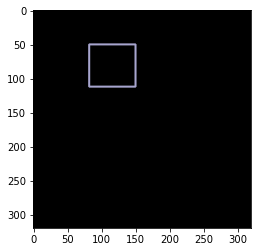

длина 129.65685415267944
длина 233.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 129.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 268.0
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 252.97056198120117
длина 260.0
длина 129.65685415267944
длина 233.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 129.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 268.0
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 255.3137083053589
длина 260.0
длина 129.65685415267944
длина 233.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 129.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 247.3137

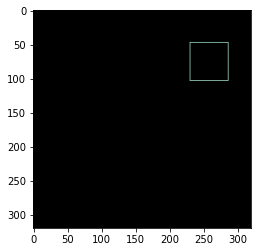

длина 199.3137083053589
длина 241.65685415267944
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
длина 199.3137083053589
длина 241.65685415267944
длина 211.3137083053589
длина 229.65685415267944
длина 213.65685415267944
длина 227.3137083053589
длина 219.3137083053589
длина 224.0
длина 200.97056245803833
длина 240.0
длина 211.3137083053589
длина 229.65685415267944
длина 213.65685415267944
длина 227.3137083053589
длина 219.3137083053589
длина 224.0
itogo 7


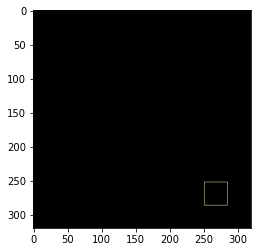

длина 111.31370830535889
длина 153.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 128.97056198120117
длина 136.0
длина 112.97056245803833
длина 152.0
длина 125.65685415267944
длина 141.65685415267944
длина 131.3137083053589
длина 136.0
длина 111.31370830535889
длина 153.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 8


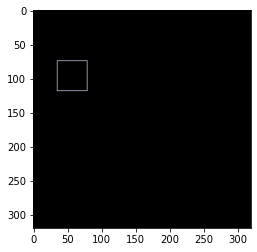

длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 149.65685415267944
длина 69.65685415267944
длина 195.3137083053589
длина 165.65685415267944
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 171.3137083053589
длина 176.0
длина 151.3137083053589
длина 193.65685415267944
длина 165.65685415267944
длина 181.65685415267944
длина 168.97056198120117
длина 176.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 152.97056245803833
длина 192.0
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 171.3137083053589
длина 176.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 9


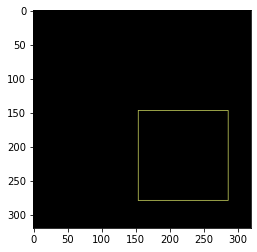

длина 503.3137083053589
длина 545.6568541526794
длина 515.3137083053589
длина 533.6568541526794
длина 517.6568541526794
длина 531.3137083053589
длина 523.3137083053589
длина 528.0
длина 245.65685415267944
длина 245.65685415267944
длина 245.65685415267944
длина 501.65685415267944
длина 245.65685415267944
длина 547.3137083053589
длина 515.3137083053589
длина 533.6568541526794
длина 517.6568541526794
длина 531.3137083053589
длина 523.3137083053589
длина 528.0
длина 245.65685415267944
длина 245.65685415267944
длина 249.65685415267944
длина 501.65685415267944
длина 249.65685415267944
длина 547.3137083053589
длина 520.9705619812012
длина 528.0
itogo 10


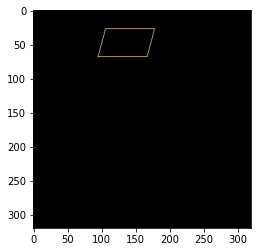

длина 207.94112491607666
длина 250.76955199241638
длина 221.94112491607666
длина 240.76955199241638
длина 223.11269783973694
длина 236.76955199241638
длина 228.76955199241638
длина 235.11269783973694
длина 2.0
длина 2.0
длина 208.76955199241638
длина 249.94112491607666
длина 221.94112491607666
длина 240.76955199241638
длина 224.76955199241638
длина 236.76955199241638
длина 2.0
длина 152.24264061450958
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 152.24264061450958
длина 207.94112491607666
длина 250.76955199241638
длина 223.11269783973694
длина 240.76955199241638
длина 147.0710676908493
длина 147.0710676908493
itogo 10


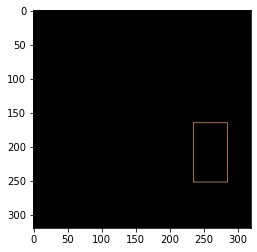

длина 249.3137083053589
длина 291.65685415267944
длина 261.3137083053589
длина 279.65685415267944
длина 263.65685415267944
длина 277.3137083053589
длина 269.3137083053589
длина 274.0
длина 250.97056245803833
длина 290.0
длина 263.65685415267944
длина 279.65685415267944
длина 269.3137083053589
длина 274.0
длина 81.65685415267944
длина 155.65685415267944
длина 159.65685415267944
длина 247.65685415267944
длина 85.65685415267944
длина 293.3137083053589
длина 266.9705619812012
длина 274.0
itogo 10


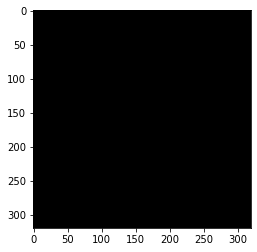

itogo 10
train_data/10.png


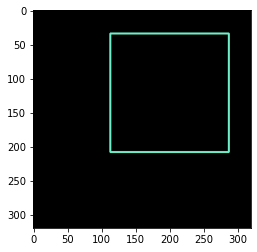

длина 341.65685415267944
длина 669.6568541526794
длина 341.65685415267944
длина 341.65685415267944
длина 341.65685415267944
длина 715.3137083053589
длина 677.6568541526794
длина 707.3137083053589
длина 683.3137083053589
длина 701.6568541526794
длина 688.9705619812012
длина 696.0
длина 341.65685415267944
длина 669.6568541526794
длина 341.65685415267944
длина 341.65685415267944
длина 341.65685415267944
длина 715.3137083053589
длина 675.3137083053589
длина 709.6568541526794
длина 677.6568541526794
длина 707.3137083053589
длина 680.9705619812012
длина 704.0
длина 683.3137083053589
длина 701.6568541526794
длина 685.6568541526794
длина 701.6568541526794
длина 685.6568541526794
длина 699.3137083053589
длина 688.9705619812012
длина 696.0
длина 691.3137083053589
длина 693.6568541526794
длина 341.65685415267944
длина 669.6568541526794
длина 341.65685415267944
длина 341.65685415267944
длина 341.65685415267944
длина 715.3137083053589
длина 677.6568541526794
длина 707.3137083053589
длина 677.656854

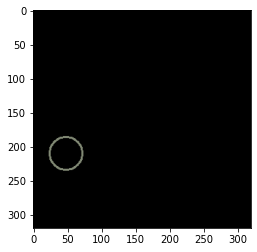

длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 137.5391025543213
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 180.8528118133545
длина 145.53910446166992
длина 172.8528116941452
длина 151.1959581375122
длина 167.19595742225647
длина 151.1959581375122
длина 165.43859958648682
длина 156.85281372070312
длина 160.95331704616547
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 137.5391025543213
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 180.8528118133545
длина 145.53910446166992
длина 172.8528116941452
длина 151.1959581375122
длина 167.19595742225647
длина 151.1959571838379
д

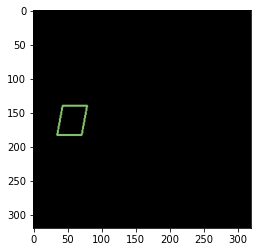

длина 65.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 135.4558436870575
длина 13.656854152679443
длина 65.65685415267944
длина 182.28427076339722
длина 144.62741661071777
длина 175.94112491607666
длина 149.11269760131836
длина 170.28427076339722
длина 151.4558436870575
длина 167.94112491607666
длина 97.89949464797974
длина 53.31370830535889
длина 53.31370830535889
длина 97.89949464797974
длина 65.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5

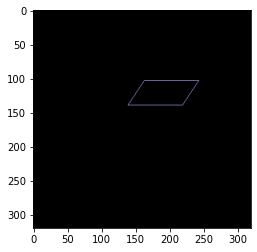

длина 220.2253954410553
длина 265.8822498321533
длина 237.05382251739502
длина 255.88224983215332
длина 158.82842707633972
длина 158.82842707633972
длина 220.22539567947388
длина 265.8822498321533
длина 239.88224959373474
длина 254.71067690849304
длина 155.41421353816986
длина 155.41421353816986
длина 220.22539567947388
длина 265.8822498321533
длина 237.0538227558136
длина 257.5391037464142
длина 241.0538227558136
длина 253.53910374641418
длина 158.82842707633972
длина 158.82842707633972
длина 0.0
длина 0.0
itogo 1


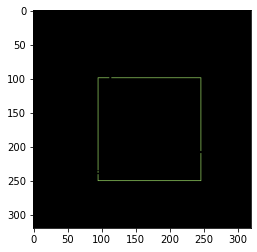

длина 581.798989534378
длина 624.9705624580383
длина 401.65685415267944
длина 478.8284270763397
длина 314.48528122901917
длина 393.65685415267944
длина 470.8284270763397
длина 296.8284270763397
длина 283.65685415267944
длина 63.65685415267944
длина 197.65685415267944
длина 253.65685415267944
длина 580.1421353816986
длина 245.65685415267944
длина 15.656854152679443
длина 625.798989534378
длина 478.2426406145096
длина 716.3847759962082
длина 4.0
длина 398.1421353816986
длина 475.899494767189
длина 301.899494767189
длина 389.65685415267944
длина 466.8284270763397
длина 292.8284270763397
длина 580.9705624580383
длина 620.0
длина 4.0
длина 396.4852809906006
длина 474.2426404953003
длина 300.2426404953003
itogo 2


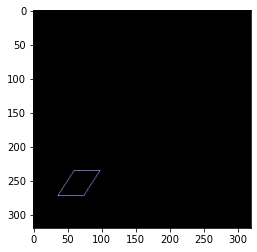

длина 139.0538227558136
длина 183.0538227558136
длина 155.05382251739502
длина 173.88224983215332
длина 83.0710676908493
длина 2.0
длина 2.0
длина 6.828427076339722
длина 6.828427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 6.828427076339722
длина 6.828427076339722
длина 2.0
длина 2.0
длина 83.0710676908493
длина 0.0
длина 0.0
длина 59.65685415267944
длина 137.39696860313416
длина 59.65685415267944
длина 184.71067690849304
длина 155.05382251739502
длина 173.88224983215332
длина 74.82842707633972
длина 74.82842707633972
длина 138.22539567947388
длина 183.88224983215332
длина 155.0538227558136
длина 175.53910374641418
длина 159.0538227558136
длина 172.71067690849304
длина 81.65685415267944
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 81.65685415267944
длина 3.414213538169861
длина 3.414213538169861
itogo 2


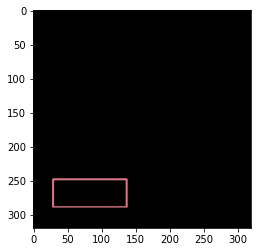

длина 271.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 209.65685415267944
длина 315.3137083053589
длина 277.3137083053589
длина 309.65685415267944
длина 279.65685415267944
длина 307.3137083053589
длина 285.3137083053589
длина 302.8284270763397
длина 285.3137083053589
длина 301.65685415267944
длина 287.65685415267944
длина 300.48528122901917
длина 378.14213514328003
длина 375.3137083053589
длина 271.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 209.65685415267944
длина 315.3137083053589
длина 279.65685415267944
длина 307.3137083053589
длина 285.3137083053589
длина 302.8284270763397
длина 379.79898953437805
длина 2.0
длина 2.0
длина 10.242640614509583
длина 10.242640614509583
длина 271.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 209.65685415267944
длина 315.3137083053589
длина 279.65685415267944
длина 308.48528122901917
длина 285.3137083053589
длина 302.8284270763397
длина 287.65685415267944
длина 300.48528122901917


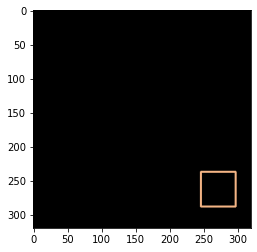

длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 183.3137083053589
длина 217.65685415267944
длина 185.65685415267944
длина 215.3137083053589
длина 188.97056198120117
длина 212.0
длина 191.3137083053589
длина 209.65685415267944
длина 193.65685415267944
длина 209.65685415267944
длина 193.65685415267944
длина 207.3137083053589
длина 196.97056198120117
длина 204.0
длина 199.3137083053589
длина 201.65685415267944
длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 191.3137083053589
длина 209.65685415267944
длина 193.65685415267944
длина 207.3137083053589
длина 196.97056198120117
длина 204.0
длина 199.3137083053589
длина 201.65685415267944
длина 95.65685415267944
длина 177.65685415267944
длина 95.6

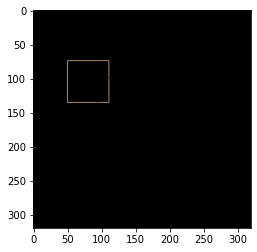

длина 220.97056245803833
длина 260.0
длина 231.3137083053589
длина 249.65685415267944
длина 235.3137083053589
длина 248.97056245803833
длина 94.82842707633972
длина 372.48528122901917
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 222.62741661071777
длина 261.65685415267944
длина 233.65685415267944
длина 249.65685415267944
длина 98.2426404953003
длина 374.7279214859009
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 13.656854152679443
длина 71.65685415267944
длина 53.65685415267944
длина 31.656854152679443
длина 103.65685415267944
длина 220.97056245803833
длина 103.65685415267944
длина 266.6274166107178
длина 235.3137083053589
длина 251.3137083053589
длина 94.82842707633972
длина 372.48528122901917
itogo 4


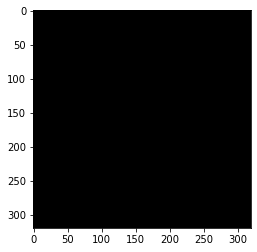

itogo 4
train_data/11.png


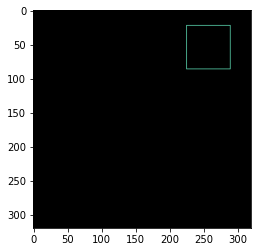

длина 231.3137083053589
длина 273.65685415267944
длина 248.97056198120117
длина 256.0
длина 231.3137083053589
длина 273.65685415267944
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 251.3137083053589
длина 256.0
длина 232.97056245803833
длина 272.0
длина 245.65685415267944
длина 261.65685415267944
длина 248.97056198120117
длина 256.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


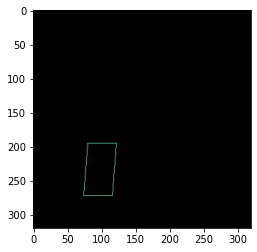

длина 65.65685415267944
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 216.62741661071777
длина 69.65685415267944
длина 260.6274166107178
длина 235.9411244392395
длина 242.97056245803833
длина 218.28427076339722
длина 256.6274166107178
длина 232.62741661071777
длина 248.62741661071777
длина 235.9411244392395
длина 242.97056245803833
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 217.4558436870575
длина 259.79898953437805
длина 232.62741661071777
длина 248.62741661071777
длина 238.28427076339722
длина 242.97056245803833
itogo 1


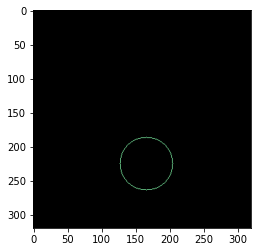

длина 236.45078945159912
длина 276.45079040527344
длина 252.45079040527344
длина 260.45079040527344
длина 236.45078945159912
длина 276.45079040527344
длина 246.79393672943115
длина 266.1076445579529
длина 252.45079040527344
длина 260.45079040527344
длина 78.62741661071777
длина 78.62741661071777
длина 78.62741661071777
длина 78.62741661071777
длина 236.45078945159912
длина 276.45079040527344
длина 249.13708209991455
длина 260.45079040527344
длина 78.62741661071777
длина 78.62741661071777
длина 78.62741661071777
длина 78.62741661071777
itogo 1


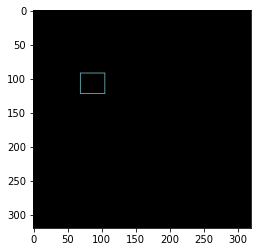

длина 107.31370830535889
длина 149.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 107.31370830535889
длина 149.65685415267944
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 107.31370830535889
длина 149.65685415267944
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
itogo 1


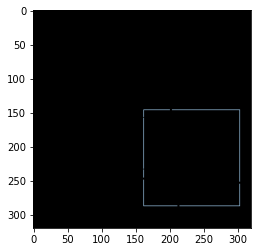

длина 161.65685415267944
длина 83.65685415267944
длина 49.65685415267944
длина 61.65685415267944
длина 11.656854152679443
длина 137.65685415267944
длина 195.65685415267944
длина 5.656854152679443
длина 545.9411249160767
длина 183.65685415267944
длина 61.65685415267944
длина 593.2548332214355
длина 240.48528122901917
длина 174.48528122901917
длина 408.48528122901917
длина 277.79898953437805
длина 234.82842707633972
длина 168.82842707633972
длина 18.0
длина 144.0
длина 402.8284270763397
длина 90.82842707633972
длина 544.2842707633972
длина 588.2842707633972
длина 242.82842707633972
длина 176.82842707633972
длина 410.8284270763397
длина 276.8284270763397
длина 234.2426404953003
длина 168.2426404953003
длина 20.0
длина 148.0
длина 402.2426404953003
длина 92.2426404953003
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 544.2842707633972
длина 589.9411249160767
длина 242.24264061450958
длина 176.24264061450958
длина 410.2426406145096
длин

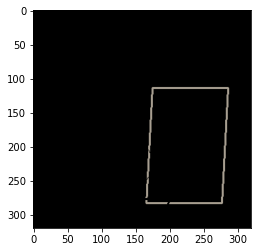

длина 147.65685415267944
длина 53.65685415267944
длина 13.656854152679443
длина 33.65685415267944
длина 33.65685415267944
длина 7.656854152679443
длина 31.656854152679443
длина 11.656854152679443
длина 33.65685415267944
длина 33.65685415267944
длина 11.656854152679443
длина 33.65685415267944
длина 7.656854152679443
длина 33.65685415267944
длина 33.65685415267944
длина 33.65685415267944
длина 33.65685415267944
длина 31.656854152679443
длина 31.656854152679443
длина 33.65685415267944
длина 33.65685415267944
длина 542.7695519924164
длина 13.656854152679443
длина 13.656854152679443
длина 215.65685415267944
длина 588.4264061450958
длина 76.48528122901917
длина 1055.5391039848328
длина 73.31370830535889
длина 1053.7817445993423
длина 70.24264061450958
длина 1051.1959581375122
длина 67.0710676908493
длина 55.071067690849304
длина 75.89949476718903
длина 902.5685415267944
длина 62.24264049530029
длина 48.82842707633972
длина 69.65685415267944
длина 896.325900554657
длина 147.65685415267944
дли

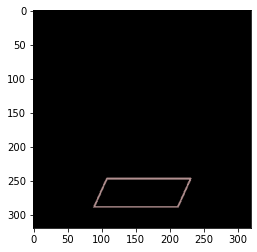

длина 314.911687374115
длина 5.656854152679443
длина 241.65685415267944
длина 361.9827550649643
длина 322.911687374115
длина 355.39696860313416
длина 326.911687374115
длина 353.39696860313416
длина 329.74011421203613
длина 348.32590091228485
длина 333.7401144504547
длина 345.9827550649643
длина 19.313708305358887
длина 19.071067690849304
длина 16.485281229019165
длина 16.485281229019165
длина 16.485281229019165
длина 16.485281229019165
длина 283.4558436870575
длина 0.0
длина 6.828427076339722
длина 314.911687374115
длина 5.656854152679443
длина 241.65685415267944
длина 361.9827550649643
длина 322.911687374115
длина 354.56854152679443
длина 328.56854152679443
длина 349.9827550649643
длина 332.56854152679443
длина 347.1543279886246
длина 19.313708305358887
длина 19.071067690849304
длина 0.0
длина 0.0
длина 16.485281229019165
длина 16.485281229019165
длина 16.485281229019165
длина 16.485281229019165
длина 0.0
длина 0.0
длина 283.4558436870575
длина 2.8284270763397217
длина 314.91168737411

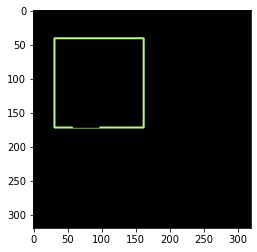

длина 59.65685415267944
длина 123.65685415267944
длина 47.65685415267944
длина 498.48528122901917
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 544.1421353816986
длина 507.3137083053589
длина 535.3137083053589
длина 508.1421353816986
длина 536.1421353816986
длина 968.6274166107178
длина 965.798989534378
длина 958.9705624580383
длина 954.9705624580383
длина 123.65685415267944
длина 47.65685415267944
длина 498.48528122901917
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 543.3137083053589
длина 504.97056245803833
длина 537.6568541526794
длина 507.3137083053589
длина 535.3137083053589
длина 510.6274161338806
длина 532.0
длина 968.6274166107178
длина 968.1421353816986
длина 961.798989534378
длина 958.9705619812012
длина 954.9705624580383
длина 63.65685415267944
длина 123.65685415267944
длина 47.65685415267944
длина 498.48528122901917
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 544.1421

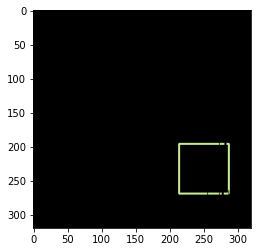

длина 5.656854152679443
длина 27.656854152679443
длина 77.65685415267944
длина 265.65685415267944
длина 131.65685415267944
длина 139.65685415267944
длина 7.656854152679443
длина 111.65685415267944
длина 312.1421353816986
длина 172.1421353816986
длина 408.1421353816986
длина 171.2132030725479
длина 410.7695519924164
длина 167.3137083053589
длина 402.48528122901917
длина 14.242640614509583
длина 143.0710676908493
длина 406.2842707633972
длина 0.0
длина 11.656854152679443
длина 27.656854152679443
длина 140.48528122901917
длина 9.656854152679443
длина 338.1421353816986
длина 8.0
длина 26.0
длина 136.82842707633972
длина 8.0
длина 337.65685415267944
длина 7.656854152679443
длина 5.656854152679443
длина 27.656854152679443
длина 77.65685415267944
длина 265.65685415267944
длина 131.65685415267944
длина 139.65685415267944
длина 7.656854152679443
длина 111.65685415267944
длина 312.1421353816986
длина 172.72792184352875
длина 408.1421353816986
длина 170.62741661071777
длина 410.7695519924164
длин

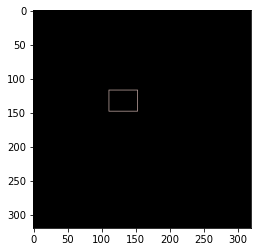

длина 65.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 119.65685415267944
длина 65.65685415267944
длина 165.3137083053589
длина 135.65685415267944
длина 151.65685415267944
длина 138.97056198120117
длина 146.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 121.31370830535889
длина 163.65685415267944
длина 135.65685415267944
длина 151.65685415267944
длина 141.3137083053589
длина 146.0
длина 65.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 119.65685415267944
длина 65.65685415267944
длина 165.3137083053589
длина 135.65685415267944
длина 151.65685415267944
длина 141.3137083053589
длина 146.0
itogo 4


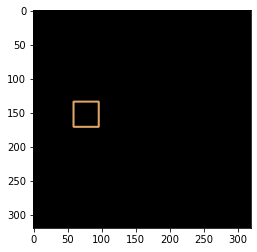

длина 67.65685415267944
длина 121.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 167.3137083053589
длина 127.31370830535889
длина 161.65685415267944
длина 129.65685415267944
длина 159.3137083053589
длина 132.97056198120117
длина 153.65685415267944
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 140.97056245803833
длина 148.0
длина 143.3137083053589
длина 145.65685415267944
длина 67.65685415267944
длина 121.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 167.3137083053589
длина 129.65685415267944
длина 159.3137083053589
длина 132.97056198120117
длина 156.0
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 67.65685415267944
длина 121.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 167.3137083053589
длина 129.65

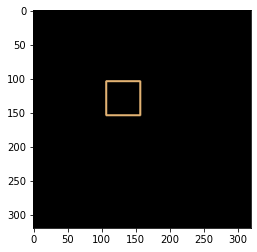

длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 179.3137083053589
длина 213.65685415267944
длина 181.65685415267944
длина 211.3137083053589
длина 184.97056198120117
длина 205.65685415267944
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 192.97056245803833
длина 200.0
длина 195.3137083053589
длина 200.0
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 192.97056198120117
длина 200.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 93.65685415267944
длина 173.65685415267944
длина 93.

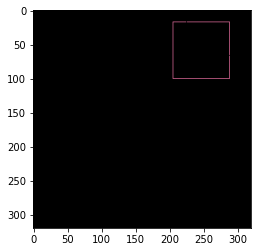

длина 147.65685415267944
длина 49.65685415267944
длина 79.65685415267944
длина 147.65685415267944
длина 308.1421353816986
длина 107.65685415267944
длина 21.656854152679443
длина 353.79898953437805
длина 319.3137083053589
длина 337.65685415267944
длина 323.3137083053589
длина 336.97056245803833
длина 214.82842707633972
длина 428.48528122901917
длина 308.1421353816986
длина 350.48528122901917
длина 219.89949476718903
длина 432.3847759962082
длина 309.79898953437805
длина 352.1421353816986
длина 323.3137083053589
длина 339.3137083053589
длина 214.82842707633972
длина 428.48528122901917
itogo 7


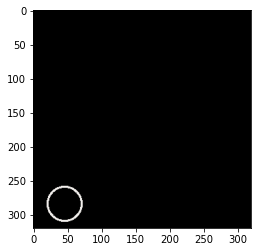

длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 143.1959571838379
длина 17.656854152679443
длина 186.50966548919678
длина 150.61017179489136
длина 180.8528127670288
длина 151.78174436092377
длина 178.50966548919678
длина 156.26702547073364
длина 175.1959581375122
длина 156.85281467437744
длина 172.8528127670288
длина 158.61017179489136
длина 172.8528127670288
длина 159.1959571838379
длина 170.5096664428711
длина 163.0954532623291
длина 167.1959581375122
длина 16.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 14.142135620117188
длина 14.142135620117188
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 14.142135620117188
длина 2.8284270763397217
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 16.0
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 143.1959571838379
д

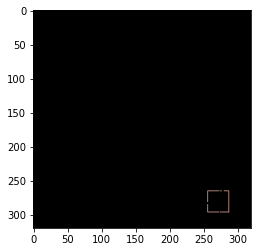

длина 9.656854152679443
длина 15.656854152679443
длина 5.656854152679443
длина 43.65685415267944
длина 15.656854152679443
длина 102.62741661071777
длина 15.656854152679443
длина 147.4558436870575
длина 160.3847759962082
длина 75.89949476718903
длина 158.04163014888763
длина 73.55634891986847
длина 48.82842707633972
длина 95.65685415267944
длина 0.0
длина 58.82842707633972
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 9.656854152679443
длина 15.656854152679443
длина 5.656854152679443
длина 43.65685415267944
длина 15.656854152679443
длина 102.62741661071777
длина 15.656854152679443
длина 147.4558436870575
длина 160.48528122901917
длина 74.82842707633972
длина 48.24264049530029
длина 94.48528099060059
длина 0.0
длина 58.24264049530029
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 9.656854152679443
длина 15.656854152679443
длина 5.656854152679443
длина 43.65685415267944
д

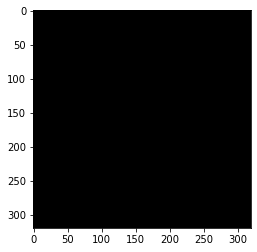

itogo 8
train_data/12.png


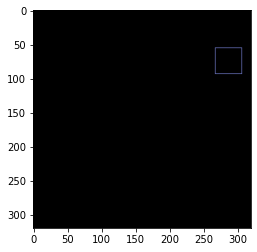

длина 129.3137083053589
длина 171.65685415267944
длина 143.65685415267944
длина 157.3137083053589
длина 59.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 127.65685415267944
длина 59.65685415267944
длина 173.3137083053589
длина 143.65685415267944
длина 157.3137083053589
длина 129.3137083053589
длина 171.65685415267944
длина 143.65685415267944
длина 159.65685415267944
длина 146.97056198120117
длина 154.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


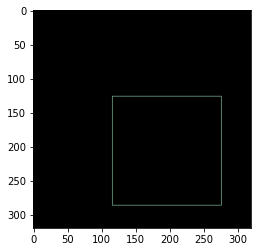

длина 615.3137083053589
длина 657.6568541526794
длина 629.6568541526794
длина 643.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 301.65685415267944
длина 301.65685415267944
длина 301.65685415267944
длина 613.6568541526794
длина 301.65685415267944
длина 659.3137083053589
длина 629.6568541526794
длина 645.6568541526794
длина 632.9705619812012
длина 640.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 301.65685415267944
длина 301.65685415267944
длина 301.65685415267944
длина 613.6568541526794
длина 301.65685415267944
длина 659.3137083053589
длина 629.6568541526794
длина 645.6568541526794
длина 635.3137083053589
длина 640.0
itogo 2


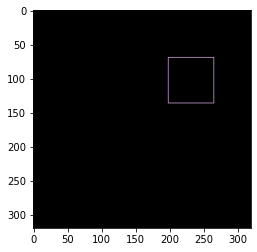

длина 243.3137083053589
длина 285.65685415267944
длина 255.3137083053589
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
длина 243.3137083053589
длина 285.65685415267944
длина 257.65685415267944
длина 273.65685415267944
длина 263.3137083053589
длина 268.0
длина 243.3137083053589
длина 285.65685415267944
длина 255.3137083053589
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
itogo 3


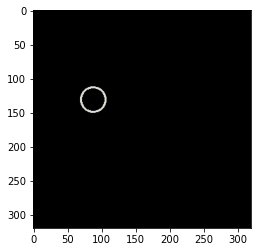

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.882248878479
длина 104.56854176521301
длина 134.22539615631104
длина 106.91168713569641
длина 131.882248878479
длина 110.2253954410553
длина 128.56854152679443
длина 112.56854176521301
длина 126.22539615631104
длина 112.56854176521301
длина 126.22539520263672
длина 118.2253954410553
длина 120.56854057312012
длина 97.74011468887329
длина 127.39696788787842
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.882248878479
длина 104.56854176521301
длина 134.22539615631104
длина 106.91168713569641
длина 131.882248878479
длина 110.2253954410553
длина 128.56854152679443
длина 112.56854176521301
длина 126.22539615631104
длина 112.56854176521301
длина 126.22539520263672
длина 118.2253954410553
длина 120.56854057312012
длина 97.74011468887329
длина 127.39696788787842
длина 11.6568541

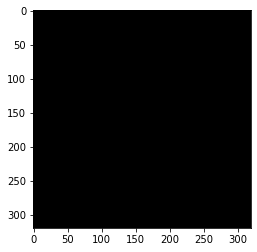

itogo 3
train_data/13.png


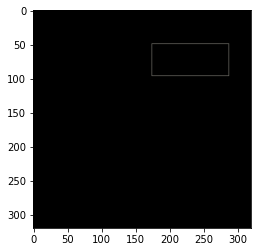

длина 295.3137083053589
длина 337.65685415267944
длина 309.65685415267944
длина 323.3137083053589
длина 207.65685415267944
длина 75.65685415267944
длина 79.65685415267944
длина 293.65685415267944
длина 211.65685415267944
длина 339.3137083053589
длина 309.65685415267944
длина 323.3137083053589
длина 296.97056245803833
длина 336.0
длина 312.9705619812012
длина 320.0
itogo 0


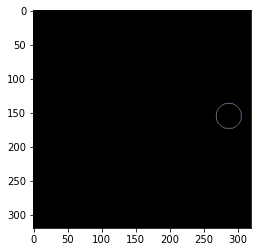

длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 102.22539710998535
длина 142.22539520263672
длина 118.22539615631104
длина 126.22539710998535
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 49.79898953437805
длина 49.79898953437805
длина 49.79898953437805
длина 49.79898953437805
itogo 0


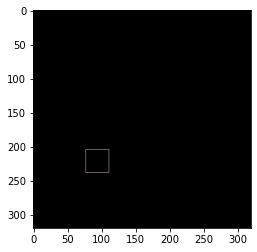

длина 111.31370830535889
длина 153.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 131.3137083053589
длина 136.0
длина 112.97056245803833
длина 152.0
длина 125.65685415267944
длина 139.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 111.31370830535889
длина 153.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 131.3137083053589
длина 136.0
itogo 1


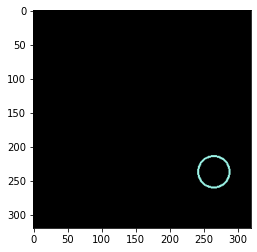

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 131.88224959373474
длина 13.656854152679443
длина 172.85281372070312
длина 139.88224983215332
длина 164.85281372070312
длина 143.19595861434937
длина 161.53910446166992
длина 145.53910398483276
длина 159.1959571838379
длина 147.88224983215332
длина 156.85281372070312
длина 12.0
длина 6.828427076339722
длина 19.313708305358887
длина 19.313708305358887
длина 19.313708305358887
длина 12.0
длина 12.0
длина 11.656854152679443
длина 11.656854152679443
длина 19.313708305358887
длина 6.828427076339722
длина 12.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 131.88224959373474
длина 13.656854152679443
длина 172.85281372070312
длина 137.53910398483276
длина 167.1959571838379
длина 139.88224983215332
длина 164.85281372070312
длина 143.19595861434937
длина 161.53910446166992
длина 145.53910398483276
длина 159.1959571838379
длина 145.53910398483276
длина 159.1959571838379
длина 147.88

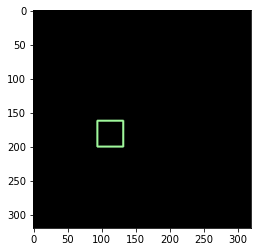

длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 136.97056198120117
длина 160.0
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 147.3137083053589
длина 149.65685415267944
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 131.3137083053589
длина 165.65685415267944
длина 133.65685415267944
длина 163.3137083053589
длина 136.97056198120117
длина 160.0
длина 139.3137083053589
длина 157.65685415267944
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 144.97056198120117
длина 152.0
длина 147.3137083053589
длина 149.65685415267944
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.656

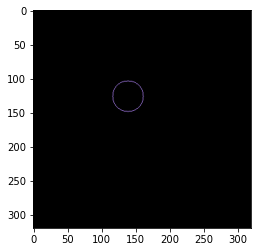

длина 129.53910541534424
длина 169.53910398483276
длина 142.22539520263672
длина 153.53910446166992
длина 43.31370830535889
длина 43.31370830535889
длина 43.31370830535889
длина 43.31370830535889
длина 129.53910541534424
длина 169.53910398483276
длина 145.53910446166992
длина 153.5391035079956
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539567947388
длина 156.85281372070312
длина 147.88224983215332
длина 151.1959581375122
длина 8.0
длина 8.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 8.0
длина 8.0
itogo 2


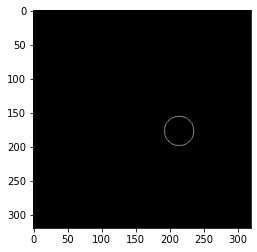

длина 123.88224983215332
длина 161.53910446166992
длина 134.22539710998535
длина 147.882248878479
длина 43.31370830535889
длина 6.2426406145095825
длина 6.2426406145095825
длина 43.31370830535889
длина 43.31370830535889
длина 6.2426406145095825
длина 6.2426406145095825
длина 43.31370830535889
длина 123.88224983215332
длина 161.53910446166992
длина 134.22539710998535
длина 151.1959571838379
длина 139.882248878479
длина 145.5391025543213
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 123.88224983215332
длина 161.53910446166992
длина 134.22539710998535
длина 147.882248878479
длина 139.88224983215332
длина 145.53910398483276
itogo 2


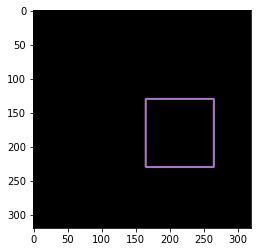

длина 193.65685415267944
длина 373.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 419.3137083053589
длина 381.65685415267944
длина 411.3137083053589
длина 381.65685415267944
длина 411.3137083053589
длина 387.3137083053589
длина 405.65685415267944
длина 389.65685415267944
длина 403.3137083053589
длина 392.9705619812012
длина 400.0
длина 193.65685415267944
длина 373.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 419.3137083053589
длина 381.65685415267944
длина 411.3137083053589
длина 387.3137083053589
длина 405.65685415267944
длина 389.65685415267944
длина 403.3137083053589
длина 395.3137083053589
длина 397.65685415267944
длина 193.65685415267944
длина 373.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 419.3137083053589
длина 381.65685415267944
длина 411.3137083053589
длина 381.65685415267944
длина 411.3137083053589
длина 387.3137083053589
дли

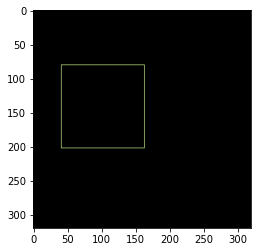

длина 225.65685415267944
длина 225.65685415267944
длина 225.65685415267944
длина 461.65685415267944
длина 225.65685415267944
длина 507.3137083053589
длина 477.65685415267944
длина 493.65685415267944
длина 480.9705619812012
длина 488.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 463.3137083053589
длина 505.65685415267944
длина 475.3137083053589
длина 493.65685415267944
длина 477.65685415267944
длина 491.3137083053589
длина 483.3137083053589
длина 488.0
длина 464.97056245803833
длина 504.0
длина 477.65685415267944
длина 491.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 4


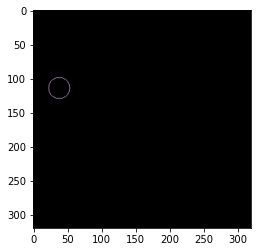

длина 82.91168785095215
длина 122.91168737411499
длина 95.59797859191895
длина 110.22539615631104
длина 101.25483322143555
длина 104.56854057312012
длина 82.91168785095215
длина 122.91168737411499
длина 98.91168689727783
длина 106.91168785095215
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 82.91168785095215
длина 122.91168737411499
длина 95.5979790687561
длина 110.22539615631104
длина 101.25483322143555
длина 104.56854057312012
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
itogo 4


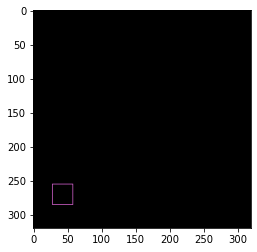

длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 95.31370830535889
длина 137.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 95.31370830535889
длина 137.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
itogo 5


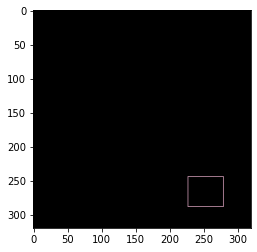

длина 85.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 165.65685415267944
длина 85.65685415267944
длина 211.3137083053589
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 192.0
длина 85.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 165.65685415267944
длина 85.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 197.65685415267944
длина 187.3137083053589
длина 192.0
длина 85.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 165.65685415267944
длина 85.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 197.65685415267944
длина 184.97056198120117
длина 192.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


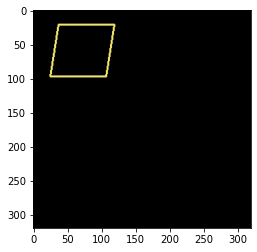

длина 157.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 296.7695519924164
длина 157.65685415267944
длина 343.5979790687561
длина 304.7695519924164
длина 339.5979790687561
длина 307.5979790687561
длина 337.25483322143555
длина 310.4264061450958
длина 333.94112491607666
длина 311.5979788303375
длина 331.5979790687561
длина 314.4264061450958
длина 331.5979790687561
длина 315.5979790687561
длина 329.25483322143555
длина 317.25483322143555
длина 325.94112491607666
длина 168.48528122901917
длина 6.

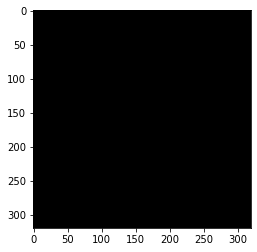

itogo 5
train_data/14.png


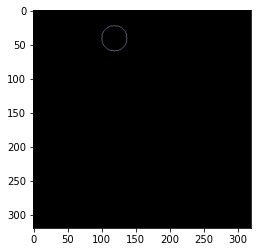

длина 102.22539710998535
длина 142.22539520263672
длина 120.56854152679443
длина 128.56854152679443
длина 102.22539710998535
длина 142.22539520263672
длина 118.22539710998535
длина 126.22539615631104
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 43.31370830535889
длина 43.31370830535889
длина 43.31370830535889
длина 43.31370830535889
itogo 0


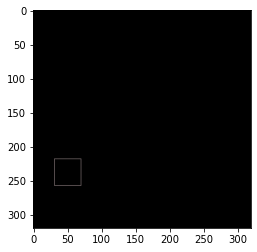

длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 129.65685415267944
длина 59.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 159.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 59.65685415267944
длина 59.65685415267944
длина 63.65685415267944
длина 129.65685415267944
длина 63.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 159.3137083053589
длина 131.3137083053589
длина 173.65685415267944
длина 145.65685415267944
длина 159.3137083053589
itogo 1


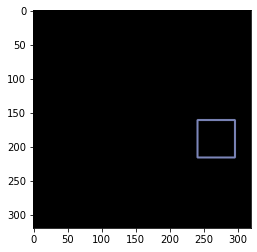

длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 217.65685415267944
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 212.97056198120117
длина 220.0
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
д

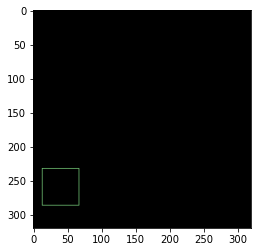

длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 189.65685415267944
длина 89.65685415267944
длина 235.3137083053589
длина 205.65685415267944
длина 219.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 189.65685415267944
длина 89.65685415267944
длина 235.3137083053589
длина 205.65685415267944
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 211.3137083053589
длина 216.0
длина 191.3137083053589
длина 233.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 3


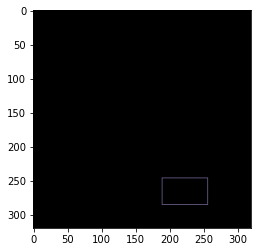

длина 187.3137083053589
длина 229.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 187.3137083053589
длина 229.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 187.3137083053589
длина 229.65685415267944
длина 201.65685415267944
длина 217.65685415267944
длина 207.3137083053589
длина 212.0
itogo 3


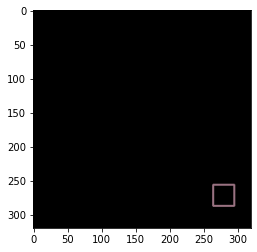

длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 108.97056198120117
длина 129.65685415267944
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 121.65685415267944
длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 111.31370830535889
длина 129.65685415267944
длина 116.97056245803833
длина 124.0
длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124

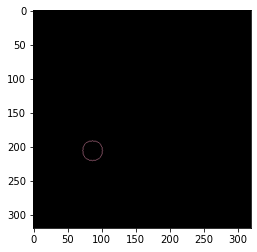

длина 77.25483322143555
длина 117.25483322143555
длина 89.94112491607666
длина 101.25483322143555
длина 39.31370830535889
длина 39.31370830535889
длина 39.31370830535889
длина 39.31370830535889
длина 77.25483322143555
длина 117.25483322143555
длина 95.5979790687561
длина 98.91168785095215
длина 77.25483322143555
длина 117.25483322143555
длина 93.25483322143555
длина 101.25483322143555
itogo 4


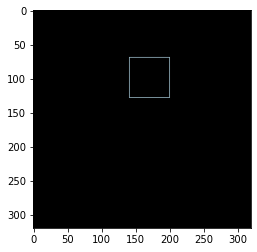

длина 211.3137083053589
длина 253.65685415267944
длина 225.65685415267944
длина 241.65685415267944
длина 231.3137083053589
длина 236.0
длина 211.3137083053589
длина 253.65685415267944
длина 225.65685415267944
длина 241.65685415267944
длина 228.97056198120117
длина 242.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 211.3137083053589
длина 253.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
itogo 5


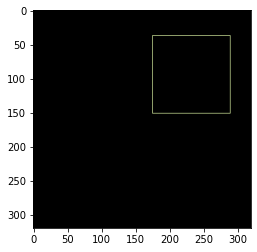

длина 431.3137083053589
длина 473.65685415267944
длина 445.65685415267944
длина 461.65685415267944
длина 448.9705619812012
длина 462.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 432.97056245803833
длина 472.0
длина 443.3137083053589
длина 461.65685415267944
длина 445.65685415267944
длина 459.3137083053589
длина 451.3137083053589
длина 456.0
длина 209.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 429.65685415267944
длина 209.65685415267944
длина 475.3137083053589
длина 445.65685415267944
длина 461.65685415267944
длина 451.3137083053589
длина 456.0
itogo 6


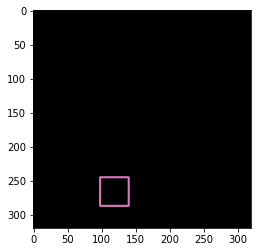

длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 187.3137083053589
длина 147.3137083053589
длина 181.65685415267944
длина 149.65685415267944
длина 179.3137083053589
длина 152.97056198120117
длина 173.65685415267944
длина 155.3137083053589
длина 173.65685415267944
длина 157.65685415267944
длина 171.3137083053589
длина 157.65685415267944
длина 171.3137083053589
длина 163.3137083053589
длина 168.0
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 187.3137083053589
длина 149.65685415267944
длина 179.3137083053589
длина 155.3137083053589
длина 173.65685415267944
длина 157.65685415267944
длина 171.3137083053589
длина 163.3137083053589
длина 165.65685415267944
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 187.3137083053589
длина 149.65685415267944
длина 179.313

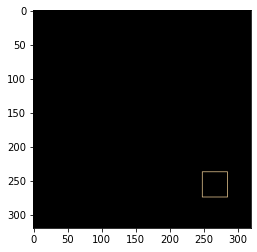

длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 143.3137083053589
длина 148.0
itogo 8


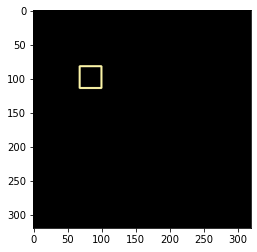

длина 57.65685415267944
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 147.3137083053589
длина 107.31370830535889
длина 141.65685415267944
длина 109.65685415267944
длина 139.3137083053589
длина 112.97056198120117
длина 136.0
длина 115.31370830535889
длина 133.65685415267944
длина 115.31370830535889
длина 133.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 120.97056198120117
длина 128.0
длина 123.31370830535889
длина 125.65685415267944
длина 57.65685415267944
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 147.3137083053589
длина 107.31370830535889
длина 141.65685415267944
длина 109.65685415267944
длина 139.3137083053589
длина 112.97056198120117
длина 136.0
длина 115.31370830535889
длина 133.65685415267944
длина 117.65685415267944
длина 133.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 120.97056198120117
длина 128.0
длина 123.313708

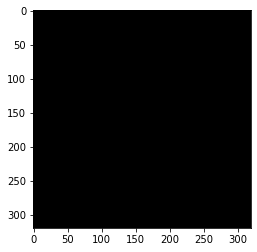

itogo 9
train_data/15.png


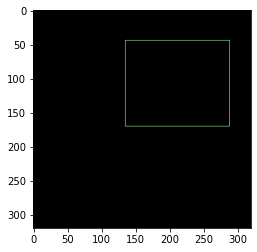

длина 287.65685415267944
длина 233.65685415267944
длина 233.65685415267944
длина 531.6568541526794
длина 287.65685415267944
длина 577.3137083053589
длина 547.6568541526794
длина 561.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 533.3137083053589
длина 575.6568541526794
длина 547.6568541526794
длина 563.6568541526794
длина 550.9705619812012
длина 558.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 533.3137083053589
длина 575.6568541526794
длина 547.6568541526794
длина 563.6568541526794
длина 553.3137083053589
длина 558.0
itogo 0


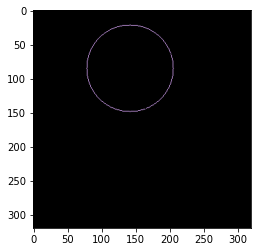

длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 401.30360221862793
длина 7.656854152679443
длина 7.656854152679443
длина 441.30360317230225
длина 413.98989486694336
длина 428.6173105239868
длина 200.40916073322296
длина 631.9554040431976
длина 16.0
длина 16.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 16.0
длина 16.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 401.30360221862793
длина 441.30360317230225
длина 413.9898958206177
длина 425.3036050796509
длина 8.828427076339722
длина 107.4558436870575
длина 6.828427076339722
длина 6.828427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.

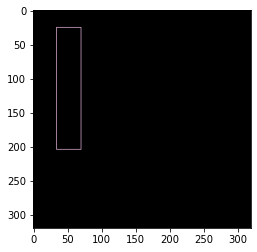

длина 53.65685415267944
длина 339.65685415267944
длина 339.65685415267944
длина 403.65685415267944
длина 53.65685415267944
длина 449.3137083053589
длина 417.3137083053589
длина 435.65685415267944
длина 419.65685415267944
длина 433.3137083053589
длина 425.3137083053589
длина 430.0
длина 53.65685415267944
длина 339.65685415267944
длина 339.65685415267944
длина 403.65685415267944
длина 53.65685415267944
длина 449.3137083053589
длина 419.65685415267944
длина 435.65685415267944
длина 422.9705619812012
длина 430.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 405.3137083053589
длина 447.65685415267944
длина 417.3137083053589
длина 435.65685415267944
длина 419.65685415267944
длина 433.3137083053589
длина 425.3137083053589
длина 430.0
itogo 0


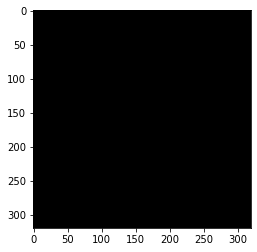

itogo 0
train_data/16.png


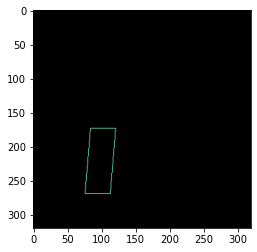

длина 247.94112491607666
длина 288.6274166107178
длина 265.59797859191895
длина 272.6274166107178
длина 247.94112491607666
длина 288.6274166107178
длина 259.94112491607666
длина 278.2842707633972
длина 262.2842707633972
длина 275.94112491607666
длина 267.94112491607666
длина 272.6274166107178
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 247.11269783973694
длина 289.4558436870575
длина 262.2842707633972
длина 278.2842707633972
длина 265.59797859191895
длина 272.6274166107178
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 0


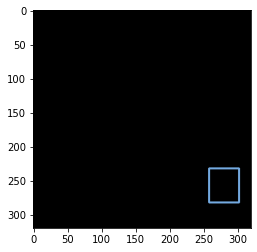

длина 81.65685415267944
длина 161.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 81.65685415267944
длина 207.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 81.65685415267944
длина 161.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 81.65685415267944
длина 207.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 180.97056198120117
длина 188.0
длина 81.65685415267944
длина 161.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 81.65685415267944
длина 207.3137083053589
длина 167.3137083053589
длина 201.65685415267944
длина 169.65685415267944
длина 199.3

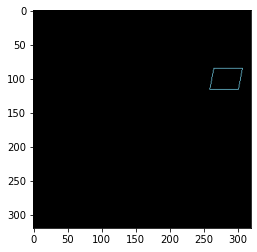

длина 65.65685415267944
длина 122.97056245803833
длина 65.65685415267944
длина 168.62741661071777
длина 140.62741661071777
длина 154.28427076339722
длина 65.65685415267944
длина 122.97056245803833
длина 65.65685415267944
длина 167.4558436870575
длина 137.79898953437805
длина 156.62741661071777
длина 141.79898953437805
длина 152.62741661071777
длина 86.82842707633972
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 86.82842707633972
длина 123.79898953437805
длина 166.62741661071777
длина 137.79898953437805
длина 156.62741661071777
длина 140.62741661071777
длина 154.28427076339722
длина 144.6274163722992
длина 150.97056245803833
itogo 0


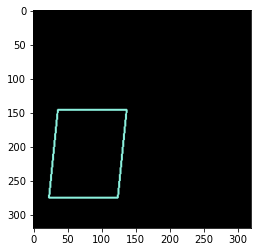

длина 195.65685415267944
длина 5.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 444.4264061450958
длина 195.65685415267944
длина 490.08326029777527
длина 452.4264061450958
длина 482.08326029777527
длина 457.25483322143555
длина 476.4264061450958
длина 460.4264061450958
длина 474.08326029777527
длина 710.3675308227539
длина 214.4852809906006
длина 195.65685415267944
длина 5.656854152679443
длина 15.656854152679443
длина 15

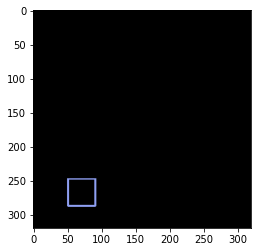

длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 177.3137083053589
длина 141.65685415267944
длина 170.48528122901917
длина 147.3137083053589
длина 164.82842707633972
длина 149.65685415267944
длина 163.65685415267944
длина 235.3137080669403
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 177.3137083053589
длина 141.65685415267944
длина 170.48528122901917
длина 144.97056198120117
длина 166.0
длина 147.3137083053589
длина 163.65685415267944
длина 239.79898953437805
длина 235.3137083053589
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 177.3137083053589
длина 139.3137083053589
длина 171.65685415267944
длина 141.65685415267944
длина 169.3137083053589
длина 144.97056198120117
длина 166.0
длина 147.3137083053589
длина 164.82842707633972
длина 149.65685415267944
длина 163.65685415267944
длина 244.97056245803833
длина 235.3137080669

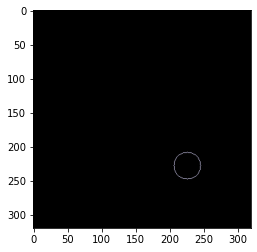

длина 110.22539615631104
длина 150.22539567947388
длина 122.91168689727783
длина 134.22539615631104
длина 52.97056245803833
длина 52.97056245803833
длина 52.97056245803833
длина 52.97056245803833
длина 110.22539615631104
длина 150.22539567947388
длина 122.91168689727783
длина 134.22539615631104
длина 52.97056245803833
длина 52.97056245803833
длина 52.97056245803833
длина 52.97056245803833
длина 110.22539615631104
длина 150.22539567947388
длина 122.91168689727783
длина 134.22539615631104
длина 128.56854152679443
длина 131.882248878479
itogo 1


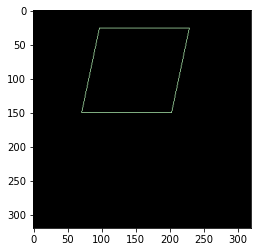

длина 245.65685415267944
длина 505.53910398483276
длина 245.65685415267944
длина 550.0243852138519
длина 520.3675310611725
длина 539.1959581375122
длина 526.0243852138519
длина 533.5391039848328
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 245.65685415267944
длина 505.53910398483276
длина 245.65685415267944
длина 551.1959581375122
длина 520.3675310611725
длина 539.1959581375122
длина 523.1959581375122
длина 536.8528122901917
длина 527.1959578990936
длина 533.5391039848328
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 245.65685415267944
длина 505.53910398483276
длина 245.65685415267944
длина 551.1959581375122
длина 520.3675310611725
длина 539.1959581375122
длина 526.0243852138519
длина 533.5391039848328
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


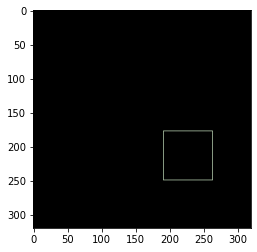

длина 264.97056245803833
длина 301.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 263.3137083053589
длина 305.65685415267944
длина 275.3137083053589
длина 293.65685415267944
длина 277.65685415267944
длина 291.3137083053589
длина 283.3137083053589
длина 288.0
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 261.65685415267944
длина 125.65685415267944
длина 307.3137083053589
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


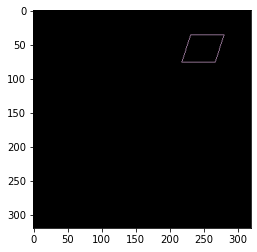

длина 161.5979790687561
длина 204.42640614509583
длина 175.5979790687561
длина 194.42640614509583
длина 181.25483322143555
длина 188.76955199241638
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 161.5979790687561
длина 204.42640614509583
длина 176.76955199241638
длина 194.42640614509583
длина 182.42640614509583
длина 188.76955199241638
длина 79.65685415267944
длина 160.76955199241638
длина 79.65685415267944
длина 205.25483322143555
длина 175.5979790687561
длина 194.42640614509583
длина 181.25483322143555
длина 188.76955199241638
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
itogo 2


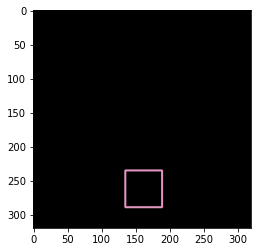

длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 195.3137083053589
длина 229.65685415267944
длина 197.65685415267944
длина 227.3137083053589
длина 200.97056198120117
длина 221.65685415267944
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 205.65685415267944
длина 219.3137083053589
длина 211.3137083053589
длина 216.0
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 200.97056198120117
длина 221.65685415267944
длина 203.3137083053589
длина 221.65685415267944
длина 208.97056245803833
длина 216.0
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.6

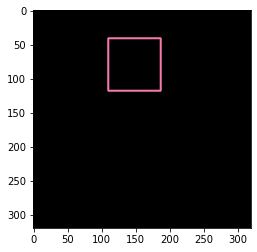

длина 147.65685415267944
длина 281.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 327.3137083053589
длина 287.3137083053589
длина 321.65685415267944
длина 289.65685415267944
длина 319.3137083053589
длина 292.9705619812012
длина 316.0
длина 295.3137083053589
длина 313.65685415267944
длина 297.65685415267944
длина 313.65685415267944
длина 297.65685415267944
длина 311.3137083053589
длина 300.9705619812012
длина 308.0
длина 303.3137083053589
длина 305.65685415267944
длина 147.65685415267944
длина 281.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 327.3137083053589
длина 289.65685415267944
длина 319.3137083053589
длина 295.3137083053589
длина 313.65685415267944
длина 297.65685415267944
длина 311.3137083053589
длина 303.3137083053589
длина 305.65685415267944
длина 147.65685415267944
длина 281.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 327.3137

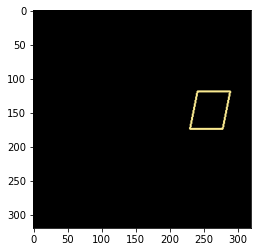

длина 89.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 185.94112491607666
длина 13.656854152679443
длина 89.65685415267944
длина 232.76955199241638
длина 193.94112491607666
длина 228.76955199241638
длина 195.11269783973694
длина 226.42640614509583
длина 199.5979790687561
длина 223.11269783973694
длина 199.59797883033752
длина 220.76955199241638
длина 201.94112491607666
длина 220.76955199241638
длина 203.5979790687561
длина 218.42640614509583
длина 207.5979790687561
длина 215.11269783973694
длина 4.0
длина 108.48528122901917
длина 4.0
длина 4.0
длина 4.0
длина 4.

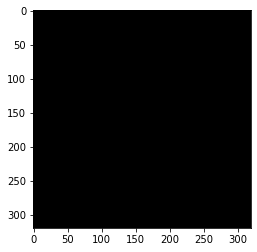

itogo 4
train_data/17.png


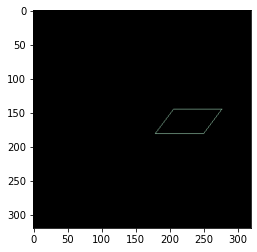

длина 205.29646182060242
длина 249.53910219669342
длина 223.5391025543213
длина 239.19595634937286
длина 4.0
длина 5.414213538169861
длина 203.88224828243256
длина 249.53910219669342
длина 222.12488877773285
длина 240.36752903461456
длина 148.48528122901917
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 153.3137083053589
длина 3.414213538169861
длина 4.0
длина 125.65685415267944
длина 201.05382120609283
длина 125.65685415267944
длина 251.19595634937286
длина 222.12488877773285
длина 240.36752903461456
длина 140.82842707633972
длина 140.24264061450958
itogo 0


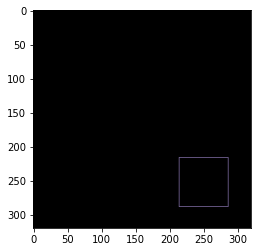

длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 283.3137083053589
длина 288.0
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 261.65685415267944
длина 125.65685415267944
длина 307.3137083053589
длина 277.65685415267944
длина 291.3137083053589
длина 264.97056245803833
длина 304.0
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
itogo 1


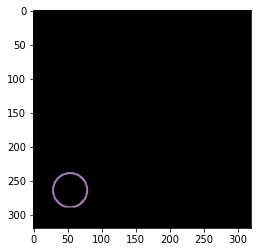

длина 17.656854152679443
длина 17.656854152679443
длина 143.1959571838379
длина 17.656854152679443
длина 185.68123841285706
длина 151.1959581375122
длина 177.68123841285706
длина 156.26702547073364
длина 174.36753106117249
длина 157.43860030174255
длина 172.0243856906891
длина 314.87719655036926
длина 305.8061294555664
длина 17.656854152679443
длина 17.656854152679443
длина 143.1959571838379
длина 17.656854152679443
длина 185.68123841285706
длина 151.78174436092377
длина 177.68123841285706
длина 156.85281372070312
длина 172.0243866443634
длина 317.705623626709
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 15.313708305358887
длина 15.313708186149597
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 15.313708186149597
длина 2.8284270763397217
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 16.0
длина 17.656854152679443
длина 17.6

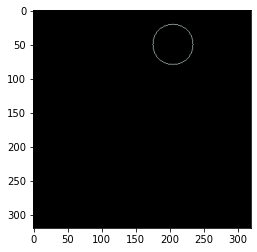

длина 176.166522026062
длина 216.16652011871338
длина 188.8528127670288
длина 200.166522026062
длина 194.50966548919678
длина 197.82337474822998
длина 176.166522026062
длина 216.16652011871338
длина 188.8528127670288
длина 203.4802303314209
длина 194.5096664428711
длина 197.82337474822998
длина 176.166522026062
длина 216.16652011871338
длина 188.8528127670288
длина 203.4802303314209
длина 194.5096664428711
длина 197.82337474822998
itogo 1


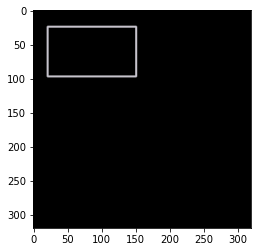

длина 253.65685415267944
длина 379.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 253.65685415267944
длина 425.3137083053589
длина 387.65685415267944
длина 417.3137083053589
длина 387.65685415267944
длина 417.3137083053589
длина 393.3137083053589
длина 411.65685415267944
длина 395.65685415267944
длина 411.65685415267944
длина 395.65685415267944
длина 409.3137083053589
длина 401.3137083053589
длина 406.0
длина 253.65685415267944
длина 379.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 253.65685415267944
длина 425.3137083053589
длина 387.65685415267944
длина 417.3137083053589
длина 387.65685415267944
длина 417.3137083053589
длина 393.3137083053589
длина 411.65685415267944
длина 395.65685415267944
длина 411.65685415267944
длина 395.65685415267944
длина 409.3137083053589
длина 401.3137083053589
длина 406.0
длина 253.65685415267944
длина 379.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 253.65685415267944
длина 425.313

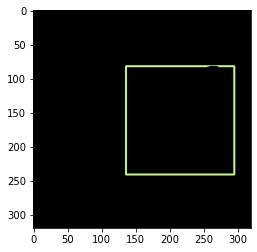

длина 311.65685415267944
длина 311.65685415267944
длина 610.4852812290192
длина 311.65685415267944
длина 39.65685415267944
длина 233.65685415267944
длина 5.656854152679443
длина 656.1421353816986
длина 619.3137083053589
длина 647.3137083053589
длина 620.1421353816986
длина 648.1421353816986
длина 1246.6274166107178
длина 1242.6274166107178
длина 1234.6274166107178
длина 1228.9705619812012
длина 311.65685415267944
длина 311.65685415267944
длина 311.65685415267944
длина 611.3137083053589
длина 39.65685415267944
длина 233.65685415267944
длина 656.1421353816986
длина 616.9705624580383
длина 649.6568541526794
длина 619.3137083053589
длина 647.3137083053589
длина 622.6274161338806
длина 644.0
длина 1246.6274166107178
длина 1244.9705624580383
длина 1235.798989534378
длина 1228.9705619812012
длина 1224.9705624580383
длина 311.65685415267944
длина 311.65685415267944
длина 311.65685415267944
длина 611.3137083053589
длина 39.65685415267944
длина 233.65685415267944
длина 656.1421353816986
длина 61

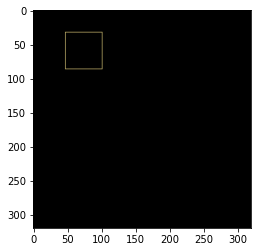

длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 189.65685415267944
длина 89.65685415267944
длина 235.3137083053589
длина 205.65685415267944
длина 221.65685415267944
длина 208.97056198120117
длина 216.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 189.65685415267944
длина 89.65685415267944
длина 235.3137083053589
длина 205.65685415267944
длина 221.65685415267944
длина 208.97056198120117
длина 216.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 191.3137083053589
длина 233.65685415267944
длина 205.65685415267944
длина 219.3137083053589
itogo 3


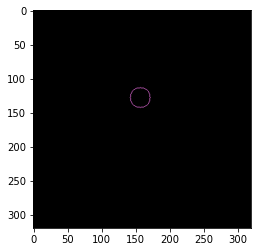

длина 77.25483322143555
длина 117.25483322143555
длина 87.59797859191895
длина 104.56854057312012
длина 95.5979790687561
длина 98.91168785095215
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 77.25483322143555
длина 117.25483322143555
длина 95.5979790687561
длина 98.91168785095215
длина 77.25483322143555
длина 117.25483322143555
длина 87.59797954559326
длина 104.56854152679443
длина 95.5979790687561
длина 98.91168785095215
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
itogo 3


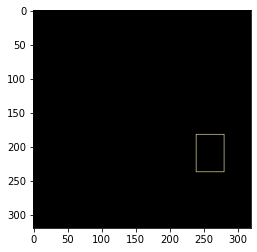

длина 168.97056245803833
длина 208.0
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 192.0
длина 63.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 165.65685415267944
длина 63.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 192.0
длина 167.3137083053589
длина 209.65685415267944
длина 181.65685415267944
длина 197.65685415267944
длина 187.3137083053589
длина 192.0
itogo 3


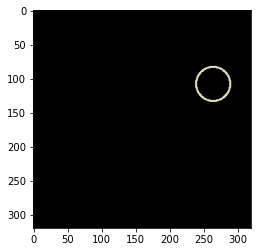

длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 143.1959571838379
длина 17.656854152679443
длина 186.50966548919678
длина 150.61017179489136
длина 180.8528127670288
длина 151.78174436092377
длина 178.50966548919678
длина 156.26702547073364
длина 175.1959581375122
длина 157.43860030174255
длина 172.8528127670288
длина 158.61017179489136
длина 172.8528127670288
длина 159.78174436092377
длина 170.50966548919678
длина 164.26702547073364
длина 167.1959581375122
длина 2.8284270763397217
длина 14.142135620117188
длина 5.656854152679443
длина 2.8284270763397217
длина 2.8284270763397217
длина 5.656854152679443
длина 2.8284270763397217
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 143.1959571838379
длина 17.656854152679443
длина 186.50966548919678
длина 150.61017179489136
длина 180.8528127670288
длина 151.78174436092377
длина 178.50966548919678
длина 156.2670259475708
длина 175.1959581375122
длина 157.43860030174255
длина 172.85

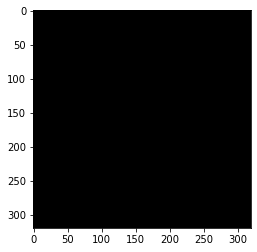

itogo 3
train_data/18.png


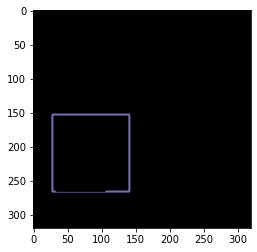

длина 63.65685415267944
длина 426.48528122901917
длина 219.65685415267944
длина 219.65685415267944
длина 219.65685415267944
длина 471.3137083053589
длина 435.3137083053589
длина 463.3137083053589
длина 753.798989534378
длина 746.9705624580383
длина 63.65685415267944
длина 426.48528122901917
длина 219.65685415267944
длина 219.65685415267944
длина 219.65685415267944
длина 471.3137083053589
длина 435.3137083053589
длина 463.3137083053589
длина 753.798989534378
длина 746.9705624580383
длина 63.65685415267944
длина 426.48528122901917
длина 219.65685415267944
длина 219.65685415267944
длина 219.65685415267944
длина 471.3137083053589
длина 435.3137083053589
длина 463.3137083053589
длина 436.1421353816986
длина 464.1421353816986
длина 756.6274166107178
длина 749.798989534378
длина 746.9705619812012
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


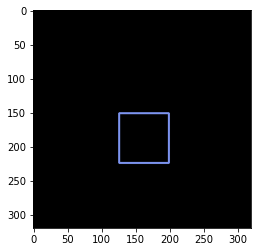

длина 139.65685415267944
длина 265.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 311.3137083053589
длина 273.65685415267944
длина 303.3137083053589
длина 279.3137083053589
длина 297.65685415267944
длина 281.65685415267944
длина 295.3137083053589
длина 287.3137083053589
длина 289.65685415267944
длина 139.65685415267944
длина 265.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 311.3137083053589
длина 273.65685415267944
длина 303.3137083053589
длина 276.9705619812012
длина 297.65685415267944
длина 281.65685415267944
длина 297.65685415267944
длина 284.97056245803833
длина 292.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 139.65685415267944
длина 265.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 311.3137083053589
длина 271.3137083053589
длина 305.65685415267944
длина 273.6568541526794

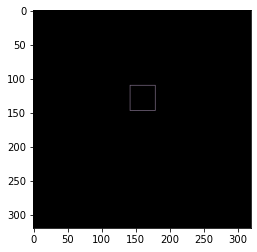

длина 123.31370830535889
длина 165.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 123.31370830535889
длина 165.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 3


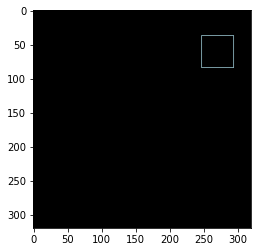

длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 193.65685415267944
длина 183.3137083053589
длина 188.0
длина 163.3137083053589
длина 205.65685415267944
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
itogo 4


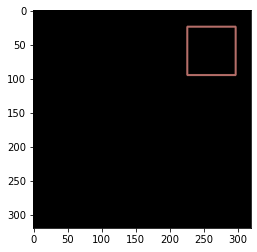

длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 276.9705619812012
длина 284.0
длина 279.3137083053589
длина 281.65685415267944
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 276.9705619812012
длина 284.0
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 276.9705619812012
длина 284.0
itog

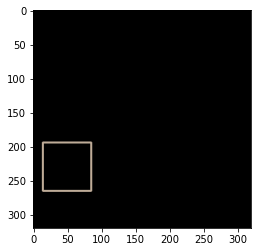

длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 279.3137083053589
длина 281.65685415267944
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 276.9705619812012
длина 284.0
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
д

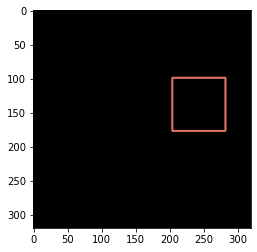

длина 149.65685415267944
длина 285.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 331.3137083053589
длина 291.3137083053589
длина 325.65685415267944
длина 293.65685415267944
длина 323.3137083053589
длина 296.9705619812012
длина 317.65685415267944
длина 299.3137083053589
длина 317.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 304.97056245803833
длина 312.0
длина 307.3137083053589
длина 312.0
длина 149.65685415267944
длина 285.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 331.3137083053589
длина 293.65685415267944
длина 323.3137083053589
длина 299.3137083053589
длина 317.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 149.65685415267944
длина 285.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 331.31

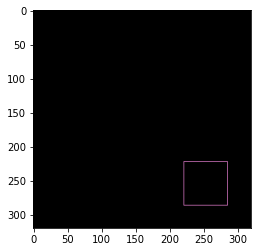

длина 232.97056245803833
длина 272.0
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 251.3137083053589
длина 256.0
длина 231.3137083053589
длина 273.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 231.3137083053589
длина 273.65685415267944
длина 245.65685415267944
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 251.3137083053589
длина 256.0
itogo 8


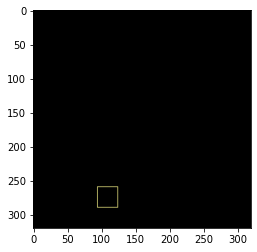

длина 95.31370830535889
длина 137.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 95.31370830535889
длина 137.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 125.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 9


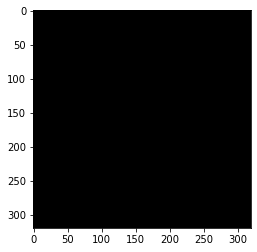

itogo 9
train_data/19.png


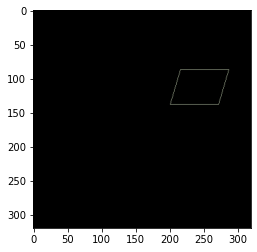

длина 229.25483322143555
длина 272.08326029777527
длина 244.42640614509583
длина 258.08326029777527
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 125.65685415267944
длина 228.42640614509583
длина 125.65685415267944
длина 272.911687374115
длина 244.42640614509583
длина 260.4264061450958
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 230.08326029777527
длина 271.25483322143555
длина 244.42640614509583
длина 258.08326029777527
itogo 0


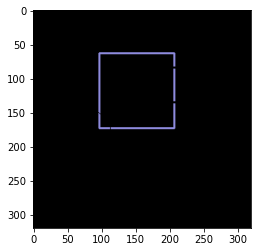

длина 179.65685415267944
длина 5.656854152679443
длина 23.656854152679443
длина 35.65685415267944
длина 5.656854152679443
длина 65.65685415267944
длина 87.65685415267944
длина 413.65685415267944
длина 31.656854152679443
длина 167.65685415267944
длина 213.65685415267944
длина 459.3137083053589
длина 103.65685415267944
длина 772.6274166107178
длина 98.0
длина 766.9705624580383
длина 257.899494767189
длина 95.65685415267944
длина 506.04163014888763
длина 66.2426404953003
длина 252.2426404953003
длина 90.0
длина 424.4852809906006
длина 179.65685415267944
длина 5.656854152679443
длина 23.656854152679443
длина 35.65685415267944
длина 5.656854152679443
длина 65.65685415267944
длина 87.65685415267944
длина 413.65685415267944
длина 31.656854152679443
длина 167.65685415267944
длина 213.65685415267944
длина 459.3137083053589
длина 103.65685415267944
длина 772.6274166107178
длина 98.0
длина 766.9705624580383
длина 257.899494767189
длина 95.65685415267944
длина 506.04163014888763
длина 66.242640495

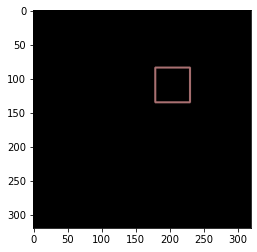

длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 191.3137083053589
длина 209.65685415267944
длина 193.65685415267944
длина 207.3137083053589
длина 196.97056198120117
длина 204.0
длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 191.3137083053589
длина 209.65685415267944
длина 196.97056245803833
длина 204.0
длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 191.3137083053589
длина 209.65685415267944
длина 196.97056245803833
длина 204.0
itogo 2


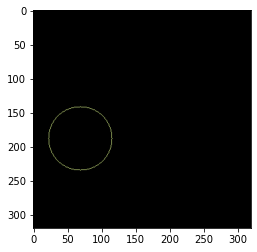

длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 288.73506450653076
длина 5.656854152679443
длина 5.656854152679443
длина 328.7350606918335
длина 301.4213533401489
длина 312.73506259918213
длина 90.62741661071777
длина 6.828427076339722
длина 6.828427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 6.828427076339722
длина 6.828427076339722
длина 90.62741661071777
длина 90.62741661071777
длина 6.828427076339722
длина 6.828427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 6.828427076339722
длина 6.828427076339722
длина 90.62741661071777
длина 288.73506450653076
длина 328.7350606918335
длина 301.4213533401489
длина 312.73506259918213
длина 307.0782070159912
длина 310.3919153213501
длина 288.73506450653076
длина 328.7350606918335
длина 307.0782070159912
длина 310.3919153213501
itogo 2


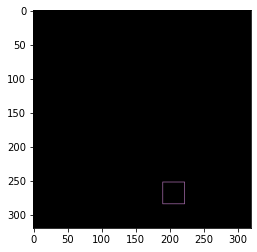

длина 103.31370830535889
длина 145.65685415267944
длина 117.65685415267944
длина 133.65685415267944
длина 123.31370830535889
длина 128.0
длина 103.31370830535889
длина 145.65685415267944
длина 117.65685415267944
длина 131.3137083053589
длина 104.97056245803833
длина 144.0
длина 117.65685415267944
длина 133.65685415267944
длина 120.97056198120117
длина 128.0
itogo 3


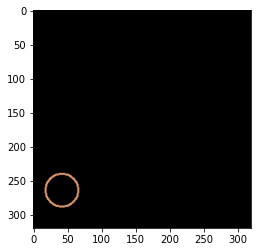

длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 137.5391025543213
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 180.8528118133545
длина 143.1959571838379
длина 174.61017179489136
длина 145.53910446166992
длина 172.26702547073364
длина 148.85281467437744
длина 167.1959571838379
длина 151.1959571838379
длина 167.19595766067505
длина 151.1959581375122
длина 165.43859958648682
длина 156.8528127670288
длина 161.53910338878632
длина 12.0
длина 19.899494767189026
длина 6.2426406145095825
длина 29.79898965358734
длина 19.899494767189026
длина 19.899494767189026
длина 12.0
длина 12.0
длина 29.79898965358734
длина 19.899494767189026
длина 53.94112503528595
длина 12.0
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
дли

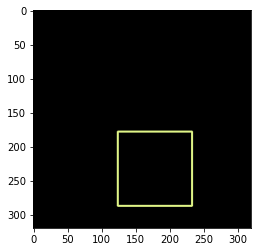

длина 211.65685415267944
длина 409.65685415267944
длина 211.65685415267944
длина 211.65685415267944
длина 211.65685415267944
длина 455.3137083053589
длина 415.3137083053589
длина 449.65685415267944
длина 417.65685415267944
длина 447.3137083053589
длина 420.9705619812012
длина 441.65685415267944
длина 423.3137083053589
длина 441.65685415267944
длина 425.65685415267944
длина 439.3137083053589
длина 428.97056245803833
длина 436.0
длина 431.3137083053589
длина 433.65685415267944
длина 211.65685415267944
длина 409.65685415267944
длина 211.65685415267944
длина 211.65685415267944
длина 211.65685415267944
длина 455.3137083053589
длина 415.3137083053589
длина 449.65685415267944
длина 417.65685415267944
длина 447.3137083053589
длина 420.9705619812012
длина 444.0
длина 423.3137083053589
длина 441.65685415267944
длина 425.65685415267944
длина 441.65685415267944
длина 425.65685415267944
длина 439.3137083053589
длина 428.9705619812012
длина 436.0
длина 431.3137083053589
длина 433.65685415267944
длин

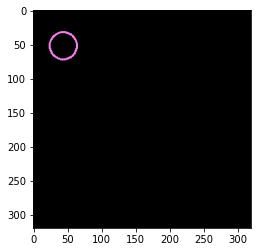

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 117.63960862159729
длина 147.88224983215332
длина 118.22539615631104
длина 145.53910446166992
длина 123.29646348953247
длина 142.22539567947388
длина 123.88224983215332
длина 139.88224983215332
длина 125.63960862159729
длина 139.88224983215332
длина 125.63960886001587
длина 137.53910398483276
длина 129.53910446166992
длина 134.22539567947388
длина 12.0
длина 0.0
длина 44.28427052497864
длина 32.62741672992706
длина 12.0
длина 12.0
длина 0.0
длина 0.0
длина 21.55634891986847
длина 32.62741672992706
длина 0.0
длина 12.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 118.22539615631104
длина 145.53910446166992
длина 123.88224983215332
длина 139.88224983215332
длина 125.63960886001587
длина 139.88224935531616
длина 131.2964634895

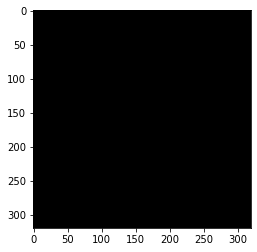

itogo 4
train_data/20.png


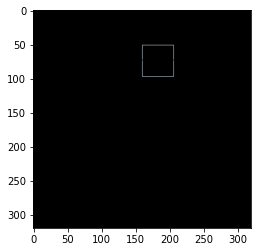

длина 73.65685415267944
длина 29.656854152679443
длина 29.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 160.97056245803833
длина 73.65685415267944
длина 206.62741661071777
длина 175.3137083053589
длина 191.3137083053589
длина 177.65685415267944
длина 169.65685415267944
длина 160.1421353816986
длина 202.48528122901917
длина 175.3137083053589
длина 191.3137083053589
длина 177.65685415267944
длина 169.65685415267944
длина 160.1421353816986
длина 202.48528122901917
длина 173.65685415267944
длина 189.65685415267944
длина 177.65685415267944
длина 169.65685415267944
itogo 1


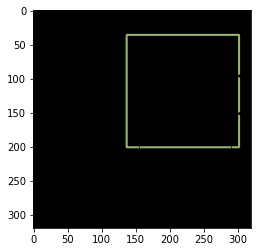

длина 13.656854152679443
длина 5.656854152679443
длина 259.65685415267944
длина 5.656854152679443
длина 29.656854152679443
длина 87.65685415267944
длина 93.65685415267944
длина 635.3137083053589
длина 109.65685415267944
длина 323.65685415267944
длина 323.65685415267944
длина 680.9705624580383
длина 110.82842707633972
длина 1202.6274166107178
длина 106.82842707633972
длина 1194.6274161338806
длина 102.82842707633972
длина 1197.9411249160767
длина 263.65685415267944
длина 109.89949476718903
длина 97.65685415267944
длина 804.3847759962082
длина 258.0
длина 104.24264061450958
длина 92.0
длина 798.7279218435287
длина 13.656854152679443
длина 5.656854152679443
длина 259.65685415267944
длина 5.656854152679443
длина 29.656854152679443
длина 87.65685415267944
длина 93.65685415267944
длина 635.3137083053589
длина 109.65685415267944
длина 323.65685415267944
длина 323.65685415267944
длина 680.9705624580383
длина 110.82842707633972
длина 1202.6274166107178
длина 108.48528122901917
длина 1201.941124

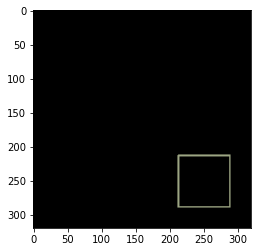

длина 277.0710676908493
длина 145.65685415267944
длина 145.65685415267944
длина 319.899494767189
длина 285.65685415267944
длина 313.0710676908493
длина 288.9705619812012
длина 307.41421353816986
длина 291.3137083053589
длина 305.65685415267944
длина 3.414213538169861
длина 303.899494767189
длина 301.0710676908493
длина 277.0710676908493
длина 145.65685415267944
длина 145.65685415267944
длина 319.899494767189
длина 285.65685415267944
длина 313.0710676908493
длина 288.9705619812012
длина 308.0
длина 291.3137083053589
длина 305.65685415267944
длина 9.071067690849304
длина 310.72792184352875
длина 301.65685415267944
длина 277.0710676908493
длина 145.65685415267944
длина 145.65685415267944
длина 319.899494767189
длина 285.65685415267944
длина 313.0710676908493
длина 291.3137083053589
длина 307.41421353816986
длина 293.65685415267944
длина 305.0710676908493
длина 301.65685415267944
itogo 3


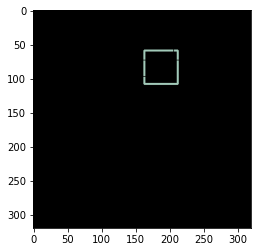

длина 91.65685415267944
длина 13.656854152679443
длина 5.656854152679443
длина 61.65685415267944
длина 37.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 169.65685415267944
длина 19.656854152679443
длина 19.656854152679443
длина 5.656854152679443
длина 77.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 180.97056198120117
длина 204.0
длина 186.62741661071777
длина 204.97056245803833
длина 184.1421353816986
длина 45.65685415267944
длина 35.899494767189026
длина 109.89949476718903
длина 179.65685415267944
длина 40.0
длина 30.82842707633972
длина 104.82842707633972
длина 91.65685415267944
длина 13.656854152679443
длина 5.656854152679443
длина 61.65685415267944
длина 37.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 169.65685415267944
длина 19.656854152679443
длина 19.656854152679443
длина 5.656854152679443
длина 77.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589


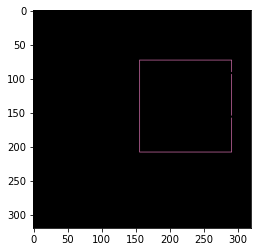

длина 251.65685415267944
длина 83.65685415267944
длина 105.65685415267944
длина 17.656854152679443
длина 251.65685415267944
длина 516.9705624580383
длина 251.65685415267944
длина 562.6274166107178
длина 124.0
длина 943.3137083053589
длина 121.65685415267944
длина 938.6274166107178
длина 112.0
длина 931.3137083053589
длина 518.6274166107178
длина 559.3137083053589
длина 121.65685415267944
длина 938.6274166107178
длина 516.9705624580383
длина 557.6568541526794
длина 124.0
длина 943.3137083053589
длина 116.0
длина 935.3137083053589
itogo 5


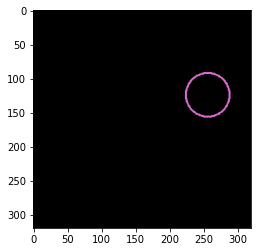

длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 192.1665199995041
длина 5.656854152679443
длина 21.656854152679443
длина 233.13708305358887
длина 197.8233745098114
длина 227.48022842407227
длина 200.16652035713196
длина 225.13708209991455
длина 203.4802303314209
длина 221.82337379455566
длина 205.8233745098114
длина 219.48022842407227
длина 205.82337498664856
длина 219.48022747039795
длина 211.48022866249084
длина 213.82337379455566
длина 40.485281229019165
длина 4.828427076339722
длина 6.828427076339722
длина 2.8284270763397217
длина 5.656854152679443
длина 6.828427076339722
длина 6.828427076339722
длина 40.485281229019165
длина 40.485281229019165
длина 4.828427076339722
длина 4.828427076339722
длина 15.313708305358887
длина 15.313708305358887
длина 5.656854152679443
длина 6.828427076339722
длина 2.8284270763397217
длина 4.828427076339722
длина 40.485281229019165
длина 21.656854152

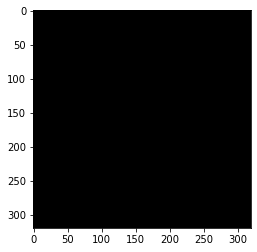

itogo 5
train_data/21.png


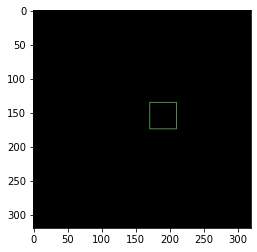

длина 131.3137083053589
длина 173.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 131.3137083053589
длина 173.65685415267944
длина 145.65685415267944
длина 161.65685415267944
длина 148.97056198120117
длина 162.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 129.65685415267944
длина 59.65685415267944
длина 175.3137083053589
длина 148.97056198120117
длина 162.62741661071777
itogo 1


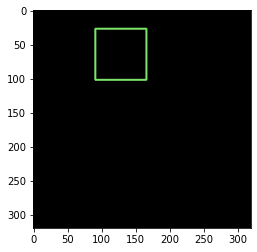

длина 143.65685415267944
длина 273.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 319.3137083053589
длина 281.65685415267944
длина 311.3137083053589
длина 287.3137083053589
длина 305.65685415267944
длина 289.65685415267944
длина 303.3137083053589
длина 295.3137083053589
длина 297.65685415267944
длина 143.65685415267944
длина 273.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 319.3137083053589
длина 279.3137083053589
длина 313.65685415267944
длина 281.65685415267944
длина 311.3137083053589
длина 284.9705619812012
длина 305.65685415267944
длина 287.3137083053589
длина 305.65685415267944
длина 289.65685415267944
длина 303.3137083053589
длина 292.97056245803833
длина 300.0
длина 295.3137083053589
длина 300.0
длина 143.65685415267944
длина 273.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 319.3137083053589
длина 281.65685415267944
длина 311.3137

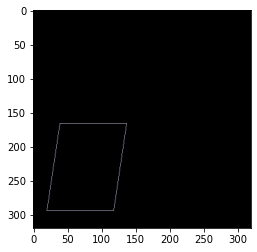

длина 443.39696860313416
длина 484.56854152679443
длина 457.39696860313416
длина 471.0538227558136
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 444.2253956794739
длина 483.7401144504547
длина 457.39696860313416
длина 471.0538227558136
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 177.65685415267944
длина 442.56854152679443
длина 177.65685415267944
длина 485.39696860313416
длина 457.39696860313416
длина 473.39696860313416
длина 201.65685415267944
длина 8.0
длина 8.0
длина 6.0
длина 6.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 6.0
длина 6.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 6.0
длина 6.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 6.0
длина 6.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 6.0
длина 6.0
длина 8.0
длина 8.0
длина 201.65685415267944
itogo 2


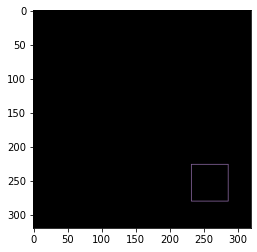

длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 189.65685415267944
длина 89.65685415267944
длина 235.3137083053589
длина 205.65685415267944
длина 221.65685415267944
длина 211.3137083053589
длина 216.0
длина 192.97056245803833
длина 232.0
длина 205.65685415267944
длина 219.3137083053589
длина 192.97056245803833
длина 232.0
длина 205.65685415267944
длина 221.65685415267944
длина 208.97056198120117
длина 216.0
itogo 3


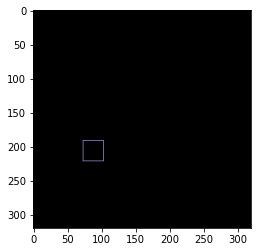

длина 95.31370830535889
длина 137.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 125.65685415267944
длина 112.97056198120117
длина 120.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 4


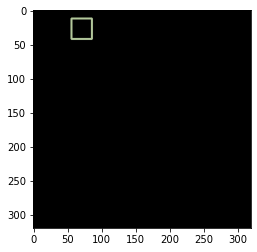

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 112.97056198120117
длина 120.0
длина 115.31370830535889
длина 117.65685415267944
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 112.97056198120117
длина 120.0
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.313708305358

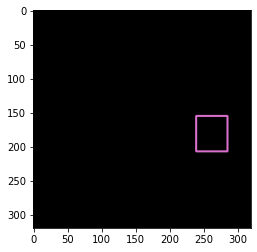

длина 85.65685415267944
длина 169.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 85.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 188.97056198120117
длина 196.0
длина 191.3137083053589
длина 193.65685415267944
длина 85.65685415267944
длина 169.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 85.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 188.97056245803833
длина 196.0
длина 85.65685415267944
длина 169.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 85.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 207.3137083053589
д

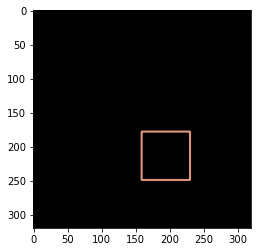

длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 263.3137083053589
длина 297.65685415267944
длина 265.65685415267944
длина 295.3137083053589
длина 268.9705619812012
длина 289.65685415267944
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 276.97056245803833
длина 284.0
длина 279.3137083053589
длина 284.0
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 268.9705619812012
длина 289.65685415267944
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 279.3137083053589
длина 281.65685415267944
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137

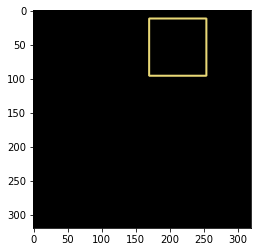

длина 161.65685415267944
длина 309.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 355.3137083053589
длина 315.3137083053589
длина 349.65685415267944
длина 317.65685415267944
длина 347.3137083053589
длина 320.9705619812012
длина 341.65685415267944
длина 323.3137083053589
длина 341.65685415267944
длина 325.65685415267944
длина 339.3137083053589
длина 325.65685415267944
длина 339.3137083053589
длина 328.9705619812012
длина 336.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 161.65685415267944
длина 309.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 355.3137083053589
длина 317.65685415267944
длина 347.3137083053589
длина 317.65685415267944
длина 347.3137083053589
длина 323.3137083053589
длина 341.65685415267944
длина 323.3137083053589
длина 341.65685415267944
длина 325.65685415267944
длина 339.3137083053589
длина 328.9705619812012
длина 3

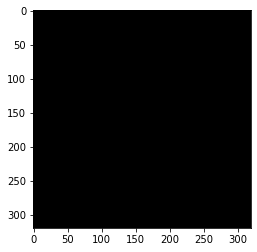

itogo 7
train_data/22.png


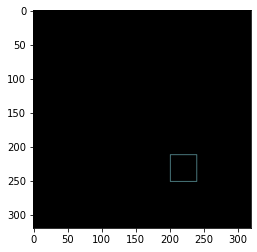

длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 129.65685415267944
длина 59.65685415267944
длина 175.3137083053589
длина 148.97056198120117
длина 162.62741661071777
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 129.65685415267944
длина 59.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 161.65685415267944
длина 151.3137083053589
длина 156.0
длина 131.3137083053589
длина 173.65685415267944
длина 145.65685415267944
длина 161.65685415267944
длина 151.3137083053589
длина 156.0
itogo 1


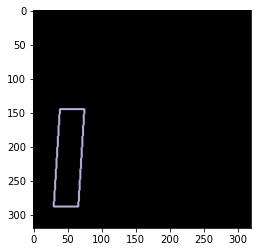

длина 65.65685415267944
длина 9.656854152679443
длина 9.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 339.11269783973694
длина 9.656854152679443
длина 9.656854152679443
длина 65.65685415267944
длина 384.7695519924164
длина 347.11269783973694
длина 376.7695519924164
длина 347.11269783973694
длина 376.7695519924164
длина 352.7695519924164
длина 371.11269783973694
длина 355.11269783973694
длина 368.7695519924164
длина 358.42640566825867
длина 365.4558436870575
длина 88.48528122901917
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 22.0
длина 

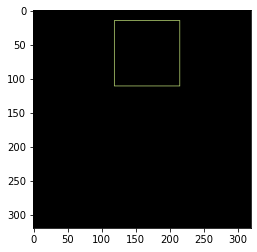

длина 359.3137083053589
длина 401.65685415267944
длина 373.65685415267944
длина 389.65685415267944
длина 376.9705619812012
длина 384.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 360.97056245803833
длина 400.0
длина 371.3137083053589
длина 389.65685415267944
длина 373.65685415267944
длина 387.3137083053589
длина 379.3137083053589
длина 384.0
длина 359.3137083053589
длина 401.65685415267944
длина 373.65685415267944
длина 387.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


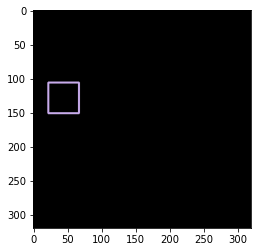

длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 167.3137083053589
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 175.3137083053589
длина 180.0
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 172.97056198120117
длина 180.0
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.65685415267944
дл

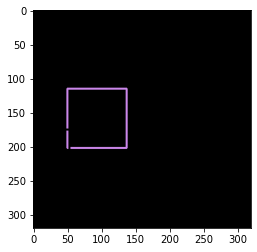

длина 157.65685415267944
длина 43.65685415267944
длина 324.72792184352875
длина 167.65685415267944
длина 109.65685415267944
длина 167.65685415267944
длина 369.79898953437805
длина 61.071067690849304
длина 632.3847759962082
длина 58.485281229019165
длина 630.0416301488876
длина 55.41421353816986
длина 626.7279218435287
длина 52.82842707633972
длина 624.3847759962082
длина 50.82842707633972
длина 622.7279218435287
длина 46.0
длина 618.7279214859009
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 157.65685415267944
длина 43.65685415267944
длина 323.0710676908493
длина 167.65685415267944
длина 109.65685415267944
длина 167.65685415267944
длина 367.3137083053589
длина 61.071067690849304
длина 632.3847759962082
длина 55.41421353816986
длина 626.7279218435287
длина 52.24264061450958
длина 624.3847759962082
длина 46.0
длина 618.7279214859009
длина 157.65685415267944
длина 43.65685415267944
длина 323.0710676908493
длина 167.65685415267944
длина 109.65685415267944

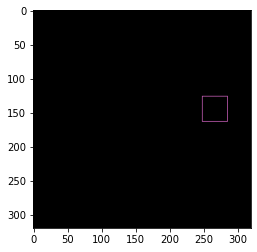

длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 55.65685415267944
длина 55.65685415267944
длина 59.65685415267944
длина 121.65685415267944
длина 59.65685415267944
длина 167.3137083053589
длина 140.97056198120117
длина 148.0
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 140.97056198120117
длина 148.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


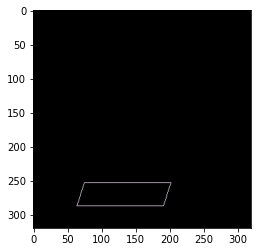

длина 304.7695519924164
длина 345.94112491607666
длина 317.94112491607666
длина 336.7695519924164
длина 319.11269783973694
длина 332.7695519924164
длина 0.0
длина 259.65685415267944
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 259.65685415267944
длина 303.94112491607666
длина 346.7695519924164
длина 317.94112491607666
длина 336.7695519924164
длина 323.5979790687561
длина 334.4264061450958
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 235.65685415267944
длина 303.11269783973694
длина 235.65685415267944
длина 347.5979790687561
длина 317.94112491607666
длина 336.7695519924164
длина 319.11269783973694
длина 332.7695519924164
длина 324.7695519924164
длина 331.11269783973694
itogo 5


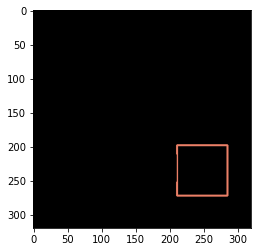

длина 141.65685415267944
длина 35.65685415267944
длина 269.65685415267944
длина 141.65685415267944
длина 21.656854152679443
длина 141.65685415267944
длина 316.1421353816986
длина 275.3137083053589
длина 310.48528122901917
длина 277.65685415267944
длина 308.1421353816986
длина 280.9705619812012
длина 302.48528122901917
длина 283.3137083053589
длина 302.48528122901917
длина 285.65685415267944
длина 300.1421353816986
длина 508.6274166107178
длина 502.9705619812012
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 141.65685415267944
длина 35.65685415267944
длина 269.65685415267944
длина 141.65685415267944
длина 21.656854152679443
длина 141.65685415267944
длина 316.1421353816986
длина 277.65685415267944
длина 308.1421353816986
длина 283.3137083053589
длина 302.48528122901917
длина 285.65685415267944
длина 300.1421353816986
длина 498.97056245803833
длина 141.65685415267944
длина 35.65685415267944
длина 269.65685415267944
длина 141.65685

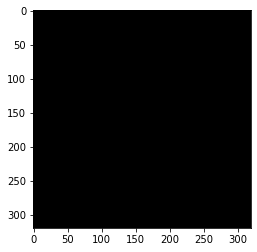

itogo 6
train_data/23.png


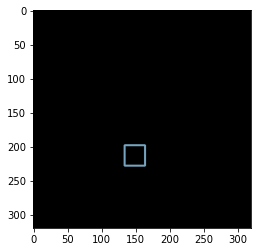

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 104.97056198120117
длина 128.0
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 101.65685415267944
длина 131.313708305358

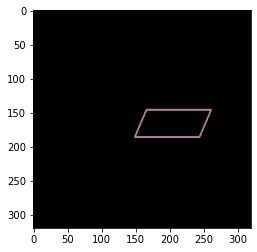

длина 185.65685415267944
длина 5.656854152679443
длина 253.25483322143555
длина 5.656854152679443
длина 185.65685415267944
длина 301.7401144504547
длина 261.25483322143555
длина 295.39696860313416
длина 265.25483322143555
длина 293.7401144504547
длина 268.0832600593567
длина 289.7401144504547
длина 272.08326029777527
длина 285.74011421203613
длина 273.74011421203613
длина 284.08326029777527
длина 188.82842707633972
длина 188.82842707633972
длина 185.65685415267944
длина 5.656854152679443
длина 253.25483322143555
длина 5.656854152679443
длина 185.65685415267944
длина 301.7401144504547
длина 264.08326029777527
длина 293.7401144504547
длина 268.08326029777527
длина 289.7401144504547
длина 272.08326029777527
длина 285.7401144504547
длина 193.65685415267944
длина 193.65685415267944
длина 185.65685415267944
длина 5.656854152679443
длина 253.25483322143555
длина 5.656854152679443
длина 185.65685415267944
длина 301.7401144504547
длина 261.25483322143555
длина 293.7401144504547
длина 266.911687

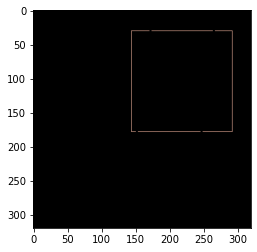

длина 572.2842707633972
длина 614.6274166107178
длина 186.0
длина 433.65685415267944
длина 182.0
длина 361.65685415267944
длина 178.0
длина 424.4852809906006
длина 174.0
длина 352.4852809906006
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 570.6274166107178
длина 612.9705624580383
длина 183.65685415267944
длина 431.3137083053589
длина 179.65685415267944
длина 359.3137083053589
длина 174.0
длина 421.65685415267944
длина 170.0
длина 349.65685415267944
длина 71.65685415267944
длина 171.65685415267944
длина 277.65685415267944
длина 277.65685415267944
длина 568.9705624580383
длина 35.65685415267944
длина 167.65685415267944
длина 37.65685415267944
длина 613.798989534378
длина 183.65685415267944
длина 430.1421353816986
длина 179.65685415267944
длина 358.1421353816986
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


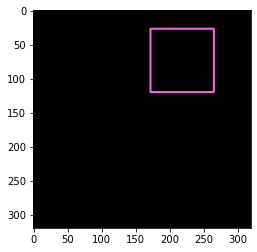

длина 179.65685415267944
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 391.3137083053589
длина 351.3137083053589
длина 385.65685415267944
длина 353.65685415267944
длина 383.3137083053589
длина 356.9705619812012
длина 380.0
длина 359.3137083053589
длина 377.65685415267944
длина 361.65685415267944
длина 377.65685415267944
длина 361.65685415267944
длина 375.3137083053589
длина 364.9705619812012
длина 372.0
длина 367.3137083053589
длина 369.65685415267944
длина 179.65685415267944
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 391.3137083053589
длина 353.65685415267944
длина 383.3137083053589
длина 359.3137083053589
длина 377.65685415267944
длина 364.9705619812012
длина 372.0
длина 179.65685415267944
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 391.3137083053589
длина 351.3137083053589
длина 385.65685415267944
дли

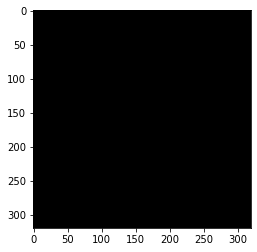

itogo 3
train_data/24.png


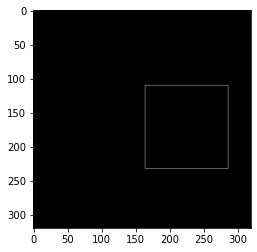

длина 463.3137083053589
длина 505.65685415267944
длина 477.65685415267944
длина 493.65685415267944
длина 483.3137083053589
длина 488.0
длина 225.65685415267944
длина 225.65685415267944
длина 225.65685415267944
длина 461.65685415267944
длина 225.65685415267944
длина 507.3137083053589
длина 477.65685415267944
длина 493.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 463.3137083053589
длина 505.65685415267944
длина 477.65685415267944
длина 491.3137083053589
itogo 1


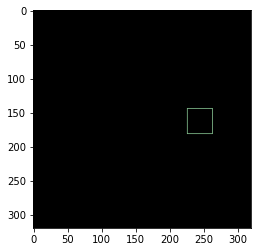

длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 143.3137083053589
длина 148.0
длина 123.31370830535889
длина 165.65685415267944
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 123.31370830535889
длина 165.65685415267944
длина 137.65685415267944
длина 153.65685415267944
длина 143.3137083053589
длина 148.0
itogo 2


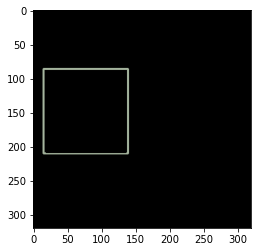

длина 470.48528122901917
длина 241.65685415267944
длина 241.65685415267944
длина 241.65685415267944
длина 515.3137083053589
длина 478.48528122901917
длина 507.3137083053589
длина 482.97056221961975
длина 504.0
длина 484.72792172431946
длина 501.65685415267944
длина 756.6274166107178
длина 749.3137083053589
длина 470.48528122901917
длина 241.65685415267944
длина 241.65685415267944
длина 241.65685415267944
длина 515.3137083053589
длина 478.48528122901917
длина 507.3137083053589
длина 479.65685415267944
длина 507.3137083053589
длина 484.14213514328003
длина 501.65685415267944
длина 486.48528122901917
длина 499.3137083053589
длина 747.5563485622406
длина 743.5563489198685
длина 470.48528122901917
длина 241.65685415267944
длина 241.65685415267944
длина 241.65685415267944
длина 515.3137083053589
длина 478.48528122901917
длина 507.3137083053589
длина 482.97056221961975
длина 501.65685415267944
длина 484.72792172431946
длина 501.65685415267944
длина 752.6274166107178
длина 743.5563489198685
it

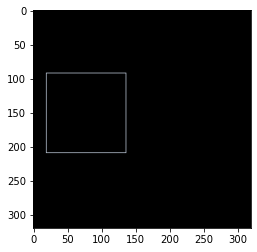

длина 215.65685415267944
длина 215.65685415267944
длина 215.65685415267944
длина 441.65685415267944
длина 215.65685415267944
длина 487.3137083053589
длина 457.65685415267944
длина 473.65685415267944
длина 460.9705619812012
длина 468.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 444.97056245803833
длина 484.0
длина 457.65685415267944
длина 473.65685415267944
длина 457.65685415267944
длина 471.3137083053589
длина 463.3137083053589
длина 468.0
длина 444.97056245803833
длина 484.0
длина 455.3137083053589
длина 473.65685415267944
длина 457.65685415267944
длина 471.3137083053589
длина 463.3137083053589
длина 468.0
itogo 4


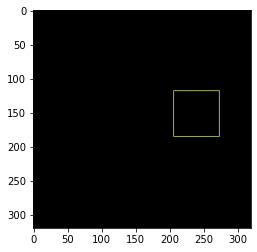

длина 243.3137083053589
длина 285.65685415267944
длина 255.3137083053589
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 241.65685415267944
длина 115.65685415267944
длина 287.3137083053589
длина 255.3137083053589
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 243.3137083053589
длина 285.65685415267944
длина 257.65685415267944
длина 273.65685415267944
длина 263.3137083053589
длина 268.0
itogo 5


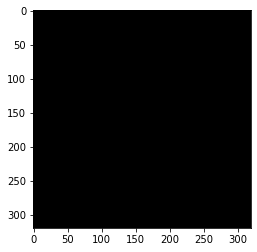

itogo 5
train_data/25.png


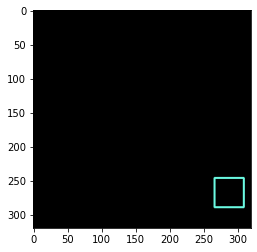

длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 164.97056198120117
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 151.3137083053589
длина 185.65685415267944
длина 153.65685415267944
длина 183.3137083053589
длина 156.97056198120117
длина 180.0
длина 159.3137083053589
длина 177.65685415267944
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 164.97056198120117
длина 172.0
длина 167.3137083053589
длина 169.65685415267944
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 151.3137083053589
длина 185.65685415267944
длина 153.656

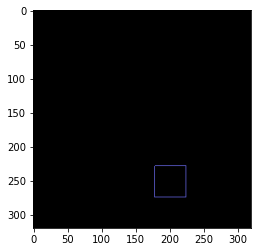

длина 73.65685415267944
длина 73.65685415267944
длина 77.65685415267944
длина 157.65685415267944
длина 77.65685415267944
длина 202.72792184352875
длина 173.65685415267944
длина 186.72792184352875
длина 73.65685415267944
длина 73.65685415267944
длина 77.65685415267944
длина 157.65685415267944
длина 77.65685415267944
длина 202.72792184352875
длина 173.65685415267944
длина 186.72792184352875
длина 160.97056245803833
длина 199.41421353816986
длина 171.3137083053589
длина 189.0710676908493
длина 173.65685415267944
длина 187.3137083053589
длина 179.3137083053589
длина 183.41421353816986
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


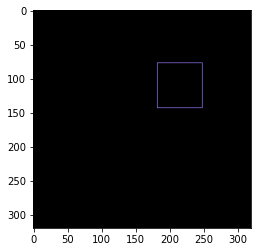

длина 240.97056245803833
длина 280.0
длина 253.65685415267944
длина 269.65685415267944
длина 259.3137083053589
длина 264.0
длина 240.97056245803833
длина 280.0
длина 253.65685415267944
длина 267.3137083053589
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 237.65685415267944
длина 113.65685415267944
длина 283.3137083053589
длина 251.3137083053589
длина 269.65685415267944
длина 253.65685415267944
длина 267.3137083053589
длина 259.3137083053589
длина 264.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 3


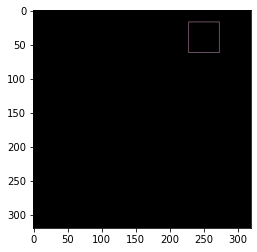

длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 153.65685415267944
длина 71.65685415267944
длина 199.3137083053589
длина 169.65685415267944
длина 185.65685415267944
длина 175.3137083053589
длина 180.0
длина 155.3137083053589
длина 197.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 155.3137083053589
длина 197.65685415267944
длина 169.65685415267944
длина 185.65685415267944
длина 175.3137083053589
длина 180.0
itogo 4


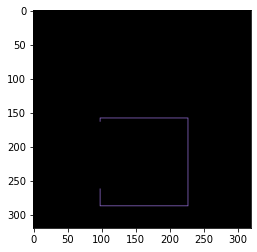

длина 842.9705624580383
длина 833.3137083053589
длина 825.3137083053589
длина 842.9705624580383
длина 828.6274166107178
длина 842.9705624580383
длина 832.6274166107178
длина 828.6274166107178
длина 825.3137083053589
itogo 5


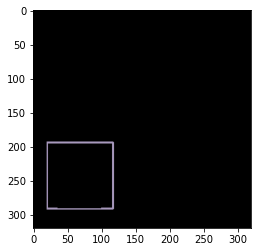

длина 29.656854152679443
длина 25.656854152679443
длина 362.48528122901917
длина 187.65685415267944
длина 187.65685415267944
длина 405.3137083053589
длина 370.48528122901917
длина 398.48528122901917
длина 370.48528122901917
длина 397.3137083053589
длина 376.1421353816986
длина 392.8284270763397
длина 378.48528122901917
длина 390.48528122901917
длина 29.41421353816986
длина 417.89949452877045
длина 29.656854152679443
длина 25.656854152679443
длина 362.48528122901917
длина 187.65685415267944
длина 187.65685415267944
длина 405.3137083053589
длина 370.48528122901917
длина 398.48528122901917
длина 373.7989890575409
длина 392.8284270763397
длина 376.1421353816986
длина 391.65685415267944
длина 33.65685415267944
длина 422.1421353816986
длина 26.0
длина 414.48528122901917
длина 29.656854152679443
длина 25.656854152679443
длина 362.48528122901917
длина 187.65685415267944
длина 187.65685415267944
длина 405.3137083053589
длина 370.48528122901917
длина 398.48528122901917
длина 370.48528122901917
д

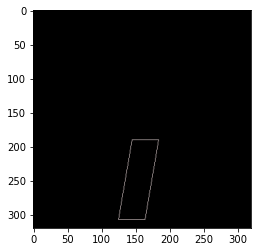

длина 305.0538227558136
длина 343.39696860313416
длина 315.39696860313416
длина 334.2253956794739
длина 321.053822517395
длина 328.56854152679443
длина 59.65685415267944
длина 303.39696860313416
длина 59.65685415267944
длина 346.2253956794739
длина 315.39696860313416
длина 334.2253956794739
длина 322.2253954410553
длина 328.56854152679443
длина 59.65685415267944
длина 303.39696860313416
длина 59.65685415267944
длина 346.2253956794739
длина 315.39696860313416
длина 334.2253956794739
длина 322.2253954410553
длина 328.56854152679443
itogo 6


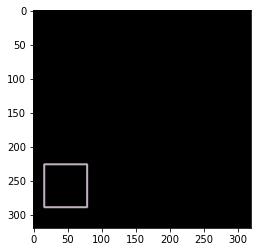

длина 119.65685415267944
длина 225.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 271.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 247.3137083053589
длина 249.65685415267944
длина 119.65685415267944
длина 225.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 271.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 244.97056198120117
длина 252.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 119.65685415267944
длина 225.65685415267944
длина 119.65685415267944

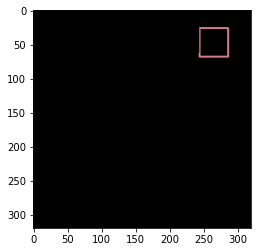

длина 77.65685415267944
длина 5.656854152679443
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 186.72792184352875
длина 149.65685415267944
длина 179.3137083053589
длина 149.65685415267944
длина 178.72792184352875
длина 155.3137083053589
длина 173.65685415267944
длина 155.3137083053589
длина 173.0710676908493
длина 157.65685415267944
длина 171.3137083053589
длина 256.14213502407074
длина 248.72792184352875
длина 77.65685415267944
длина 5.656854152679443
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 186.72792184352875
длина 149.65685415267944
длина 178.72792184352875
длина 155.3137083053589
длина 173.65685415267944
длина 265.79898953437805
длина 252.72792184352875
длина 77.65685415267944
длина 5.656854152679443
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 186.72792184352875
длина 149.65685415267944
длина 179.3137083053589
длина 155.3137083053589
длина 173.65685415267944
длина 157.6568541526

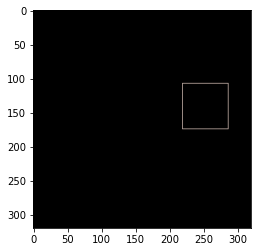

длина 243.3137083053589
длина 285.65685415267944
длина 255.3137083053589
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 241.65685415267944
длина 115.65685415267944
длина 287.3137083053589
длина 257.65685415267944
длина 273.65685415267944
длина 260.9705619812012
длина 268.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 243.3137083053589
длина 285.65685415267944
длина 257.65685415267944
длина 273.65685415267944
длина 260.9705619812012
длина 268.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 9


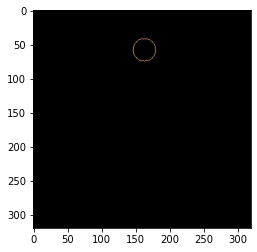

длина 90.91168689727783
длина 128.56854152679443
длина 103.5979790687561
длина 118.22539520263672
длина 109.25483322143555
длина 112.56854057312012
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 90.91168689727783
длина 128.56854152679443
длина 101.25483226776123
длина 114.91168642044067
длина 4.0
длина 4.0
длина 0.0
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 0.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 0.0
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 0.0
длина 4.0
длина 4.0
длина 90.91168689727783
длина 128.56854152679443
длина 104.56854057312012
длина 114.91168737411499
itogo 9


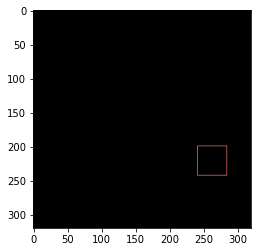

длина 67.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 145.65685415267944
длина 67.65685415267944
длина 191.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 172.0
длина 67.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 145.65685415267944
длина 67.65685415267944
длина 191.3137083053589
длина 161.65685415267944
длина 175.3137083053589
длина 147.3137083053589
длина 189.65685415267944
длина 161.65685415267944
длина 175.3137083053589
itogo 10


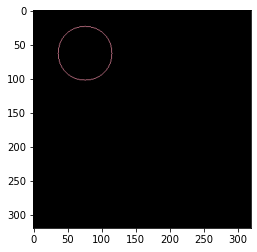

длина 242.10764503479004
длина 282.10764598846436
длина 254.79393768310547
длина 269.4213533401489
длина 260.45079135894775
длина 268.45079040527344
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 242.10764503479004
длина 282.10764598846436
длина 258.1076469421387
длина 266.107647895813
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 242.10764503479004
длина 282.10764598846436
длина 254.79393863677979
длина 266.107647895813
длина 88.28427076339722
длина 88.28427076339722
длина 88.28427076339722
длина 88.28427076339722
itogo 10


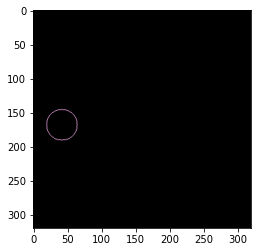

длина 129.53910541534424
длина 169.53910398483276
длина 139.882248878479
длина 159.1959581375122
длина 145.53910446166992
длина 153.5391035079956
длина 47.31370830535889
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 47.31370830535889
длина 47.31370830535889
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 47.31370830535889
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539520263672
длина 153.53910446166992
длина 47.31370830535889
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 47.31370830535889
длина 47.31370830535889
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 47.31370830535889
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539567947388
длина 156.85281372070312
длина 145.53910446166992
длина 155.88224983215332
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
itogo 10


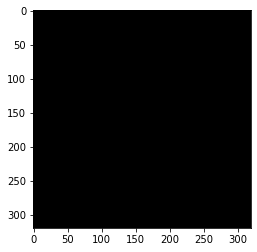

itogo 10
train_data/26.png


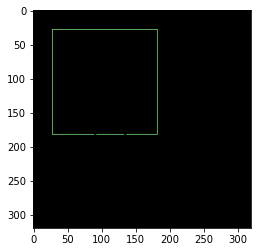

длина 594.6274166107178
длина 633.6568541526794
длина 81.65685415267944
длина 1130.6274166107178
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 594.6274166107178
длина 633.6568541526794
длина 85.65685415267944
длина 1134.6274166107178
длина 81.65685415267944
длина 1130.6274166107178
длина 76.0
длина 1127.313708305359
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 594.6274166107178
длина 633.6568541526794
длина 81.65685415267944
длина 1130.6274166107178
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


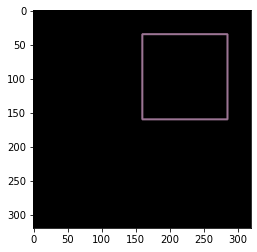

длина 243.65685415267944
длина 473.65685415267944
длина 243.65685415267944
длина 243.65685415267944
длина 243.65685415267944
длина 519.3137083053589
длина 481.65685415267944
длина 511.3137083053589
длина 484.9705619812012
длина 505.65685415267944
длина 487.3137083053589
длина 505.65685415267944
длина 489.65685415267944
длина 503.3137083053589
длина 495.3137083053589
длина 497.65685415267944
длина 243.65685415267944
длина 473.65685415267944
длина 243.65685415267944
длина 243.65685415267944
длина 243.65685415267944
длина 519.3137083053589
длина 481.65685415267944
длина 511.3137083053589
длина 487.3137083053589
длина 505.65685415267944
длина 489.65685415267944
длина 503.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 243.65685415267944
длина 473.65685415267944
длина 243.65685415267944
длина 243.65685415267944
длина 243.65685415267944
длина 519.3137083053589
длина 481.65685415267944
длина 511.3137083053589
длина 487.31

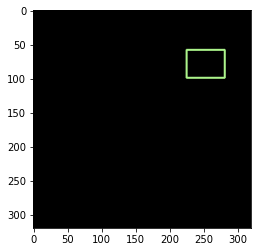

длина 105.65685415267944
длина 167.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 105.65685415267944
длина 213.3137083053589
длина 175.65685415267944
длина 205.3137083053589
длина 175.65685415267944
длина 205.3137083053589
длина 181.3137083053589
длина 199.65685415267944
длина 183.65685415267944
длина 197.3137083053589
длина 186.97056198120117
длина 194.0
длина 105.65685415267944
длина 167.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 105.65685415267944
длина 213.3137083053589
длина 173.3137083053589
длина 207.65685415267944
длина 175.65685415267944
длина 205.3137083053589
длина 178.97056198120117
длина 202.0
длина 181.3137083053589
длина 199.65685415267944
длина 183.65685415267944
длина 199.65685415267944
длина 183.65685415267944
длина 197.3137083053589
длина 186.97056198120117
длина 194.0
длина 189.3137083053589
длина 191.65685415267944
длина 105.65685415267944
длина 167.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 

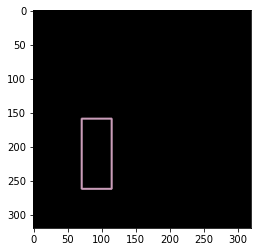

длина 81.65685415267944
длина 267.65685415267944
длина 199.65685415267944
длина 199.65685415267944
длина 81.65685415267944
длина 313.3137083053589
длина 275.65685415267944
длина 305.3137083053589
длина 275.65685415267944
длина 305.3137083053589
длина 281.3137083053589
длина 299.65685415267944
длина 281.3137083053589
длина 299.65685415267944
длина 283.65685415267944
длина 297.3137083053589
длина 286.9705619812012
длина 294.0
длина 81.65685415267944
длина 267.65685415267944
длина 199.65685415267944
длина 199.65685415267944
длина 81.65685415267944
длина 313.3137083053589
длина 275.65685415267944
длина 305.3137083053589
длина 278.9705619812012
длина 299.65685415267944
длина 281.3137083053589
длина 299.65685415267944
длина 283.65685415267944
длина 297.3137083053589
длина 289.3137083053589
длина 291.65685415267944
длина 81.65685415267944
длина 267.65685415267944
длина 199.65685415267944
длина 199.65685415267944
длина 81.65685415267944
длина 313.3137083053589
длина 275.65685415267944
длина 30

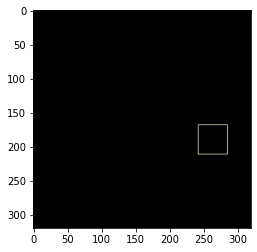

длина 67.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 145.65685415267944
длина 67.65685415267944
длина 191.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 172.0
длина 147.3137083053589
длина 189.65685415267944
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 172.0
длина 147.3137083053589
длина 189.65685415267944
длина 161.65685415267944
длина 177.65685415267944
длина 167.3137083053589
длина 172.0
itogo 3


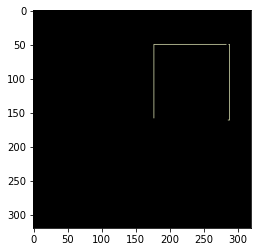

длина 203.65685415267944
длина 199.65685415267944
длина 195.65685415267944
длина 676.1421353816986
длина 231.89949476718903
длина 431.899494767189
длина 227.0710676908493
длина 427.899494767189
длина 223.41421353816986
длина 422.8284270763397
длина 674.4852812290192
длина 231.89949476718903
длина 431.899494767189
длина 227.0710676908493
длина 427.899494767189
длина 224.24264061450958
длина 422.8284270763397
длина 0.0
длина 2.8284270763397217
длина 675.3137083053589
длина 231.0710676908493
длина 430.8284270763397
длина 226.24264061450958
длина 422.2426404953003
длина 2.8284270763397217
длина 0.0
длина 3.414213538169861
itogo 4


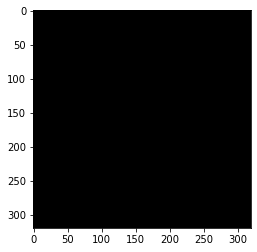

itogo 4
train_data/27.png


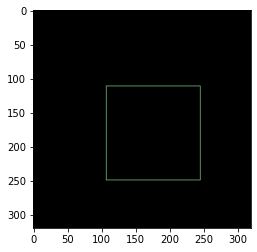

длина 527.3137083053589
длина 569.6568541526794
длина 541.6568541526794
длина 555.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 527.3137083053589
длина 569.6568541526794
длина 541.6568541526794
длина 557.6568541526794
длина 541.6568541526794
длина 555.3137083053589
длина 547.3137083053589
длина 552.0
длина 257.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 525.6568541526794
длина 257.65685415267944
длина 571.3137083053589
длина 541.6568541526794
длина 557.6568541526794
длина 547.3137083053589
длина 552.0
itogo 1


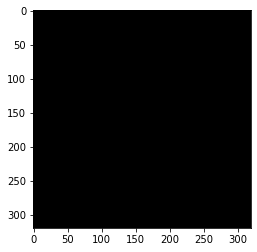

itogo 1
train_data/28.png


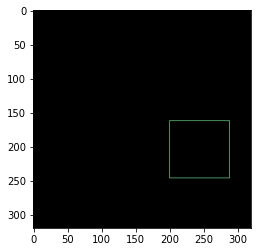

длина 320.97056245803833
длина 360.0
длина 336.9705619812012
длина 344.0
длина 319.3137083053589
длина 361.65685415267944
длина 333.65685415267944
длина 349.65685415267944
длина 336.9705619812012
длина 350.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 319.3137083053589
длина 361.65685415267944
длина 333.65685415267944
длина 349.65685415267944
длина 339.3137083053589
длина 344.0
itogo 0


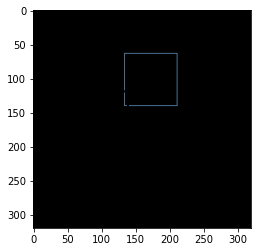

длина 284.97056245803833
длина 328.1421353816986
длина 43.899494767189026
длина 552.3847759962082
длина 284.72792184352875
длина 326.48528122901917
длина 46.82842707633972
длина 556.4852812290192
длина 38.82842707633972
длина 548.4852812290192
длина 285.79898953437805
длина 325.65685415267944
длина 46.82842707633972
длина 556.4852812290192
длина 43.899494767189026
длина 552.3847759962082
длина 36.82842707633972
длина 544.4852812290192
itogo 1


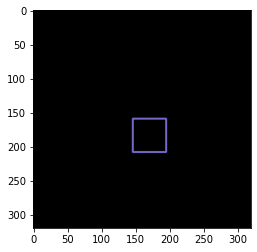

длина 91.65685415267944
длина 169.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 191.3137083053589
длина 193.65685415267944
длина 91.65685415267944
длина 169.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 188.97056198120117
длина 196.0
длина 91.65685415267944
длина 169.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 201.65685415267944
длина 185.65685415267944
длина 199.31

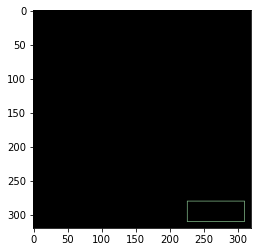

длина 149.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 201.65685415267944
длина 149.65685415267944
длина 247.3137083053589
длина 217.65685415267944
длина 233.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 204.97056245803833
длина 241.65685415267944
длина 217.65685415267944
длина 233.65685415267944
длина 220.97056198120117
длина 228.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 203.3137083053589
длина 245.65685415267944
длина 217.65685415267944
длина 233.65685415267944
длина 223.3137083053589
длина 228.0
itogo 2


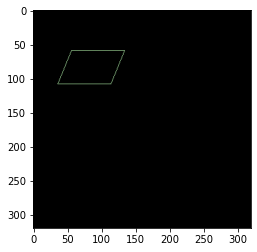

длина 240.56854152679443
длина 286.2253956794739
длина 258.56854152679443
длина 276.2253956794739
длина 157.65685415267944
длина 157.65685415267944
длина 240.56854152679443
длина 286.2253956794739
длина 257.3969683647156
длина 276.2253956794739
длина 263.053822517395
длина 270.56854152679443
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 241.39696860313416
длина 285.39696860313416
длина 258.56854152679443
длина 273.39696860313416
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
itogo 2


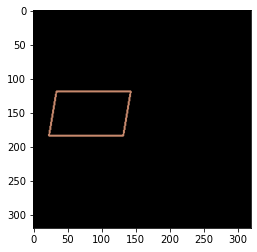

длина 211.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 327.94112491607666
длина 211.65685415267944
длина 374.7695519924164
длина 335.94112491607666
длина 368.4264061450958
длина 339.94112491607666
длина 368.4264061450958
длина 342.7695517539978
длина 362.7695519924164
длина 345.5979790687561
длина 362.7695519924164
длина 346.7695519924164
длина 358.7695519924164
длина 223.65685415267944
длина 121.4558436870575
длина 121.4558436870575
длина 223.65685415267944
длина 211.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 7.

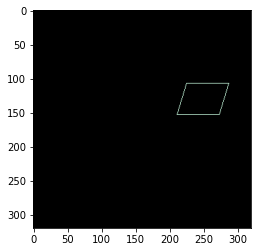

длина 105.65685415267944
длина 199.5979790687561
длина 105.65685415267944
длина 244.08326029777527
длина 214.42640614509583
длина 233.25483322143555
длина 220.08326029777527
длина 227.5979790687561
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 105.65685415267944
длина 199.5979790687561
длина 105.65685415267944
длина 244.08326029777527
длина 214.42640614509583
длина 233.25483322143555
длина 215.5979790687561
длина 229.25483322143555
длина 221.25483322143555
длина 227.5979790687561
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 200.42640614509583
длина 243.25483322143555
длина 214.42640614509583
длина 233.25483322143555
длина 215.5979790687561
длина 229.25483322143555
длина 0.0
длина 130.24264061450958
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 130.24264061450958
itogo 2


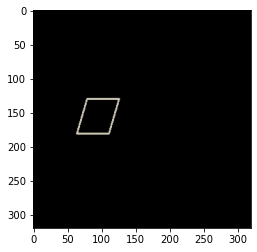

длина 89.65685415267944
длина 7.656854152679443
длина 180.42640614509583
длина 7.656854152679443
длина 89.65685415267944
длина 226.08326029777527
длина 188.42640614509583
длина 219.74011421203613
длина 188.42640614509583
длина 218.08326029777527
длина 194.08326029777527
длина 214.08326029777527
длина 194.08326029777527
длина 214.08326029777527
длина 196.42640614509583
длина 210.08326029777527
длина 107.89949464797974
длина 10.828427076339722
длина 10.828427076339722
длина 17.656854152679443
длина 17.656854152679443
длина 10.828427076339722
длина 10.828427076339722
длина 17.656854152679443
длина 17.656854152679443
длина 10.828427076339722
длина 10.828427076339722
длина 107.89949464797974
длина 5.414213538169861
длина 5.414213538169861
длина 89.65685415267944
длина 7.656854152679443
длина 180.42640614509583
длина 7.656854152679443
длина 89.65685415267944
длина 226.08326029777527
длина 188.42640614509583
длина 219.74011421203613
длина 188.42640614509583
длина 218.08326029777527
длина 194.

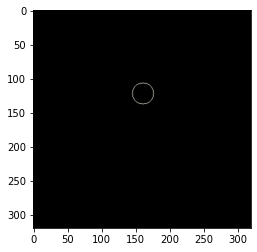

длина 82.91168785095215
длина 122.91168737411499
длина 95.5979790687561
длина 110.22539615631104
длина 101.25483322143555
длина 104.56854057312012
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 82.91168785095215
длина 122.91168737411499
длина 95.59797859191895
длина 110.22539615631104
длина 101.25483322143555
длина 104.56854057312012
длина 82.91168785095215
длина 122.91168737411499
длина 95.59797859191895
длина 106.91168785095215
длина 101.25483322143555
длина 104.56854057312012
itogo 2


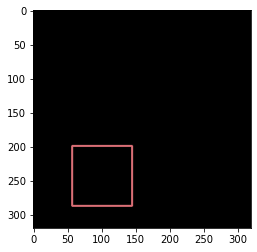

длина 169.65685415267944
длина 325.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 371.3137083053589
длина 333.65685415267944
длина 363.3137083053589
длина 333.65685415267944
длина 363.3137083053589
длина 339.3137083053589
длина 357.65685415267944
длина 339.3137083053589
длина 357.65685415267944
длина 341.65685415267944
длина 355.3137083053589
длина 344.9705619812012
длина 352.0
длина 347.3137083053589
длина 349.65685415267944
длина 169.65685415267944
длина 325.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 371.3137083053589
длина 333.65685415267944
длина 363.3137083053589
длина 339.3137083053589
длина 357.65685415267944
длина 344.9705619812012
длина 352.0
длина 169.65685415267944
длина 325.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 371.3137083053589
длина 333.65685415267944
длина 363.3137083053589
длина 339.3137083053589
длина 357.656854

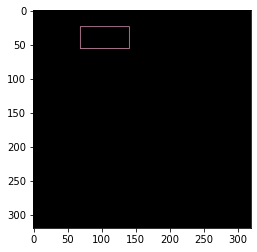

длина 183.3137083053589
длина 225.65685415267944
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 208.0
длина 183.3137083053589
длина 225.65685415267944
длина 197.65685415267944
длина 213.65685415267944
длина 203.3137083053589
длина 208.0
длина 183.3137083053589
длина 225.65685415267944
длина 197.65685415267944
длина 213.65685415267944
длина 200.97056198120117
длина 208.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 3


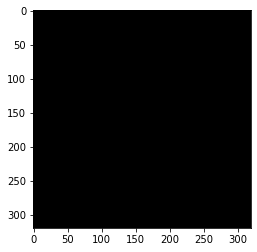

itogo 3
train_data/29.png


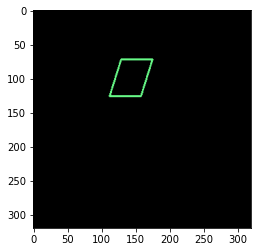

длина 87.65685415267944
длина 7.656854152679443
длина 186.08326029777527
длина 7.656854152679443
длина 87.65685415267944
длина 231.7401144504547
длина 194.08326029777527
длина 223.7401144504547
длина 199.7401144504547
длина 219.7401144504547
длина 118.97056221961975
длина 2.0
длина 2.0
длина 31.313708305358887
длина 31.313708305358887
длина 31.313708305358887
длина 31.313708305358887
длина 2.0
длина 2.0
длина 118.97056221961975
длина 87.65685415267944
длина 7.656854152679443
длина 186.08326029777527
длина 7.656854152679443
длина 87.65685415267944
длина 231.7401144504547
длина 190.08326029777527
длина 227.7401144504547
длина 194.08326029777527
длина 225.39696860313416
длина 195.74011421203613
длина 222.08326029777527
длина 199.7401144504547
длина 219.7401144504547
длина 199.7401144504547
длина 219.7401144504547
длина 202.08326029777527
длина 215.7401144504547
длина 118.97056221961975
длина 2.0
длина 2.0
длина 31.313708305358887
длина 31.313708305358887
длина 31.313708305358887
длина 31.

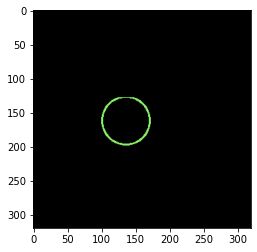

длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 210.65180122852325
длина 9.656854152679443
длина 251.62236523628235
длина 219.4802281856537
длина 242.79393815994263
длина 446.2741651535034
длина 435.4457404613495
длина 37.65685415267944
длина 2.0
длина 61.8406195640564
длина 68.66904664039612
длина 37.65685415267944
длина 37.65685415267944
длина 61.84061932563782
длина 2.0
длина 68.66904640197754
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 211.48022830486298
длина 250.79393815994263
длина 217.1370828151703
длина 245.13708472251892
длина 219.4802281856537
длина 242.79393815994263
длина 222.79393696784973
длина 239.4802281856537
длина 442.2741677761078
длина 438.2741675376892
длина 426.2741667032242
длина 37.65685415267944
длина 2.0
длина 61.8406195640564
длина 68.66904664039612
длина 37.65685415267944
длина 37.65685415267944
длина 61.84061932563782
длина 2.0
длина 68.66904640197754
длина 16.0
длина 2.0
длина 2.0
длина

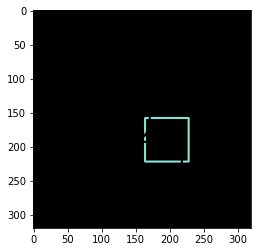

длина 9.656854152679443
длина 97.65685415267944
длина 47.65685415267944
длина 121.65685415267944
длина 35.65685415267944
длина 103.65685415267944
длина 510.87005722522736
длина 165.89949476718903
длина 19.656854152679443
длина 260.1421353816986
длина 61.899494767189026
длина 160.24264061450958
длина 13.41421353816986
длина 254.48528122901917
длина 55.65685415267944
длина 158.48528122901917
длина 11.656854152679443
длина 253.3137083053589
длина 53.071067690849304
длина 152.2426404953003
длина 6.0
длина 246.4852809906006
длина 46.24264049530029
длина 9.656854152679443
длина 97.65685415267944
длина 47.65685415267944
длина 121.65685415267944
длина 35.65685415267944
длина 103.65685415267944
длина 510.87005722522736
длина 165.89949476718903
длина 21.071067690849304
длина 260.1421353816986
длина 63.31370830535889
длина 163.55634891986847
длина 17.899494767189026
длина 257.79898953437805
длина 60.14213538169861
длина 159.65685403347015
длина 14.0
длина 253.3137080669403
длина 55.07106757164001

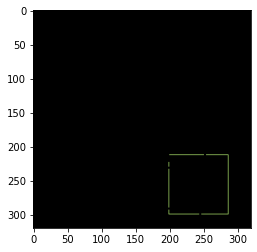

длина 61.65685415267944
длина 71.65685415267944
длина 97.65685415267944
длина 155.65685415267944
длина 47.65685415267944
длина 85.65685415267944
длина 690.1837655305862
длина 102.82842707633972
длина 116.0
длина 16.0
длина 317.65685415267944
длина 104.0
длина 94.82842707633972
длина 108.0
длина 8.0
длина 309.65685415267944
длина 96.0
длина 684.3847759962082
длина 103.89949476718903
длина 117.65685415267944
длина 17.656854152679443
длина 318.1421353816986
длина 105.65685415267944
длина 99.89949476718903
длина 113.65685415267944
длина 13.656854152679443
длина 314.1421353816986
длина 101.65685415267944
длина 94.82842707633972
длина 108.0
длина 8.0
длина 309.65685415267944
длина 96.0
длина 691.8406196832657
длина 99.89949476718903
длина 113.65685415267944
длина 13.656854152679443
длина 314.1421353816986
длина 101.65685415267944
itogo 2


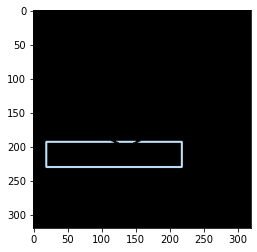

длина 391.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 115.65685415267944
длина 37.65685415267944
длина 185.65685415267944
длина 69.65685415267944
длина 878.6274166107178
длина 61.65685415267944
длина 870.6274166107178
длина 58.485281229019165
длина 865.4558436870575
длина 54.24264061450958
длина 862.6274166107178
длина 50.24264061450958
длина 860.9705624580383
длина 43.65685415267944
длина 850.6274166107178
длина 36.0
длина 844.9705624580383
длина 391.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 115.65685415267944
длина 37.65685415267944
длина 185.65685415267944
длина 69.65685415267944
длина 878.6274166107178
длина 63.899494767189026
длина 872.2842707633972
длина 59.899494767189026
длина 868.2842707633972
длина 54.82842707633972
длина 861.4558432102203
длина 52.82842707633972
длина 859.798989534378
длина 48.82842707633972
длина 855.798989534378
длина 42.0
длина 848.9705624580383
длина 36.0
длина 847.3137083053589
длина 391.65685415267944

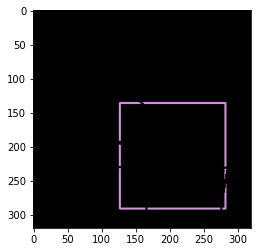

длина 205.65685415267944
длина 67.65685415267944
длина 41.65685415267944
длина 111.65685415267944
длина 53.65685415267944
длина 582.9705624580383
длина 179.65685415267944
длина 103.65685415267944
длина 233.65685415267944
длина 51.65685415267944
длина 477.899494767189
длина 183.89949476718903
длина 221.65685415267944
длина 85.89949476718903
длина 35.65685415267944
длина 199.89949476718903
длина 71.0710676908493
длина 435.3137083053589
длина 177.89949476718903
длина 219.3137083053589
длина 83.55634880065918
длина 32.485281229019165
длина 197.55634891986847
длина 67.89949476718903
длина 432.1421353816986
длина 175.55634891986847
длина 216.0
длина 77.0710676908493
длина 26.82842707633972
длина 194.24264061450958
длина 64.82842707633972
длина 427.65685415267944
длина 171.65685415267944
длина 213.65685415267944
длина 68.48528110980988
длина 16.242640614509583
длина 191.89949476718903
длина 62.24264061450958
длина 426.48528122901917
длина 168.48528122901917
длина 212.0
длина 63.65685415267944

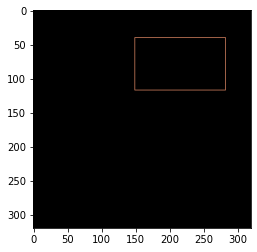

длина 247.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 393.65685415267944
длина 247.65685415267944
длина 439.3137083053589
длина 407.3137083053589
длина 425.65685415267944
длина 409.65685415267944
длина 423.3137083053589
длина 415.3137083053589
длина 420.0
длина 247.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 393.65685415267944
длина 247.65685415267944
длина 439.3137083053589
длина 409.65685415267944
длина 425.65685415267944
длина 415.3137083053589
длина 420.0
длина 247.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 393.65685415267944
длина 247.65685415267944
длина 439.3137083053589
длина 412.9705619812012
длина 426.6274166107178
itogo 2


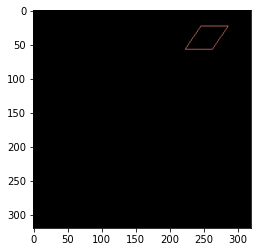

длина 135.39696836471558
длина 181.05382251739502
длина 152.2253954410553
длина 172.71067643165588
длина 156.2253954410553
длина 169.88224959373474
длина 83.65685415267944
длина 83.65685415267944
длина 3.414213538169861
длина 3.414213538169861
длина 136.2253954410553
длина 180.2253954410553
длина 155.05382251739502
длина 169.88224935531616
длина 4.0
длина 4.0
длина 63.65685415267944
длина 134.56854128837585
длина 63.65685415267944
длина 181.88224959373474
длина 156.2253954410553
длина 169.88224959373474
длина 3.414213538169861
длина 3.414213538169861
itogo 2


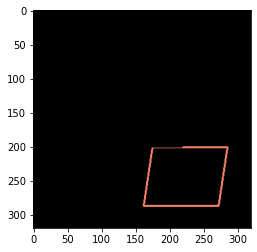

длина 213.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 373.01219260692596
длина 67.65685415267944
длина 125.65685415267944
длина 419.8406196832657
длина 381.5979790687561
длина 415.25483322143555
длина 384.4264061450958
длина 413.49747383594513
длина 387.25483322143555
длина 409.5979790687561
длина 714.8528122901917
длина 713.6812393665314
длина 709.6812393665314
длина 393.5979789495468
длина 84.97056245803833
длина 216.3847759962082
длина 224.

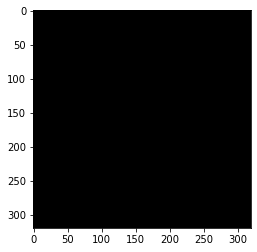

itogo 2
train_data/30.png


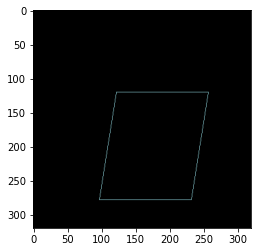

длина 251.65685415267944
длина 581.5391039848328
длина 255.65685415267944
длина 624.3675310611725
длина 596.3675310611725
длина 610.0243852138519
длина 582.3675310611725
длина 623.5391039848328
длина 596.3675310611725
длина 612.3675310611725
длина 602.0243852138519
длина 606.710676908493
длина 251.65685415267944
длина 581.5391039848328
длина 251.65685415267944
длина 624.3675310611725
длина 596.3675310611725
длина 612.3675310611725
длина 602.0243852138519
длина 606.710676908493
itogo 0


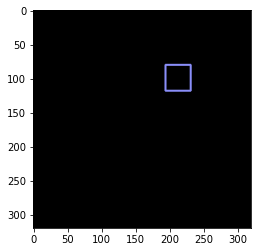

длина 67.65685415267944
длина 123.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 67.65685415267944
длина 169.3137083053589
длина 131.65685415267944
длина 161.3137083053589
длина 137.3137083053589
длина 155.65685415267944
длина 139.65685415267944
длина 153.3137083053589
длина 142.97056198120117
длина 150.0
длина 67.65685415267944
длина 123.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 67.65685415267944
длина 169.3137083053589
длина 131.65685415267944
длина 161.3137083053589
длина 137.3137083053589
длина 155.65685415267944
длина 139.65685415267944
длина 153.3137083053589
длина 142.97056198120117
длина 150.0
длина 67.65685415267944
длина 123.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 67.65685415267944
длина 169.3137083053589
длина 129.3137083053589
длина 163.65685415267944
длина 131.65685415267944
длина 161.3137083053589
длина 134.97056198120117
длина 158.0
длина 137.3137083053589
длина 155.65685415267944
длина 137.313

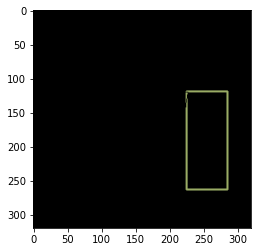

длина 113.65685415267944
длина 235.65685415267944
длина 11.656854152679443
длина 381.89949464797974
длина 281.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 109.65685415267944
длина 428.1421353816986
длина 390.48528122901917
длина 420.1421353816986
длина 394.3847756385803
длина 414.48528122901917
длина 800.6274166107178
длина 4.0
длина 762.3847759962082
длина 752.7279218435287
длина 113.65685415267944
длина 235.65685415267944
длина 11.656854152679443
длина 381.89949464797974
длина 281.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 115.65685415267944
длина 428.1421353816986
длина 390.48528122901917
длина 420.1421353816986
длина 391.899494767189
длина 419.55634891986847
длина 396.72792184352875
длина 414.48528122901917
длина 16.242640614509583
длина 774.9705624580383
длина 2.0
длина 756.7279214859009
длина 113.65685415267944
длина 235.65685415267944
длина 11.656854152679443
длина 381.89949464797974
длина 281.65685415267944
длина 5.6568541526794

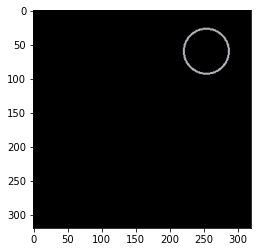

длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 197.82337379455566
длина 5.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 238.7939395904541
длина 205.82337403297424
длина 230.79393815994263
длина 205.8233745098114
длина 230.79393863677979
длина 211.4802281856537
длина 225.13708305358887
длина 211.4802303314209
длина 225.13708209991455
длина 217.1370828151703
длина 219.48023128509521
длина 12.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 12.0
длина 17.656854152679443
длина 5.656854

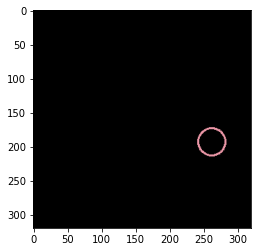

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 117.63960862159729
длина 147.88224983215332
длина 118.22539615631104
длина 145.53910398483276
длина 123.29646348953247
длина 142.22539567947388
длина 123.882248878479
длина 139.88224959373474
длина 125.63960862159729
длина 139.88224983215332
длина 126.22539615631104
длина 137.53910446166992
длина 131.29646348953247
длина 134.22539567947388
длина 0.0
длина 2.8284270763397217
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 5.656854152679443
длина 0.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 118.22539615631104
длина 145.53910446166992
длина 123.29646348953247
длина 139.882248878479
длина 125.63960862159729
длина 139.88224983215332
длина 129.53910446166992
длина 134.22539567947388
длина 10.0
длина 2.0
длина 0.0
длина 2.0

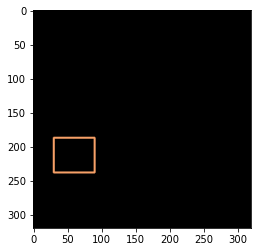

длина 113.65685415267944
длина 195.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 113.65685415267944
длина 241.3137083053589
длина 201.3137083053589
длина 235.65685415267944
длина 203.65685415267944
длина 233.3137083053589
длина 206.97056198120117
длина 230.0
длина 209.3137083053589
длина 227.65685415267944
длина 211.65685415267944
длина 227.65685415267944
длина 211.65685415267944
длина 225.3137083053589
длина 214.97056198120117
длина 222.0
длина 217.3137083053589
длина 219.65685415267944
длина 113.65685415267944
длина 195.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 113.65685415267944
длина 241.3137083053589
длина 203.65685415267944
длина 233.3137083053589
длина 206.97056198120117
длина 230.0
длина 209.3137083053589
длина 227.65685415267944
длина 211.65685415267944
длина 225.3137083053589
длина 217.3137083053589
длина 219.65685415267944
длина 113.65685415267944
длина 195.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 

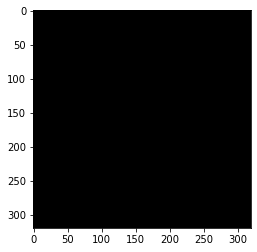

itogo 1
train_data/31.png


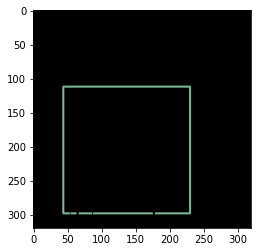

длина 95.65685415267944
длина 169.65685415267944
длина 33.65685415267944
длина 11.656854152679443
длина 13.656854152679443
длина 717.6568541526794
длина 365.65685415267944
длина 365.65685415267944
длина 365.65685415267944
длина 763.3137083053589
длина 227.3137083053589
длина 1260.2842707633972
длина 220.0
длина 1252.9705624580383
длина 174.82842707633972
длина 38.82842707633972
длина 16.82842707633972
длина 1229.798989534378
длина 166.0
длина 30.0
длина 8.0
длина 1220.9705624580383
длина 95.65685415267944
длина 167.65685415267944
длина 5.656854152679443
длина 31.656854152679443
длина 9.656854152679443
длина 5.656854152679443
длина 11.656854152679443
длина 720.9705624580383
длина 365.65685415267944
длина 365.65685415267944
длина 365.65685415267944
длина 766.6274166107178
длина 225.65685415267944
длина 1258.6274166107178
длина 223.3137083053589
длина 1256.2842707633972
длина 220.0
длина 1252.9705624580383
длина 175.65685415267944
длина 39.65685415267944
длина 17.656854152679443
длина 123

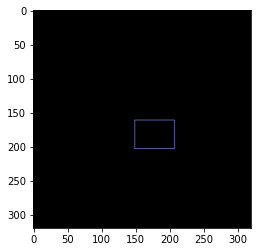

длина 97.65685415267944
длина 65.65685415267944
длина 65.65685415267944
длина 173.65685415267944
длина 97.65685415267944
длина 219.3137083053589
длина 189.65685415267944
длина 203.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 175.3137083053589
длина 217.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 176.97056245803833
длина 216.0
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 195.3137083053589
длина 200.0
itogo 1


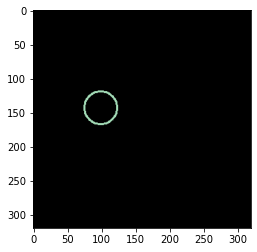

длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 137.5391025543213
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 180.8528118133545
длина 145.53910446166992
длина 172.8528116941452
длина 148.85281372070312
длина 168.95331704616547
длина 151.1959571838379
длина 167.19595766067505
длина 153.5391035079956
длина 164.8528118133545
длина 156.85281372070312
длина 160.95331704616547
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 137.5391025543213
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 180.8528118133545
длина 143.1959571838379
длина 174.61017179489136
длина 145.53910446166992


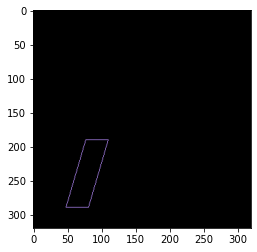

длина 260.85281229019165
длина 303.6812393665314
длина 274.85281229019165
длина 293.6812393665314
длина 280.5096662044525
длина 288.02438521385193
длина 0.0
длина 0.0
длина 49.65685415267944
длина 260.02438521385193
длина 49.65685415267944
длина 304.5096664428711
длина 276.02438521385193
длина 292.02438521385193
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 260.85281229019165
длина 303.6812393665314
длина 274.85281229019165
длина 293.6812393665314
длина 276.02438521385193
длина 289.6812393665314
длина 281.6812393665314
длина 288.02438521385193
длина 2.0
длина 2.0
itogo 1


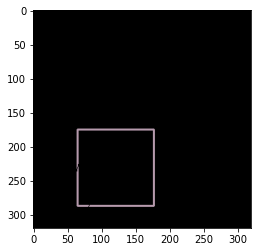

длина 183.65685415267944
длина 25.656854152679443
длина 95.65685415267944
длина 5.656854152679443
длина 422.48528122901917
длина 217.65685415267944
длина 95.65685415267944
длина 217.65685415267944
длина 468.1421353816986
длина 430.48528122901917
длина 460.1421353816986
длина 431.3137083053589
длина 460.97056245803833
длина 436.1421353816986
длина 454.48528122901917
длина 884.2842707633972
длина 128.2426404953003
длина 728.7279214859009
длина 120.24264061450958
длина 722.7279218435287
длина 183.65685415267944
длина 25.656854152679443
длина 95.65685415267944
длина 5.656854152679443
длина 422.48528122901917
длина 217.65685415267944
длина 95.65685415267944
длина 217.65685415267944
длина 468.1421353816986
длина 430.48528122901917
длина 460.1421353816986
длина 433.7989890575409
длина 454.48528122901917
длина 436.97056245803833
длина 455.3137083053589
длина 131.89949476718903
длина 734.3847759962082
длина 124.24264061450958
длина 724.7279218435287
длина 183.65685415267944
длина 25.65685415267

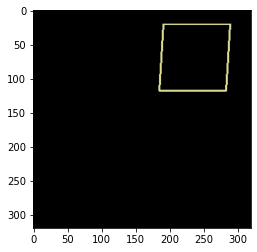

длина 189.65685415267944
длина 11.656854152679443
длина 11.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 370.6274166107178
длина 11.656854152679443
длина 11.656854152679443
длина 414.2842707633972
длина 376.2842707633972
длина 408.6274166107178
длина 378.6274166107178
длина 406.2842707633972
длина 381.9411244392395
длина 401.79898953437805
длина 384.2842707633972
длина 400.6274166107178
длина 386.6274166107178
длина 399.4558436870575
длина 596.0832600593567
длина 220.48528122901917
длина 26.0
длина 26.0
длина 26.0
длина 26.0
длина 28.0
длина 28.0
длина 26.0
длина 26.0
длина 26.0
длина 26.0
длина 13.41421353816986
длина 13.41421353816986
длина 189.65685415267944
длина 11.656854152679443
длина 11.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длин

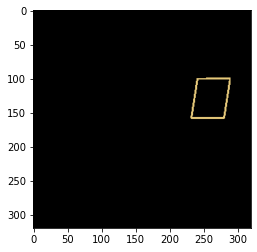

длина 89.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 190.28427076339722
длина 5.656854152679443
длина 65.65685415267944
длина 235.94112491607666
длина 198.28427076339722
длина 231.11269783973694
длина 201.11269783973694
длина 228.76955199241638
длина 203.94112491607666
длина 224.28427076339722
длина 205.11269760131836
длина 224.28427076339722
длина 209.11269783973694
длина 221.94112491607666
длина 409.0538227558136
длина 212.28427076339722
длина 50.485281229019165
длина 58.72792184352875
длина 69.41421353816986
длина 89.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
дл

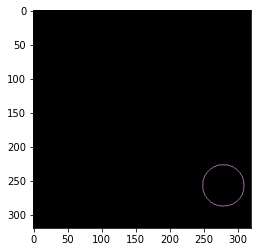

длина 181.8233757019043
длина 221.82337474822998
длина 194.5096664428711
длина 209.13708400726318
длина 200.1665210723877
длина 208.1665210723877
длина 25.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 181.8233757019043
длина 221.82337474822998
длина 194.50966548919678
длина 205.82337474822998
длина 60.97056245803833
длина 60.97056245803833
длина 60.97056245803833
длина 60.97056245803833
длина 181.8233757019043
длина 221.82337474822998
длина 194.5096664428711
длина 209.13708400726318
длина 200.1665210723877
длина 208.1665210723877
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
itogo 3


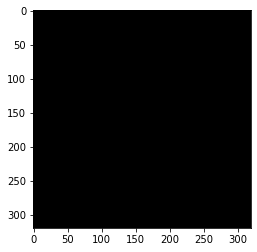

itogo 3
train_data/32.png


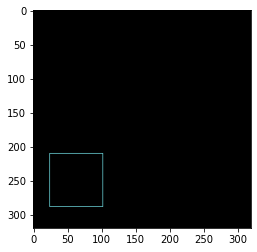

длина 287.3137083053589
длина 329.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 287.3137083053589
длина 329.65685415267944
длина 299.3137083053589
длина 317.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 307.3137083053589
длина 312.0
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 285.65685415267944
длина 137.65685415267944
длина 331.3137083053589
длина 299.3137083053589
длина 317.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 307.3137083053589
длина 312.0
itogo 1


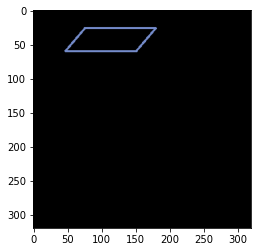

длина 203.65685415267944
длина 5.656854152679443
длина 261.8822486400604
длина 5.656854152679443
длина 203.65685415267944
длина 318.8528108596802
длина 275.539103269577
длина 310.85281109809875
длина 281.19595766067505
длина 306.85281133651733
длина 286.36753034591675
длина 302.85281109809875
длина 4.828427076339722
длина 8.242640614509583
длина 5.656854152679443
длина 5.656854152679443
длина 8.485280990600586
длина 8.485280990600586
длина 8.485280990600586
длина 8.485280990600586
длина 5.656854152679443
длина 5.656854152679443
длина 8.242640614509583
длина 4.828427076339722
длина 203.65685415267944
длина 5.656854152679443
длина 261.8822486400604
длина 5.656854152679443
длина 203.65685415267944
длина 318.8528108596802
длина 272.7106759548187
длина 312.5096654891968
длина 279.53910303115845
длина 306.85281109809875
длина 282.3675305843353
длина 304.02438402175903
длина 288.02438473701477
длина 301.1959571838379
длина 4.828427076339722
длина 4.828427076339722
длина 203.65685415267944
дли

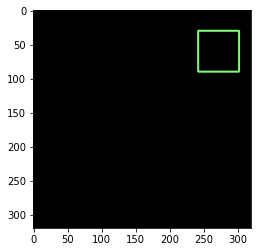

длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 221.65685415267944
длина 251.3137083053589
длина 227.3137083053589
длина 245.65685415267944
длина 229.65685415267944
длина 243.3137083053589
длина 235.3137083053589
длина 240.0
длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 219.3137083053589
длина 253.65685415267944
длина 221.65685415267944
длина 251.3137083053589
длина 224.97056198120117
длина 248.0
длина 227.3137083053589
длина 245.65685415267944
длина 227.3137083053589
длина 245.65685415267944
длина 229.65685415267944
длина 243.3137083053589
длина 232.97056198120117
длина 240.0
длина 235.3137083053589
длина 237.65685415267944
длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
дл

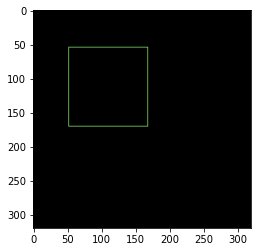

длина 213.65685415267944
длина 213.65685415267944
длина 213.65685415267944
длина 437.65685415267944
длина 213.65685415267944
длина 483.3137083053589
длина 453.65685415267944
длина 469.65685415267944
длина 459.3137083053589
длина 464.0
длина 440.97056245803833
длина 480.0
длина 451.3137083053589
длина 469.65685415267944
длина 453.65685415267944
длина 467.3137083053589
длина 459.3137083053589
длина 464.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 439.3137083053589
длина 481.65685415267944
длина 453.65685415267944
длина 467.3137083053589
itogo 3


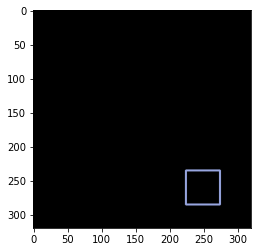

длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 184.97056198120117
длина 205.65685415267944
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 195.3137083053589
длина 197.65685415267944
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 184.97056198120117
длина 208.0
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 195.3137083053589
длина 200.0
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 179.3137083053589
длина 213.65685415267944
длина 181.65685415267944
длина 211.3137083053589
д

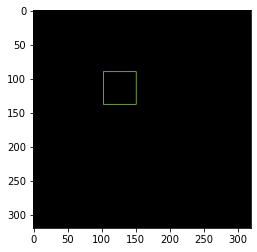

длина 167.3137083053589
длина 209.65685415267944
длина 181.65685415267944
длина 197.65685415267944
длина 187.3137083053589
длина 192.0
длина 167.3137083053589
длина 209.65685415267944
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 192.0
длина 167.3137083053589
длина 209.65685415267944
длина 181.65685415267944
длина 195.3137083053589
itogo 5


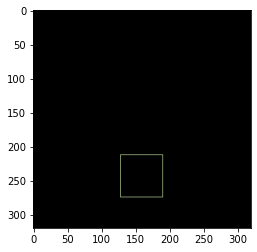

длина 223.3137083053589
длина 265.65685415267944
длина 237.65685415267944
длина 253.65685415267944
длина 243.3137083053589
длина 248.0
длина 105.65685415267944
длина 105.65685415267944
длина 105.65685415267944
длина 221.65685415267944
длина 105.65685415267944
длина 267.3137083053589
длина 237.65685415267944
длина 253.65685415267944
длина 240.97056198120117
длина 248.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 223.3137083053589
длина 265.65685415267944
длина 237.65685415267944
длина 253.65685415267944
длина 243.3137083053589
длина 248.0
itogo 6


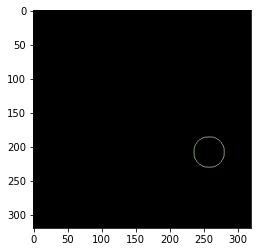

длина 129.53910541534424
длина 169.53910398483276
длина 142.22539520263672
длина 153.53910446166992
длина 69.11269783973694
длина 69.11269783973694
длина 69.11269783973694
длина 69.11269783973694
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539567947388
длина 156.85281372070312
длина 147.88224983215332
длина 151.1959571838379
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539520263672
длина 153.53910446166992
длина 63.455843687057495
длина 63.455843687057495
длина 63.455843687057495
длина 63.455843687057495
itogo 6


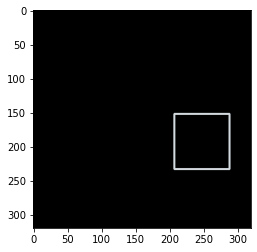

длина 155.65685415267944
длина 297.65685415267944
длина 155.65685415267944
длина 155.65685415267944
длина 155.65685415267944
длина 343.3137083053589
длина 305.65685415267944
длина 335.3137083053589
длина 305.65685415267944
длина 335.3137083053589
длина 311.3137083053589
длина 329.65685415267944
длина 311.3137083053589
длина 329.65685415267944
длина 313.65685415267944
длина 327.3137083053589
длина 316.9705619812012
длина 324.0
длина 319.3137083053589
длина 321.65685415267944
длина 155.65685415267944
длина 297.65685415267944
длина 155.65685415267944
длина 155.65685415267944
длина 155.65685415267944
длина 343.3137083053589
длина 303.3137083053589
длина 337.65685415267944
длина 305.65685415267944
длина 335.3137083053589
длина 311.3137083053589
длина 329.65685415267944
длина 311.3137083053589
длина 329.65685415267944
длина 313.65685415267944
длина 327.3137083053589
длина 316.9705619812012
длина 324.0
длина 319.3137083053589
длина 321.65685415267944
длина 155.65685415267944
длина 297.6568541

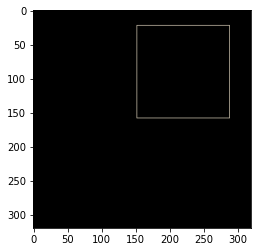

длина 519.3137083053589
длина 561.6568541526794
длина 533.6568541526794
длина 549.6568541526794
длина 533.6568541526794
длина 547.3137083053589
длина 539.3137083053589
длина 544.0
длина 519.3137083053589
длина 561.6568541526794
длина 533.6568541526794
длина 549.6568541526794
длина 536.9705619812012
длина 544.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 519.3137083053589
длина 561.6568541526794
длина 533.6568541526794
длина 549.6568541526794
длина 536.9705619812012
длина 544.0
itogo 8


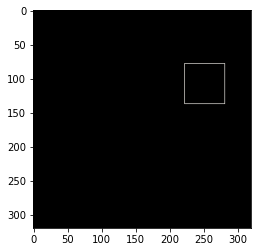

длина 211.3137083053589
длина 253.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 211.3137083053589
длина 253.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 209.65685415267944
длина 99.65685415267944
длина 255.3137083053589
длина 225.65685415267944
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
itogo 9


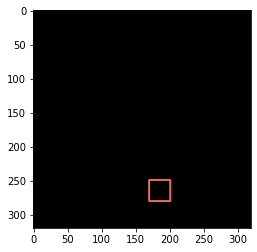

длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 103.31370830535889
длина 137.65685415267944
длина 105.65685415267944
длина 135.3137083053589
длина 108.97056198120117
длина 129.65685415267944
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124.0
длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 111.31370830535889
длина 129.65685415267944
длина 116.97056198120117
длина 124.0
длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 111.31370830535889
длина 129.656854152679

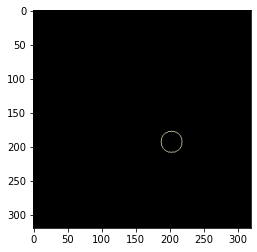

длина 82.91168785095215
длина 122.91168737411499
длина 95.5979790687561
длина 110.22539710998535
длина 98.91168785095215
длина 106.91168689727783
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 82.91168785095215
длина 122.91168737411499
длина 93.25483322143555
длина 112.56854152679443
длина 98.91168785095215
длина 106.91168689727783
длина 39.31370830535889
длина 39.31370830535889
длина 39.31370830535889
длина 39.31370830535889
длина 82.91168785095215
длина 122.91168737411499
длина 95.59797859191895
длина 110.22539615631104
длина 101.25483322143555
длина 104.56854057312012
itogo 10


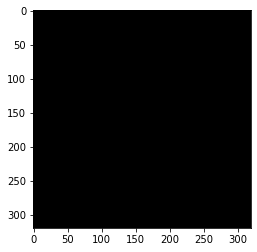

itogo 10
train_data/33.png


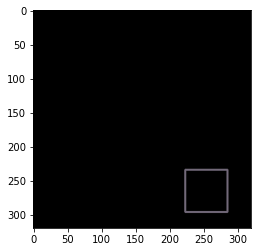

длина 117.65685415267944
длина 221.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 267.3137083053589
длина 229.65685415267944
длина 259.3137083053589
длина 235.3137083053589
длина 253.65685415267944
длина 240.97056245803833
длина 248.0
длина 117.65685415267944
длина 221.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 267.3137083053589
длина 229.65685415267944
длина 259.3137083053589
длина 235.3137083053589
длина 253.65685415267944
длина 240.97056198120117
длина 248.0
длина 117.65685415267944
длина 221.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 267.3137083053589
длина 229.65685415267944
длина 259.3137083053589
длина 235.3137083053589
длина 253.65685415267944
длина 237.65685415267944
длина 251.3137083053589
длина 243.3137083053589
длина 245.65685415267944
itogo 1


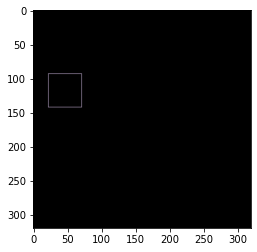

длина 172.97056245803833
длина 212.0
длина 185.65685415267944
длина 201.65685415267944
длина 191.3137083053589
длина 196.0
длина 172.97056245803833
длина 212.0
длина 185.65685415267944
длина 199.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 171.3137083053589
длина 213.65685415267944
длина 185.65685415267944
длина 201.65685415267944
длина 191.3137083053589
длина 196.0
itogo 2


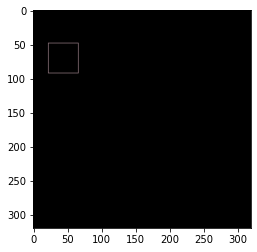

длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 149.65685415267944
длина 69.65685415267944
длина 195.3137083053589
длина 165.65685415267944
длина 181.65685415267944
длина 171.3137083053589
длина 176.0
длина 151.3137083053589
длина 193.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 151.3137083053589
длина 193.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 3


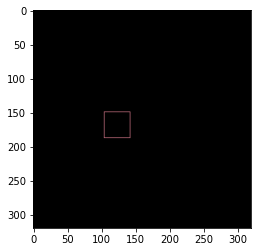

длина 127.31370830535889
длина 169.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 144.97056198120117
длина 152.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 128.97056245803833
длина 168.0
длина 141.65685415267944
длина 155.3137083053589
длина 128.97056245803833
длина 168.0
длина 141.65685415267944
длина 155.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 4


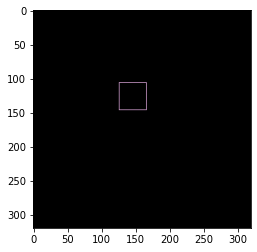

длина 136.97056245803833
длина 176.0
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 155.3137083053589
длина 160.0
длина 135.3137083053589
длина 177.65685415267944
длина 149.65685415267944
длина 165.65685415267944
длина 155.3137083053589
длина 160.0
длина 135.3137083053589
длина 177.65685415267944
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 155.3137083053589
длина 160.0
itogo 5


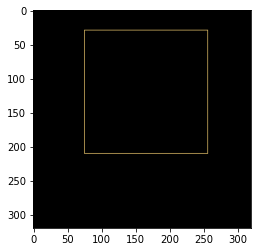

длина 343.65685415267944
длина 343.65685415267944
длина 343.65685415267944
длина 697.6568541526794
длина 343.65685415267944
длина 743.3137083053589
длина 711.3137083053589
длина 729.6568541526794
длина 713.6568541526794
длина 727.3137083053589
длина 719.3137083053589
длина 724.0
длина 700.9705624580383
длина 737.6568541526794
длина 713.6568541526794
длина 729.6568541526794
длина 716.9705619812012
длина 724.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 699.3137083053589
длина 741.6568541526794
длина 713.6568541526794
длина 727.3137083053589
itogo 6


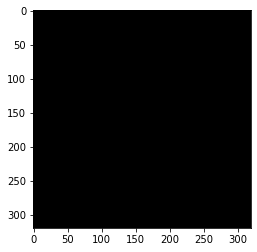

itogo 6
train_data/34.png


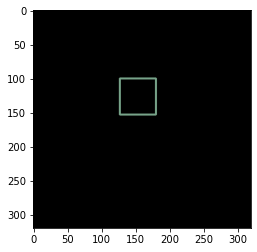

длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 196.97056198120117
длина 220.0
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944


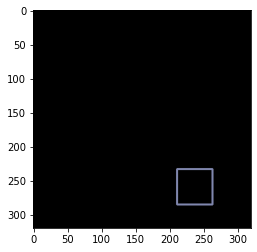

длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 205.65685415267944
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 200.97056198120117
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.313

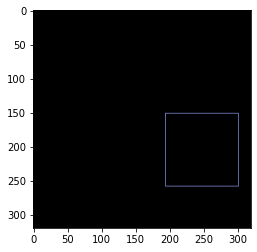

длина 195.65685415267944
длина 195.65685415267944
длина 195.65685415267944
длина 401.65685415267944
длина 195.65685415267944
длина 447.3137083053589
длина 417.65685415267944
длина 433.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 404.97056245803833
длина 444.0
длина 417.65685415267944
длина 433.65685415267944
длина 423.3137083053589
длина 428.0
длина 403.3137083053589
длина 445.65685415267944
длина 415.3137083053589
длина 433.65685415267944
длина 417.65685415267944
длина 431.3137083053589
длина 423.3137083053589
длина 428.0
itogo 3


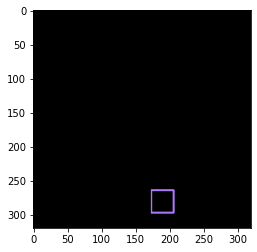

длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 149.3137083053589
длина 113.65685415267944
длина 142.48528122901917
длина 113.65685415267944
длина 141.3137083053589
длина 119.31370830535889
длина 136.82842707633972
длина 121.65685415267944
длина 134.48528122901917
длина 193.3137080669403
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 149.3137083053589
длина 113.65685415267944
длина 141.3137083053589
длина 119.31370830535889
длина 136.82842707633972
длина 197.79898953437805
длина 186.48528122901917
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 149.3137083053589
длина 111.31370830535889
длина 143.65685415267944
длина 113.65685415267944
длина 142.48528122901917
длина 116.97056198120117
длина 138.0
длина 119.31370830535889
длина 136.82842707633972
длина 119.31370830535889
длина 135.65685415267944
длина 202.97056245803833
дли

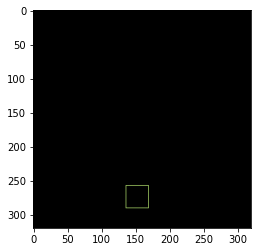

длина 107.31370830535889
длина 149.65685415267944
длина 121.65685415267944
длина 137.65685415267944
длина 127.31370830535889
длина 132.0
длина 107.31370830535889
длина 149.65685415267944
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 47.65685415267944
длина 47.65685415267944
длина 51.65685415267944
длина 105.65685415267944
длина 51.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 135.3137083053589
itogo 5


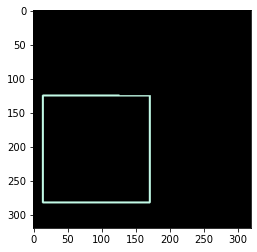

длина 307.65685415267944
длина 601.6568541526794
длина 307.65685415267944
длина 307.65685415267944
длина 219.65685415267944
длина 646.7279218435287
длина 609.6568541526794
длина 639.3137083053589
длина 609.6568541526794
длина 638.7279218435287
длина 615.3137083053589
длина 633.6568541526794
длина 617.6568541526794
длина 633.0710676908493
длина 1164.3847759962082
длина 1159.899494767189
длина 307.65685415267944
длина 601.6568541526794
длина 307.65685415267944
длина 307.65685415267944
длина 219.65685415267944
длина 646.7279218435287
длина 607.3137083053589
длина 641.0710676908493
длина 609.6568541526794
длина 639.3137083053589
длина 612.9705619812012
длина 635.4142135381699
длина 615.3137083053589
длина 633.6568541526794
длина 615.3137083053589
длина 633.0710676908493
длина 1170.9705624580383
длина 1160.1421350240707
длина 1158.1421353816986
длина 307.65685415267944
длина 601.6568541526794
длина 307.65685415267944
длина 307.65685415267944
длина 219.65685415267944
длина 646.7279218435287


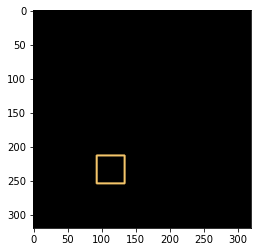

длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 143.3137083053589
длина 177.65685415267944
длина 145.65685415267944
длина 175.3137083053589
длина 148.97056198120117
длина 172.0
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 156.97056198120117
длина 164.0
длина 159.3137083053589
длина 161.65685415267944
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 75.65685415267944
длина 137.65685415267944
длина 75.6

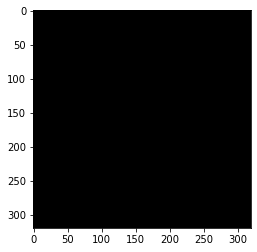

itogo 7
train_data/35.png


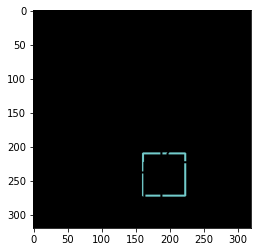

длина 59.65685415267944
длина 35.65685415267944
длина 87.65685415267944
длина 15.656854152679443
длина 230.28427076339722
длина 19.656854152679443
длина 41.65685415267944
длина 43.65685415267944
длина 273.94112491607666
длина 49.31370830535889
длина 69.65685415267944
длина 165.55634891986847
длина 74.72792184352875
длина 18.485281229019165
длина 106.14213538169861
длина 46.0
длина 64.0
длина 162.24264061450958
длина 71.0710676908493
длина 14.0
длина 101.65685415267944
длина 38.0
длина 154.24264061450958
длина 64.24264061450958
длина 6.0
длина 72.24264061450958
длина 59.65685415267944
длина 35.65685415267944
длина 87.65685415267944
длина 15.656854152679443
длина 230.28427076339722
длина 19.656854152679443
длина 41.65685415267944
длина 43.65685415267944
длина 273.94112491607666
длина 51.65685415267944
длина 73.0710676908493
длина 167.89949476718903
длина 98.38477599620819
длина 109.31370830535889
длина 49.31370830535889
длина 69.65685415267944
длина 165.55634891986847
длина 74.7279218435

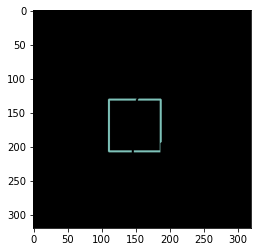

длина 69.65685415267944
длина 59.65685415267944
длина 7.656854152679443
длина 119.65685415267944
длина 277.899494767189
длина 145.65685415267944
длина 59.65685415267944
длина 71.65685415267944
длина 323.55634891986847
длина 300.97056245803833
длина 302.1421353816986
длина 81.41421353816986
длина 194.48528122901917
длина 296.48528122901917
длина 76.82842707633972
длина 189.0710676908493
длина 293.3137083053589
длина 70.0
длина 182.24264061450958
длина 286.48528122901917
длина 69.65685415267944
длина 59.65685415267944
длина 119.65685415267944
длина 277.899494767189
длина 145.65685415267944
длина 59.65685415267944
длина 71.65685415267944
длина 323.55634891986847
длина 604.5269113779068
длина 299.4558436870575
длина 300.3847759962082
длина 81.41421353816986
длина 194.48528122901917
длина 296.48528122901917
длина 78.24264061450958
длина 192.24264061450958
длина 295.899494767189
длина 74.24264061450958
длина 187.89949476718903
длина 290.1421353816986
длина 72.0
длина 182.82842707633972
длина

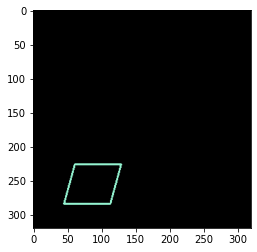

длина 131.65685415267944
длина 9.656854152679443
длина 237.25483322143555
длина 9.656854152679443
длина 131.65685415267944
длина 282.911687374115
длина 245.25483322143555
длина 276.56854152679443
длина 248.56854104995728
длина 270.911687374115
длина 253.25483322143555
длина 270.911687374115
длина 256.56854152679443
длина 265.25483322143555
длина 8.828427076339722
длина 8.828427076339722
длина 131.65685415267944
длина 9.656854152679443
длина 237.25483322143555
длина 9.656854152679443
длина 131.65685415267944
длина 282.911687374115
длина 242.911687374115
длина 278.911687374115
длина 245.25483322143555
длина 276.56854152679443
длина 246.9116871356964
длина 273.25483322143555
длина 250.911687374115
длина 270.911687374115
длина 253.25483322143555
длина 270.911687374115
длина 253.25483322143555
длина 266.911687374115
длина 166.97056221961975
длина 19.656854152679443
длина 19.656854152679443
длина 35.31370830535889
длина 35.31370830535889
длина 19.656854152679443
длина 19.656854152679443
длин

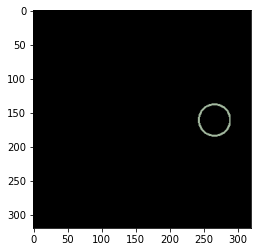

длина 13.656854152679443
длина 13.656854152679443
длина 131.88224959373474
длина 13.656854152679443
длина 172.0243866443634
длина 139.8822500705719
длина 164.0243866443634
длина 143.1959583759308
длина 160.7106773853302
длина 145.53910398483276
длина 158.36753010749817
длина 292.73506331443787
длина 283.07820892333984
длина 13.656854152679443
длина 13.656854152679443
длина 131.88224959373474
длина 13.656854152679443
длина 172.0243866443634
длина 137.5391047000885
длина 166.36753106117249
длина 139.8822500705719
длина 164.0243856906891
длина 145.53910398483276
длина 158.36753010749817
длина 145.53910398483276
длина 158.36753010749817
длина 287.078209400177
длина 12.0
длина 2.0
длина 0.0
длина 19.313708305358887
длина 19.313708305358887
длина 19.313708305358887
длина 12.0
длина 11.656854152679443
длина 11.656854152679443
длина 0.0
длина 19.313708305358887
длина 2.0
длина 12.0
длина 13.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 131.88224

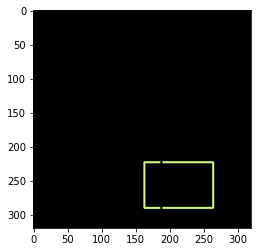

длина 141.65685415267944
длина 39.65685415267944
длина 309.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 141.65685415267944
длина 39.65685415267944
длина 355.3137083053589
длина 436.1421353816986
длина 232.1421353816986
длина 433.79898953437805
длина 229.79898953437805
длина 430.48528122901917
длина 226.48528122901917
длина 428.1421353816986
длина 224.1421353816986
длина 426.48528122901917
длина 222.48528122901917
длина 422.4852809906006
длина 218.4852809906006
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 141.65685415267944
длина 39.65685415267944
длина 309.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 141.65685415267944
длина 39.65685415267944
длина 355.3137083053589
длина 318.6274166107178
длина 352.97056245803833
длина 436.1421353816986
длина 232.1421353816986
длина 430.4852809906006
длина 226.4852809906006
длина 430.48528122901917
длина 226.48528122901917
длина 428.1421353

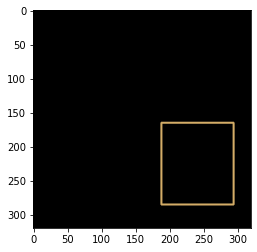

длина 205.65685415267944
длина 425.65685415267944
длина 233.65685415267944
длина 233.65685415267944
длина 205.65685415267944
длина 471.3137083053589
длина 433.65685415267944
длина 463.3137083053589
длина 433.65685415267944
длина 463.3137083053589
длина 439.3137083053589
длина 457.65685415267944
длина 439.3137083053589
длина 457.65685415267944
длина 441.65685415267944
длина 455.3137083053589
длина 444.9705619812012
длина 452.0
длина 447.3137083053589
длина 449.65685415267944
длина 205.65685415267944
длина 425.65685415267944
длина 233.65685415267944
длина 233.65685415267944
длина 205.65685415267944
длина 471.3137083053589
длина 433.65685415267944
длина 463.3137083053589
длина 433.65685415267944
длина 463.3137083053589
длина 439.3137083053589
длина 457.65685415267944
длина 441.65685415267944
длина 455.3137083053589
длина 444.9705619812012
длина 452.0
длина 205.65685415267944
длина 425.65685415267944
длина 233.65685415267944
длина 233.65685415267944
длина 205.65685415267944
длина 471.31370

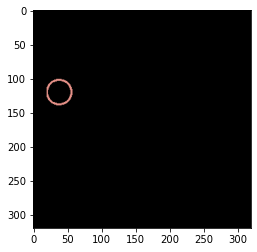

длина 11.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.05382180213928
длина 104.56854176521301
длина 133.3969690799713
длина 106.91168713569641
длина 131.05382180213928
длина 110.2253954410553
длина 127.74011445045471
длина 112.56854176521301
длина 125.39696907997131
длина 112.56854176521301
длина 125.39696907997131
длина 226.79393601417542
длина 221.1370828151703
длина 11.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.05382180213928
длина 106.91168713569641
длина 131.05382180213928
длина 110.2253954410553
длина 127.74011445045471
длина 112.56854176521301
длина 125.39696907997131
длина 221.13708186149597
длина 11.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.05382180213928
длина 106.91168713569641
длина 131.05382180213928
длина 112.56854128837585
длина 125.39697003364563
длина 112.56854176521301
длина 125.396968126297
длина 221

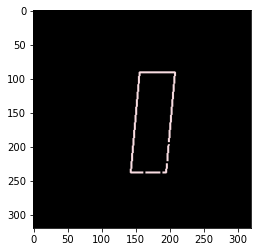

длина 35.65685415267944
длина 29.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 9.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 383.25483322143555
длина 5.656854152679443
длина 5.656854152679443
длина 97.65685415267944
длина 429.7401144504547
длина 821.2792183160782
длина 51.65685415267944
длина 44.72792184352875
длина 59.31370830535889
длина 660.6101716756821
длина 46.0
длина 39.071067571640015
длина 53.65685415267944
длин

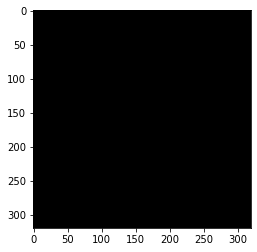

itogo 2
train_data/36.png


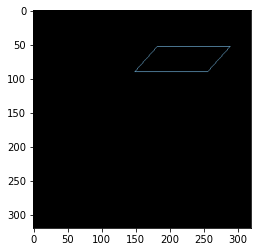

длина 278.024386882782
длина 330.509667634964
длина 302.85281348228455
длина 318.166522026062
длина 195.65685415267944
длина 277.19595980644226
длина 195.65685415267944
длина 331.3380947113037
длина 298.85281324386597
длина 319.3380947113037
длина 215.65685415267944
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 215.65685415267944
длина 278.024386882782
длина 330.509667634964
длина 298.85281348228455
длина 322.166522026062
длина 304.509667634964
длина 318.166522026062
длина 5.414213538169861
длина 5.414213538169861
itogo 0


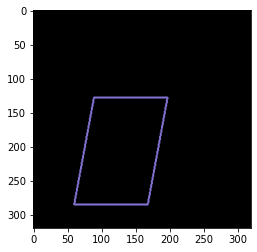

длина 209.65685415267944
длина 7.656854152679443
длина 15.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854

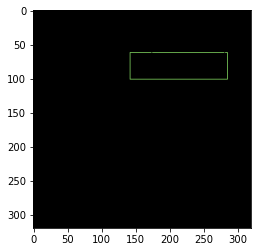

длина 340.1421353816986
длина 383.3137083053589
длина 355.3137083053589
длина 371.3137083053589
длина 202.0
длина 499.3137083053589
длина 339.3137083053589
длина 382.48528122901917
длина 351.3137083053589
длина 369.65685415267944
длина 355.3137083053589
длина 368.97056245803833
длина 206.0
длина 501.3137083053589
длина 267.65685415267944
длина 59.65685415267944
длина 63.65685415267944
длина 339.3137083053589
длина 199.65685415267944
длина 49.65685415267944
длина 384.1421353816986
длина 211.65685415267944
длина 504.6274166107178
itogo 0


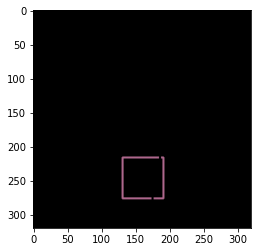

длина 21.656854152679443
длина 77.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 99.65685415267944
длина 260.1421353816986
длина 160.1421353816986
длина 316.1421353816986
длина 155.89949476718903
длина 312.1421353816986
длина 154.48528122901917
длина 310.48528122901917
длина 151.3137083053589
длина 306.48528122901917
длина 147.07106757164001
длина 302.4852809906006
длина 21.656854152679443
длина 77.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 99.65685415267944
длина 260.1421353816986
длина 158.3847759962082
длина 313.79898953437805
длина 152.72792184352875
длина 308.1421353816986
длина 147.07106757164001
длина 302.4852809906006
длина 21.656854152679443
длина 77.65685415267944
длина 113.65685415267944
длина 214.48528122901917
длина 113.65685415267944
длина 99.65685415267944
длина 261.79898953437805
длина 160.1421353816986
длина 316.1421353816986
длина 154.48528122901917
длина 310.48528122

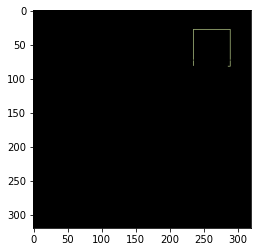

длина 71.65685415267944
длина 71.65685415267944
длина 89.65685415267944
длина 340.97056245803833
длина 328.48528122901917
длина 18.82842707633972
длина 12.0
длина 280.4852809906006
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 344.2842707633972
длина 328.48528122901917
длина 21.071067571640015
длина 14.0
длина 283.7989892959595
длина 4.828427076339722
длина 6.2426406145095825
длина 6.2426406145095825
длина 344.2842707633972
длина 329.4558436870575
длина 13.41421353816986
длина 6.0
длина 273.65685415267944
itogo 2


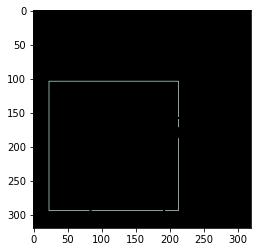

длина 1503.2548332214355
длина 212.0
длина 252.82842707633972
длина 26.0
длина 982.4852812290192
длина 204.0
длина 244.2426404953003
длина 18.0
длина 972.7279214859009
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 1503.2548332214355
длина 213.65685415267944
длина 253.89949476718903
длина 27.656854152679443
длина 982.3847759962082
длина 209.65685415267944
длина 249.89949476718903
длина 23.656854152679443
длина 978.3847759962082
длина 204.0
длина 244.82842707633972
длина 18.0
длина 974.4852812290192
длина 1503.2548332214355
длина 213.65685415267944
длина 253.89949476718903
длина 27.656854152679443
длина 982.3847759962082
длина 209.65685415267944
длина 249.89949476718903
длина 23.656854152679443
длина 978.3847759962082
длина 204.0
длина 244.82842707633972
длина 18.0
длина 974.4852812290192
itogo 3


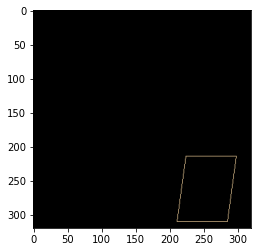

длина 129.65685415267944
длина 325.5979790687561
длина 129.65685415267944
длина 368.4264061450958
длина 339.25483322143555
длина 356.4264061450958
длина 340.4264061450958
длина 354.08326029777527
длина 153.65685415267944
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 153.65685415267944
длина 129.65685415267944
длина 325.5979790687561
длина 129.65685415267944
длина 368.4264061450958
длина 340.4264061450958
длина 356.4264061450958
длина 343.25483322143555
длина 350.7695519924164
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 129.65685415267944
длина 325.5979790687561
длина 129.65685415267944
длина 368.4264061450958
длина 340.4264061450958
длина 356.4264061450958
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.24264

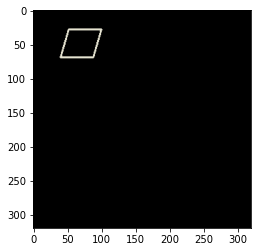

длина 91.65685415267944
длина 7.656854152679443
длина 159.94112491607666
длина 7.656854152679443
длина 91.65685415267944
длина 205.5979790687561
длина 165.5979790687561
длина 201.5979790687561
длина 167.94112491607666
длина 197.5979790687561
длина 172.42640590667725
длина 193.5979790687561
длина 173.5979790687561
длина 193.5979790687561
длина 175.94112491607666
длина 189.59797883033752
длина 175.94112491607666
длина 189.5979790687561
длина 110.48528122901917
длина 10.828427076339722
длина 10.828427076339722
длина 33.31370830535889
длина 33.31370830535889
длина 10.828427076339722
длина 10.828427076339722
длина 110.48528122901917
длина 5.414213538169861
длина 5.414213538169861
длина 91.65685415267944
длина 7.656854152679443
длина 159.94112491607666
длина 7.656854152679443
длина 91.65685415267944
длина 205.5979790687561
длина 165.5979790687561
длина 201.5979790687561
длина 167.94112491607666
длина 197.5979790687561
длина 172.42640590667725
длина 193.5979790687561
длина 173.5979790687561
д

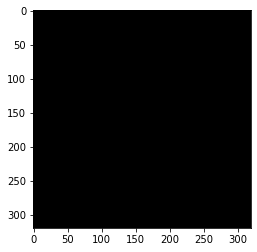

itogo 3
train_data/37.png


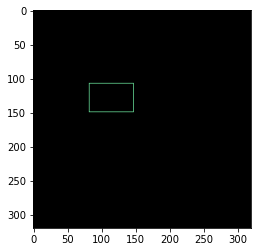

длина 189.3137083053589
длина 231.65685415267944
длина 203.65685415267944
длина 217.3137083053589
длина 189.3137083053589
длина 231.65685415267944
длина 201.3137083053589
длина 219.65685415267944
длина 203.65685415267944
длина 217.3137083053589
длина 209.3137083053589
длина 214.0
длина 189.3137083053589
длина 231.65685415267944
длина 203.65685415267944
длина 219.65685415267944
длина 209.3137083053589
длина 214.0
itogo 0


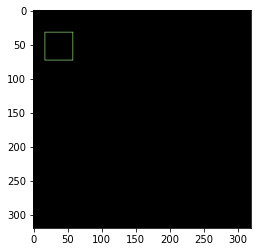

длина 140.97056245803833
длина 180.0
длина 153.65685415267944
длина 169.65685415267944
длина 159.3137083053589
длина 164.0
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 137.65685415267944
длина 63.65685415267944
длина 183.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 139.3137083053589
длина 181.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


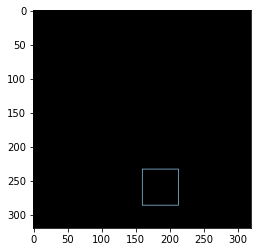

длина 188.97056245803833
длина 228.0
длина 201.65685415267944
длина 217.65685415267944
длина 207.3137083053589
длина 212.0
длина 188.97056245803833
длина 228.0
длина 201.65685415267944
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 185.65685415267944
длина 87.65685415267944
длина 231.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


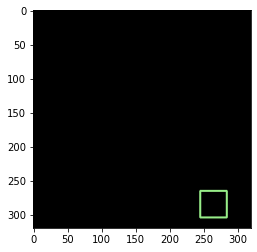

длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 175.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 140.97056198120117
длина 161.65685415267944
длина 143.3137083053589
длина 161.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 151.3137083053589
длина 153.65685415267944
длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 175.3137083053589
длина 135.3137083053589
длина 169.65685415267944
длина 137.65685415267944
длина 167.3137083053589
длина 140.97056198120117
длина 164.0
длина 143.3137083053589
длина 161.65685415267944
длина 145.65685415267944
длина 161.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 148.97056198120117
длина 156.0
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 71.65685415267944
длина 129.6568541526

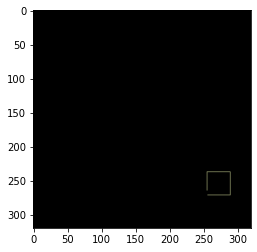

длина 49.65685415267944
длина 49.65685415267944
длина 37.65685415267944
длина 49.65685415267944
длина 268.3847759962082
длина 256.48528122901917
длина 248.48528122901917
длина 266.72792184352875
длина 256.48528122901917
длина 248.48528122901917
длина 267.55634891986847
длина 252.3847759962082
itogo 4


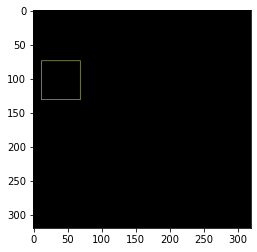

длина 203.3137083053589
длина 245.65685415267944
длина 217.65685415267944
длина 233.65685415267944
длина 223.3137083053589
длина 228.0
длина 203.3137083053589
длина 245.65685415267944
длина 217.65685415267944
длина 233.65685415267944
длина 223.3137083053589
длина 228.0
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 201.65685415267944
длина 95.65685415267944
длина 247.3137083053589
длина 220.97056198120117
длина 234.62741661071777
itogo 5


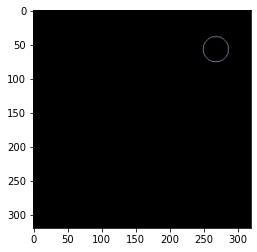

длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 44.14213538169861
длина 44.14213538169861
длина 44.14213538169861
длина 44.14213538169861
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 129.53910541534424
длина 120.56854152679443
длина 123.88224983215332
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
itogo 5


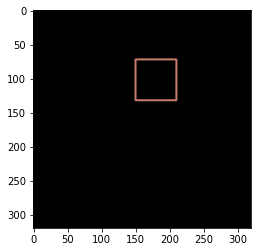

длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 221.65685415267944
длина 251.3137083053589
длина 221.65685415267944
длина 251.3137083053589
длина 227.3137083053589
длина 245.65685415267944
длина 229.65685415267944
длина 245.65685415267944
длина 229.65685415267944
длина 243.3137083053589
длина 235.3137083053589
длина 240.0
длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 221.65685415267944
длина 251.3137083053589
длина 227.3137083053589
длина 245.65685415267944
длина 229.65685415267944
длина 243.3137083053589
длина 235.3137083053589
длина 237.65685415267944
длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 221.65685415267944
длина 251.3137083053589
длина 227.3137083053589
дл

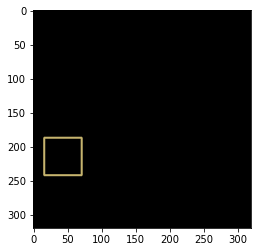

длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 212.97056198120117
длина 220.0
длина 215.3137083053589
длина 217.65685415267944
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.313

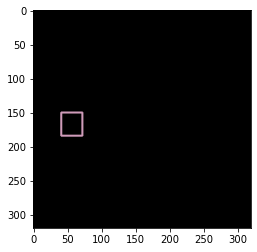

длина 55.65685415267944
длина 103.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 55.65685415267944
длина 149.3137083053589
длина 111.65685415267944
длина 141.3137083053589
длина 111.65685415267944
длина 141.3137083053589
длина 117.31370830535889
длина 135.65685415267944
длина 117.31370830535889
длина 135.65685415267944
длина 119.65685415267944
длина 133.3137083053589
длина 122.97056198120117
длина 130.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 55.65685415267944
длина 103.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 55.65685415267944
длина 149.3137083053589
длина 111.65685415267944
длина 141.3137083053589
длина 114.97056198120117
длина 135.65685415267944
длина 117.31370830535889
длина 135.65685415267944
длина 119.65685415267944
длина 133.3137083053589
длина 125.31370830535889
длина 127.65685415267944
длина 55.65685415267944
длина 103.65685415267944
длина 61.65685415267944
длина

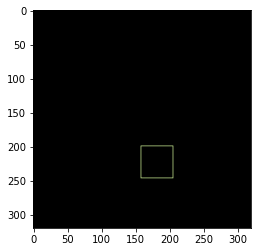

длина 164.97056245803833
длина 204.0
длина 177.65685415267944
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 193.65685415267944
длина 183.3137083053589
длина 188.0
itogo 8


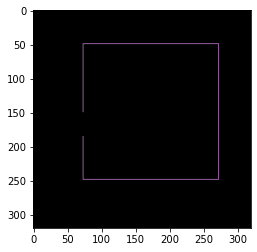

длина 379.65685415267944
длина 109.65685415267944
длина 379.65685415267944
длина 183.65685415267944
длина 379.65685415267944
длина 1530.6274166107178
длина 1519.313708305359
длина 1514.6274166107178
длина 1507.313708305359
длина 1528.9705624580383
длина 1514.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 1529.798989534378
длина 1518.6274166107178
длина 1514.6274166107178
длина 1511.313708305359
itogo 9


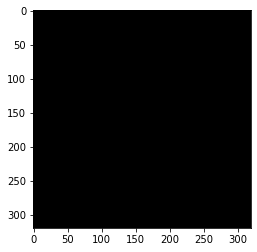

itogo 9
train_data/38.png


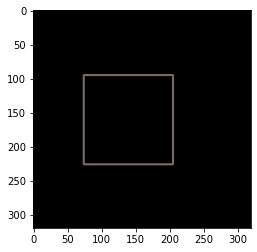

длина 255.65685415267944
длина 497.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 543.3137083053589
длина 505.65685415267944
длина 535.3137083053589
длина 511.3137083053589
длина 529.6568541526794
длина 513.6568541526794
длина 527.3137083053589
длина 519.3137083053589
длина 521.6568541526794
длина 255.65685415267944
длина 497.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 543.3137083053589
длина 505.65685415267944
длина 535.3137083053589
длина 511.3137083053589
длина 529.6568541526794
длина 516.9705619812012
длина 524.0
длина 255.65685415267944
длина 497.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 543.3137083053589
длина 505.65685415267944
длина 535.3137083053589
длина 511.3137083053589
длина 529.6568541526794
длина 516.9705619812012
длина 524.0
itogo 1


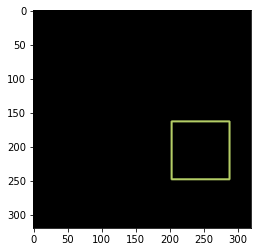

длина 163.65685415267944
длина 313.65685415267944
длина 163.65685415267944
длина 163.65685415267944
длина 163.65685415267944
длина 359.3137083053589
длина 321.65685415267944
длина 351.3137083053589
длина 321.65685415267944
длина 351.3137083053589
длина 327.3137083053589
длина 345.65685415267944
длина 329.65685415267944
длина 343.3137083053589
длина 332.9705619812012
длина 340.0
длина 335.3137083053589
длина 337.65685415267944
длина 163.65685415267944
длина 313.65685415267944
длина 163.65685415267944
длина 163.65685415267944
длина 163.65685415267944
длина 359.3137083053589
длина 321.65685415267944
длина 351.3137083053589
длина 321.65685415267944
длина 351.3137083053589
длина 327.3137083053589
длина 345.65685415267944
длина 327.3137083053589
длина 345.65685415267944
длина 329.65685415267944
длина 343.3137083053589
длина 332.9705619812012
длина 340.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 163.65685415267944
длина 313.65685

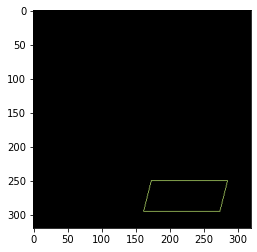

длина 295.94112491607666
длина 338.7695519924164
длина 309.94112491607666
длина 328.7695519924164
длина 315.5979790687561
длина 323.11269783973694
длина 2.8284270763397217
длина 3.414213538169861
длина 3.414213538169861
длина 2.8284270763397217
длина 205.65685415267944
длина 295.11269783973694
длина 205.65685415267944
длина 339.5979790687561
длина 309.94112491607666
длина 328.7695519924164
длина 312.7695519924164
длина 326.4264061450958
длина 318.42640590667725
длина 323.11269783973694
длина 295.94112491607666
длина 338.7695519924164
длина 313.94112491607666
длина 326.4264061450958
itogo 2


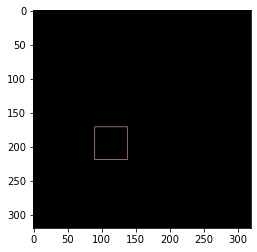

длина 167.3137083053589
длина 209.65685415267944
длина 181.65685415267944
длина 197.65685415267944
длина 184.97056198120117
длина 192.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 167.3137083053589
длина 209.65685415267944
длина 181.65685415267944
длина 197.65685415267944
длина 187.3137083053589
длина 192.0
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 165.65685415267944
длина 77.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 197.65685415267944
длина 187.3137083053589
длина 192.0
itogo 3


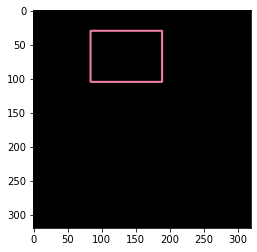

длина 203.65685415267944
длина 333.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 203.65685415267944
длина 379.3137083053589
длина 339.3137083053589
длина 373.65685415267944
длина 341.65685415267944
длина 371.3137083053589
длина 344.9705619812012
длина 368.0
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 352.9705619812012
длина 360.0
длина 355.3137083053589
длина 357.65685415267944
длина 203.65685415267944
длина 333.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 203.65685415267944
длина 379.3137083053589
длина 341.65685415267944
длина 371.3137083053589
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 355.3137083053589
длина 357.65685415267944
длина 203.65685415267944
длина 333.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 203.65685415267944
длина 379.3137

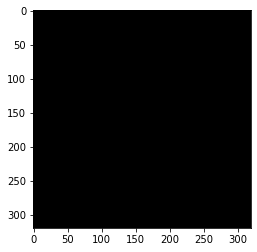

itogo 3
train_data/39.png


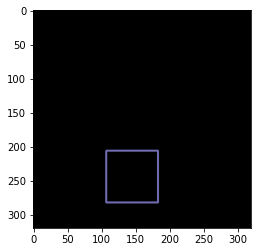

длина 145.65685415267944
длина 277.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 323.3137083053589
длина 285.65685415267944
длина 315.3137083053589
длина 291.3137083053589
длина 309.65685415267944
длина 296.97056245803833
длина 304.0
длина 145.65685415267944
длина 277.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 323.3137083053589
длина 285.65685415267944
длина 315.3137083053589
длина 291.3137083053589
длина 309.65685415267944
длина 296.9705619812012
длина 304.0
длина 145.65685415267944
длина 277.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 323.3137083053589
длина 285.65685415267944
длина 315.3137083053589
длина 285.65685415267944
длина 315.3137083053589
длина 291.3137083053589
длина 309.65685415267944
длина 293.65685415267944
длина 307.3137083053589
длина 296.9705619812012
длина 304.0
длина 6.2426406145095825
длина 6.2426406145095825
дл

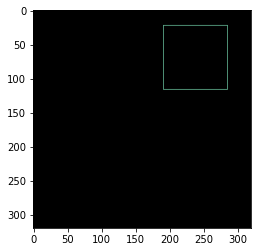

длина 351.3137083053589
длина 393.65685415267944
длина 365.65685415267944
длина 379.3137083053589
длина 169.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 349.65685415267944
длина 169.65685415267944
длина 395.3137083053589
длина 365.65685415267944
длина 381.65685415267944
длина 368.9705619812012
длина 376.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 169.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 349.65685415267944
длина 169.65685415267944
длина 395.3137083053589
длина 365.65685415267944
длина 381.65685415267944
длина 371.3137083053589
длина 376.0
itogo 2


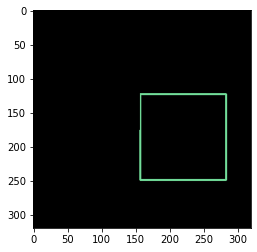

длина 245.65685415267944
длина 141.65685415267944
длина 477.65685415267944
длина 245.65685415267944
длина 245.65685415267944
длина 522.7279218435287
длина 485.65685415267944
длина 514.7279218435287
длина 491.3137083053589
длина 509.65685415267944
длина 900.3847759962082
длина 245.65685415267944
длина 141.65685415267944
длина 477.65685415267944
длина 245.65685415267944
длина 245.65685415267944
длина 522.7279218435287
длина 483.3137083053589
длина 517.0710676908493
длина 485.65685415267944
длина 514.7279218435287
длина 488.9705619812012
длина 509.65685415267944
длина 491.3137083053589
длина 509.65685415267944
длина 493.65685415267944
длина 507.3137083053589
длина 899.5563489198685
длина 894.1421353816986
длина 245.65685415267944
длина 141.65685415267944
длина 477.65685415267944
длина 245.65685415267944
длина 245.65685415267944
длина 522.7279218435287
длина 485.65685415267944
длина 515.3137083053589
длина 488.9705619812012
длина 509.65685415267944
длина 491.3137083053589
длина 509.0710676

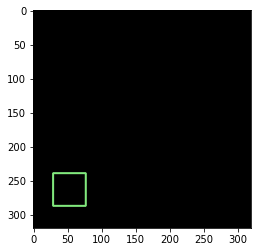

длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 211.3137083053589
длина 173.65685415267944
длина 203.3137083053589
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 192.0
длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 211.3137083053589
длина 171.3137083053589
длина 205.65685415267944
длина 173.65685415267944
длина 203.3137083053589
длина 176.97056198120117
длина 197.65685415267944
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 192.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944

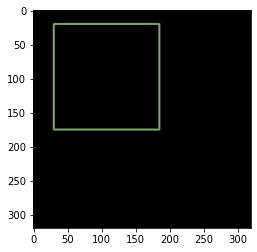

длина 303.65685415267944
длина 593.6568541526794
длина 303.65685415267944
длина 303.65685415267944
длина 303.65685415267944
длина 639.3137083053589
длина 601.6568541526794
длина 631.3137083053589
длина 607.3137083053589
длина 625.6568541526794
длина 609.6568541526794
длина 623.3137083053589
длина 615.3137083053589
длина 620.0
длина 303.65685415267944
длина 593.6568541526794
длина 303.65685415267944
длина 303.65685415267944
длина 303.65685415267944
длина 639.3137083053589
длина 601.6568541526794
длина 631.3137083053589
длина 604.9705619812012
длина 628.0
длина 607.3137083053589
длина 625.6568541526794
длина 609.6568541526794
длина 623.3137083053589
длина 615.3137083053589
длина 620.0
длина 303.65685415267944
длина 593.6568541526794
длина 303.65685415267944
длина 303.65685415267944
длина 303.65685415267944
длина 639.3137083053589
длина 601.6568541526794
длина 631.3137083053589
длина 607.3137083053589
длина 625.6568541526794
длина 612.9705619812012
длина 620.0
itogo 5


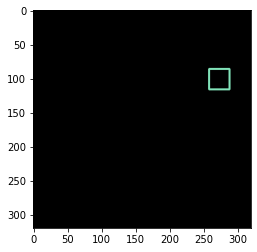

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 99.31370830535889
длина 133.65685415267944
длина 101.65685415267944
длина 131.3137083053589
длина 104.97056198120117
длина 125.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.313708305358

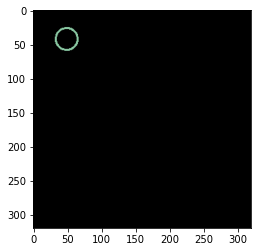

длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 93.25483298301697
длина 118.22539710998535
длина 98.9116872549057
длина 112.56854152679443
длина 98.91168737411499
длина 112.56854057312012
длина 104.56854152679443
длина 106.91168785095215
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 90.91168785095215
длина 120.56854152679443
длина 93.25483322143555
длина 118.22539615631104
длина 98.9116872549057
длина 112.56854152679443
длина 98.91168737411499
длина 112.56854057312012
длина 101.25483298301697
длина 110.22539710998535
длина 104.56854152679443
длина 106.91168785095215
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 93.25483298301697
длина 118.22539710998535
длина 96.5685415

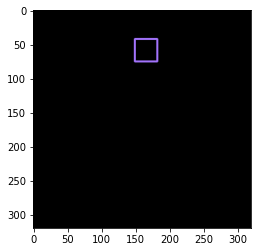

длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 116.97056198120117
длина 140.0
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 111.31370830535889
длина 145.65685415267944
длина 113.65685415267944
длина 143.3137083053589
длина 116.97056198120117
длина 140.0
длина 119.31370830535889
длина 137.65685415267944
длина 119

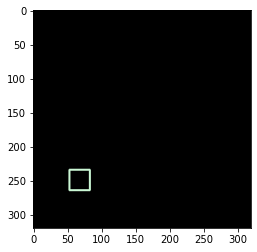

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 112.97056198120117
длина 120.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 99.31370830535889
длина 133.65685415267944
длина 101.65685415267944
длина 131.3137083053589
длина 104.97056198120117
длина 128.0
длина 107.31370830535889
длина 125.65685415267944
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 112.97056198120117
длина 120.0
длина

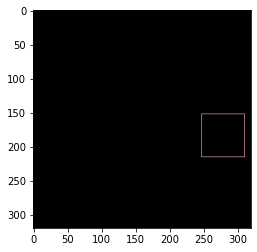

длина 227.3137083053589
длина 269.65685415267944
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 247.3137083053589
длина 252.0
длина 107.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 225.65685415267944
длина 107.65685415267944
длина 271.3137083053589
длина 241.65685415267944
длина 257.65685415267944
длина 247.3137083053589
длина 252.0
длина 228.97056245803833
длина 268.0
длина 241.65685415267944
длина 257.65685415267944
длина 247.3137083053589
длина 252.0
itogo 9


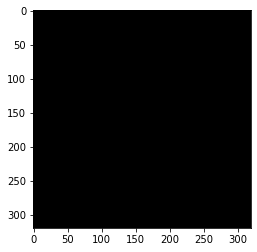

itogo 9
train_data/40.png


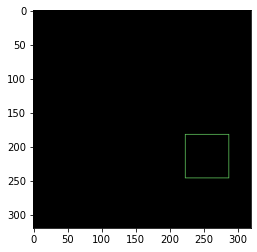

длина 109.65685415267944
длина 109.65685415267944
длина 113.65685415267944
длина 229.65685415267944
длина 113.65685415267944
длина 275.3137083053589
длина 245.65685415267944
длина 259.3137083053589
длина 231.3137083053589
длина 273.65685415267944
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 251.3137083053589
длина 256.0
длина 109.65685415267944
длина 109.65685415267944
длина 113.65685415267944
длина 229.65685415267944
длина 113.65685415267944
длина 275.3137083053589
длина 248.97056198120117
длина 256.0
itogo 1


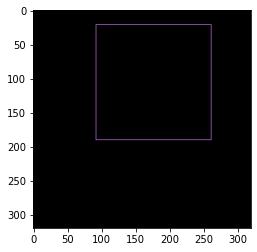

длина 651.3137083053589
длина 693.6568541526794
длина 665.6568541526794
длина 681.6568541526794
длина 668.9705619812012
длина 676.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 652.9705624580383
длина 692.0
длина 665.6568541526794
длина 679.3137083053589
длина 652.9705624580383
длина 692.0
длина 663.3137083053589
длина 681.6568541526794
длина 665.6568541526794
длина 679.3137083053589
длина 671.3137083053589
длина 676.0
itogo 2


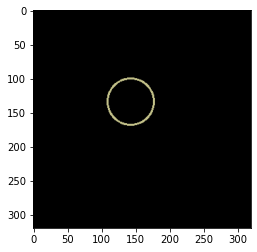

длина 17.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 203.48022842407227
длина 5.656854152679443
длина 17.656854152679443
длина 246.79393863677979
длина 209.13708329200745
длина 241.1370825767517
длина 211.48022985458374
длина 238.793936252594
длина 217.13708353042603
длина 233.1370816230774
длина 217.13708448410034
длина 233.1370825767517
длина 219.48022985458374
длина 230.7939372062683
длина 144.85281205177307
длина 286.1076457500458
длина 17.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 203.48022842407227
длина 5.656854152679443
длина 17.656854152679443
длина 246.79393863677979
длина 209.1370825767517
длина 241.1370825767517
длина 211.48022985458374
длина 238.793936252594
длина 217.13708353042603
длина 233.1370816230774
длина 217.13708448410034
длина 233.1370825767517
длина 219.48022985458

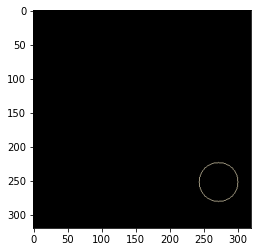

длина 170.5096664428711
длина 208.1665210723877
длина 180.8528127670288
длина 197.82337474822998
длина 186.50966548919678
длина 194.50966548919678
длина 8.0
длина 8.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 8.0
длина 8.0
длина 170.5096664428711
длина 208.1665210723877
длина 180.8528127670288
длина 197.82337474822998
длина 186.50966548919678
длина 192.16651916503906
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 170.5096664428711
длина 208.1665210723877
длина 180.85281372070312
длина 194.50966548919678
длина 71.4558436870575
длина 6.2426406145095825
длина 6.2426406145095825
длина 71.4558436870575
длина 71.4558436870575
длина 6.2426406145095825
длина 6.2426406145095825
длина 71.4558436870575
itogo 2


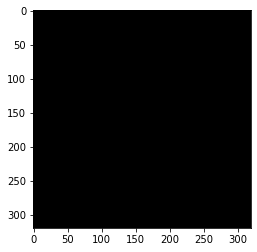

itogo 2
train_data/41.png


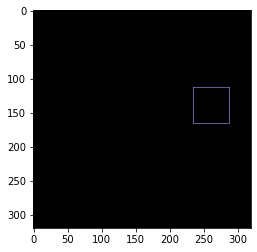

длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 185.65685415267944
длина 87.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 217.65685415267944
длина 207.3137083053589
длина 212.0
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 185.65685415267944
длина 87.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 217.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 187.3137083053589
длина 229.65685415267944
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
itogo 1


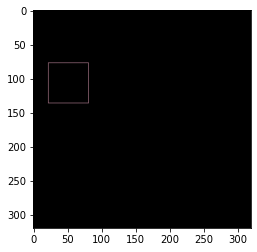

длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 209.65685415267944
длина 99.65685415267944
длина 255.3137083053589
длина 225.65685415267944
длина 241.65685415267944
длина 231.3137083053589
длина 236.0
длина 211.3137083053589
длина 253.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 211.3137083053589
длина 253.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


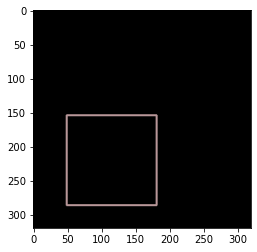

длина 257.65685415267944
длина 501.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 547.3137083053589
длина 509.65685415267944
длина 539.3137083053589
длина 509.65685415267944
длина 539.3137083053589
длина 515.3137083053589
длина 533.6568541526794
длина 517.6568541526794
длина 531.3137083053589
длина 520.9705619812012
длина 528.0
длина 523.3137083053589
длина 525.6568541526794
длина 257.65685415267944
длина 501.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 547.3137083053589
длина 509.65685415267944
длина 539.3137083053589
длина 512.9705619812012
длина 533.6568541526794
длина 515.3137083053589
длина 533.6568541526794
длина 520.9705624580383
длина 528.0
длина 523.3137083053589
длина 525.6568541526794
длина 257.65685415267944
длина 501.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 257.65685415267944
длина 547.3137083053589
длина 509.65685415267944
длина 539.31370830535

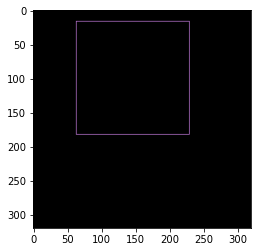

длина 639.3137083053589
длина 681.6568541526794
длина 653.6568541526794
длина 669.6568541526794
длина 656.9705619812012
длина 664.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 313.65685415267944
длина 313.65685415267944
длина 313.65685415267944
длина 637.6568541526794
длина 313.65685415267944
длина 683.3137083053589
длина 653.6568541526794
длина 667.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 639.3137083053589
длина 681.6568541526794
длина 651.3137083053589
длина 669.6568541526794
длина 653.6568541526794
длина 667.3137083053589
длина 659.3137083053589
длина 664.0
itogo 4


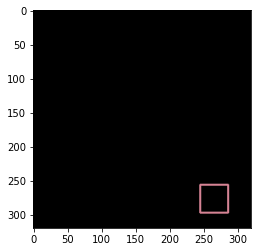

длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 156.97056198120117
длина 164.0
длина 159.3137083053589
длина 161.65685415267944
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
дл

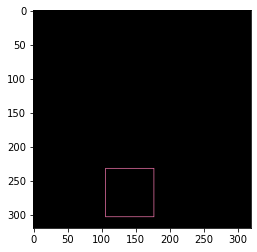

длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 257.65685415267944
длина 123.65685415267944
длина 303.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 279.3137083053589
длина 284.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 257.65685415267944
длина 123.65685415267944
длина 303.3137083053589
длина 273.65685415267944
длина 287.3137083053589
длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
itogo 6


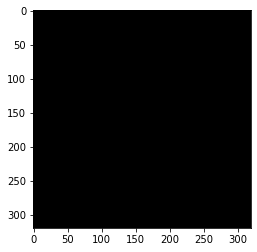

itogo 6
train_data/42.png


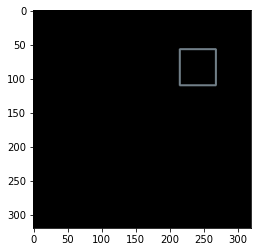

длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 204.97056245803833
длина 212.0
длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 209.65685415267944
длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 204.97056198120117
длина 212.0
itogo 1


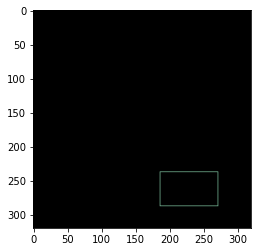

длина 245.3137083053589
длина 287.65685415267944
длина 259.65685415267944
длина 273.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 151.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 243.65685415267944
длина 151.65685415267944
длина 289.3137083053589
длина 259.65685415267944
длина 275.65685415267944
длина 262.9705619812012
длина 270.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 245.3137083053589
длина 287.65685415267944
длина 259.65685415267944
длина 275.65685415267944
длина 265.3137083053589
длина 270.0
itogo 1


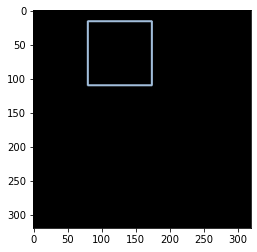

длина 181.65685415267944
длина 349.65685415267944
длина 181.65685415267944
длина 181.65685415267944
длина 181.65685415267944
длина 395.3137083053589
длина 357.65685415267944
длина 387.3137083053589
длина 360.9705619812012
длина 384.0
длина 363.3137083053589
длина 381.65685415267944
длина 365.65685415267944
длина 379.3137083053589
длина 371.3137083053589
длина 376.0
длина 181.65685415267944
длина 349.65685415267944
длина 181.65685415267944
длина 181.65685415267944
длина 181.65685415267944
длина 395.3137083053589
длина 357.65685415267944
длина 387.3137083053589
длина 357.65685415267944
длина 387.3137083053589
длина 363.3137083053589
длина 381.65685415267944
длина 365.65685415267944
длина 381.65685415267944
длина 365.65685415267944
длина 379.3137083053589
длина 371.3137083053589
длина 373.65685415267944
длина 181.65685415267944
длина 349.65685415267944
длина 181.65685415267944
длина 181.65685415267944
длина 181.65685415267944
длина 395.3137083053589
длина 355.3137083053589
длина 389.65685

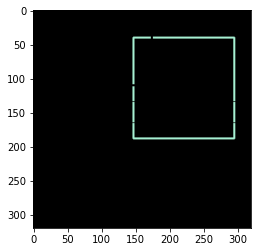

длина 289.65685415267944
длина 39.65685415267944
длина 39.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 37.65685415267944
длина 565.6568541526794
длина 181.65685415267944
длина 129.65685415267944
длина 231.65685415267944
длина 43.65685415267944
длина 611.3137083053589
длина 986.3847759962082
длина 193.89949476718903
длина 980.7279214859009
длина 188.2426404953003
длина 985.012192606926
длина 185.89949476718903
длина 382.1421353816986
длина 59.65685415267944
длина 59.65685415267944
длина 42.82842707633972
длина 423.0710676908493
длина 184.24264061450958
длина 377.65685415267944
длина 54.0
длина 54.0
длина 38.0
длина 418.8284270763397
длина 180.82842707633972
длина 289.65685415267944
длина 39.65685415267944
длина 39.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 37.65685415267944
длина 565.6568541526794
длина 181.65685415267944
длина 129.65685415267944
длина 231.65685415267944
длина 43.65685415267944
длина 611.3137083053589
длина 986.384775996

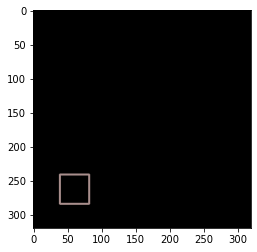

длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 164.97056198120117
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 164.97056198120117
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
д

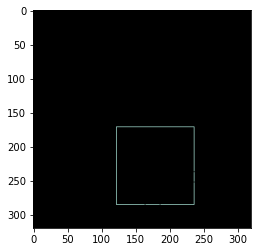

длина 81.65685415267944
длина 25.656854152679443
длина 65.65685415267944
длина 47.65685415267944
длина 11.656854152679443
длина 113.65685415267944
длина 209.65685415267944
длина 436.2842707633972
длина 209.65685415267944
длина 478.6274166107178
длина 445.65685415267944
длина 461.65685415267944
длина 36.0
длина 156.82842707633972
длина 22.0
длина 660.4852812290192
длина 81.65685415267944
длина 25.656854152679443
длина 65.65685415267944
длина 47.65685415267944
длина 11.656854152679443
длина 113.65685415267944
длина 209.65685415267944
длина 436.2842707633972
длина 209.65685415267944
длина 481.94112491607666
длина 443.3137083053589
длина 461.65685415267944
длина 448.97056245803833
длина 462.6274166107178
длина 36.0
длина 156.82842707633972
длина 22.0
длина 660.4852812290192
длина 434.6274166107178
длина 473.65685415267944
длина 443.3137083053589
длина 461.65685415267944
длина 41.65685415267944
длина 161.89949476718903
длина 27.656854152679443
длина 664.3847759962082
длина 32.0
длина 152.82

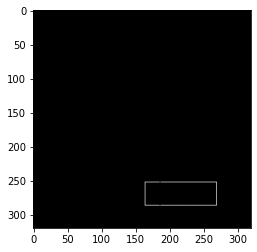

длина 256.6274166107178
длина 295.65685415267944
длина 265.3137083053589
длина 283.65685415267944
длина 269.3137083053589
длина 282.97056245803833
длина 389.65685415267944
длина 145.65685415267944
длина 147.65685415267944
длина 25.656854152679443
длина 49.65685415267944
длина 49.65685415267944
длина 253.3137083053589
длина 147.65685415267944
длина 25.656854152679443
длина 298.97056245803833
длина 265.3137083053589
длина 283.65685415267944
длина 269.3137083053589
длина 282.97056245803833
длина 389.65685415267944
длина 145.65685415267944
длина 147.65685415267944
длина 25.656854152679443
длина 49.65685415267944
длина 49.65685415267944
длина 254.97056245803833
длина 147.65685415267944
длина 25.656854152679443
длина 300.6274166107178
длина 265.3137083053589
длина 283.65685415267944
длина 269.3137083053589
длина 282.97056245803833
длина 389.65685415267944
длина 145.65685415267944
itogo 5


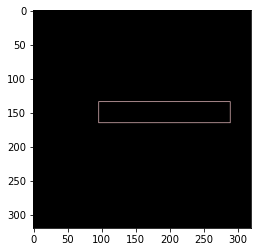

длина 423.3137083053589
длина 465.65685415267944
длина 435.3137083053589
длина 453.65685415267944
длина 437.65685415267944
длина 451.3137083053589
длина 443.3137083053589
длина 448.0
длина 424.97056245803833
длина 464.0
длина 437.65685415267944
длина 453.65685415267944
длина 440.9705619812012
длина 448.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 367.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 421.65685415267944
длина 367.65685415267944
длина 467.3137083053589
длина 437.65685415267944
длина 453.65685415267944
длина 440.9705619812012
длина 448.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


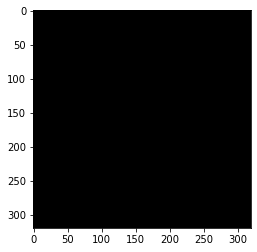

itogo 5
train_data/43.png


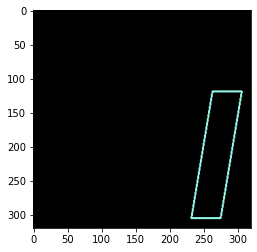

длина 79.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.65685415

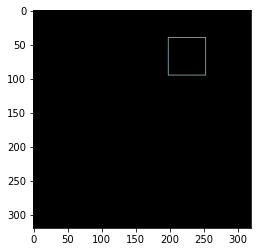

длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 196.97056245803833
длина 236.0
длина 209.65685415267944
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
itogo 1


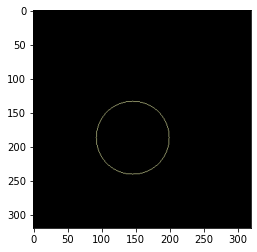

длина 335.3624801635742
длина 375.36247730255127
длина 348.0487699508667
длина 359.3624792098999
длина 353.70562267303467
длина 357.01933002471924
длина 335.3624801635742
длина 375.36247730255127
длина 348.0487699508667
длина 359.3624792098999
длина 353.705623626709
длина 357.01933193206787
длина 335.3624801635742
длина 375.36247730255127
длина 351.3624782562256
длина 359.3624792098999
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
itogo 1


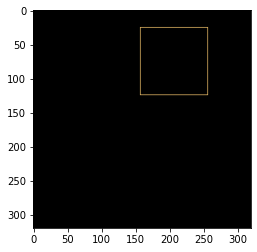

длина 371.3137083053589
длина 413.65685415267944
длина 383.3137083053589
длина 401.65685415267944
длина 385.65685415267944
длина 399.3137083053589
длина 391.3137083053589
длина 396.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 371.3137083053589
длина 413.65685415267944
длина 385.65685415267944
длина 401.65685415267944
длина 388.9705619812012
длина 396.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 179.65685415267944
длина 179.65685415267944
длина 183.65685415267944
длина 369.65685415267944
длина 183.65685415267944
длина 415.3137083053589
длина 385.65685415267944
длина 399.3137083053589
itogo 2


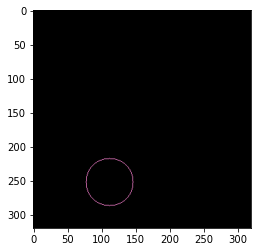

длина 209.13708400726318
длина 249.13708305358887
длина 219.48023128509521
длина 238.79393768310547
длина 225.13708305358887
длина 233.13708209991455
длина 78.62741661071777
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 78.62741661071777
длина 78.62741661071777
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 78.62741661071777
длина 209.13708400726318
длина 249.13708305358887
длина 225.13708305358887
длина 233.13708209991455
длина 209.13708400726318
длина 249.13708305358887
длина 221.82337379455566
длина 236.45079135894775
длина 227.48022937774658
длина 230.7939395904541
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
itogo 2


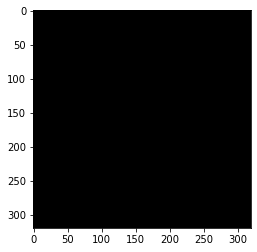

itogo 2
train_data/44.png


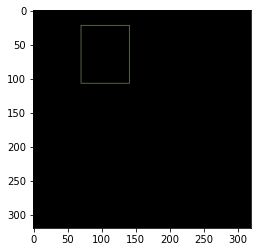

длина 288.97056245803833
длина 328.0
длина 301.65685415267944
длина 315.3137083053589
длина 287.3137083053589
длина 329.65685415267944
длина 301.65685415267944
длина 317.65685415267944
длина 307.3137083053589
длина 312.0
длина 288.97056245803833
длина 328.0
длина 304.9705619812012
длина 312.0
itogo 0


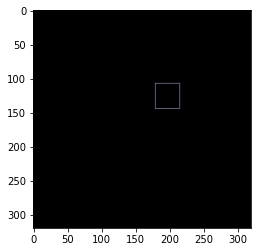

длина 122.97056245803833
длина 162.0
длина 135.65685415267944
длина 149.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 121.31370830535889
длина 163.65685415267944
длина 135.65685415267944
длина 151.65685415267944
длина 141.3137083053589
длина 146.0
длина 121.31370830535889
длина 163.65685415267944
длина 135.65685415267944
длина 151.65685415267944
длина 141.3137083053589
длина 146.0
itogo 1


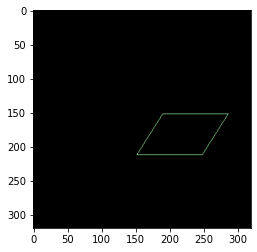

длина 311.82337474823
длина 357.4802289009094
длина 331.48022866249084
длина 346.30865597724915
длина 187.41421353816986
длина 187.41421353816986
длина 311.82337474823
длина 357.4802289009094
длина 328.6518018245697
длина 349.1370828151703
длина 332.6518018245697
длина 346.30865597724915
длина 190.82842707633972
длина 190.82842707633972
длина 2.0
длина 2.0
длина 311.82337474823
длина 357.4802289009094
длина 328.6518015861511
длина 347.4802289009094
длина 189.41421353816986
длина 189.41421353816986
itogo 1


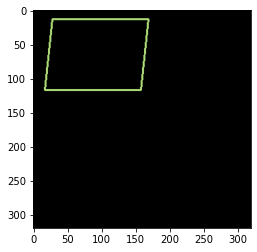

длина 275.65685415267944
длина 5.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 472.7695519924164
длина 5.656854152679443
длина 275.65685415267944
длина 518.4264061450958
длина 480.7695519924164
длина 510.4264061450958
длина 480.7695519924164
длина 510.4264061450958
длина 486.4264061450958
длина 504.7695519924164
длина 488.7695519924164
длина 502.4264061450958
длина 490.7695517539978
длина 490.7695517539978
длина 275.65685415267944
длина 5.656854152679443
длина 15.656854152679443
длина 15.656854152679443
длина 13.656854

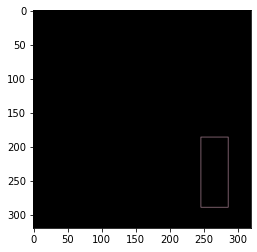

длина 61.65685415267944
длина 187.65685415267944
длина 187.65685415267944
длина 259.65685415267944
длина 61.65685415267944
длина 305.3137083053589
длина 275.65685415267944
длина 291.65685415267944
длина 281.3137083053589
длина 286.0
длина 262.97056245803833
длина 302.0
длина 275.65685415267944
длина 289.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 262.97056245803833
длина 302.0
длина 275.65685415267944
длина 291.65685415267944
длина 281.3137083053589
длина 286.0
itogo 1


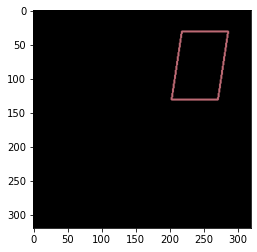

длина 129.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 319.25483322143555
длина 129.65685415267944
длина 366.08326029777527
длина 327.25483322143555
длина 359.7401144504547
длина 331.25483322143555
длина 359.7401144504547
длина 334.08326029777527
длина 354.08326029777527
длина 338.08326029777527
длина 351.7401144504547
длина 339.7401144504547
длина 3

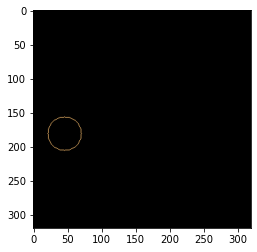

длина 143.1959571838379
длина 183.1959581375122
длина 155.88224983215332
длина 170.5096664428711
длина 161.53910398483276
длина 169.5391035079956
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 143.1959571838379
длина 183.1959581375122
длина 155.88224983215332
длина 167.1959571838379
длина 67.4558436870575
длина 67.4558436870575
длина 67.4558436870575
длина 67.4558436870575
длина 143.1959571838379
длина 183.1959581375122
длина 161.5391035079956
длина 164.85281372070312
itogo 1


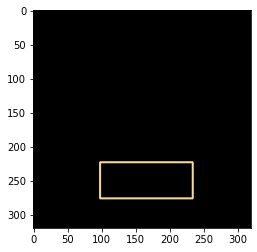

длина 265.65685415267944
длина 351.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 265.65685415267944
длина 397.3137083053589
длина 357.3137083053589
длина 391.65685415267944
длина 359.65685415267944
длина 389.3137083053589
длина 362.9705619812012
длина 386.0
длина 365.3137083053589
длина 383.65685415267944
длина 367.65685415267944
длина 383.65685415267944
длина 367.65685415267944
длина 381.3137083053589
длина 370.9705619812012
длина 378.0
длина 373.3137083053589
длина 375.65685415267944
длина 265.65685415267944
длина 351.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 265.65685415267944
длина 397.3137083053589
длина 359.65685415267944
длина 389.3137083053589
длина 359.65685415267944
длина 389.3137083053589
длина 365.3137083053589
длина 383.65685415267944
длина 365.3137083053589
длина 383.65685415267944
длина 367.65685415267944
длина 381.3137083053589
длина 370.9705619812012
длина 378.0
длина 373.3137083053589
длина 375.65685415267944
длина 265

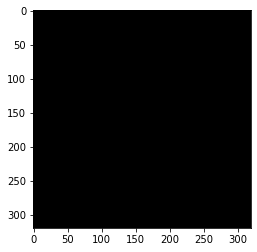

itogo 1
train_data/45.png


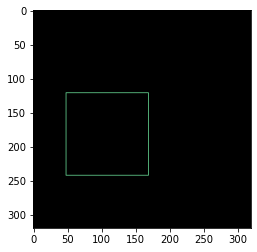

длина 460.97056245803833
длина 500.0
длина 473.65685415267944
длина 487.3137083053589
длина 459.3137083053589
длина 501.65685415267944
длина 471.3137083053589
длина 489.65685415267944
длина 473.65685415267944
длина 487.3137083053589
длина 479.3137083053589
длина 484.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 223.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 457.65685415267944
длина 223.65685415267944
длина 503.3137083053589
длина 473.65685415267944
длина 489.65685415267944
длина 479.3137083053589
длина 484.0
itogo 1


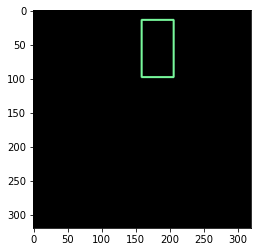

длина 87.65685415267944
длина 235.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 281.3137083053589
длина 243.65685415267944
длина 273.3137083053589
длина 249.3137083053589
длина 267.65685415267944
длина 251.65685415267944
длина 265.3137083053589
длина 257.3137083053589
длина 259.65685415267944
длина 87.65685415267944
длина 235.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 281.3137083053589
длина 241.3137083053589
длина 275.65685415267944
длина 243.65685415267944
длина 273.3137083053589
длина 246.97056198120117
длина 270.0
длина 249.3137083053589
длина 267.65685415267944
длина 249.3137083053589
длина 267.65685415267944
длина 251.65685415267944
длина 265.3137083053589
длина 254.97056198120117
длина 262.0
длина 257.3137083053589
длина 259.65685415267944
длина 87.65685415267944
длина 235.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 281.313708305

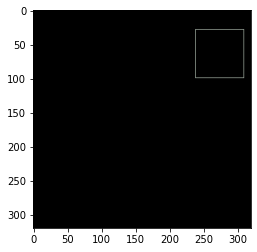

длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
itogo 2


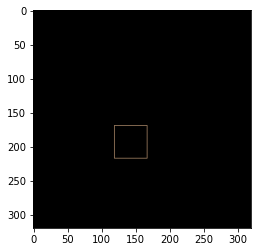

длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 165.65685415267944
длина 77.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 197.65685415267944
длина 184.97056198120117
длина 192.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 168.97056245803833
длина 208.0
длина 181.65685415267944
длина 197.65685415267944
длина 187.3137083053589
длина 192.0
длина 167.3137083053589
длина 209.65685415267944
длина 181.65685415267944
длина 195.3137083053589
itogo 3


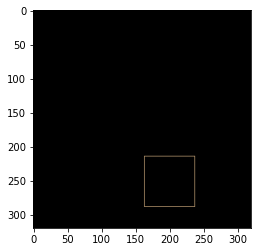

длина 271.3137083053589
длина 313.65685415267944
длина 285.65685415267944
длина 301.65685415267944
длина 288.9705619812012
длина 296.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 271.3137083053589
длина 313.65685415267944
длина 285.65685415267944
длина 301.65685415267944
длина 291.3137083053589
длина 296.0
длина 272.97056245803833
длина 312.0
длина 285.65685415267944
длина 299.3137083053589
itogo 4


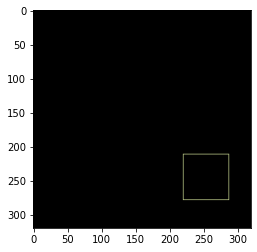

длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 241.65685415267944
длина 115.65685415267944
длина 287.3137083053589
длина 257.65685415267944
длина 273.65685415267944
длина 260.9705619812012
длина 268.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 241.65685415267944
длина 115.65685415267944
длина 287.3137083053589
длина 257.65685415267944
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
длина 244.97056245803833
длина 284.0
длина 257.65685415267944
длина 273.65685415267944
длина 263.3137083053589
длина 268.0
itogo 5


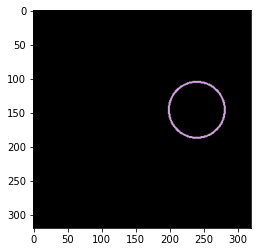

длина 21.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 250.1076464653015
длина 7.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 293.4213538169861
длина 255.764497756958
длина 287.1787134408951
длина 258.107647895813
длина 285.4213535785675
длина 263.76449966430664
длина 279.7644991874695
длина 263.76450061798096
длина 279.7644993066788
длина 263.764497756958
длина 279.1787134408951
длина 269.4213557243347
длина 274.1076452732086
длина 20.0
длина 6.0
длина 4.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 8.485280990600586
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 6.0
длина 6.0
длина 20.0
длина 20.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 5.6568541526794

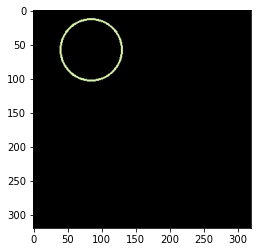

длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 277.42135286331177
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 318.39191579818726
длина 283.0782084465027
длина 312.73506259918213
длина 285.42135286331177
длина 310.391916513443
длина 288.7350630760193
длина 307.07820749282837
длина 291.07820749282837
длина 304.73506212234497
длина 291.0782084465027
длина 304.73506259918213
длина 296.73506236076355
длина 299.0782082080841
длина 20.0
длина 4.0
длина 4.0
длина 2.0
длина 4.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 13.899494767189026
длина 5.656854152679443
длина 5.656854152679443
длина 2.8284270763397217
длина 2.8284270763397217
д

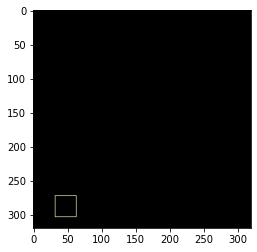

длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124.0
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124.0
длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
itogo 6


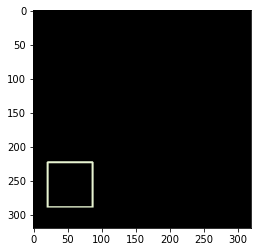

длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 281.3137083053589
длина 243.3137083053589
длина 275.65685415267944
длина 245.65685415267944
длина 273.3137083053589
длина 248.97056198120117
длина 268.8284270763397
длина 251.3137083053589
длина 268.8284270763397
длина 253.65685415267944
длина 266.48528122901917
длина 394.1421353816986
длина 392.48528122901917
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 281.3137083053589
длина 243.3137083053589
длина 275.65685415267944
длина 245.65685415267944
длина 273.3137083053589
длина 248.97056198120117
длина 270.0
длина 251.3137083053589
длина 268.8284270763397
длина 253.65685415267944
длина 267.65685415267944
длина 400.97056245803833
длина 391.3137080669403
длина 388.48528122901917
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 281.3137083053589
длина 245.65685415267944
дл

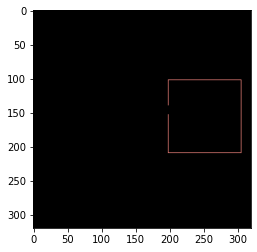

длина 837.798989534378
длина 826.6274166107178
длина 822.6274166107178
длина 819.3137083053589
длина 836.9705624580383
длина 822.6274166107178
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 195.65685415267944
длина 97.65685415267944
длина 195.65685415267944
длина 59.65685415267944
длина 195.65685415267944
длина 838.6274166107178
длина 822.6274166107178
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 8


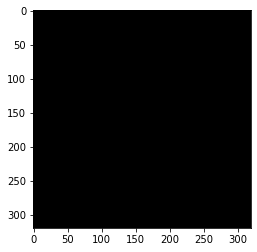

itogo 8
train_data/46.png


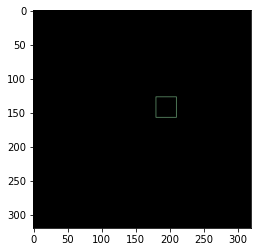

длина 41.65685415267944
длина 41.65685415267944
длина 45.65685415267944
длина 93.65685415267944
длина 45.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 123.31370830535889
длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 123.31370830535889
itogo 1


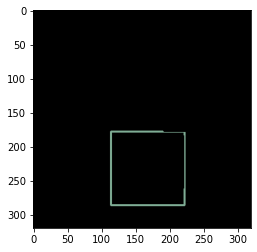

длина 209.65685415267944
длина 43.65685415267944
длина 405.899494767189
длина 209.65685415267944
длина 147.65685415267944
длина 450.72792184352875
длина 414.48528122901917
длина 442.72792184352875
длина 801.798989534378
длина 795.798989534378
длина 4.0
длина 622.7279218435287
длина 209.65685415267944
длина 43.65685415267944
длина 405.899494767189
длина 209.65685415267944
длина 147.65685415267944
длина 450.72792184352875
длина 414.48528122901917
длина 442.72792184352875
длина 415.899494767189
длина 442.1421353816986
длина 801.798989534378
длина 795.798989534378
длина 6.0
длина 626.7279214859009
длина 209.65685415267944
длина 43.65685415267944
длина 405.899494767189
длина 209.65685415267944
длина 147.65685415267944
длина 450.72792184352875
длина 414.48528122901917
длина 442.72792184352875
длина 418.3847756385803
длина 437.0710676908493
длина 798.3847759962082
длина 9.41421353816986
длина 628.7279218435287
длина 10.242640614509583
длина 10.242640614509583
длина 0.0
длина 10.24264061450958

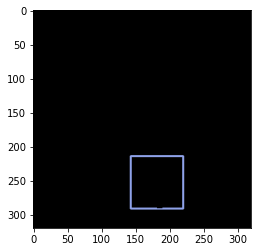

длина 55.65685415267944
длина 71.65685415267944
длина 282.48528122901917
длина 147.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 327.3137083053589
длина 290.48528122901917
длина 319.3137083053589
длина 296.1421353816986
длина 313.65685415267944
длина 298.48528122901917
длина 313.65685415267944
длина 590.9705619812012
длина 55.65685415267944
длина 71.65685415267944
длина 282.48528122901917
длина 147.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 327.3137083053589
длина 290.48528122901917
длина 319.3137083053589
длина 293.7989890575409
длина 316.0
длина 296.1421353816986
длина 313.65685415267944
длина 596.6274166107178
длина 589.3137083053589
длина 55.65685415267944
длина 71.65685415267944
длина 282.48528122901917
длина 147.65685415267944
длина 147.65685415267944
длина 147.65685415267944
длина 327.3137083053589
длина 288.1421353816986
длина 321.65685415267944
длина 290.48528122901917
длина 319.3137083053589
длина 293.7989890575409
длина 31

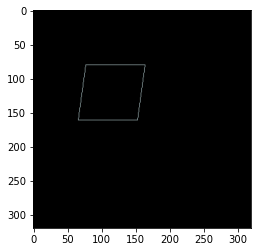

длина 320.7695519924164
длина 361.94112491607666
длина 334.7695519924164
длина 350.7695519924164
длина 179.65685415267944
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 179.65685415267944
длина 320.7695519924164
длина 361.94112491607666
длина 334.7695519924164
длина 350.7695519924164
длина 340.4264061450958
длина 345.11269783973694
длина 321.5979790687561
длина 361.11269783973694
длина 334.7695519924164
длина 350.7695519924164
длина 340.4264061450958
длина 345.11269783973694
itogo 3


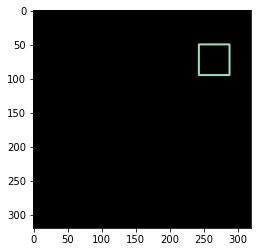

длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 164.97056198120117
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 175.3137083053589
длина 177.65685415267944
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.65685415267944
длина 161.65685415267944
длина 191.3137083053589
длина 164.97056198120117
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 172.97056245803833
длина 180.0
длина 175.3137083053589
длина 177.65685415267944
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3

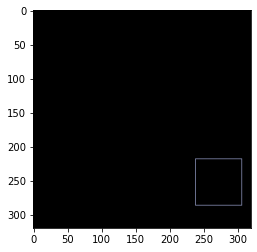

длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 245.65685415267944
длина 117.65685415267944
длина 291.3137083053589
длина 261.65685415267944
длина 277.65685415267944
длина 267.3137083053589
длина 272.0
длина 247.3137083053589
длина 289.65685415267944
длина 261.65685415267944
длина 277.65685415267944
длина 267.3137083053589
длина 272.0
длина 247.3137083053589
длина 289.65685415267944
длина 261.65685415267944
длина 277.65685415267944
длина 264.9705619812012
длина 272.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


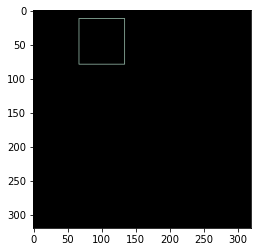

длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 241.65685415267944
длина 115.65685415267944
длина 287.3137083053589
длина 257.65685415267944
длина 273.65685415267944
длина 263.3137083053589
длина 268.0
длина 243.3137083053589
длина 285.65685415267944
длина 257.65685415267944
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 263.3137083053589
длина 268.0
длина 243.3137083053589
длина 285.65685415267944
длина 257.65685415267944
длина 273.65685415267944
длина 260.9705619812012
длина 268.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 6


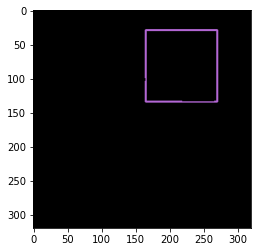

длина 101.65685415267944
длина 55.65685415267944
длина 394.48528122901917
длина 203.65685415267944
длина 135.65685415267944
длина 203.65685415267944
длина 440.1421353816986
длина 402.48528122901917
длина 432.1421353816986
длина 402.48528122901917
длина 432.1421353816986
длина 408.1421353816986
длина 426.48528122901917
длина 410.48528122901917
длина 424.1421353816986
длина 164.2426404953003
длина 562.7279214859009
длина 156.24264061450958
длина 554.7279218435287
длина 101.65685415267944
длина 55.65685415267944
длина 394.48528122901917
длина 203.65685415267944
длина 135.65685415267944
длина 203.65685415267944
длина 440.1421353816986
длина 402.48528122901917
длина 432.1421353816986
длина 408.1421353816986
длина 426.48528122901917
длина 164.2426404953003
длина 562.7279214859009
длина 101.65685415267944
длина 55.65685415267944
длина 394.48528122901917
длина 203.65685415267944
длина 135.65685415267944
длина 203.65685415267944
длина 440.1421353816986
длина 402.48528122901917
длина 432.1421353

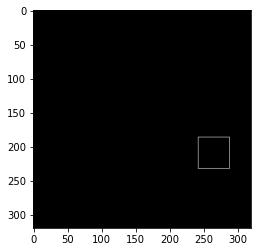

длина 159.3137083053589
длина 201.65685415267944
длина 173.65685415267944
длина 189.65685415267944
длина 176.97056198120117
длина 184.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 159.3137083053589
длина 201.65685415267944
длина 173.65685415267944
длина 189.65685415267944
длина 176.97056198120117
длина 184.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 159.3137083053589
длина 201.65685415267944
длина 173.65685415267944
длина 189.65685415267944
длина 176.97056198120117
длина 184.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 8


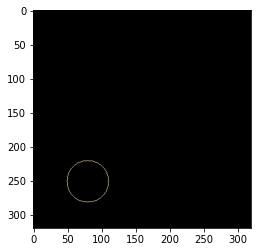

длина 181.8233757019043
длина 221.82337474822998
длина 194.50966548919678
длина 209.13708305358887
длина 200.1665210723877
длина 203.48023128509521
длина 181.8233757019043
длина 221.82337474822998
длина 194.50966548919678
длина 205.82337474822998
длина 86.76955199241638
длина 86.76955199241638
длина 86.76955199241638
длина 86.76955199241638
длина 181.8233757019043
длина 221.82337474822998
длина 194.50966548919678
длина 205.82337474822998
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
itogo 8


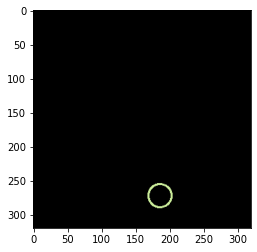

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 96.56854057312012
длина 128.56854152679443
длина 98.91168785095215
длина 126.22539556026459
длина 104.56854152679443
длина 120.56854152679443
длина 104.56854057312012
длина 120.56854128837585
длина 106.91168689727783
длина 118.22539615631104
длина 110.22539710998535
длина 114.9116872549057
длина 5.656854152679443
длина 8.485280990600586
длина 8.485280990600586
длина 11.313708305358887
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 96.56854057312012
длина 128.56854128837585
длина 98.91168785095215
длина 126.22539567947388
длина 102.22539710998535
длина 122.9116872549057
длина 104.56854057312012
длина 120.56854128837585
длина 104.56854057312012
длина 120.56854128837585
длина 106.91168785095215
длина 118.22539567947388
длина 110.2

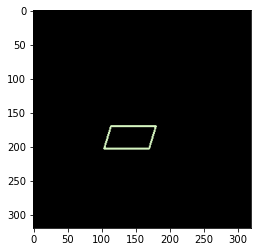

длина 127.65685415267944
длина 7.656854152679443
длина 178.28427076339722
длина 7.656854152679443
длина 127.65685415267944
длина 223.94112491607666
длина 186.28427076339722
длина 217.59797883033752
длина 186.28427076339722
длина 215.94112491607666
длина 191.94112491607666
длина 211.94112491607666
длина 191.94112491607666
длина 211.94112491607666
длина 194.28427076339722
длина 207.94112491607666
длина 145.3137080669403
длина 46.97056245803833
длина 46.97056245803833
длина 145.3137080669403
длина 132.82842707633972
длина 2.0
длина 2.0
длина 132.82842707633972
длина 127.65685415267944
длина 7.656854152679443
длина 178.28427076339722
длина 7.656854152679443
длина 127.65685415267944
длина 223.94112491607666
длина 183.94112491607666
длина 219.94112491607666
длина 186.28427076339722
длина 217.5979790687561
длина 187.94112467765808
длина 214.28427076339722
длина 191.94112491607666
длина 211.94112491607666
длина 194.28427076339722
длина 211.94112491607666
длина 194.28427076339722
длина 207.9411

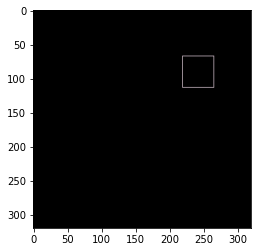

длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 157.65685415267944
длина 73.65685415267944
длина 203.3137083053589
длина 171.3137083053589
длина 189.65685415267944
длина 173.65685415267944
длина 187.3137083053589
длина 179.3137083053589
длина 184.0
длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 157.65685415267944
длина 73.65685415267944
длина 203.3137083053589
длина 173.65685415267944
длина 189.65685415267944
длина 176.97056198120117
длина 184.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 160.97056245803833
длина 200.0
длина 173.65685415267944
длина 189.65685415267944
длина 173.65685415267944
длина 187.3137083053589
длина 179.3137083053589
длина 184.0
itogo 9


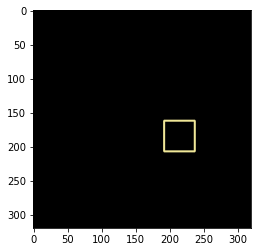

длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.65685415267944
длина 161.65685415267944
длина 191.3137083053589
длина 164.97056198120117
длина 188.0
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 172.97056198120117
длина 180.0
длина 175.3137083053589
длина 177.65685415267944
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.65685415267944
длина 161.65685415267944
длина 191.3137083053589
длина 164.97056198120117
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 169.65685415267944
длина 183.3137083053589
длина 175.3137083053589
длина 180.0
длина 83.6

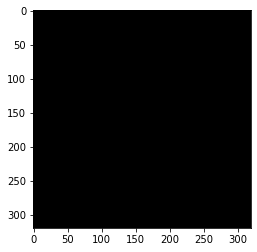

itogo 10
train_data/47.png


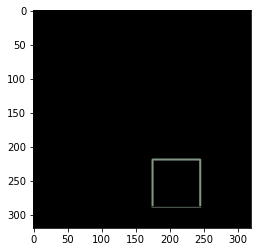

длина 253.65685415267944
длина 129.65685415267944
длина 129.65685415267944
длина 133.65685415267944
длина 298.48528122901917
длина 263.65685415267944
длина 289.3137083053589
длина 418.1421353816986
длина 410.1421353816986
длина 405.65685415267944
длина 253.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 133.65685415267944
длина 298.48528122901917
длина 263.65685415267944
длина 289.3137083053589
длина 269.3137080669403
длина 283.65685415267944
длина 411.3137083053589
длина 404.48528122901917
длина 400.48528122901917
длина 253.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 133.65685415267944
длина 298.48528122901917
длина 263.65685415267944
длина 289.3137083053589
длина 419.3137083053589
длина 410.1421353816986
длина 405.65685415267944
itogo 1


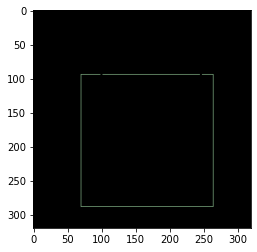

длина 754.6274166107178
длина 793.6568541526794
длина 285.65685415267944
длина 1246.6274166107178
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 754.6274166107178
длина 793.6568541526794
длина 288.0
длина 1251.313708305359
длина 280.0
длина 1240.9705619812012
длина 369.65685415267944
длина 369.65685415267944
длина 369.65685415267944
длина 752.9705624580383
длина 17.656854152679443
длина 273.65685415267944
длина 41.65685415267944
длина 798.6274166107178
длина 285.65685415267944
длина 1248.9705624580383
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


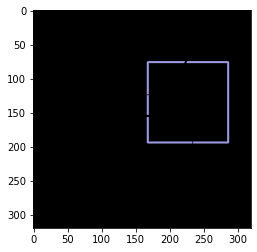

длина 95.65685415267944
длина 5.656854152679443
длина 123.65685415267944
длина 67.65685415267944
длина 49.65685415267944
длина 5.656854152679443
длина 229.65685415267944
длина 446.48528122901917
длина 87.65685415267944
длина 113.65685415267944
длина 101.65685415267944
длина 492.1421353816986
длина 670.9705624580383
длина 269.3137083053589
длина 666.1421350240707
длина 264.2426404953003
длина 664.6274166107178
длина 263.55634891986847
длина 199.89949476718903
длина 53.65685415267944
длина 454.1421353816986
длина 197.89949476718903
длина 194.24264061450958
длина 48.0
длина 448.48528122901917
длина 192.24264061450958
длина 97.65685415267944
длина 125.65685415267944
длина 67.65685415267944
длина 51.65685415267944
длина 229.65685415267944
длина 446.48528122901917
длина 89.65685415267944
длина 113.65685415267944
длина 101.65685415267944
длина 492.1421353816986
длина 670.9705624580383
длина 269.3137083053589
длина 664.3847756385803
длина 263.07106757164
длина 664.6274166107178
длина 263.55634

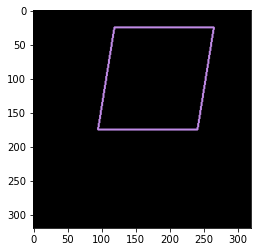

длина 285.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.6568541

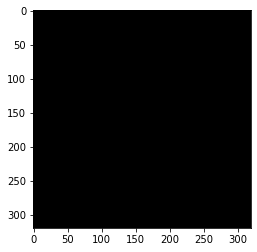

itogo 3
train_data/48.png


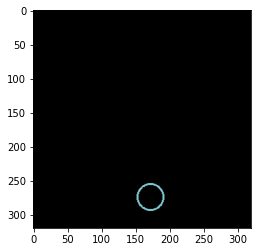

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длина 147.88224947452545
длина 112.56854152679443
длина 139.8822501897812
длина 118.22539591789246
длина 133.63960933685303
длина 119.39696907997131
длина 131.88224983215332
длина 37.31370830535889
длина 17.55634880065918
длина 7.656854152679443
длина 44.97056245803833
длина 54.870057106018066
длина 37.31370830535889
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длина 147.88224959373474
длина 111.39696907997131
длина 139.88224983215332
длина 112.56854200363159
длина 137.53910446166992
длина 118.22539591789246
длина 133.63960933685303
длина 119.39696860313416
длина 131.882248878479
длина 120.56854152679443
длина 131.29646372795105
длина 65.94112455844879
длина 174.02438580989838
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.

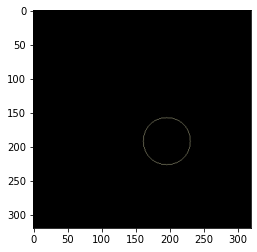

длина 209.13708400726318
длина 249.13708305358887
длина 225.13708305358887
длина 233.13708209991455
длина 209.13708400726318
длина 249.13708305358887
длина 225.13708305358887
длина 233.13708209991455
длина 209.13708400726318
длина 249.13708305358887
длина 227.48022937774658
длина 230.7939395904541
itogo 0


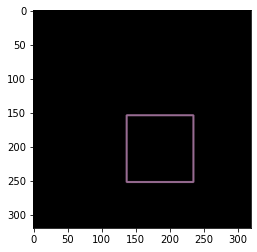

длина 189.65685415267944
длина 365.65685415267944
длина 189.65685415267944
длина 189.65685415267944
длина 189.65685415267944
длина 411.3137083053589
длина 373.65685415267944
длина 403.3137083053589
длина 376.9705619812012
длина 397.65685415267944
длина 379.3137083053589
длина 397.65685415267944
длина 384.97056245803833
длина 392.0
длина 387.3137083053589
длина 389.65685415267944
длина 189.65685415267944
длина 365.65685415267944
длина 189.65685415267944
длина 189.65685415267944
длина 189.65685415267944
длина 411.3137083053589
длина 373.65685415267944
длина 403.3137083053589
длина 379.3137083053589
длина 397.65685415267944
длина 384.9705619812012
длина 392.0
длина 189.65685415267944
длина 365.65685415267944
длина 189.65685415267944
длина 189.65685415267944
длина 189.65685415267944
длина 411.3137083053589
длина 373.65685415267944
длина 403.3137083053589
длина 379.3137083053589
длина 397.65685415267944
длина 381.65685415267944
длина 397.65685415267944
длина 384.9705619812012
длина 392.0
дл

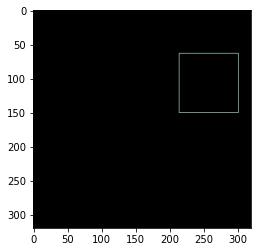

длина 155.65685415267944
длина 155.65685415267944
длина 155.65685415267944
длина 321.65685415267944
длина 155.65685415267944
длина 367.3137083053589
длина 337.65685415267944
длина 353.65685415267944
длина 343.3137083053589
длина 348.0
длина 323.3137083053589
длина 365.65685415267944
длина 337.65685415267944
длина 353.65685415267944
длина 340.9705619812012
длина 354.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 323.3137083053589
длина 365.65685415267944
длина 337.65685415267944
длина 353.65685415267944
длина 340.9705619812012
длина 348.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


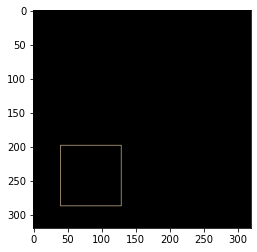

длина 332.97056245803833
длина 372.0
длина 345.65685415267944
длина 361.65685415267944
длина 345.65685415267944
длина 359.3137083053589
длина 351.3137083053589
длина 356.0
длина 159.65685415267944
длина 159.65685415267944
длина 159.65685415267944
длина 329.65685415267944
длина 159.65685415267944
длина 375.3137083053589
длина 345.65685415267944
длина 361.65685415267944
длина 348.9705619812012
длина 356.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 332.97056245803833
длина 372.0
длина 345.65685415267944
длина 361.65685415267944
длина 351.3137083053589
длина 356.0
itogo 3


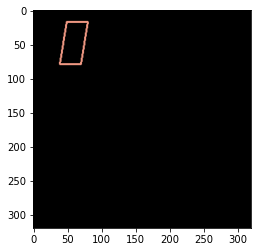

длина 55.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 165.11269783973694
длина 55.65685415267944
длина 211.94112491607666
длина 173.11269783973694
длина 207.94112491607666
длина 175.94112491607666
длина 205.5979790687561
длина 178.76955199241638
длина 202.28427076339722
длина 179.94112467765808
длина 199.94112491607666
длина 182.76955199241638
длина 199.94112491607666
длина 183.94112491607666
длина 197.5979790687561
длина 188.42640590667725
длина 194.28427076339722
длина 8.242640614509583
длина 8.242640614509583
длина 8.242640614509583
длина 8.242640614509583
длина 55.65685415267944
дл

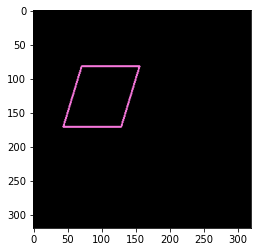

длина 165.65685415267944
длина 7.656854152679443
длина 342.3675310611725
длина 7.656854152679443
длина 165.65685415267944
длина 388.02438521385193
длина 348.02438521385193
длина 384.02438521385193
длина 350.3675310611725
длина 381.6812393665314
длина 352.02438497543335
длина 378.3675310611725
длина 356.02438521385193
длина 376.02438521385193
длина 358.3675310611725
длина 376.02438521385193
длина 358.3675310611725
длина 372.02438521385193
длина 183.3137080669403
длина 24.485281229019165
длина 24.485281229019165
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 24.485281229019165
длина 24.485281229019165
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 24.485281229019165
длина 24.485281229019165
длина 183.3137080669403
длина 0.0
длина 170.82842707633972
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина

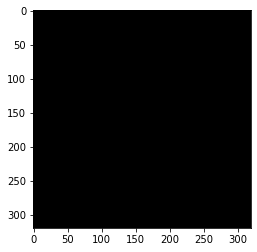

itogo 3
train_data/49.png


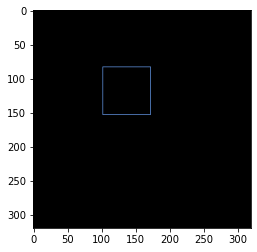

длина 121.65685415267944
длина 121.65685415267944
длина 125.65685415267944
длина 253.65685415267944
длина 125.65685415267944
длина 299.3137083053589
длина 272.9705619812012
длина 280.0
длина 255.3137083053589
длина 297.65685415267944
длина 269.65685415267944
длина 285.65685415267944
длина 275.3137083053589
длина 280.0
длина 255.3137083053589
длина 297.65685415267944
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 275.3137083053589
длина 280.0
itogo 1


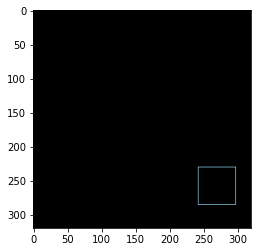

длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 195.3137083053589
длина 237.65685415267944
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
itogo 2


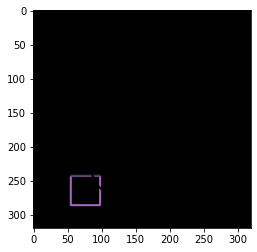

длина 79.65685415267944
длина 39.65685415267944
длина 21.656854152679443
длина 149.55634891986847
длина 79.65685415267944
длина 11.656854152679443
длина 55.65685415267944
длина 194.3847759962082
длина 54.485281229019165
длина 281.55634891986847
длина 48.485281229019165
длина 276.3847757577896
длина 43.65685415267944
длина 270.1421353816986
длина 28.82842707633972
длина 213.3137083053589
длина 22.0
длина 207.65685415267944
длина 79.65685415267944
длина 39.65685415267944
длина 21.656854152679443
длина 149.55634891986847
длина 79.65685415267944
длина 11.656854152679443
длина 55.65685415267944
длина 194.3847759962082
длина 51.31370830535889
длина 278.3847759962082
длина 33.65685415267944
длина 218.1421353816986
длина 24.0
длина 208.4852809906006
длина 79.65685415267944
длина 39.65685415267944
длина 23.656854152679443
длина 149.55634891986847
длина 79.65685415267944
длина 11.656854152679443
длина 55.65685415267944
длина 194.3847759962082
длина 55.071067690849304
длина 282.97056245803833
дли

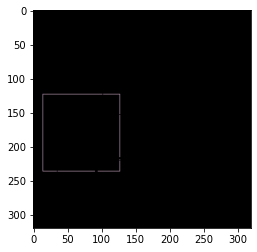

длина 47.65685415267944
длина 93.65685415267944
длина 23.656854152679443
длина 13.656854152679443
длина 107.65685415267944
длина 41.65685415267944
длина 207.65685415267944
длина 432.2842707633972
длина 31.656854152679443
длина 157.65685415267944
длина 477.94112491607666
длина 99.65685415267944
длина 793.4558436870575
длина 104.0
длина 88.82842707633972
длина 118.0
длина 100.82842707633972
длина 433.65685415267944
длина 47.65685415267944
длина 93.65685415267944
длина 23.656854152679443
длина 13.656854152679443
длина 107.65685415267944
длина 41.65685415267944
длина 207.65685415267944
длина 432.2842707633972
длина 31.656854152679443
длина 157.65685415267944
длина 477.94112491607666
длина 96.48528122901917
длина 791.1126978397369
длина 100.0
длина 84.82842707633972
длина 114.0
длина 96.82842707633972
длина 429.65685415267944
длина 431.4558436870575
длина 470.48528122901917
длина 99.65685415267944
длина 793.4558436870575
длина 104.0
длина 88.82842707633972
длина 118.0
длина 100.828427076339

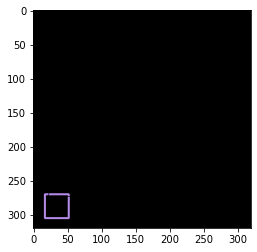

длина 63.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 51.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 123.89949476718903
длина 152.1421353816986
длина 127.31370830535889
длина 146.48528122901917
длина 272.87005722522736
длина 57.41421353816986
длина 200.72792148590088
длина 50.0
длина 196.72792184352875
длина 63.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 51.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 272.87005722522736
длина 57.41421353816986
длина 200.72792148590088
длина 63.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 51.65685415267944
длина 159.3137083053589
длина 119.89949476718903
длина 153.65685415267944
длина 122.48528122901917
длина 152.97056245803833
длина 126.14213514328003
длина 145

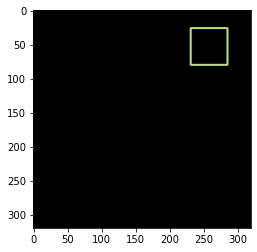

длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 211.3137083053589
длина 213.65685415267944
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 195.3137083053589
длина 229.65685415267944
длина 197.65685415267944
длина 227.3137083053589
длина 203.3137083053589
длина 221.65685415267944
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 208.97056198120117
длина 216.0
длина 211.3137083053589
длина 213.65685415267944
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
д

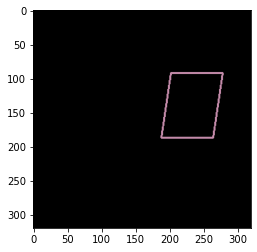

длина 145.65685415267944
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 324.4264061450958
длина 145.65685415267944
длина 371.25483322143555
длина 332.4264061450958
длина 364.911687374115
длина 335.25483322143555
длина 364.911687374115
длина 339.25483322143555
длина 359.25483322143555
длина 342.08326029777527
длина 359.25483322143555
длина 343.25483322143555
длина 355.25483322143555
длина 216.97056245803833
длина 1

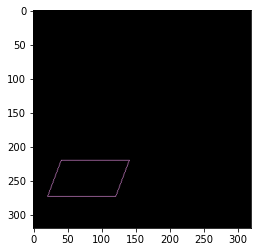

длина 181.65685415267944
длина 291.7401144504547
длина 181.65685415267944
длина 339.0538227558136
длина 309.3969683647156
длина 328.2253956794739
длина 312.2253956794739
длина 322.56854152679443
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 292.56854152679443
длина 338.2253956794739
длина 310.56854152679443
длина 324.2253956794739
длина 0.0
длина 2.0
длина 2.0
длина 0.0
длина 181.65685415267944
длина 291.7401144504547
длина 181.65685415267944
длина 339.0538227558136
длина 309.3969683647156
длина 328.2253956794739
длина 315.0538227558136
длина 322.56854152679443
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
itogo 5


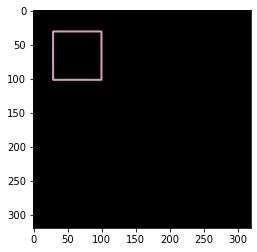

длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 271.3137083053589
длина 289.65685415267944
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 276.9705619812012
длина 284.0
длина 279.3137083053589
длина 281.65685415267944
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 303.3137083053589
длина 265.65685415267944
длина 295.3137083053589
длина 268.9705619812012
длина 289.65685415267944
длина 271.3137083053589
длина 289.65685415267944
длина 273.65685415267944
длина 287.3137083053589
длина 279.3137083053589
длина 281.65685415267944
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
дл

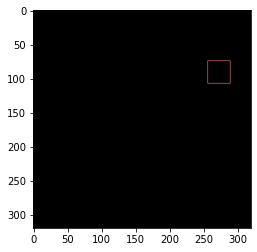

длина 47.65685415267944
длина 47.65685415267944
длина 47.65685415267944
длина 105.65685415267944
длина 47.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 47.65685415267944
длина 47.65685415267944
длина 51.65685415267944
длина 105.65685415267944
длина 51.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 135.3137083053589
длина 107.31370830535889
длина 149.65685415267944
длина 121.65685415267944
длина 135.3137083053589
itogo 7


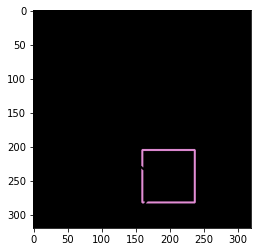

длина 133.65685415267944
длина 89.65685415267944
длина 286.72792184352875
длина 147.65685415267944
длина 41.65685415267944
длина 147.65685415267944
длина 334.97056245803833
длина 614.5269112586975
длина 107.89949476718903
длина 499.2132030725479
длина 103.65685415267944
длина 492.97056210041046
длина 103.0710676908493
длина 493.55634891986847
длина 99.0710676908493
длина 489.55634891986847
длина 96.82842707633972
длина 486.72792184352875
длина 93.41421353816986
длина 484.48528122901917
длина 133.65685415267944
длина 89.65685415267944
длина 286.72792184352875
длина 147.65685415267944
длина 41.65685415267944
длина 147.65685415267944
длина 336.97056245803833
длина 109.31370830535889
длина 500.3847759962082
длина 103.0710676908493
длина 493.55634891986847
длина 100.48528122901917
длина 492.3847759962082
длина 96.82842707633972
длина 486.7279214859009
длина 133.65685415267944
длина 89.65685415267944
длина 286.72792184352875
длина 147.65685415267944
длина 41.65685415267944
длина 147.65685415

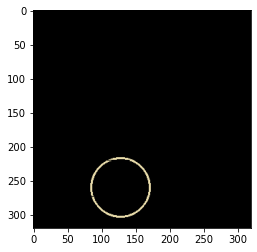

длина 21.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 263.7644991874695
длина 5.656854152679443
длина 7.656854152679443
длина 21.656854152679443
длина 304.73506212234497
длина 269.4213562011719
длина 299.0782084465027
длина 271.76449966430664
длина 296.7350630760193
длина 275.07820892333984
длина 293.4213538169861
длина 277.4213562011719
длина 291.0782084465027
длина 131.05382335186005
длина 426.96046006679535
длина 127.05382335186005
длина 421.78888523578644
длина 159.6812388896942
длина 24.14213538169861
длина 120.81118273735046
длина 166.26702642440796
длина 45.65685415267944
длина 21.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 7.656854152679443


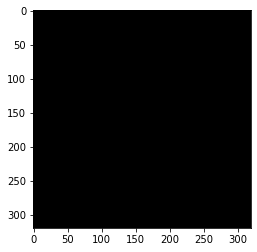

itogo 8
train_data/50.png


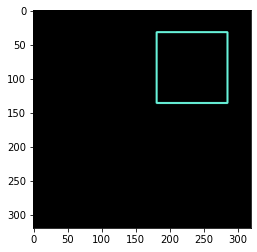

длина 201.65685415267944
длина 389.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 435.3137083053589
длина 397.65685415267944
длина 427.3137083053589
длина 403.3137083053589
длина 421.65685415267944
длина 408.9705619812012
длина 416.0
длина 201.65685415267944
длина 389.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 435.3137083053589
длина 395.3137083053589
длина 429.65685415267944
длина 397.65685415267944
длина 427.3137083053589
длина 400.9705619812012
длина 424.0
длина 403.3137083053589
длина 421.65685415267944
длина 405.65685415267944
длина 421.65685415267944
длина 405.65685415267944
длина 419.3137083053589
длина 408.9705619812012
длина 416.0
длина 411.3137083053589
длина 413.65685415267944
длина 201.65685415267944
длина 389.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 435.3137083053589
длина 397.65685415267944
длина 427.3137083053589
дли

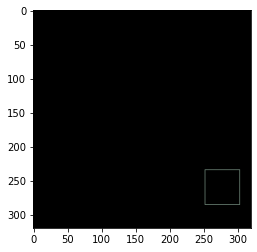

длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 177.65685415267944
длина 83.65685415267944
длина 223.3137083053589
длина 193.65685415267944
длина 207.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 180.97056245803833
длина 220.0
длина 193.65685415267944
длина 209.65685415267944
длина 199.3137083053589
длина 204.0
длина 179.3137083053589
длина 221.65685415267944
длина 193.65685415267944
длина 207.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


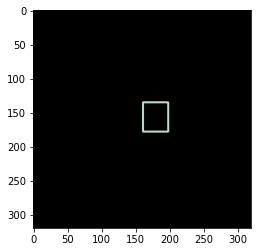

длина 67.65685415267944
длина 133.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 67.65685415267944
длина 179.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 152.97056198120117
длина 160.0
длина 155.3137083053589
длина 157.65685415267944
длина 67.65685415267944
длина 133.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 67.65685415267944
длина 179.3137083053589
длина 139.3137083053589
длина 173.65685415267944
длина 141.65685415267944
длина 171.3137083053589
длина 144.97056198120117
длина 165.65685415267944
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 152.97056245803833
длина 160.0
длина 155.3137083053589
длина 160.0
длина 67.65685415267944
длина 133.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 67.656

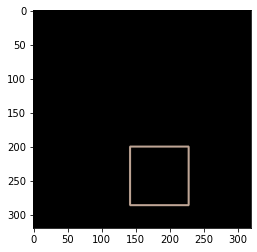

длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 325.65685415267944
длина 355.3137083053589
длина 325.65685415267944
длина 355.3137083053589
длина 331.3137083053589
длина 349.65685415267944
длина 333.65685415267944
длина 349.65685415267944
длина 333.65685415267944
длина 347.3137083053589
длина 339.3137083053589
длина 341.65685415267944
длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 325.65685415267944
длина 355.3137083053589
длина 328.9705619812012
длина 352.0
длина 331.3137083053589
длина 349.65685415267944
длина 333.65685415267944
длина 347.3137083053589
длина 339.3137083053589
длина 344.0
длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 325.65685415267944
длина 355.3137

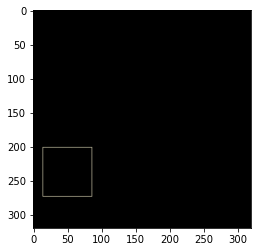

длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 283.3137083053589
длина 288.0
itogo 4


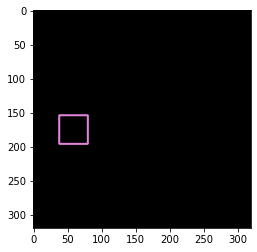

длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 187.3137083053589
длина 147.3137083053589
длина 181.65685415267944
длина 149.65685415267944
длина 179.3137083053589
длина 152.97056198120117
длина 173.65685415267944
длина 155.3137083053589
длина 173.65685415267944
длина 157.65685415267944
длина 171.3137083053589
длина 160.97056245803833
длина 168.0
длина 163.3137083053589
длина 165.65685415267944
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 187.3137083053589
длина 149.65685415267944
длина 179.3137083053589
длина 155.3137083053589
длина 173.65685415267944
длина 157.65685415267944
длина 171.3137083053589
длина 160.97056198120117
длина 168.0
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 187.3137083053589
длина 149.65685415267944
длина 179.3137083053589


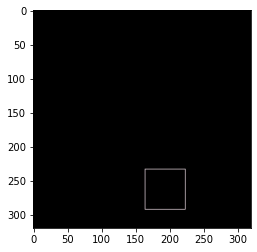

длина 211.3137083053589
длина 253.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 209.65685415267944
длина 99.65685415267944
длина 255.3137083053589
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 211.3137083053589
длина 253.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
itogo 6


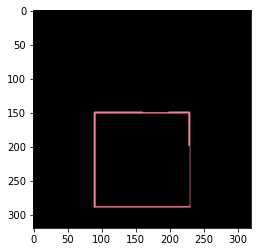

длина 157.65685415267944
длина 531.0710676908493
длина 91.65685415267944
длина 271.65685415267944
длина 55.65685415267944
длина 135.65685415267944
длина 575.5563489198685
длина 538.1421353816986
длина 568.4852812290192
длина 540.4852812290192
длина 567.3137083053589
длина 543.7989891767502
длина 562.8284270763397
длина 935.798989534378
длина 931.798989534378
длина 4.828427076339722
длина 160.48528122901917
длина 425.3137083053589
длина 0.0
длина 154.2426404953003
длина 415.65685403347015
длина 150.24264061450958
длина 412.2426406145096
длина 531.0710676908493
длина 91.65685415267944
длина 271.65685415267944
длина 55.65685415267944
длина 135.65685415267944
длина 574.7279218435287
длина 540.4852812290192
длина 567.3137083053589
длина 935.798989534378
длина 929.798989534378
длина 150.82842707633972
длина 414.2426406145096
длина 161.65685415267944
длина 531.0710676908493
длина 91.65685415267944
длина 271.65685415267944
длина 55.65685415267944
длина 135.65685415267944
длина 575.556348919868

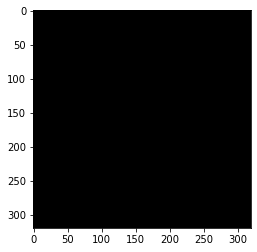

itogo 6
train_data/51.png


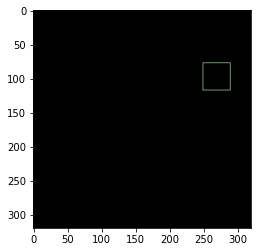

длина 135.3137083053589
длина 177.65685415267944
длина 149.65685415267944
длина 165.65685415267944
длина 155.3137083053589
длина 160.0
длина 135.3137083053589
длина 177.65685415267944
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 155.3137083053589
длина 160.0
длина 135.3137083053589
длина 177.65685415267944
длина 149.65685415267944
длина 165.65685415267944
длина 155.3137083053589
длина 160.0
itogo 1


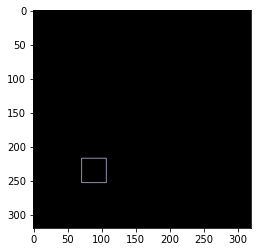

длина 119.31370830535889
длина 161.65685415267944
длина 131.3137083053589
длина 149.65685415267944
длина 133.65685415267944
длина 147.3137083053589
длина 139.3137083053589
длина 144.0
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 149.65685415267944
длина 136.97056198120117
длина 144.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 131.3137083053589
длина 149.65685415267944
длина 133.65685415267944
длина 147.3137083053589
длина 139.3137083053589
длина 144.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


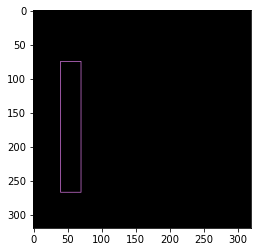

длина 419.3137083053589
длина 461.65685415267944
длина 431.3137083053589
длина 449.65685415267944
длина 433.65685415267944
длина 447.3137083053589
длина 439.3137083053589
длина 444.0
длина 419.3137083053589
длина 461.65685415267944
длина 433.65685415267944
длина 447.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 41.65685415267944
длина 365.65685415267944
длина 365.65685415267944
длина 417.65685415267944
длина 41.65685415267944
длина 463.3137083053589
длина 431.3137083053589
длина 449.65685415267944
длина 433.65685415267944
длина 447.3137083053589
длина 439.3137083053589
длина 444.0
itogo 2


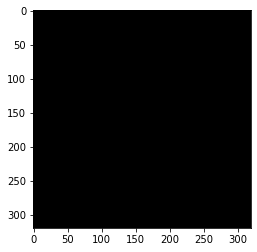

itogo 2
train_data/52.png


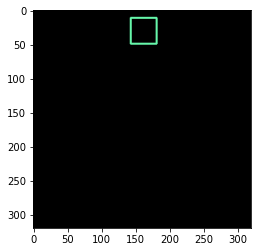

длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 139.3137083053589
длина 157.65685415267944
длина 144.97056198120117
длина 152.0
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 131.3137083053589
длина 165.65685415267944
длина 133.65685415267944
длина 163.3137083053589
длина 136.97056198120117
длина 160.0
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 144.97056198120117
длина 152.0
длина 147.3137083053589
длина 149.65685415267944
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 133.65

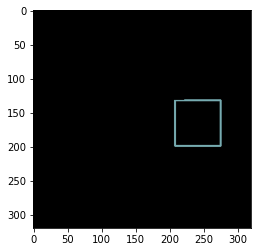

длина 127.65685415267944
длина 241.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 101.65685415267944
длина 286.72792184352875
длина 249.65685415267944
длина 278.72792184352875
длина 255.3137083053589
длина 273.65685415267944
длина 507.2132030725479
длина 10.242640614509583
длина 10.242640614509583
длина 2.0
длина 10.242640614509583
длина 127.65685415267944
длина 241.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 101.65685415267944
длина 286.72792184352875
длина 249.65685415267944
длина 279.3137083053589
длина 249.65685415267944
длина 278.72792184352875
длина 255.3137083053589
длина 273.65685415267944
длина 257.65685415267944
длина 271.3137083053589
длина 502.14213502407074
длина 127.65685415267944
длина 241.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 101.65685415267944
длина 286.72792184352875
длина 249.65685415267944
длина 279.3137083053589
длина 249.65685415267944
длина 278.72792184352875
длина 255.31370830535

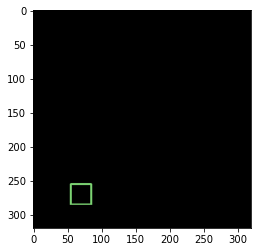

длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 137.3137083053589
длина 101.65685415267944
длина 130.48528122901917
длина 107.31370830535889
длина 124.82842707633972
длина 184.97056245803833
длина 172.48528122901917
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 137.3137083053589
длина 101.65685415267944
длина 130.48528122901917
длина 101.65685415267944
длина 129.3137083053589
длина 107.31370830535889
длина 124.82842707633972
длина 107.31370830535889
длина 123.65685415267944
длина 109.65685415267944
длина 122.48528122901917
длина 175.3137080669403
длина 168.48528122901917
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 137.3137083053589
длина 101.65685415267944
длина 129.3137083053589
длина 107.31370830535889
длина 124.82842707633972
длина 178.1421353816986
itogo 3


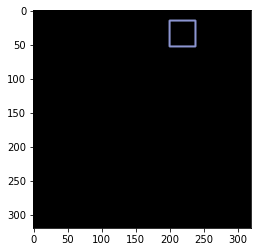

длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 144.97056198120117
длина 152.0
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 136.97056198120117
длина 157.65685415267944
длина 139.3137083053589
длина 157.65685415267944
длина 144.97056245803833
длина 152.0
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 163.313708305358

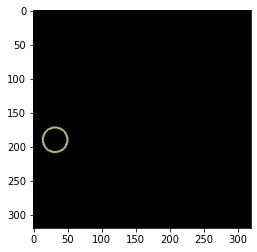

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.882248878479
длина 106.91168737411499
длина 131.882248878479
длина 106.91168785095215
длина 131.88224983215332
длина 112.56854176521301
длина 126.22539615631104
длина 112.56854057312012
длина 126.22539520263672
длина 118.2253954410553
длина 120.56854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.882248878479
длина 104.56854057312012
длина 134.22539520263672
длина 106.91168785095215
длина 131.88224983215332
длина 112.56854128837585
длина 126.22539615631104
длина 112.56854176521301
длина 126.22539615631104
длина 118.2253954410553
длина 120.56854057312012
длина 10.0
длина 2.0
длина 0.0
длина 14.485281229019165
длина 14.485281229019165
длина 14.485281229019165
длина 12.0
длина 12.0
длина 14.485281229019165
длина 14.485281229019165
длина 0.0
длина 14.4852812290191

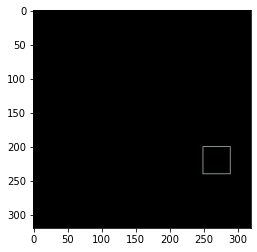

длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 133.65685415267944
длина 61.65685415267944
длина 179.3137083053589
длина 149.65685415267944
длина 165.65685415267944
длина 152.97056198120117
длина 160.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 133.65685415267944
длина 61.65685415267944
длина 179.3137083053589
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 155.3137083053589
длина 160.0
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 133.65685415267944
длина 61.65685415267944
длина 179.3137083053589
длина 149.65685415267944
длина 165.65685415267944
длина 152.97056198120117
длина 160.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


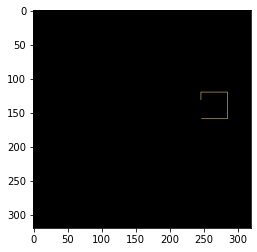

длина 262.97056245803833
длина 254.48528122901917
длина 244.72792148590088
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 265.55634891986847
длина 254.48528122901917
длина 246.48528122901917
длина 264.72792184352875
длина 250.3847759962082
itogo 6


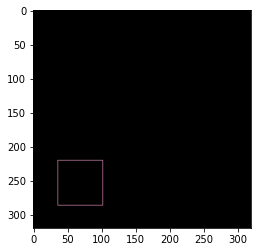

длина 239.3137083053589
длина 281.65685415267944
длина 253.65685415267944
длина 269.65685415267944
длина 256.9705619812012
длина 270.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 240.97056245803833
длина 280.0
длина 253.65685415267944
длина 267.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 237.65685415267944
длина 113.65685415267944
длина 283.3137083053589
длина 253.65685415267944
длина 269.65685415267944
длина 259.3137083053589
длина 264.0
itogo 7


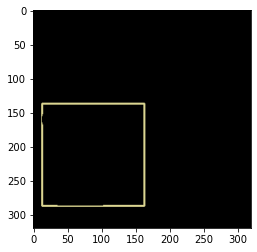

длина 115.65685415267944
длина 39.65685415267944
длина 233.65685415267944
длина 575.3137083053589
длина 293.65685415267944
длина 25.656854152679443
длина 293.65685415267944
длина 620.1421353816986
длина 581.798989534378
длина 613.6568541526794
длина 584.1421353816986
длина 611.3137083053589
длина 589.798989534378
длина 605.6568541526794
длина 1176.6274166107178
длина 1172.6274166107178
длина 280.2426404953003
длина 744.7279214859009
длина 276.2426406145096
длина 740.7279218435287
длина 115.65685415267944
длина 39.65685415267944
длина 233.65685415267944
длина 576.1421353816986
длина 293.65685415267944
длина 25.656854152679443
длина 293.65685415267944
длина 619.3137083053589
длина 584.1421353816986
длина 611.3137083053589
длина 584.1421353816986
длина 611.3137083053589
длина 589.798989534378
длина 605.6568541526794
длина 1176.6274166107178
длина 1172.6274166107178
длина 280.2426404953003
длина 744.7279214859009
длина 276.2426406145096
длина 740.7279218435287
длина 115.65685415267944
длин

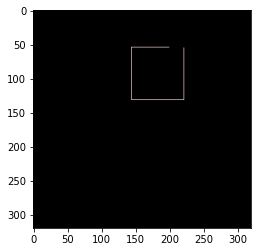

длина 581.5563489198685
длина 570.3847759962082
длина 566.3847759962082
длина 562.4852812290192
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 93.65685415267944
длина 582.3847759962082
длина 570.4852812290192
длина 564.7279214859009
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 578.9705624580383
длина 570.4852812290192
длина 560.7279214859009
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 9


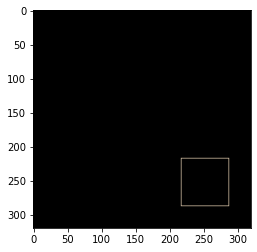

длина 121.65685415267944
длина 121.65685415267944
длина 121.65685415267944
длина 253.65685415267944
длина 121.65685415267944
длина 299.3137083053589
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 275.3137083053589
длина 280.0
длина 256.97056245803833
длина 296.0
длина 269.65685415267944
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 275.3137083053589
длина 280.0
длина 256.97056245803833
длина 296.0
длина 269.65685415267944
длина 285.65685415267944
длина 272.9705619812012
длина 280.0
itogo 10


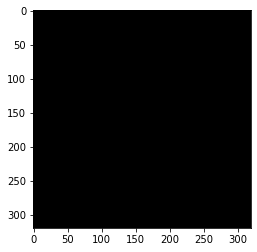

itogo 10
train_data/53.png


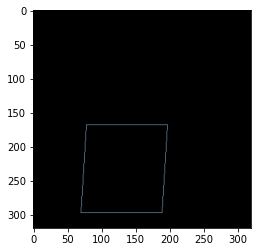

длина 477.11269783973694
длина 519.4558436870575
длина 492.2842707633972
длина 505.94112491607666
длина 219.65685415267944
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 476.2842707633972
длина 219.65685415267944
длина 521.9411249160767
длина 492.2842707633972
длина 508.2842707633972
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 219.65685415267944
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 

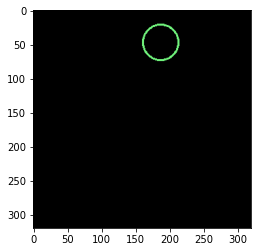

длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 151.1959571838379
длина 17.656854152679443
длина 192.16652297973633
длина 159.1959571838379
длина 184.16652154922485
длина 164.8528118133545
длина 178.50966691970825
длина 170.50966548919678
длина 172.85281324386597
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 151.1959571838379
длина 17.656854152679443
длина 192.16652297973633
длина 156.8528118133545
длина 186.50966691970825
длина 159.1959571838379
длина 184.16652154922485
длина 162.50966453552246
длина 180.85281229019165
длина 164.85281085968018
длина 178.5096664428711
длина 164.8528118133545
длина 178.50966691970825
длина 167.1959571838379
длина 176.16652297973633
длина 170.50966548919678
длина 172.85281229019165
длина 16.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 16.0
длина 16.0
длина 2.0
д

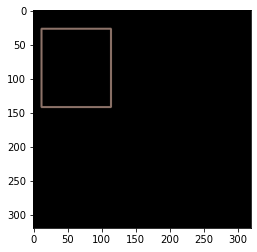

длина 197.65685415267944
длина 407.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 197.65685415267944
длина 453.3137083053589
длина 415.65685415267944
длина 445.3137083053589
длина 421.3137083053589
длина 439.65685415267944
длина 423.65685415267944
длина 437.3137083053589
длина 426.9705619812012
длина 434.0
длина 197.65685415267944
длина 407.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 197.65685415267944
длина 453.3137083053589
длина 415.65685415267944
длина 445.3137083053589
длина 421.3137083053589
длина 439.65685415267944
длина 423.65685415267944
длина 437.3137083053589
длина 197.65685415267944
длина 407.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 197.65685415267944
длина 453.3137083053589
длина 415.65685415267944
длина 445.3137083053589
длина 421.3137083053589
длина 439.65685415267944
длина 426.9705619812012
длина 434.0
itogo 0


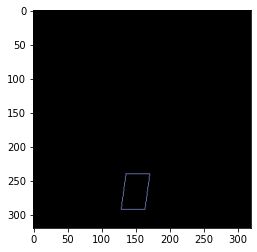

длина 155.4558436870575
длина 196.62741661071777
длина 169.4558436870575
длина 185.4558436870575
длина 75.65685415267944
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 75.65685415267944
длина 156.28427076339722
длина 195.79898953437805
длина 169.4558436870575
длина 185.4558436870575
длина 75.65685415267944
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 10.0
длина 10.0
длина 75.65685415267944
длина 155.4558436870575
длина 196.62741661071777
длина 165.4558436870575
длина 185.4558436870575
длина 169.4558436870575
длина 183.11269783973694
длина 175.11269783973694
длина 179.79898953437805
itogo 0


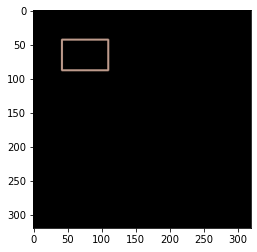

длина 129.65685415267944
длина 199.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 129.65685415267944
длина 245.3137083053589
длина 207.65685415267944
длина 237.3137083053589
длина 207.65685415267944
длина 237.3137083053589
длина 213.3137083053589
длина 231.65685415267944
длина 215.65685415267944
длина 231.65685415267944
длина 215.65685415267944
длина 229.3137083053589
длина 221.3137083053589
длина 223.65685415267944
длина 129.65685415267944
длина 199.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 129.65685415267944
длина 245.3137083053589
длина 207.65685415267944
длина 237.3137083053589
длина 210.97056198120117
длина 231.65685415267944
длина 213.3137083053589
длина 231.65685415267944
длина 215.65685415267944
длина 229.3137083053589
длина 221.3137083053589
длина 223.65685415267944
длина 129.65685415267944
длина 199.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 129.65685415267944
длина 245.3137083053589
длина 207.65685415

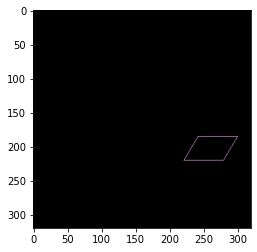

длина 171.7401144504547
длина 217.39696860313416
длина 188.56854152679443
длина 209.0538227558136
длина 194.22539567947388
длина 205.0538227558136
длина 5.414213538169861
длина 5.414213538169861
длина 171.7401144504547
длина 217.39696860313416
длина 191.39696860313416
длина 207.39696860313416
длина 114.82842707633972
длина 114.82842707633972
длина 171.7401144504547
длина 217.39696860313416
длина 188.56854152679443
длина 209.0538227558136
длина 194.22539567947388
длина 205.0538227558136
длина 5.414213538169861
длина 5.414213538169861
itogo 0


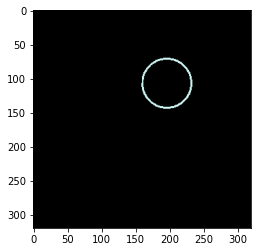

длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 217.13708209991455
длина 5.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 259.2792181968689
длина 223.9655110836029
длина 252.4507918357849
длина 225.13708305358887
длина 250.1076464653015
длина 230.79393863677979
длина 244.4507908821106
длина 231.96551156044006
длина 244.45079278945923
длина 472.0731542110443
длина 61.11269807815552
длина 48.284270882606506
длина 342.8771985769272
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 217.13708209991455
длина 5.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 259.27921748161316
длина 223.96551156044006
д

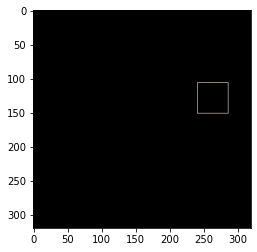

длина 155.3137083053589
длина 197.65685415267944
длина 169.65685415267944
длина 185.65685415267944
длина 172.97056198120117
длина 186.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 155.3137083053589
длина 197.65685415267944
длина 169.65685415267944
длина 185.65685415267944
длина 172.97056198120117
длина 180.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 156.97056245803833
длина 196.0
длина 169.65685415267944
длина 185.65685415267944
длина 172.97056198120117
длина 180.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


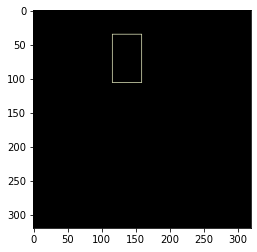

длина 203.3137083053589
длина 245.65685415267944
длина 215.3137083053589
длина 233.65685415267944
длина 217.65685415267944
длина 231.3137083053589
длина 223.3137083053589
длина 228.0
длина 67.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 201.65685415267944
длина 67.65685415267944
длина 247.3137083053589
длина 215.3137083053589
длина 233.65685415267944
длина 217.65685415267944
длина 231.3137083053589
длина 223.3137083053589
длина 228.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 67.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 201.65685415267944
длина 67.65685415267944
длина 247.3137083053589
длина 217.65685415267944
длина 233.65685415267944
длина 220.97056198120117
длина 228.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


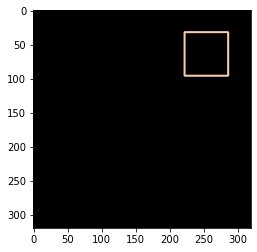

длина 121.65685415267944
длина 229.65685415267944
длина 121.65685415267944
длина 121.65685415267944
длина 121.65685415267944
длина 275.3137083053589
длина 235.3137083053589
длина 269.65685415267944
длина 237.65685415267944
длина 267.3137083053589
длина 240.97056198120117
длина 264.0
длина 243.3137083053589
длина 261.65685415267944
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 248.97056198120117
длина 256.0
длина 251.3137083053589
длина 253.65685415267944
длина 121.65685415267944
длина 229.65685415267944
длина 121.65685415267944
длина 121.65685415267944
длина 121.65685415267944
длина 275.3137083053589
длина 237.65685415267944
длина 267.3137083053589
длина 237.65685415267944
длина 267.3137083053589
длина 243.3137083053589
длина 261.65685415267944
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 248.97056198120117
длина 256.0
длина 6.2426406145095825
длина 6.2426406145095825
дл

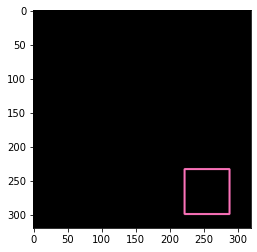

длина 125.65685415267944
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 283.3137083053589
длина 243.3137083053589
длина 277.65685415267944
длина 245.65685415267944
длина 275.3137083053589
длина 248.97056198120117
длина 272.0
длина 251.3137083053589
длина 269.65685415267944
длина 251.3137083053589
длина 269.65685415267944
длина 253.65685415267944
длина 267.3137083053589
длина 256.9705619812012
длина 264.0
длина 259.3137083053589
длина 261.65685415267944
длина 125.65685415267944
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 283.3137083053589
длина 245.65685415267944
длина 275.3137083053589
длина 251.3137083053589
длина 269.65685415267944
длина 256.97056245803833
длина 264.0
длина 125.65685415267944
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 283.3137083053589
длина 245.65685415267944
длина 275.3137083053589
дл

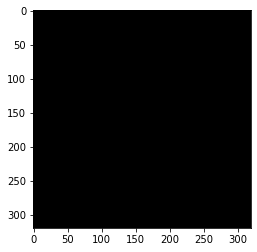

itogo 3
train_data/54.png


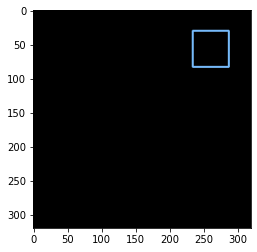

длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 193.65685415267944
длина 223.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 204.97056245803833
длина 212.0
длина 207.3137083053589
длина 209.65685415267944
длина 99.65685415267944
длина 185.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 99.65685415267944
длина 231.3137083053589
длина 191.3137083053589
длина 225.65

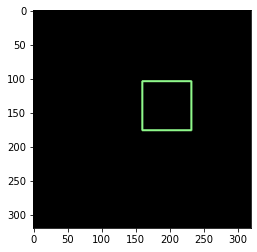

длина 137.65685415267944
длина 261.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 307.3137083053589
длина 269.65685415267944
длина 299.3137083053589
длина 275.3137083053589
длина 293.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
длина 137.65685415267944
длина 261.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 307.3137083053589
длина 267.3137083053589
длина 301.65685415267944
длина 269.65685415267944
длина 299.3137083053589
длина 272.9705619812012
длина 296.0
длина 275.3137083053589
длина 293.65685415267944
длина 275.3137083053589
длина 293.65685415267944
длина 277.65685415267944
длина 291.3137083053589
длина 280.9705619812012
длина 288.0
длина 283.3137083053589
длина 285.65685415267944
длина 137.65685415267944
длина 261.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 307.3137083053589
дли

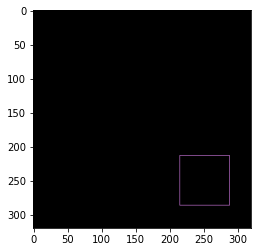

длина 127.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 265.65685415267944
длина 127.65685415267944
длина 311.3137083053589
длина 281.65685415267944
длина 297.65685415267944
длина 284.9705619812012
длина 292.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 127.65685415267944
длина 127.65685415267944
длина 131.65685415267944
длина 265.65685415267944
длина 131.65685415267944
длина 311.3137083053589
длина 281.65685415267944
длина 295.3137083053589
длина 268.97056245803833
длина 308.0
длина 281.65685415267944
длина 297.65685415267944
длина 284.9705619812012
длина 292.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 3


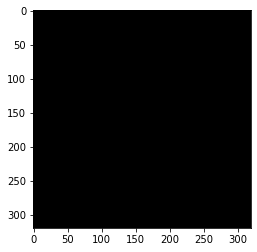

itogo 3
train_data/55.png


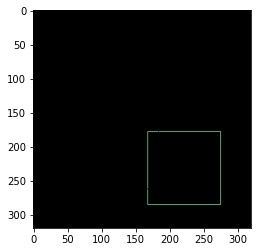

длина 403.3137083053589
длина 448.97056245803833
длина 646.7279214859009
длина 194.2426404953003
длина 404.97056245803833
длина 444.0
длина 415.3137083053589
длина 433.65685415267944
длина 419.3137083053589
длина 432.97056245803833
длина 644.4852812290192
длина 190.82842707633972
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 195.65685415267944
длина 27.656854152679443
длина 195.65685415267944
длина 149.65685415267944
длина 404.97056245803833
длина 163.65685415267944
длина 13.656854152679443
длина 450.6274166107178
длина 419.3137083053589
длина 435.3137083053589
длина 644.4852812290192
длина 190.82842707633972
itogo 1


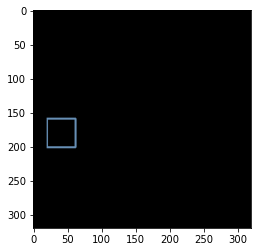

длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 185.3137083053589
длина 149.65685415267944
длина 177.3137083053589
длина 155.3137083053589
длина 171.65685415267944
длина 247.3137080669403
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 185.3137083053589
длина 149.65685415267944
длина 178.48528122901917
длина 155.3137083053589
длина 172.82842707633972
длина 157.65685415267944
длина 171.65685415267944
длина 247.3137080669403
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 185.3137083053589
длина 149.65685415267944
длина 178.48528122901917
длина 149.65685415267944
длина 177.3137083053589
длина 155.3137083053589
длина 172.82842707633972
длина 157.65685415267944
длина 170.48528122901917
длина 250.14213514328003
длина 240.48528122901917
itogo 2


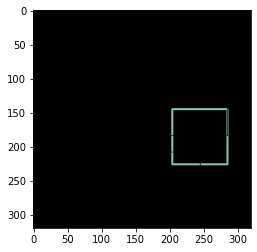

длина 71.65685415267944
длина 5.656854152679443
длина 73.65685415267944
длина 27.656854152679443
длина 5.656854152679443
длина 37.65685415267944
длина 77.65685415267944
длина 5.656854152679443
длина 297.0710676908493
длина 73.65685415267944
длина 69.65685415267944
длина 155.65685415267944
длина 342.72792184352875
длина 308.97056245803833
длина 337.2132029533386
длина 312.1421353816986
длина 329.0710676908493
длина 113.89949476718903
длина 159.89949476718903
длина 45.65685415267944
длина 236.48528122901917
длина 104.24264061450958
длина 36.0
длина 152.24264061450958
длина 228.24264061450958
длина 73.65685415267944
длина 73.65685415267944
длина 29.656854152679443
длина 77.65685415267944
длина 39.65685415267944
длина 297.0710676908493
длина 73.65685415267944
длина 69.65685415267944
длина 153.65685415267944
длина 342.72792184352875
длина 305.65685415267944
длина 335.3137083053589
длина 308.97056245803833
длина 337.2132030725479
длина 312.1421353816986
длина 329.0710676908493
длина 572.7695

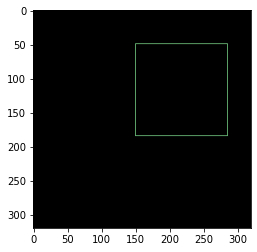

длина 516.9705624580383
длина 556.0
длина 529.6568541526794
длина 543.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 251.65685415267944
длина 251.65685415267944
длина 251.65685415267944
длина 513.6568541526794
длина 251.65685415267944
длина 559.3137083053589
длина 527.3137083053589
длина 545.6568541526794
длина 529.6568541526794
длина 543.3137083053589
длина 535.3137083053589
длина 540.0
длина 515.3137083053589
длина 557.6568541526794
длина 529.6568541526794
длина 545.6568541526794
длина 535.3137083053589
длина 540.0
itogo 4


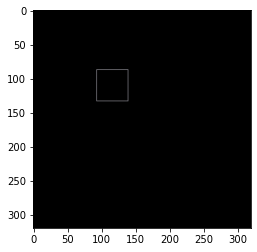

длина 160.97056245803833
длина 200.0
длина 173.65685415267944
длина 187.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 160.97056245803833
длина 200.0
длина 173.65685415267944
длина 187.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 159.3137083053589
длина 201.65685415267944
длина 173.65685415267944
длина 189.65685415267944
длина 179.3137083053589
длина 184.0
itogo 5


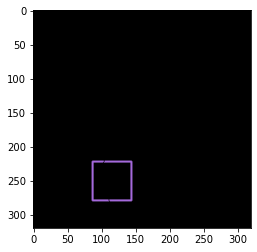

длина 57.65685415267944
длина 41.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 73.65685415267944
длина 25.656854152679443
длина 247.3137083053589
длина 209.65685415267944
длина 239.3137083053589
длина 212.97056198120117
длина 236.0
длина 216.97056245803833
длина 235.3137083053589
длина 252.1421353816986
длина 188.1421353816986
длина 247.65685415267944
длина 183.65685415267944
длина 57.65685415267944
длина 41.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 73.65685415267944
длина 25.656854152679443
длина 247.3137083053589
длина 211.3137083053589
длина 240.97056245803833
длина 216.97056245803833
длина 235.3137083053589
длина 248.4852809906006
длина 184.4852809906006
длина 57.65685415267944
длина 41.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 73.65685415267944
длина 25.656854152679443
длина 247.3137083053589
длина 207.3137083053589
длина 241

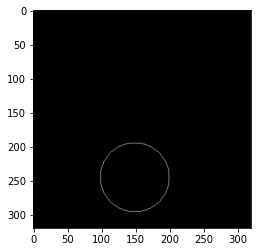

длина 316.048770904541
длина 356.04876947402954
длина 328.7350606918335
длина 340.0487699508667
длина 135.7401144504547
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 135.7401144504547
длина 135.7401144504547
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 135.7401144504547
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 316.048770904541
длина 7.656854152679443
длина 7.656854152679443
длина 356.04876947402954
длина 328.7350606918335
длина 340.0487699508667
длина 104.28427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 104.28427076339722
длина 104.28427076339722
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 104.28427076339722
длина 316.048770904541
длина 356.04876947402954
длина 328.7350606918335
длина 340.0487699508667
длин

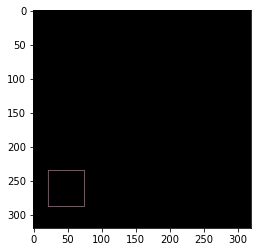

длина 187.3137083053589
длина 229.65685415267944
длина 201.65685415267944
длина 217.65685415267944
длина 204.97056198120117
длина 212.0
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 185.65685415267944
длина 87.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 215.3137083053589
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 185.65685415267944
длина 87.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 217.65685415267944
длина 207.3137083053589
длина 212.0
itogo 7


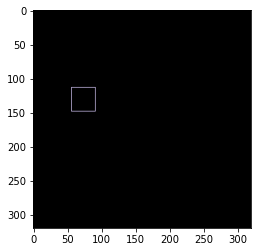

длина 115.31370830535889
длина 157.65685415267944
длина 129.65685415267944
длина 145.65685415267944
длина 132.97056198120117
длина 146.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 115.31370830535889
длина 157.65685415267944
длина 129.65685415267944
длина 145.65685415267944
длина 132.97056198120117
длина 140.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 115.31370830535889
длина 157.65685415267944
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
itogo 8


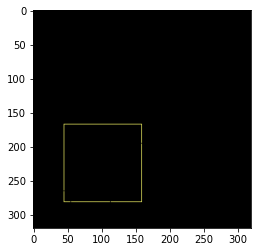

длина 433.79898953437805
длина 474.48528122901917
длина 443.3137083053589
длина 461.65685415267944
длина 448.97056245803833
длина 462.6274166107178
длина 108.0
длина 42.82842707633972
длина 254.82842707633972
длина 469.65685415267944
длина 433.79898953437805
длина 474.48528122901917
длина 443.3137083053589
длина 461.65685415267944
длина 448.97056245803833
длина 462.6274166107178
длина 108.0
длина 42.82842707633972
длина 254.82842707633972
длина 469.65685415267944
длина 436.2842707633972
длина 475.3137083053589
длина 112.0
длина 46.24264049530029
длина 258.2426404953003
длина 472.4852809906006
itogo 8


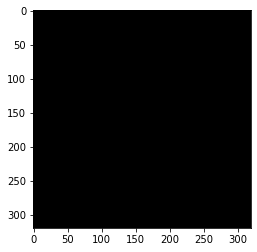

itogo 8
train_data/56.png


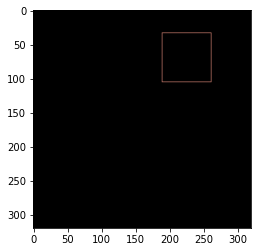

длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 280.9705619812012
длина 288.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 291.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 291.3137083053589
itogo 1


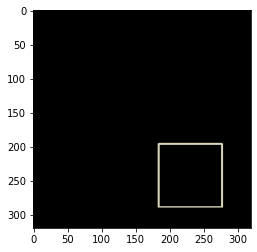

длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 389.3137083053589
длина 351.3137083053589
длина 383.65685415267944
длина 353.65685415267944
длина 381.3137083053589
длина 359.3137083053589
длина 376.8284270763397
длина 359.3137083053589
длина 375.65685415267944
длина 361.65685415267944
длина 374.48528122901917
длина 556.14213514328
длина 553.3137083053589
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 389.3137083053589
длина 353.65685415267944
длина 382.48528122901917
длина 353.65685415267944
длина 381.3137083053589
длина 359.3137083053589
длина 376.8284270763397
длина 359.3137083053589
длина 375.65685415267944
длина 361.65685415267944
длина 374.48528122901917
длина 553.3137080669403
длина 550.4852812290192
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 389.3137083053589
длина 353.65685415267944
длина 382.48528122

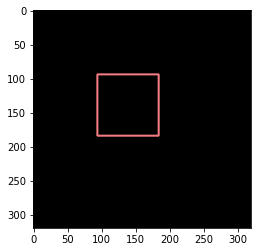

длина 173.65685415267944
длина 333.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 379.3137083053589
длина 339.3137083053589
длина 373.65685415267944
длина 341.65685415267944
длина 371.3137083053589
длина 344.9705619812012
длина 368.0
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 352.9705619812012
длина 360.0
длина 355.3137083053589
длина 357.65685415267944
длина 173.65685415267944
длина 333.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 379.3137083053589
длина 341.65685415267944
длина 371.3137083053589
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 355.3137083053589
длина 357.65685415267944
длина 173.65685415267944
длина 333.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 379.3137

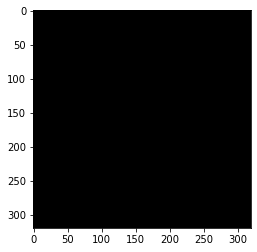

itogo 3
train_data/57.png


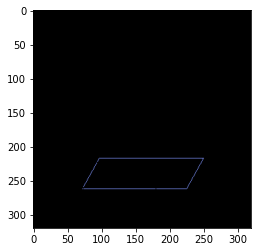

длина 385.8822498321533
длина 432.1248904466629
длина 211.65685415267944
длина 85.74011445045471
длина 511.4385985136032
длина 2.0
длина 386.71067690849304
длина 432.1248904466629
длина 85.74011445045471
длина 731.0954526662827
длина 4.0
длина 386.71067690849304
длина 432.1248904466629
длина 401.8822498321533
длина 421.78174459934235
длина 85.74011445045471
длина 729.6812393665314
длина 84.0
длина 206.0
длина 304.8284270763397
длина 2.0
itogo 0


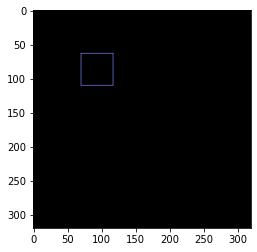

длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 164.97056245803833
длина 204.0
длина 177.65685415267944
длина 191.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


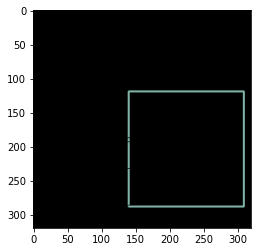

длина 333.65685415267944
длина 103.65685415267944
длина 5.656854152679443
длина 67.65685415267944
длина 5.656854152679443
длина 649.6568541526794
длина 331.65685415267944
длина 127.65685415267944
длина 331.65685415267944
длина 695.3137083053589
длина 660.1421353816986
длина 690.6274166107178
длина 663.899494767189
длина 681.6568541526794
длина 105.65685415267944
длина 75.65685415267944
длина 9.656854152679443
длина 1144.9705624580383
длина 96.0
длина 66.0
длина 0.0
длина 1136.7279218435287
длина 333.65685415267944
длина 97.65685415267944
длина 5.656854152679443
длина 67.65685415267944
длина 5.656854152679443
длина 649.6568541526794
длина 331.65685415267944
длина 127.65685415267944
длина 331.65685415267944
длина 695.3137083053589
длина 657.6568541526794
длина 687.3137083053589
длина 661.5563489198685
длина 689.798989534378
длина 666.3847759962082
длина 684.9705624580383
длина 105.65685415267944
длина 75.65685415267944
длина 9.656854152679443
длина 1144.9705624580383
длина 100.0
длина 70

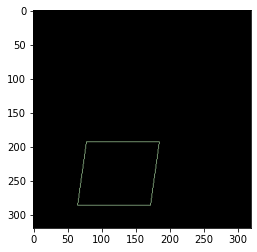

длина 386.4264061450958
длина 427.5979790687561
длина 400.4264061450958
длина 416.4264061450958
длина 406.08326029777527
длина 410.7695519924164
длина 386.4264061450958
длина 427.5979790687561
длина 399.25483322143555
длина 416.4264061450958
длина 400.4264061450958
длина 414.08326029777527
длина 219.65685415267944
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 219.65685415267944
длина 386.4264061450958
длина 427.5979790687561
длина 400.4264061450958
длина 416.4264061450958
длина 406.08326029777527
длина 410.7695519924164
itogo 2


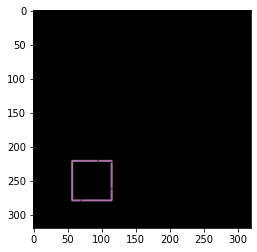

длина 83.65685415267944
длина 19.656854152679443
длина 27.656854152679443
длина 205.65685415267944
длина 75.65685415267944
длина 109.65685415267944
длина 35.65685415267944
длина 67.65685415267944
длина 251.3137083053589
длина 213.65685415267944
длина 243.3137083053589
длина 217.55634891986847
длина 245.79898953437805
длина 221.55634891986847
длина 240.97056245803833
длина 119.89949476718903
длина 75.65685415267944
длина 40.24264061450958
длина 212.1421353816986
длина 114.2426404953003
длина 70.0
длина 34.0
длина 206.4852809906006
длина 81.65685415267944
длина 5.656854152679443
длина 17.656854152679443
длина 25.656854152679443
длина 5.656854152679443
длина 205.65685415267944
длина 73.65685415267944
длина 109.65685415267944
длина 35.65685415267944
длина 67.65685415267944
длина 251.3137083053589
длина 216.1421353816986
длина 245.79898953437805
длина 221.55634891986847
длина 240.97056245803833
длина 115.89949476718903
длина 71.65685415267944
длина 40.24264061450958
длина 208.1421353816986


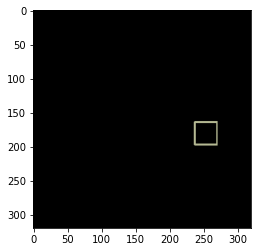

длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 149.3137083053589
длина 113.65685415267944
длина 142.48528122901917
длина 113.65685415267944
длина 141.3137083053589
длина 119.31370830535889
длина 136.82842707633972
длина 121.65685415267944
длина 134.48528122901917
длина 196.14213514328003
длина 186.48528122901917
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 149.3137083053589
длина 113.65685415267944
длина 142.48528122901917
длина 113.65685415267944
длина 141.3137083053589
длина 119.31370830535889
длина 136.82842707633972
длина 121.65685415267944
длина 134.48528122901917
длина 196.1421353816986
длина 190.48528122901917
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 149.3137083053589
длина 113.65685415267944
длина 142.48528122901917
длина 119.31370830535889
длина 136.82842707633972
длина 121.65685415267944
длина 135.65685

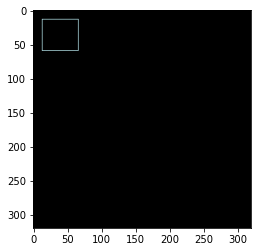

длина 87.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 171.65685415267944
длина 87.65685415267944
длина 217.3137083053589
длина 187.65685415267944
длина 203.65685415267944
длина 190.97056198120117
длина 198.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 87.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 171.65685415267944
длина 87.65685415267944
длина 217.3137083053589
длина 185.3137083053589
длина 203.65685415267944
длина 187.65685415267944
длина 201.3137083053589
длина 193.3137083053589
длина 198.0
длина 173.3137083053589
длина 215.65685415267944
длина 185.3137083053589
длина 203.65685415267944
длина 187.65685415267944
длина 201.3137083053589
длина 193.3137083053589
длина 198.0
itogo 4


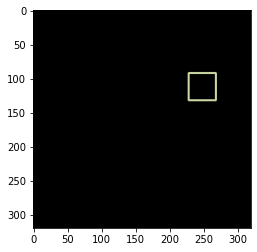

длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 179.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 147.3137083053589
длина 165.65685415267944
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 152.97056198120117
длина 160.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 179.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 171.3137083053589
длина 147.3137083053589
длина 165.65685415267944
длина 147.3137083053589
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 152.97056198120117
длина 160.0
длина 155.3137083053589
длина 157.65685415267944
д

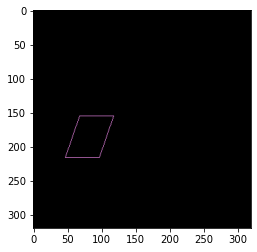

длина 213.0538227558136
длина 254.22539567947388
длина 226.22539567947388
длина 245.0538227558136
длина 227.39696860313416
длина 241.0538227558136
длина 104.24264061450958
длина 104.24264061450958
длина 83.65685415267944
длина 211.39696860313416
длина 83.65685415267944
длина 255.88224983215332
длина 227.39696860313416
длина 241.0538227558136
длина 2.0
длина 2.0
длина 212.22539567947388
длина 255.0538227558136
длина 226.22539567947388
длина 245.0538227558136
длина 229.0538227558136
длина 241.0538227558136
длина 103.0710676908493
длина 103.0710676908493
itogo 5


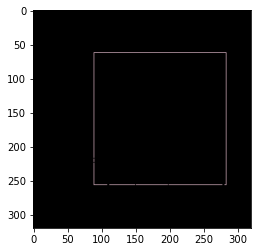

длина 755.4558436870575
длина 794.4852812290192
длина 334.0
длина 1205.313708305359
длина 157.65685415267944
длина 93.65685415267944
длина 75.65685415267944
длина 101.89949476718903
длина 9.656854152679443
длина 1084.1421353816986
длина 148.0
длина 84.0
длина 66.0
длина 92.82842707633972
длина 0.0
длина 1079.0710676908493
длина 754.6274166107178
длина 794.4852812290192
длина 334.0
длина 1205.313708305359
длина 152.0
длина 88.0
длина 70.0
длина 96.82842707633972
длина 4.0
длина 1081.0710676908493
длина 758.7695519924164
длина 798.6274166107178
длина 334.0
длина 1205.313708305359
длина 154.0
длина 92.0
длина 72.0
длина 98.2426404953003
длина 8.0
длина 1083.3137080669403
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 6


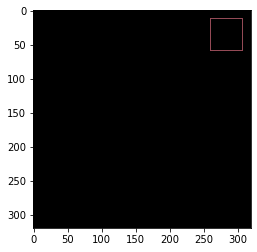

длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 7


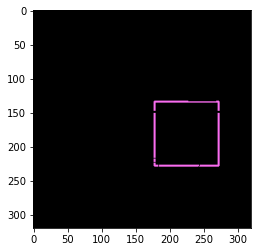

длина 49.65685415267944
длина 109.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 147.65685415267944
длина 123.65685415267944
длина 352.97056245803833
длина 19.656854152679443
длина 19.656854152679443
длина 93.65685415267944
длина 398.6274166107178
длина 358.6274166107178
длина 393.79898953437805
длина 508.7695519924164
длина 246.97056245803833
длина 496.4852809906006
длина 241.3137080669403
длина 496.48528122901917
длина 241.3137083053589
длина 500.7695518732071
длина 238.97056245803833
длина 116.24264061450958
длина 17.899494767189026
длина 9.656854152679443
длина 207.0710676908493
длина 130.82842707633972
длина 35.65685415267944
длина 127.65685415267944
длина 112.0
длина 12.242640495300293
длина 4.0
длина 202.2426404953003
длина 126.0
длина 28.242640495300293
длина 120.2426404953003
длина 108.0
длина 8.242640614509583
длина 0.0
длина 200.24264061450958
длина 122.0
длина 24.242640614509583
длина 116.24264061450958
длина 49.65685415267944
длина 109.65685415267944


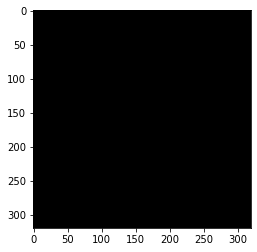

itogo 8
train_data/58.png


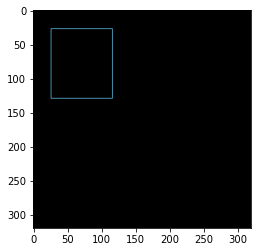

длина 161.65685415267944
длина 185.65685415267944
длина 189.65685415267944
длина 357.65685415267944
длина 165.65685415267944
длина 403.3137083053589
длина 376.9705619812012
длина 384.0
длина 359.3137083053589
длина 401.65685415267944
длина 373.65685415267944
длина 389.65685415267944
длина 376.9705619812012
длина 390.6274166107178
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 360.97056245803833
длина 400.0
длина 371.3137083053589
длина 389.65685415267944
длина 373.65685415267944
длина 387.3137083053589
длина 379.3137083053589
длина 384.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 0


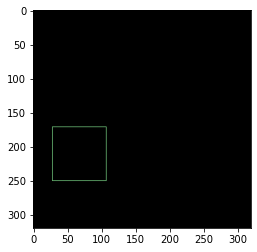

длина 139.65685415267944
длина 139.65685415267944
длина 139.65685415267944
длина 289.65685415267944
длина 139.65685415267944
длина 335.3137083053589
длина 305.65685415267944
длина 319.3137083053589
длина 291.3137083053589
длина 333.65685415267944
длина 305.65685415267944
длина 321.65685415267944
длина 305.65685415267944
длина 319.3137083053589
длина 311.3137083053589
длина 316.0
длина 292.97056245803833
длина 332.0
длина 305.65685415267944
длина 319.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


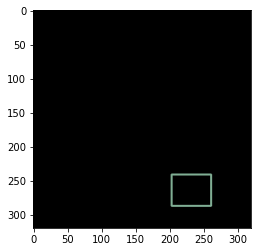

длина 109.65685415267944
длина 181.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 109.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 205.65685415267944
длина 109.65685415267944
длина 181.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 109.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 200.97056198120117
длина 208.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 109.65685415267944
длина 181.65685415267944
длина 85.65685415267944
длина 85.65685415267944
длина 109.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина

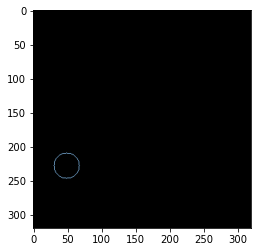

длина 102.22539710998535
длина 142.22539520263672
длина 118.22539710998535
длина 126.22539615631104
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 49.79898953437805
длина 49.79898953437805
длина 49.79898953437805
длина 49.79898953437805
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168689727783
длина 129.53910636901855
длина 120.56854152679443
длина 128.56854152679443
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
itogo 1


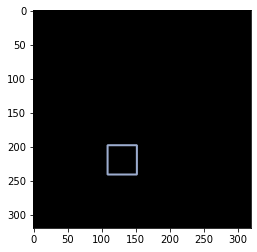

длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 156.97056198120117
длина 177.65685415267944
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 169.65685415267944
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 164.97056198120117
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 153.65685415267944
длина 183.31

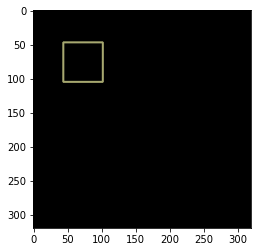

длина 109.65685415267944
длина 205.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 251.3137083053589
длина 213.65685415267944
длина 243.3137083053589
длина 216.97056198120117
длина 240.0
длина 219.3137083053589
длина 237.65685415267944
длина 221.65685415267944
длина 235.3137083053589
длина 224.97056198120117
длина 232.0
длина 109.65685415267944
длина 205.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 251.3137083053589
длина 213.65685415267944
длина 243.3137083053589
длина 213.65685415267944
длина 243.3137083053589
длина 219.3137083053589
длина 237.65685415267944
длина 221.65685415267944
длина 235.3137083053589
длина 224.97056198120117
длина 232.0
длина 109.65685415267944
длина 205.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 251.3137083053589
длина 213.65685415267944
длина 243.3137083053589
длина 219.3137083053589
длина 237.65685415267944
д

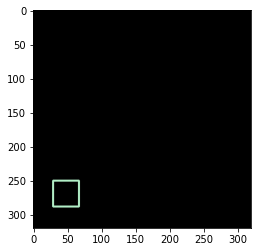

длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 163.3137083053589
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 144.97056198120117
длина 152.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 171.3137083053589
длина 131.3137083053589
длина 165.65685415267944
длина 133.65685415267944
длина 163.3137083053589
длина 136.97056198120117
длина 160.0
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 144.97056198120117
длина 152.0
длина 147.3137083053589
длина 149.65685415267944
длина 69

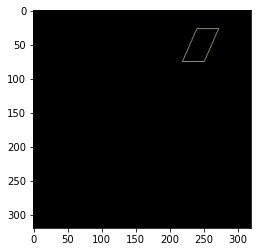

длина 147.39696860313416
длина 193.0538227558136
длина 164.2253954410553
длина 183.0538227558136
длина 169.88224983215332
длина 177.39696860313416
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 147.39696860313416
длина 193.0538227558136
длина 164.2253954410553
длина 183.0538227558136
длина 167.0538227558136
длина 180.71067690849304
длина 4.828427076339722
длина 6.828427076339722
длина 6.828427076339722
длина 4.828427076339722
длина 147.39696860313416
длина 193.0538227558136
длина 165.39696860313416
длина 183.0538227558136
длина 171.0538227558136
длина 177.39696860313416
itogo 4


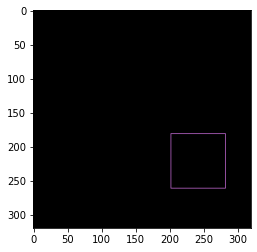

длина 296.97056245803833
длина 336.0
длина 309.65685415267944
длина 325.65685415267944
длина 309.65685415267944
длина 323.3137083053589
длина 315.3137083053589
длина 320.0
длина 295.3137083053589
длина 337.65685415267944
длина 309.65685415267944
длина 323.3137083053589
длина 295.3137083053589
длина 337.65685415267944
длина 307.3137083053589
длина 325.65685415267944
длина 309.65685415267944
длина 323.3137083053589
длина 315.3137083053589
длина 320.0
itogo 5


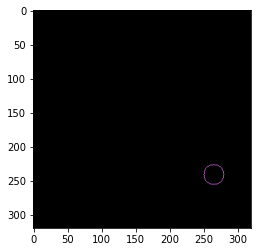

длина 77.25483322143555
длина 117.25483322143555
длина 87.59797954559326
длина 104.56854152679443
длина 95.5979790687561
длина 98.91168785095215
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 77.25483322143555
длина 117.25483322143555
длина 95.5979790687561
длина 98.91168785095215
длина 77.25483322143555
длина 117.25483322143555
длина 87.59797954559326
длина 104.56854152679443
длина 95.5979790687561
длина 98.91168785095215
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
itogo 5


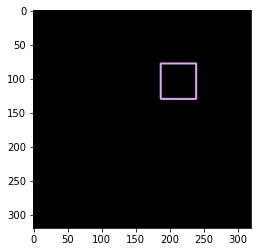

длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 187.3137083053589
длина 221.65685415267944
длина 189.65685415267944
длина 219.3137083053589
длина 192.97056198120117
длина 213.65685415267944
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 200.97056245803833
длина 208.0
длина 203.3137083053589
длина 205.65685415267944
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 192.97056198120117
длина 216.0
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 187.313

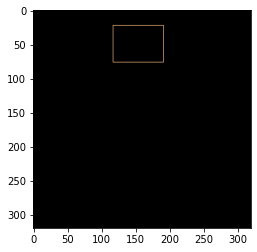

длина 232.97056245803833
длина 272.0
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 251.3137083053589
длина 256.0
длина 129.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 229.65685415267944
длина 129.65685415267944
длина 275.3137083053589
длина 245.65685415267944
длина 261.65685415267944
длина 251.3137083053589
длина 256.0
длина 129.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 229.65685415267944
длина 129.65685415267944
длина 275.3137083053589
длина 245.65685415267944
длина 259.3137083053589
itogo 6


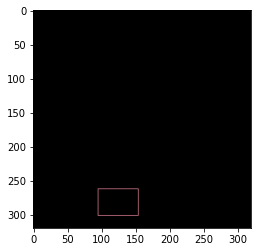

длина 99.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 169.65685415267944
длина 99.65685415267944
длина 215.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 191.3137083053589
длина 196.0
длина 171.3137083053589
длина 213.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 171.3137083053589
длина 213.65685415267944
длина 185.65685415267944
длина 201.65685415267944
длина 191.3137083053589
длина 196.0
itogo 6


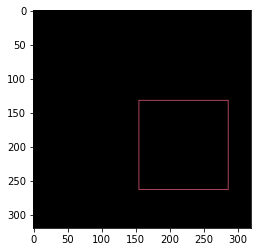

длина 499.3137083053589
длина 541.6568541526794
длина 511.3137083053589
длина 529.6568541526794
длина 513.6568541526794
длина 527.3137083053589
длина 519.3137083053589
длина 524.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 500.97056245803833
длина 540.0
длина 516.9705619812012
длина 524.0
длина 500.97056245803833
длина 540.0
длина 513.6568541526794
длина 527.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 7


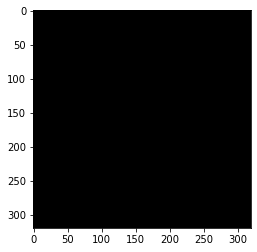

itogo 7
train_data/59.png


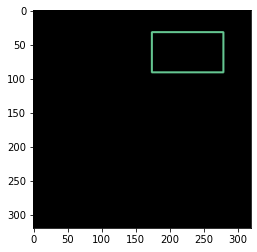

длина 203.65685415267944
длина 301.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 203.65685415267944
длина 347.3137083053589
длина 309.65685415267944
длина 339.3137083053589
длина 315.3137083053589
длина 333.65685415267944
длина 320.9705619812012
длина 328.0
длина 203.65685415267944
длина 301.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 203.65685415267944
длина 347.3137083053589
длина 309.65685415267944
длина 339.3137083053589
длина 309.65685415267944
длина 339.3137083053589
длина 315.3137083053589
длина 333.65685415267944
длина 317.65685415267944
длина 333.65685415267944
длина 317.65685415267944
длина 331.3137083053589
длина 323.3137083053589
длина 328.0
длина 203.65685415267944
длина 301.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 203.65685415267944
длина 347.3137083053589
длина 309.65685415267944
длина 339.3137083053589
длина 315.3137083053589
длина 333.65685415267944
длина 317.65685415267944
длина 333.6568

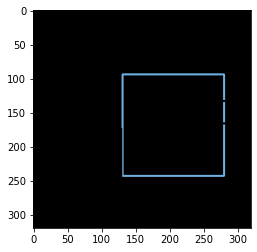

длина 291.65685415267944
длина 143.65685415267944
длина 51.65685415267944
длина 569.6568541526794
длина 67.65685415267944
длина 151.65685415267944
длина 291.65685415267944
длина 614.7279218435287
длина 65.31370830535889
длина 1117.698484301567
длина 59.65685415267944
длина 1112.0416301488876
длина 445.07106757164
длина 54.0
длина 522.4852809906006
длина 291.65685415267944
длина 143.65685415267944
длина 51.65685415267944
длина 569.6568541526794
длина 67.65685415267944
длина 151.65685415267944
длина 291.65685415267944
длина 614.7279218435287
длина 67.65685415267944
длина 1120.6274166107178
длина 63.65685415267944
длина 1116.0416301488876
длина 62.0
длина 1114.9705624580383
длина 59.65685415267944
длина 1112.6274166107178
длина 443.65685403347015
длина 54.0
длина 522.4852809906006
длина 0.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 291.65685415267944
длина 143.65685415267944
длина 51.65685415267944
длина 569.6568541526794
длина 67.65685415267944
длин

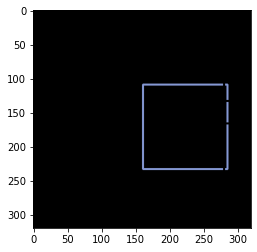

длина 227.65685415267944
длина 123.65685415267944
длина 51.65685415267944
длина 469.65685415267944
длина 37.65685415267944
длина 241.65685415267944
длина 227.65685415267944
длина 516.9705624580383
длина 143.89949476718903
длина 67.65685415267944
длина 57.899494767189026
длина 722.1421353816986
длина 138.24264061450958
длина 62.0
длина 52.24264061450958
длина 716.4852812290192
длина 135.89949476718903
длина 59.65685415267944
длина 49.899494767189026
длина 714.1421353816986
длина 130.82842707633972
длина 54.0
длина 44.82842707633972
длина 709.6568541526794
длина 227.65685415267944
длина 123.65685415267944
длина 51.65685415267944
длина 469.65685415267944
длина 37.65685415267944
длина 241.65685415267944
длина 227.65685415267944
длина 516.9705624580383
длина 143.89949476718903
длина 67.65685415267944
длина 57.899494767189026
длина 722.1421353816986
длина 138.24264061450958
длина 62.0
длина 52.24264061450958
длина 715.3137080669403
длина 136.48528122901917
длина 59.65685415267944
длина 50.48

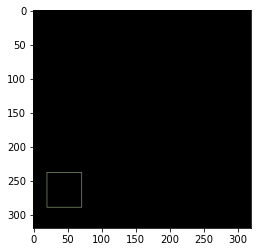

длина 180.97056245803833
длина 220.0
длина 193.65685415267944
длина 207.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 177.65685415267944
длина 83.65685415267944
длина 223.3137083053589
длина 193.65685415267944
длина 209.65685415267944
длина 199.3137083053589
длина 204.0
длина 179.3137083053589
длина 221.65685415267944
длина 193.65685415267944
длина 207.3137083053589
itogo 3


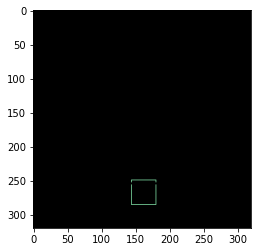

длина 121.31370830535889
длина 161.65685415267944
длина 187.3137083053589
длина 83.31370830535889
длина 177.65685415267944
длина 74.82842707633972
длина 53.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 119.31370830535889
длина 53.65685415267944
длина 164.97056245803833
длина 190.1421353816986
длина 86.14213514328003
длина 186.1421353816986
длина 82.14213538169861
длина 181.65685415267944
длина 77.65685415267944
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 53.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 120.48528122901917
длина 53.65685415267944
длина 163.3137083053589
длина 189.65685415267944
длина 85.65685415267944
длина 180.4852809906006
длина 77.65685415267944
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 4


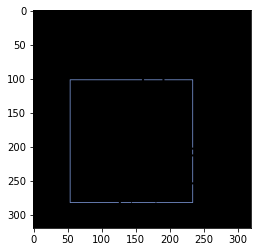

длина 89.65685415267944
длина 53.65685415267944
длина 13.656854152679443
длина 125.65685415267944
длина 35.65685415267944
длина 59.65685415267944
длина 181.65685415267944
длина 341.65685415267944
длина 701.9411249160767
длина 65.65685415267944
длина 37.65685415267944
длина 193.65685415267944
длина 747.5979790687561
длина 265.79898953437805
длина 75.65685415267944
длина 13.656854152679443
длина 280.48528122901917
длина 53.65685415267944
длина 711.3137083053589
длина 60.0
длина 20.0
длина 148.82842707633972
длина 66.0
длина 4.0
длина 270.8284270763397
длина 44.0
длина 701.6568541526794
длина 89.65685415267944
длина 53.65685415267944
длина 13.656854152679443
длина 125.65685415267944
длина 35.65685415267944
длина 59.65685415267944
длина 181.65685415267944
длина 341.65685415267944
длина 701.9411249160767
длина 65.65685415267944
длина 37.65685415267944
длина 193.65685415267944
длина 745.9411249160767
длина 264.8284270763397
длина 78.0
длина 16.0
длина 282.8284270763397
длина 56.0
длина 713.6

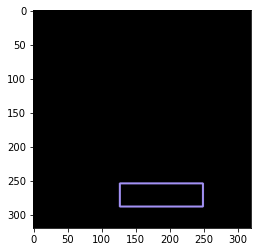

длина 237.65685415267944
длина 285.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 237.65685415267944
длина 331.3137083053589
длина 293.65685415267944
длина 323.3137083053589
длина 296.9705619812012
длина 320.0
длина 299.3137083053589
длина 317.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 307.3137083053589
длина 312.0
длина 237.65685415267944
длина 285.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 237.65685415267944
длина 331.3137083053589
длина 293.65685415267944
длина 323.3137083053589
длина 299.3137083053589
длина 317.65685415267944
длина 301.65685415267944
длина 317.65685415267944
длина 304.9705619812012
длина 312.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 237.65685415267944
длина 285.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 237.65685415267944
длина 331.3137083053589
длина 291.3137083053589
длина 325.65685415267944
длина 2

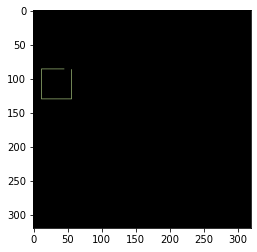

длина 339.55634891986847
длина 328.48528122901917
длина 320.48528122901917
длина 339.55634891986847
длина 328.48528122901917
длина 318.7279214859009
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 339.55634891986847
длина 324.3847759962082
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 5


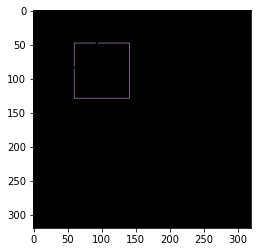

длина 299.3137083053589
длина 343.3137083053589
длина 502.48528122901917
длина 132.82842707633972
длина 494.48528122901917
длина 124.82842707633972
длина 300.97056245803833
длина 344.97056245803833
длина 500.1421353816986
длина 130.48528122901917
длина 490.48528122901917
длина 120.82842707633972
длина 143.65685415267944
длина 69.65685415267944
длина 143.65685415267944
длина 51.65685415267944
длина 300.97056245803833
длина 75.65685415267944
длина 45.65685415267944
длина 346.6274166107178
длина 502.48528122901917
длина 132.82842707633972
длина 492.7279214859009
длина 124.2426404953003
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 6


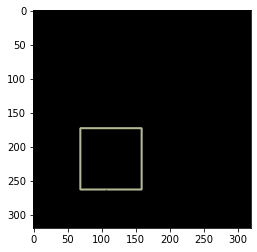

длина 173.65685415267944
длина 333.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 379.3137083053589
длина 341.65685415267944
длина 371.3137083053589
длина 341.65685415267944
длина 372.1421353816986
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 364.1421353816986
длина 352.9705619812012
длина 360.0
длина 700.9705624580383
длина 173.65685415267944
длина 333.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 379.3137083053589
длина 341.65685415267944
длина 371.3137083053589
длина 341.65685415267944
длина 372.1421353816986
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 364.1421353816986
длина 352.97056245803833
длина 360.0
длина 704.9705624580383
длина 173.65685415267944
длина 333.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 173.65685415267944
длина 379.3137083053589
длина 341.65685415267944
длина 371.31370

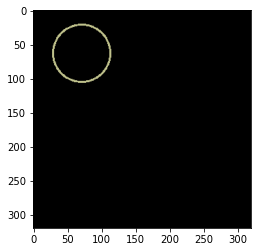

длина 19.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 258.1076445579529
длина 5.656854152679443
длина 5.656854152679443
длина 19.656854152679443
длина 299.07820892333984
длина 263.76449823379517
длина 293.4213533401489
длина 266.1076455116272
длина 291.0782079696655
длина 271.7644991874695
длина 285.4213547706604
длина 271.7644991874695
длина 285.42135429382324
длина 274.1076445579529
длина 283.078209400177
длина 17.656854152679443
длина 47.31370830535889
длина 45.35533785820007
длина 45.3553386926651
длина 73.79898953437805
длина 73.79898953437805
длина 45.3553386926651
длина 45.35533857345581
длина 17.656854152679443
длина 47.31370830535889
длина 19.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5

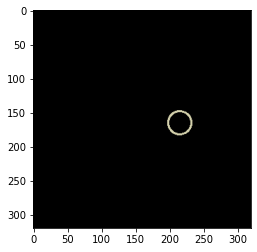

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 96.56854057312012
длина 128.56854152679443
длина 98.91168785095215
длина 126.22539567947388
длина 104.56854152679443
длина 120.56854152679443
длина 104.56854057312012
длина 120.56854128837585
длина 104.56854152679443
длина 120.56854152679443
длина 110.22539615631104
длина 114.91168737411499
длина 10.0
длина 2.0
длина 0.0
длина 5.656854152679443
длина 13.313708066940308
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 13.313708066940308
длина 0.0
длина 20.97056245803833
длина 2.0
длина 10.0
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 96.56854057312012
длина 128.56854152679443
длина 98.91168785095215
длина 126.22539567947388
длина 104.56854152679443
длина 120.56854152679443
длина 104.5685

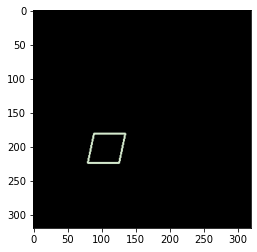

длина 85.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 156.28427076339722
длина 13.656854152679443
длина 85.65685415267944
длина 203.11269783973694
длина 164.28427076339722
длина 196.76955199241638
длина 165.4558436870575
длина 196.76955199241638
длина 169.94112467765808
длина 191.11269783973694
длина 172.28427076339722
длина 191.11269783973694
длина 172.28427076339722
длина 188.76955199241638
длина 135.55634891986847
длина 36.485281229019165
длина 36.485281229019165
длина 135.55634891986847
длина 93.65685415267944
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 93.65685415267944
длина 85.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 

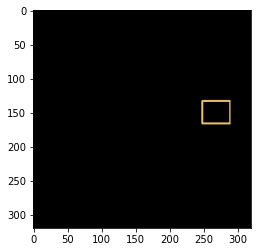

длина 75.65685415267944
длина 121.65685415267944
длина 59.65685415267944
длина 75.65685415267944
длина 165.3137083053589
длина 127.31370830535889
длина 159.65685415267944
длина 129.65685415267944
длина 157.3137083053589
длина 132.97056198120117
длина 152.82842707633972
длина 135.3137083053589
длина 152.82842707633972
длина 137.65685415267944
длина 150.48528122901917
длина 228.1421353816986
длина 226.48528122901917
длина 75.65685415267944
длина 121.65685415267944
длина 59.65685415267944
длина 75.65685415267944
длина 165.3137083053589
длина 129.65685415267944
длина 158.48528122901917
длина 129.65685415267944
длина 157.3137083053589
длина 135.3137083053589
длина 152.82842707633972
длина 137.65685415267944
длина 151.65685415267944
длина 228.1421353816986
длина 225.3137083053589
длина 75.65685415267944
длина 121.65685415267944
длина 59.65685415267944
длина 75.65685415267944
длина 165.3137083053589
длина 129.65685415267944
длина 157.3137083053589
длина 135.3137083053589
длина 151.65685415267

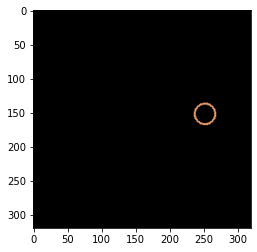

длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152679443
длина 120.56854152679443
длина 85.25483322143555
длина 114.91168642044067
длина 87.5979790687561
длина 112.56854057312012
длина 90.91168689727783
длина 106.91168880462646
длина 93.25483322143555
длина 106.91168642044067
длина 93.25483322143555
длина 104.56854057312012
длина 95.5979790687561
длина 104.56854152679443
длина 98.91168689727783
длина 98.91168880462646
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152679443
длина 120.56854152679443
длина 85.25483226776123
длина 112.56854057312012
длина 90.91168689727783
длина 106.91168880462646
длина 93.25483322143555
длина 106.91168642044067
длина 95.5979790687561
длина 104.56854152679443
длина 10.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 10.0
длина 10.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 10.0
длина 11.656854152679443
длина 11.656854152

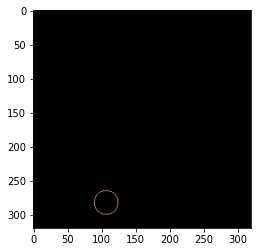

длина 96.56854152679443
длина 136.56854152679443
длина 106.91168785095215
длина 123.882248878479
длина 112.56854152679443
длина 122.91168737411499
длина 12.828427076339722
длина 12.828427076339722
длина 12.828427076339722
длина 12.828427076339722
длина 12.828427076339722
длина 12.828427076339722
длина 12.828427076339722
длина 12.828427076339722
длина 96.56854152679443
длина 136.56854152679443
длина 109.25483322143555
длина 120.56854152679443
длина 33.65685415267944
длина 33.65685415267944
длина 33.65685415267944
длина 33.65685415267944
длина 96.56854152679443
длина 136.56854152679443
длина 109.25483322143555
длина 123.88224983215332
длина 114.91168737411499
длина 118.22539615631104
itogo 7


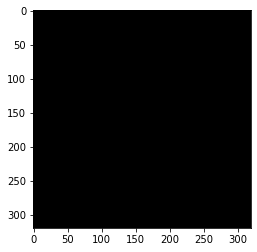

itogo 7
train_data/60.png


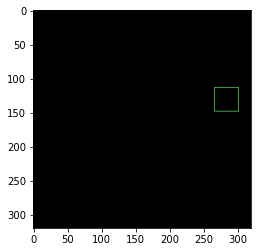

длина 115.31370830535889
длина 157.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 115.31370830535889
длина 157.65685415267944
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
длина 115.31370830535889
длина 157.65685415267944
длина 129.65685415267944
длина 143.3137083053589
itogo 1


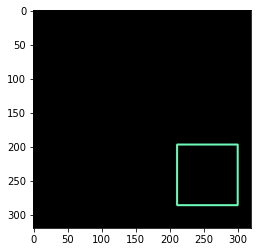

длина 171.65685415267944
длина 329.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 375.3137083053589
длина 337.65685415267944
длина 367.3137083053589
длина 343.3137083053589
длина 361.65685415267944
длина 348.9705619812012
длина 356.0
длина 171.65685415267944
длина 329.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 375.3137083053589
длина 335.3137083053589
длина 369.65685415267944
длина 337.65685415267944
длина 367.3137083053589
длина 340.9705619812012
длина 364.0
длина 343.3137083053589
длина 361.65685415267944
длина 343.3137083053589
длина 361.65685415267944
длина 345.65685415267944
длина 359.3137083053589
длина 348.9705619812012
длина 356.0
длина 351.3137083053589
длина 353.65685415267944
длина 171.65685415267944
длина 329.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 375.3137083053589
длина 337.65685415267944
длина 367.3137083053589
длин

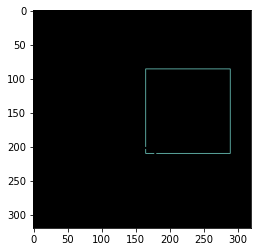

длина 473.79898953437805
длина 515.3137083053589
длина 35.899494767189026
длина 936.3847759962082
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 472.97056245803833
длина 514.4852812290192
длина 39.899494767189026
длина 940.3847759962082
длина 35.899494767189026
длина 936.3847759962082
длина 30.82842707633972
длина 932.4852812290192
длина 473.79898953437805
длина 515.3137083053589
длина 38.24264061450958
длина 938.7279218435287
длина 35.899494767189026
длина 936.3847759962082
длина 30.82842707633972
длина 932.4852812290192
itogo 3


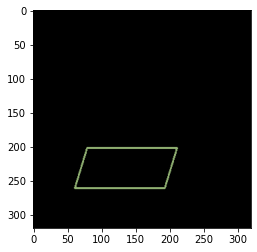

длина 259.65685415267944
длина 7.656854152679443
длина 368.911687374115
длина 7.656854152679443
длина 259.65685415267944
длина 414.56854152679443
длина 376.911687374115
длина 408.2253956794739
длина 382.56854152679443
длина 402.56854152679443
длина 384.911687374115
длина 402.56854152679443
длина 277.3137080669403
длина 24.485281229019165
длина 24.485281229019165
длина 17.656854152679443
длина 17.656854152679443
длина 2.0
длина 2.0
длина 17.656854152679443
длина 17.656854152679443
длина 24.485281229019165
длина 24.485281229019165
длина 277.3137080669403
длина 5.414213538169861
длина 5.414213538169861
длина 259.65685415267944
длина 7.656854152679443
длина 368.911687374115
длина 7.656854152679443
длина 259.65685415267944
длина 414.56854152679443
длина 376.911687374115
длина 408.2253956794739
длина 376.911687374115
длина 406.56854152679443
длина 382.56854152679443
длина 402.56854152679443
длина 384.911687374115
длина 398.56854152679443
длина 277.3137080669403
длина 24.485281229019165
длина

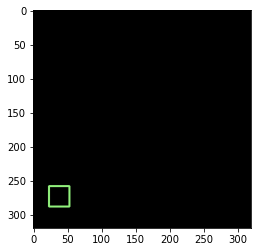

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 112.97056198120117
длина 120.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 99.31370830535889
длина 133.65685415267944
длина 101.65685415267944
длина 131.3137083053589
длина 104.97056198120117
длина 128.0
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 112.97056198120117
длина 120.0
длина 115.31370830535889
длина 117.65685415267944
длина 53.65685415267944
длина 93.65685415267944
длина 

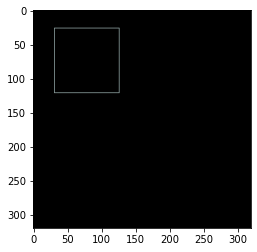

длина 355.3137083053589
длина 397.65685415267944
длина 369.65685415267944
длина 385.65685415267944
длина 375.3137083053589
длина 380.0
длина 171.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 353.65685415267944
длина 171.65685415267944
длина 399.3137083053589
длина 369.65685415267944
длина 385.65685415267944
длина 372.9705619812012
длина 380.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 356.97056245803833
длина 396.0
длина 369.65685415267944
длина 385.65685415267944
длина 372.9705619812012
длина 380.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 5


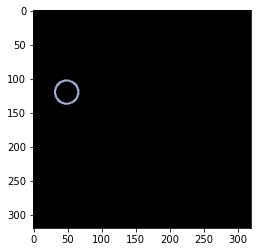

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 98.91168785095215
длина 126.22539567947388
длина 102.22539710998535
длина 122.9116872549057
длина 104.56854057312012
длина 120.56854128837585
длина 106.91168689727783
длина 118.22539615631104
длина 110.22539710998535
длина 114.9116872549057
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 98.91168689727783
длина 126.22539615631104
длина 98.91168880462646
длина 126.22539556026459
длина 104.56854057312012
длина 120.56854128837585
длина 104.56854057312012
длина 120.56854152679443
длина 110.22539615631104
длина 114.91168737411499
длина 8.0
длина 2.0
длина 0.0
длина 5.656854152679443
длина 8.485280990600586
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 8.485280990600586
дли

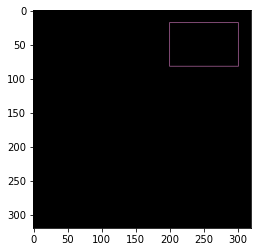

длина 183.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 303.65685415267944
длина 183.65685415267944
длина 349.3137083053589
длина 319.65685415267944
длина 335.65685415267944
длина 322.9705619812012
длина 330.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 183.65685415267944
длина 109.65685415267944
длина 113.65685415267944
длина 303.65685415267944
длина 187.65685415267944
длина 349.3137083053589
длина 319.65685415267944
длина 333.3137083053589
длина 183.65685415267944
длина 109.65685415267944
длина 109.65685415267944
длина 303.65685415267944
длина 183.65685415267944
длина 349.3137083053589
длина 319.65685415267944
длина 335.65685415267944
длина 325.3137083053589
длина 330.0
itogo 5


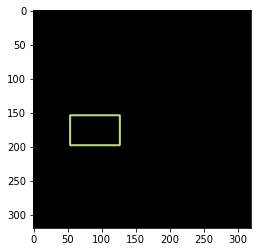

длина 139.65685415267944
длина 207.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 139.65685415267944
длина 253.3137083053589
длина 215.65685415267944
длина 245.3137083053589
длина 215.65685415267944
длина 245.3137083053589
длина 221.3137083053589
длина 239.65685415267944
длина 223.65685415267944
длина 237.3137083053589
длина 226.97056245803833
длина 234.0
длина 229.3137083053589
длина 231.65685415267944
длина 139.65685415267944
длина 207.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 139.65685415267944
длина 253.3137083053589
длина 213.3137083053589
длина 247.65685415267944
длина 215.65685415267944
длина 245.3137083053589
длина 221.3137083053589
длина 239.65685415267944
длина 221.3137083053589
длина 239.65685415267944
длина 223.65685415267944
длина 237.3137083053589
длина 226.97056198120117
длина 234.0
длина 229.3137083053589
длина 231.65685415267944
длина 139.65685415267944
длина 207.65685415267944
длина 81.65685415267944
длина 81.6568541526

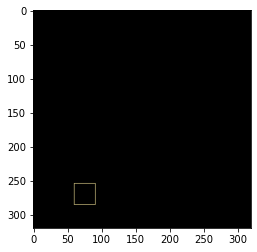

длина 100.97056245803833
длина 140.0
длина 113.65685415267944
длина 129.65685415267944
длина 116.97056198120117
длина 124.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 129.65685415267944
длина 116.97056198120117
длина 124.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 6


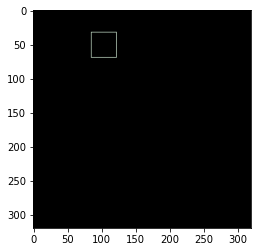

длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 140.97056198120117
длина 148.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 123.31370830535889
длина 165.65685415267944
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 121.65685415267944
длина 55.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 153.65685415267944
длина 140.97056198120117
длина 148.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 7


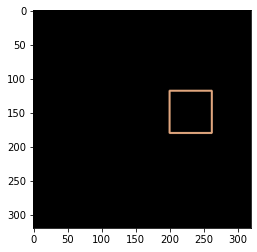

длина 117.65685415267944
длина 221.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 267.3137083053589
длина 227.3137083053589
длина 261.65685415267944
длина 229.65685415267944
длина 259.3137083053589
длина 232.97056198120117
длина 253.65685415267944
длина 235.3137083053589
длина 253.65685415267944
длина 237.65685415267944
длина 251.3137083053589
длина 240.97056245803833
длина 248.0
длина 243.3137083053589
длина 245.65685415267944
длина 117.65685415267944
длина 221.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 267.3137083053589
длина 229.65685415267944
длина 259.3137083053589
длина 232.97056198120117
длина 256.0
длина 235.3137083053589
длина 253.65685415267944
длина 237.65685415267944
длина 251.3137083053589
длина 243.3137083053589
длина 248.0
длина 117.65685415267944
длина 221.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 267.3137083053589
д

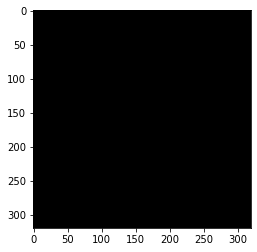

itogo 8
train_data/61.png


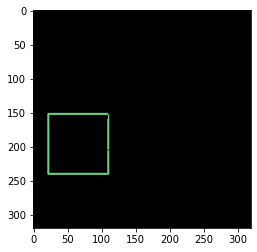

длина 169.65685415267944
длина 61.65685415267944
длина 5.656854152679443
длина 83.65685415267944
длина 326.48528122901917
длина 169.65685415267944
длина 169.65685415267944
длина 370.72792184352875
длина 335.899494767189
длина 363.55634891986847
длина 342.1421353816986
длина 357.3137081861496
длина 86.0
длина 584.7279214859009
длина 169.65685415267944
длина 63.65685415267944
длина 85.65685415267944
длина 326.48528122901917
длина 169.65685415267944
длина 169.65685415267944
длина 370.72792184352875
длина 335.0710676908493
длина 363.3137083053589
длина 335.899494767189
длина 363.55634891986847
длина 340.72792184352875
длина 357.0710676908493
длина 342.1421353816986
длина 357.899494767189
длина 100.24264061450958
длина 590.3847759962082
длина 86.0
длина 584.7279214859009
длина 82.0
длина 580.7279218435287
длина 169.65685415267944
длина 61.65685415267944
длина 5.656854152679443
длина 83.65685415267944
длина 326.48528122901917
длина 169.65685415267944
длина 169.65685415267944
длина 370.727921

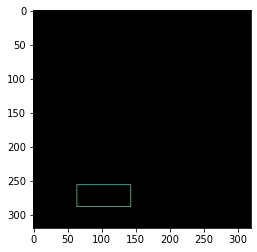

длина 198.97056245803833
длина 238.0
длина 211.65685415267944
длина 225.3137083053589
длина 197.3137083053589
длина 239.65685415267944
длина 209.3137083053589
длина 227.65685415267944
длина 211.65685415267944
длина 225.3137083053589
длина 217.3137083053589
длина 222.0
длина 197.3137083053589
длина 239.65685415267944
длина 211.65685415267944
длина 227.65685415267944
длина 214.97056198120117
длина 228.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


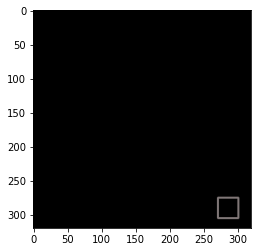

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 117.65685415267944
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267

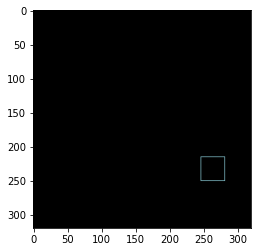

длина 51.65685415267944
длина 51.65685415267944
длина 51.65685415267944
длина 113.65685415267944
длина 51.65685415267944
длина 159.3137083053589
длина 129.65685415267944
длина 145.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 51.65685415267944
длина 51.65685415267944
длина 51.65685415267944
длина 113.65685415267944
длина 51.65685415267944
длина 159.3137083053589
длина 129.65685415267944
длина 145.65685415267944
длина 132.97056198120117
длина 140.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 115.31370830535889
длина 157.65685415267944
длина 129.65685415267944
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
itogo 3


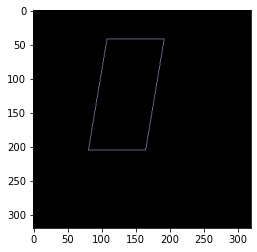

длина 492.02438521385193
длина 533.1959581375122
длина 506.02438521385193
длина 522.0243852138519
длина 173.65685415267944
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 173.65685415267944
длина 492.02438521385193
длина 533.1959581375122
длина 506.02438521385193
длина 522.0243852138519
длина 173.65685415267944
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0

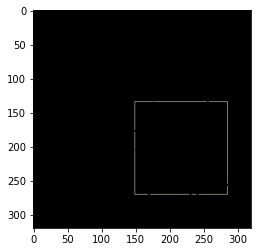

длина 67.65685415267944
длина 99.65685415267944
длина 21.656854152679443
длина 7.656854152679443
длина 111.65685415267944
длина 35.65685415267944
длина 223.65685415267944
длина 65.65685415267944
длина 524.2842707633972
длина 37.65685415267944
длина 137.65685415267944
длина 37.65685415267944
длина 571.5979790687561
длина 16.0
длина 118.0
длина 110.82842707633972
длина 222.82842707633972
длина 296.8284270763397
длина 294.8284270763397
длина 8.0
длина 110.0
длина 102.82842707633972
длина 160.82842707633972
длина 46.0
длина 288.8284270763397
длина 148.0
длина 130.82842707633972
длина 525.9411249160767
длина 564.9705624580383
длина 16.0
длина 118.0
длина 110.82842707633972
длина 222.82842707633972
длина 296.8284270763397
длина 294.8284270763397
длина 8.0
длина 110.0
длина 102.2426404953003
длина 160.2426404953003
длина 46.0
длина 288.2426404953003
длина 148.0
длина 130.2426404953003
длина 69.65685415267944
длина 103.65685415267944
длина 23.656854152679443
длина 9.656854152679443
длина 113.6

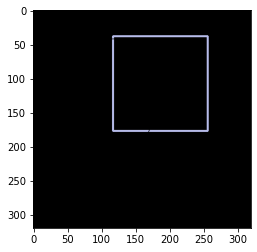

длина 165.65685415267944
длина 97.65685415267944
длина 261.65685415267944
длина 529.6568541526794
длина 271.65685415267944
длина 271.65685415267944
длина 575.3137083053589
длина 537.6568541526794
длина 567.3137083053589
длина 539.899494767189
длина 568.9705624580383
длина 543.3137083053589
длина 561.6568541526794
длина 1104.2842707633972
длина 366.2426404953003
длина 723.3137080669403
длина 362.2426406145096
длина 719.3137083053589
длина 165.65685415267944
длина 97.65685415267944
длина 261.65685415267944
длина 529.6568541526794
длина 271.65685415267944
длина 271.65685415267944
длина 575.3137083053589
длина 537.6568541526794
длина 567.3137083053589
длина 539.899494767189
длина 568.9705624580383
длина 543.3137083053589
длина 561.6568541526794
длина 1104.2842707633972
длина 366.2426406145096
длина 725.3137083053589
длина 362.2426406145096
длина 722.7279218435287
длина 165.65685415267944
длина 97.65685415267944
длина 261.65685415267944
длина 529.6568541526794
длина 271.65685415267944
длина

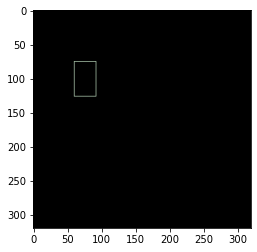

длина 45.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 139.65685415267944
длина 45.65685415267944
длина 185.3137083053589
длина 155.65685415267944
длина 171.65685415267944
длина 158.97056198120117
длина 166.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 141.3137083053589
длина 183.65685415267944
длина 155.65685415267944
длина 171.65685415267944
длина 155.65685415267944
длина 169.3137083053589
длина 161.3137083053589
длина 166.0
длина 45.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 139.65685415267944
длина 45.65685415267944
длина 185.3137083053589
длина 155.65685415267944
длина 171.65685415267944
длина 158.97056198120117
длина 166.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 5


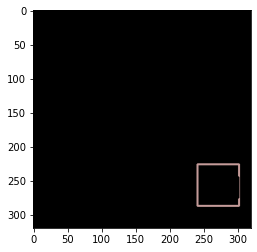

длина 115.65685415267944
длина 15.656854152679443
длина 219.3137083053589
длина 29.656854152679443
длина 115.65685415267944
длина 115.65685415267944
длина 263.3137083053589
длина 227.3137083053589
длина 255.3137083053589
длина 228.1421353816986
длина 256.1421353816986
длина 422.6274166107178
длина 422.1421353816986
длина 414.6274166107178
длина 411.3137083053589
длина 115.65685415267944
длина 15.656854152679443
длина 45.65685415267944
длина 218.48528122901917
длина 29.656854152679443
длина 115.65685415267944
длина 115.65685415267944
длина 264.1421353816986
длина 227.3137083053589
длина 255.3137083053589
длина 230.62741613388062
длина 249.65685415267944
длина 419.79898953437805
длина 414.6274166107178
длина 408.97056245803833
длина 115.65685415267944
длина 15.656854152679443
длина 45.65685415267944
длина 218.48528122901917
длина 29.656854152679443
длина 115.65685415267944
длина 115.65685415267944
длина 264.1421353816986
длина 227.3137083053589
длина 255.3137083053589
длина 230.627416133

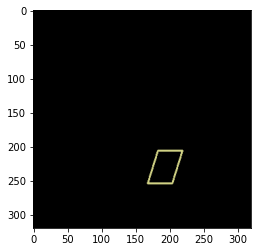

длина 67.65685415267944
длина 7.656854152679443
длина 152.42640614509583
длина 7.656854152679443
длина 67.65685415267944
длина 198.08326029777527
длина 157.5979790687561
длина 191.74011421203613
длина 160.42640614509583
длина 190.08326029777527
длина 164.42640614509583
длина 186.08326029777527
длина 166.08326029777527
длина 186.08326029777527
длина 168.42640614509583
длина 182.08326029777527
длина 98.97056221961975
длина 31.313708305358887
длина 31.313708305358887
длина 31.313708305358887
длина 31.313708305358887
длина 98.97056221961975
длина 70.82842707633972
длина 70.82842707633972
длина 67.65685415267944
длина 7.656854152679443
длина 152.42640614509583
длина 7.656854152679443
длина 67.65685415267944
длина 198.08326029777527
длина 157.5979790687561
длина 191.74011421203613
длина 160.42640614509583
длина 190.08326029777527
длина 164.42640614509583
длина 186.08326029777527
длина 166.08326029777527
длина 186.08326029777527
длина 168.42640614509583
длина 182.08326029777527
длина 98.97056

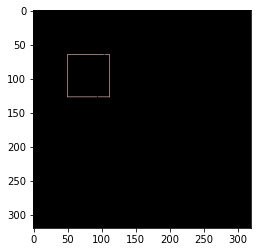

длина 17.656854152679443
длина 69.65685415267944
длина 105.65685415267944
длина 105.65685415267944
длина 223.3137083053589
длина 89.65685415267944
длина 268.1421353816986
длина 237.65685415267944
длина 253.65685415267944
длина 170.1421353816986
длина 314.1421353816986
длина 161.65685415267944
длина 305.65685415267944
длина 224.1421353816986
длина 265.65685415267944
длина 237.65685415267944
длина 253.65685415267944
длина 165.65685415267944
длина 309.65685415267944
длина 224.1421353816986
длина 265.65685415267944
длина 237.65685415267944
длина 253.65685415267944
длина 165.65685415267944
длина 309.65685415267944
itogo 7


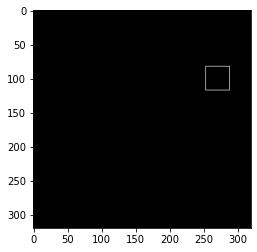

длина 115.31370830535889
длина 157.65685415267944
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
длина 51.65685415267944
длина 51.65685415267944
длина 51.65685415267944
длина 113.65685415267944
длина 51.65685415267944
длина 159.3137083053589
длина 129.65685415267944
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
длина 115.31370830535889
длина 157.65685415267944
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 140.0
itogo 8


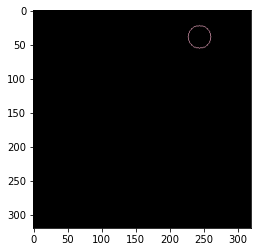

длина 90.91168689727783
длина 128.56854152679443
длина 103.5979790687561
длина 118.22539520263672
длина 109.25483322143555
длина 117.25483322143555
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 90.91168689727783
длина 128.56854152679443
длина 101.25483226776123
длина 114.91168642044067
длина 33.65685415267944
длина 3.414213538169861
длина 3.414213538169861
длина 33.65685415267944
длина 33.65685415267944
длина 3.414213538169861
длина 3.414213538169861
длина 33.65685415267944
длина 90.91168689727783
длина 128.56854152679443
длина 101.25483226776123
длина 114.91168642044067
длина 109.25483322143555
длина 112.56854152679443
itogo 8


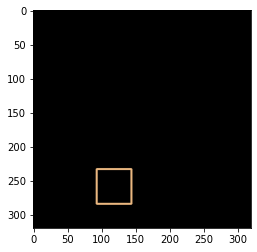

длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 183.3137083053589
длина 217.65685415267944
длина 185.65685415267944
длина 215.3137083053589
длина 188.97056198120117
длина 209.65685415267944
длина 191.3137083053589
длина 209.65685415267944
длина 193.65685415267944
длина 207.3137083053589
длина 193.65685415267944
длина 207.3137083053589
длина 196.97056198120117
длина 204.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 95.65685415267944
длина 177.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 95.65685415267944
длина 223.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 185.65685415267944
длина 215.3137083053589
длина 191.3137083053589
длина 209.65685415267944
длина 193.65685415267944
длина 207.3137083053589
длина 196.97056198120117
длина 204.0
длина 199.3137083053589
длина 201.65685415267

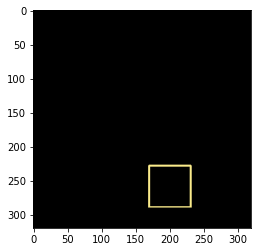

длина 217.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 261.3137083053589
длина 223.3137083053589
длина 255.65685415267944
длина 225.65685415267944
длина 254.48528122901917
длина 228.97056198120117
длина 250.0
длина 231.3137083053589
длина 248.82842707633972
длина 231.3137083053589
длина 247.65685415267944
длина 372.1421353816986
длина 361.3137080669403
длина 361.3137083053589
длина 217.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 261.3137083053589
длина 223.3137083053589
длина 255.65685415267944
длина 225.65685415267944
длина 253.3137083053589
длина 228.97056198120117
длина 248.82842707633972
длина 231.3137083053589
длина 248.82842707633972
длина 233.65685415267944
длина 246.48528122901917
длина 365.79898953437805
длина 361.3137080669403
длина 0.0
длина 0.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 217.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина

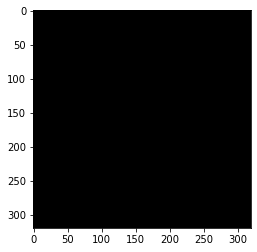

itogo 10
train_data/62.png


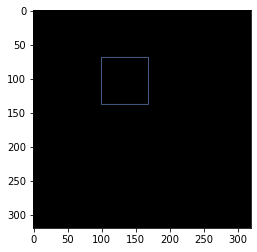

длина 251.3137083053589
длина 293.65685415267944
длина 268.9705619812012
длина 276.0
длина 252.97056245803833
длина 292.0
длина 265.65685415267944
длина 279.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 251.3137083053589
длина 293.65685415267944
длина 265.65685415267944
длина 281.65685415267944
длина 268.9705619812012
длина 276.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


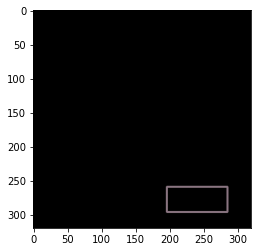

длина 171.65685415267944
длина 225.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 171.65685415267944
длина 271.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 244.97056198120117
длина 252.0
длина 171.65685415267944
длина 225.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 171.65685415267944
длина 271.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 171.65685415267944
длина 225.65685415267944
длина 67.65685415267944
длина 67.65685415267944
длина 171.65685415267944
длина 271.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина

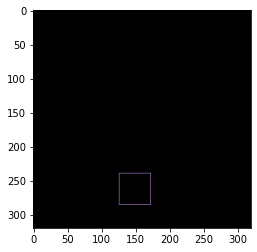

длина 160.97056245803833
длина 200.0
длина 173.65685415267944
длина 189.65685415267944
длина 179.3137083053589
длина 184.0
длина 159.3137083053589
длина 201.65685415267944
длина 173.65685415267944
длина 187.3137083053589
длина 159.3137083053589
длина 201.65685415267944
длина 173.65685415267944
длина 189.65685415267944
длина 179.3137083053589
длина 184.0
itogo 2


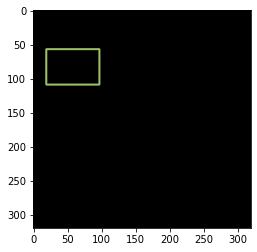

длина 149.65685415267944
длина 233.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 149.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 265.65685415267944
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 255.3137083053589
длина 257.65685415267944
длина 149.65685415267944
длина 233.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 149.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 255.3137083053589
длина 257.65685415267944
длина 149.65685415267944
длина 233.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 149.65685415267944
длина 279.3137083053589
длина 241.65685415

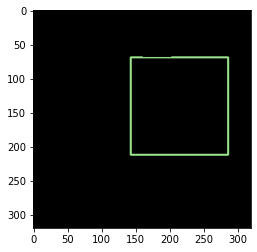

длина 279.65685415267944
длина 545.6568541526794
длина 279.65685415267944
длина 279.65685415267944
длина 161.65685415267944
длина 29.656854152679443
длина 592.1421353816986
длина 553.6568541526794
длина 584.1421353816986
длина 556.9705619812012
длина 578.4852812290192
длина 559.3137083053589
длина 578.4852812290192
длина 1056.6274166107178
длина 1046.9705624580383
длина 279.65685415267944
длина 545.6568541526794
длина 279.65685415267944
длина 279.65685415267944
длина 161.65685415267944
длина 29.656854152679443
длина 592.1421353816986
длина 551.3137083053589
длина 586.4852812290192
длина 553.6568541526794
длина 584.1421353816986
длина 556.9705619812012
длина 578.4852812290192
длина 559.3137083053589
длина 578.4852812290192
длина 561.6568541526794
длина 576.1421353816986
длина 1056.6274166107178
длина 1049.313708305359
длина 279.65685415267944
длина 545.6568541526794
длина 279.65685415267944
длина 279.65685415267944
длина 161.65685415267944
длина 29.656854152679443
длина 592.142135381698

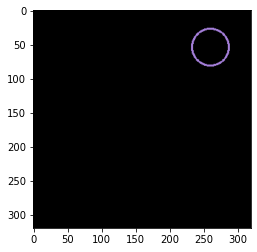

длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 156.85281372070312
длина 17.656854152679443
длина 200.1665210723877
длина 164.85281372070312
длина 192.1665210723877
длина 172.26702535152435
длина 188.85281133651733
длина 172.85281229019165
длина 186.50966548919678
длина 172.85281372070312
длина 184.1665210723877
длина 72.28427076339722
длина 6.2426406145095825
длина 6.828427076339722
длина 72.28427076339722
длина 72.28427076339722
длина 6.828427076339722
длина 6.828427076339722
длина 72.28427076339722
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 156.85281372070312
длина 17.656854152679443
длина 200.1665210723877
длина 167.19595849514008
длина 192.16651916503906
длина 170.50966548919678
длина 186.50966548919678
длина 173.438599586

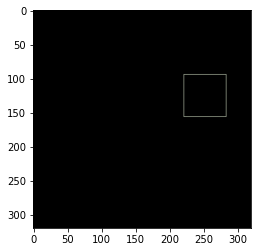

длина 223.3137083053589
длина 265.65685415267944
длина 237.65685415267944
длина 253.65685415267944
длина 243.3137083053589
длина 248.0
длина 223.3137083053589
длина 265.65685415267944
длина 237.65685415267944
длина 253.65685415267944
длина 243.3137083053589
длина 248.0
длина 105.65685415267944
длина 105.65685415267944
длина 105.65685415267944
длина 221.65685415267944
длина 105.65685415267944
длина 267.3137083053589
длина 237.65685415267944
длина 253.65685415267944
длина 243.3137083053589
длина 248.0
itogo 4


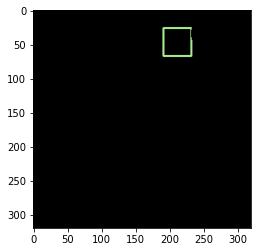

длина 75.65685415267944
длина 41.65685415267944
длина 5.656854152679443
длина 138.48528122901917
длина 75.65685415267944
длина 75.65685415267944
длина 183.55634891986847
длина 145.65685415267944
длина 176.1421353816986
длина 146.48528122901917
длина 175.55634891986847
длина 300.3847759962082
длина 294.3847759962082
длина 286.14213502407074
длина 75.65685415267944
длина 41.65685415267944
длина 138.48528122901917
длина 75.65685415267944
длина 75.65685415267944
длина 184.3847759962082
длина 143.3137083053589
длина 177.89949476718903
длина 145.65685415267944
длина 175.55634891986847
длина 149.5563485622406
длина 172.24264061450958
длина 301.79898953437805
длина 299.55634891986847
длина 288.97056245803833
длина 286.14213502407074
длина 278.72792184352875
длина 75.65685415267944
длина 41.65685415267944
длина 138.48528122901917
длина 75.65685415267944
длина 75.65685415267944
длина 182.72792184352875
длина 145.65685415267944
длина 176.1421353816986
длина 151.3137083053589
длина 170.48528122901

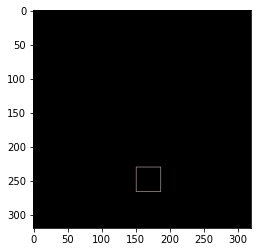

длина 119.31370830535889
длина 161.65685415267944
длина 133.65685415267944
длина 149.65685415267944
длина 139.3137083053589
длина 144.0
длина 119.31370830535889
длина 161.65685415267944
длина 133.65685415267944
длина 149.65685415267944
длина 139.3137083053589
длина 144.0
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 149.65685415267944
длина 139.3137083053589
длина 144.0
itogo 6


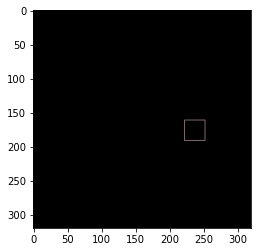

длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 125.65685415267944
длина 112.97056198120117
длина 120.0
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
itogo 7


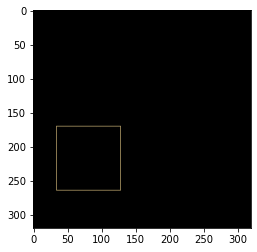

длина 351.3137083053589
длина 393.65685415267944
длина 365.65685415267944
длина 381.65685415267944
длина 368.9705619812012
длина 376.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 169.65685415267944
длина 169.65685415267944
длина 169.65685415267944
длина 349.65685415267944
длина 169.65685415267944
длина 395.3137083053589
длина 365.65685415267944
длина 381.65685415267944
длина 371.3137083053589
длина 376.0
длина 352.97056245803833
длина 392.0
длина 365.65685415267944
длина 379.3137083053589
itogo 8


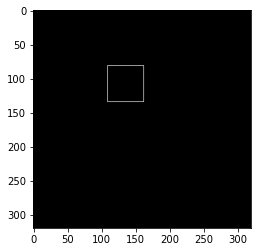

длина 188.97056245803833
длина 228.0
длина 201.65685415267944
длина 217.65685415267944
длина 204.97056198120117
длина 212.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 185.65685415267944
длина 87.65685415267944
длина 231.3137083053589
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
длина 187.3137083053589
длина 229.65685415267944
длина 201.65685415267944
длина 217.65685415267944
длина 204.97056198120117
длина 212.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 9


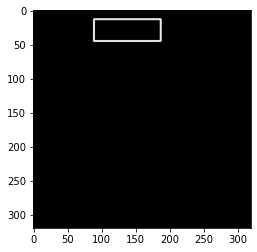

длина 189.65685415267944
длина 233.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 189.65685415267944
длина 279.3137083053589
длина 239.3137083053589
длина 273.65685415267944
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 265.65685415267944
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 252.97056245803833
длина 260.0
длина 255.3137083053589
длина 260.0
длина 189.65685415267944
длина 233.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 189.65685415267944
длина 279.3137083053589
длина 239.3137083053589
длина 273.65685415267944
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 265.65685415267944
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 249.65685415267944
длина 263.3137083053589
длина 252.97056198120117
длина 260.0
длина 6.2426406145095825
длина 6.2426406145095825
длина

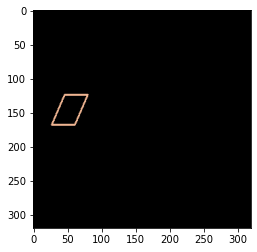

длина 63.65685415267944
длина 5.656854152679443
длина 140.911687374115
длина 5.656854152679443
длина 63.65685415267944
длина 189.39696860313416
длина 148.911687374115
длина 185.39696860313416
длина 151.7401144504547
длина 181.39696860313416
длина 154.56854152679443
длина 178.56854152679443
длина 155.74011421203613
длина 175.7401144504547
длина 158.56854152679443
длина 174.56854152679443
длина 159.7401144504547
длина 173.39696860313416
длина 94.97056245803833
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 94.97056245803833
длина 66.82842707633972
длина 66.82842707633972
длина 63.65685415267944
длина 5.656854152679443
длина 140.911687374115
длина 5.656854152679443
длина 63.65685415267944
длина 189.39696860313416
длина 148.911687374115
длина 183.0538227558136
длина 152.911687374115
длина 181.39696860313416
длина 155.74011421203613
д

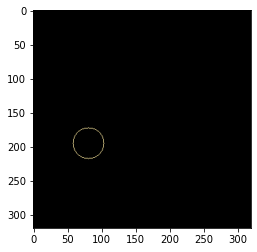

длина 129.53910541534424
длина 169.53910398483276
длина 142.22539567947388
длина 156.85281372070312
длина 145.53910446166992
длина 155.88224983215332
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 16.82842707633972
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539567947388
длина 156.85281372070312
длина 147.88224983215332
длина 151.1959571838379
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 129.53910541534424
длина 169.53910398483276
длина 142.22539520263672
длина 153.53910446166992
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
itogo 9


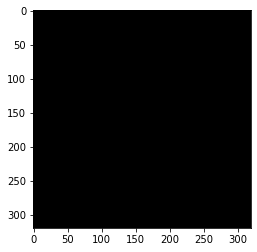

itogo 9
train_data/63.png


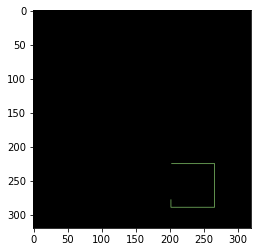

длина 109.65685415267944
длина 5.656854152679443
длина 109.65685415267944
длина 109.65685415267944
длина 416.3847759962082
длина 402.1421353816986
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 414.72792184352875
длина 404.48528122901917
длина 403.6984839439392
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 414.72792184352875
длина 400.3847759962082
itogo 1


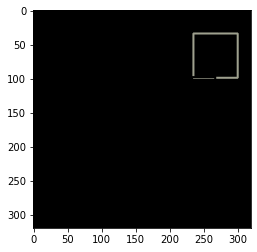

длина 45.65685415267944
длина 55.65685415267944
длина 235.89949476718903
длина 123.65685415267944
длина 117.65685415267944
длина 123.65685415267944
длина 282.3847759962082
длина 64.0
длина 450.3847759962082
длина 56.0
длина 442.97056210041046
длина 442.3847759962082
длина 438.3847759962082
длина 432.72792184352875
длина 55.65685415267944
длина 235.89949476718903
длина 123.65685415267944
длина 117.65685415267944
длина 123.65685415267944
длина 280.72792184352875
длина 64.0
длина 450.3847759962082
длина 56.0
длина 444.7279214859009
длина 442.3847759962082
длина 438.3847759962082
длина 436.72792184352875
длина 45.65685415267944
длина 55.65685415267944
длина 235.89949476718903
длина 123.65685415267944
длина 117.65685415267944
длина 123.65685415267944
длина 281.55634891986847
длина 61.65685415267944
длина 450.3847759962082
длина 52.0
длина 444.72792184352875
длина 442.3847759962082
длина 436.7279214859009
itogo 2


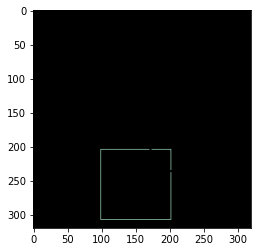

длина 388.1421353816986
длина 430.48528122901917
длина 118.82842707633972
длина 692.4852812290192
длина 110.82842707633972
длина 684.4852812290192
длина 388.97056245803833
длина 431.3137083053589
длина 118.24264061450958
длина 690.7279218435287
длина 115.89949476718903
длина 688.3847759962082
длина 106.82842707633972
длина 680.4852812290192
длина 389.79898953437805
длина 432.1421353816986
длина 118.82842707633972
длина 692.4852812290192
длина 110.2426404953003
длина 682.7279214859009
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 3


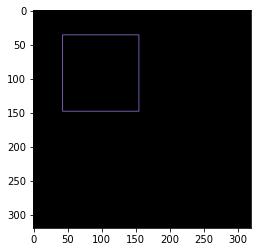

длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 421.65685415267944
длина 205.65685415267944
длина 467.3137083053589
длина 437.65685415267944
длина 453.65685415267944
длина 443.3137083053589
длина 448.0
длина 423.3137083053589
длина 465.65685415267944
длина 437.65685415267944
длина 451.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 421.65685415267944
длина 205.65685415267944
длина 467.3137083053589
длина 435.3137083053589
длина 453.65685415267944
длина 437.65685415267944
длина 451.3137083053589
длина 443.3137083053589
длина 448.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 4


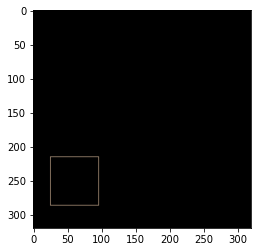

длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 276.9705619812012
длина 284.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 259.3137083053589
длина 301.65685415267944
длина 273.65685415267944
длина 289.65685415267944
длина 279.3137083053589
длина 284.0
длина 260.97056245803833
длина 300.0
длина 273.65685415267944
длина 287.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 5


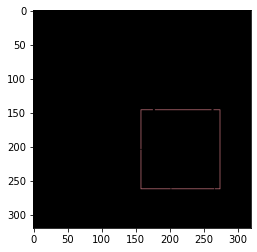

длина 109.65685415267944
длина 69.65685415267944
длина 97.65685415267944
длина 213.65685415267944
длина 97.65685415267944
длина 444.2842707633972
длина 149.65685415267944
длина 17.656854152679443
длина 490.7695519924164
длина 168.0
длина 747.3137083053589
длина 124.0
длина 198.2426404953003
длина 260.4852809906006
длина 164.0
длина 146.2426404953003
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 113.65685415267944
длина 71.65685415267944
длина 99.65685415267944
длина 213.65685415267944
длина 99.65685415267944
длина 444.2842707633972
длина 153.65685415267944
длина 19.656854152679443
длина 489.11269783973694
длина 165.65685415267944
длина 747.5979790687561
длина 442.6274166107178
длина 485.79898953437805
длина 165.65685415267944
длина 747.5979790687561
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 6


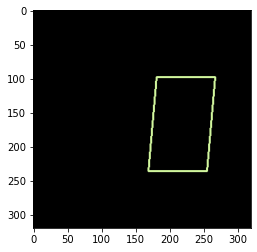

длина 165.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 431.5979790687561
длина 5.656854152679443
длина 5.656854152679443
длина 165.65685415267944
длина 477.25483322143555
длина 439.5979790687561
длина 469.25483322143555
длина 439.5979790687561
длина 469.25483322143555
длина 445.25483322143555
длина 463.5979790687561
длина 445.25483322143555
длина 463.5979790687561
длина 447.5979790687561
длина 461.25483322143555
длина 450.

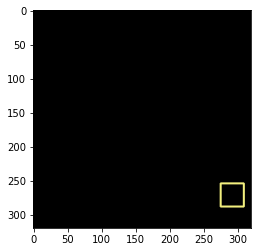

длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 115.31370830535889
длина 149.65685415267944
длина 117.65685415267944
длина 147.3137083053589
длина 120.97056198120117
длина 144.0
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 131.3137083053589
длина 133.65685415267944
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 115.31370830535889
длина 149.65685415267944
длина 117.65685415267944
длина 147.3137083053589
длина 120.97056198120117
длина 144.0
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 131.3137083

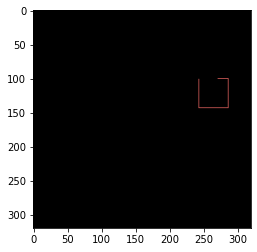

длина 296.72792184352875
длина 286.3847759962082
длина 282.3847759962082
длина 278.48528122901917
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 67.65685415267944
длина 67.65685415267944
длина 71.65685415267944
длина 17.656854152679443
длина 298.3847759962082
длина 282.3847759962082
длина 296.72792184352875
длина 276.7279214859009
itogo 8


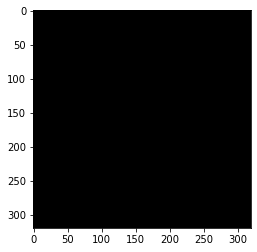

itogo 8
train_data/64.png


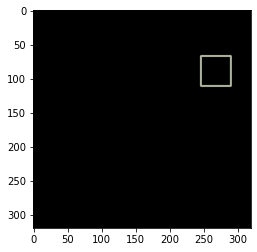

длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 168.97056198120117
длина 176.0
длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 168.97056198120117
длина 176.0
длина 171.3137083053589
длина 173.65685415267944
длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
д

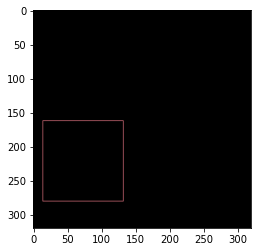

длина 217.65685415267944
длина 217.65685415267944
длина 217.65685415267944
длина 445.65685415267944
длина 217.65685415267944
длина 491.3137083053589
длина 461.65685415267944
длина 477.65685415267944
длина 461.65685415267944
длина 475.3137083053589
длина 467.3137083053589
длина 472.0
длина 447.3137083053589
длина 489.65685415267944
длина 461.65685415267944
длина 475.3137083053589
длина 447.3137083053589
длина 489.65685415267944
длина 461.65685415267944
длина 475.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


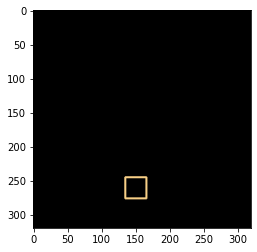

длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 103.31370830535889
длина 137.65685415267944
длина 105.65685415267944
длина 135.3137083053589
длина 108.97056198120117
длина 132.0
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 116.97056198120117
длина 124.0
длина 119.31370830535889
длина 121.65685415267944
длина 55.65685415267944
длина 97.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 143.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 105.65685415267944
длина 135.3137083053589
длина 111.31370830535889
длина 129.65685415267944
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 116.97056198120117
длина 124.0
длина 6.2426406145095825
длина 6.2426406145095825
длин

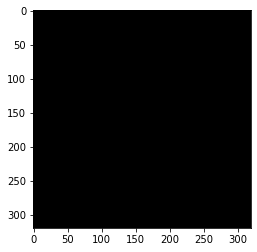

itogo 3
train_data/65.png


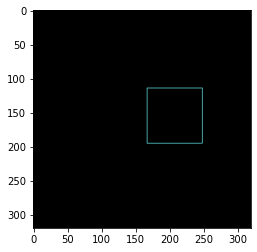

длина 143.65685415267944
длина 143.65685415267944
длина 147.65685415267944
длина 297.65685415267944
длина 147.65685415267944
длина 343.3137083053589
длина 316.9705619812012
длина 324.0
длина 299.3137083053589
длина 341.65685415267944
длина 311.3137083053589
длина 329.65685415267944
длина 313.65685415267944
длина 327.3137083053589
длина 319.3137083053589
длина 324.0
длина 299.3137083053589
длина 341.65685415267944
длина 311.3137083053589
длина 329.65685415267944
длина 313.65685415267944
длина 327.3137083053589
длина 319.3137083053589
длина 324.0
itogo 1


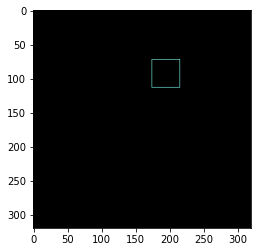

длина 139.3137083053589
длина 181.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 137.65685415267944
длина 63.65685415267944
длина 183.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 139.3137083053589
длина 181.65685415267944
длина 153.65685415267944
длина 169.65685415267944
длина 156.97056198120117
длина 164.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


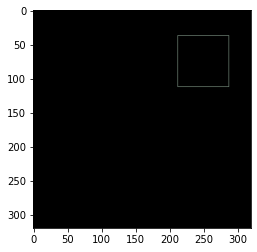

длина 275.3137083053589
длина 317.65685415267944
длина 289.65685415267944
длина 303.3137083053589
длина 276.97056245803833
длина 316.0
длина 289.65685415267944
длина 303.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 275.3137083053589
длина 317.65685415267944
длина 289.65685415267944
длина 303.3137083053589
itogo 3


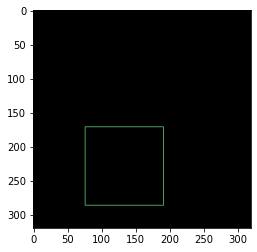

длина 435.3137083053589
длина 477.65685415267944
длина 449.65685415267944
длина 463.3137083053589
длина 436.97056245803833
длина 476.0
длина 447.3137083053589
длина 465.65685415267944
длина 449.65685415267944
длина 463.3137083053589
длина 455.3137083053589
длина 460.0
длина 436.97056245803833
длина 476.0
длина 449.65685415267944
длина 463.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 4


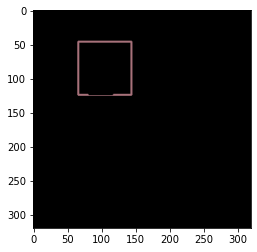

длина 47.65685415267944
длина 23.656854152679443
длина 287.3137083053589
длина 149.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 331.3137083053589
длина 295.3137083053589
длина 323.3137083053589
длина 298.6274161338806
длина 320.0
длина 547.798989534378
длина 543.798989534378
длина 536.9705619812012
длина 47.65685415267944
длина 23.656854152679443
длина 286.48528122901917
длина 149.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 331.3137083053589
длина 295.3137083053589
длина 323.3137083053589
длина 547.798989534378
длина 540.9705624580383
длина 57.65685415267944
длина 47.65685415267944
длина 23.656854152679443
длина 286.48528122901917
длина 149.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 332.1421353816986
длина 295.3137083053589
длина 323.3137083053589
длина 550.6274166107178
длина 543.798989534378
длина 536.9705624580383
itogo 5


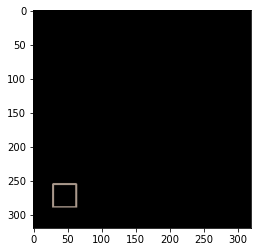

длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 153.3137083053589
длина 117.65685415267944
длина 146.48528122901917
длина 117.65685415267944
длина 145.3137083053589
длина 123.31370830535889
длина 140.82842707633972
длина 125.65685415267944
длина 138.48528122901917
длина 199.3137080669403
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 153.3137083053589
длина 117.65685415267944
длина 146.48528122901917
длина 120.97056198120117
длина 140.82842707633972
длина 123.31370830535889
длина 139.65685415267944
длина 202.1421353816986
длина 196.48528122901917
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 153.3137083053589
длина 117.65685415267944
длина 146.48528122901917
длина 123.31370830535889
длина 140.82842707633972
длина 125.65685415267944
длина 138.48528122901917
длина 199.3137080669403
itogo 6


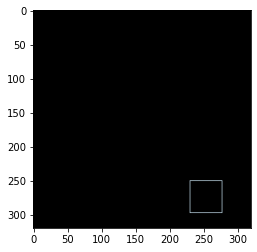

длина 164.97056245803833
длина 204.0
длина 177.65685415267944
длина 193.65685415267944
длина 180.97056198120117
длина 188.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 163.3137083053589
длина 205.65685415267944
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 163.3137083053589
длина 205.65685415267944
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
itogo 7


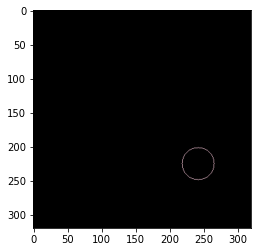

длина 135.1959581375122
длина 175.1959581375122
длина 147.882248878479
длина 162.5096664428711
длина 153.53910446166992
длина 156.85281467437744
длина 135.1959581375122
длина 175.1959581375122
длина 147.882248878479
длина 159.1959581375122
длина 52.97056245803833
длина 52.97056245803833
длина 52.97056245803833
длина 52.97056245803833
длина 135.1959581375122
длина 175.1959581375122
длина 147.882248878479
длина 159.1959581375122
длина 57.79898953437805
длина 57.79898953437805
длина 57.79898953437805
длина 57.79898953437805
itogo 7


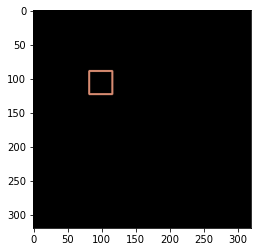

длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 131.3137083053589
длина 133.65685415267944
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.313708305358

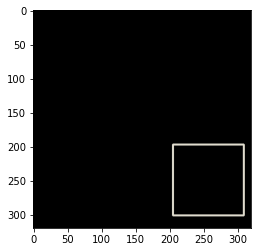

длина 201.65685415267944
длина 389.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 435.3137083053589
длина 395.3137083053589
длина 429.65685415267944
длина 397.65685415267944
длина 427.3137083053589
длина 400.9705619812012
длина 421.65685415267944
длина 403.3137083053589
длина 421.65685415267944
длина 405.65685415267944
длина 419.3137083053589
длина 408.97056245803833
длина 416.0
длина 411.3137083053589
длина 413.65685415267944
длина 201.65685415267944
длина 389.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 201.65685415267944
длина 435.3137083053589
длина 395.3137083053589
длина 429.65685415267944
длина 397.65685415267944
длина 427.3137083053589
длина 403.3137083053589
длина 421.65685415267944
длина 403.3137083053589
длина 421.65685415267944
длина 405.65685415267944
длина 419.3137083053589
длина 408.9705619812012
длина 416.0
длина 411.3137083053589
длина 413.65685415267944
длина 201.65685415267944
длина 389.656854

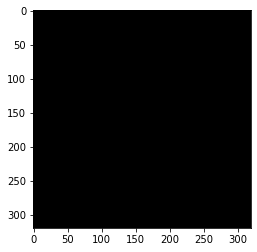

itogo 9
train_data/66.png


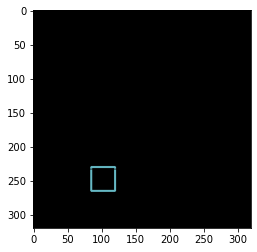

длина 63.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 124.48528122901917
длина 152.97056245803833
длина 130.1421353816986
длина 147.3137083053589
длина 186.4852809906006
длина 72.82842707633972
длина 63.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 124.48528122901917
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 192.1421353816986
длина 77.31370830535889
длина 186.48528122901917
длина 72.82842707633972
длина 182.48528122901917
длина 71.65685415267944
длина 63.65685415267944
длина 55.65685415267944
длина 55.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 124.48528122901917
длина 152.97056245803833
длина 127.31370830535889
д

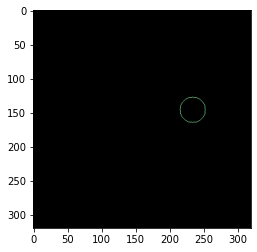

длина 102.22539710998535
длина 142.22539520263672
длина 120.56854152679443
длина 123.88224983215332
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168785095215
длина 126.22539710998535
длина 120.56854057312012
длина 123.88224983215332
длина 102.22539710998535
длина 142.22539520263672
длина 118.22539710998535
длина 126.22539615631104
itogo 1


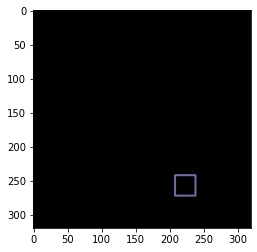

длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 107.31370830535889
длина 125.65685415267944
длина 112.97056198120117
длина 120.0
длина 53.65685415267944
длина 93.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 139.3137083053589
длина 101.65685415267944
длина 131.3137083053589
длина 104.97056198120117
длина 128.0
длина 107.31370830535889
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
itogo 2


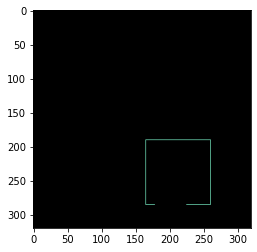

длина 674.9705624580383
длина 660.6274166107178
длина 53.65685415267944
длина 9.656854152679443
длина 171.65685415267944
длина 171.65685415267944
длина 171.65685415267944
длина 676.6274166107178
длина 664.6274166107178
длина 660.6274166107178
длина 657.3137083053589
длина 675.798989534378
длина 665.3137083053589
длина 654.9705619812012
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 3


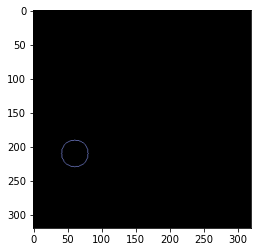

длина 110.22539615631104
длина 150.22539567947388
длина 126.22539615631104
длина 136.56854152679443
длина 110.22539615631104
длина 150.22539567947388
длина 126.22539520263672
длина 134.22539520263672
длина 110.22539615631104
длина 150.22539567947388
длина 122.91168737411499
длина 137.53910446166992
длина 128.56854152679443
длина 131.882248878479
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
itogo 3


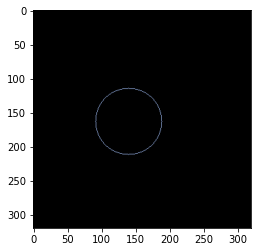

длина 302.3919153213501
длина 342.3919153213501
длина 318.3919143676758
длина 326.3919153213501
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 302.3919153213501
длина 5.656854152679443
длина 5.656854152679443
длина 342.3919153213501
длина 315.0782070159912
длина 326.3919143676758
длина 38.485281229019165
длина 38.485281229019165
длина 38.485281229019165
длина 38.485281229019165
длина 38.485281229019165
длина 38.485281229019165
длина 38.485281229019165
длина 38.485281229019165
длина 302.3919153213501
длина 342.3919153213501
длина 315.0782070159912
длина 329.70562267303467
длина 320.7350606918335
длина 324.048770904541
itogo 3


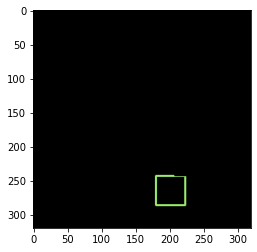

длина 79.65685415267944
длина 77.65685415267944
длина 145.0710676908493
длина 79.65685415267944
длина 11.656854152679443
длина 47.65685415267944
длина 190.72792184352875
длина 153.65685415267944
длина 182.72792184352875
длина 157.5563485622406
длина 177.0710676908493
длина 307.55634891986847
длина 302.97056245803833
длина 296.72792184352875
длина 79.65685415267944
длина 77.65685415267944
длина 145.0710676908493
длина 79.65685415267944
длина 47.65685415267944
длина 190.72792184352875
длина 151.3137083053589
длина 184.48528122901917
длина 153.65685415267944
длина 182.1421353816986
длина 157.5563485622406
длина 177.0710676908493
длина 310.97056245803833
длина 307.55634891986847
длина 302.97056245803833
длина 300.7279214859009
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 79.65685415267944
длина 77.65685415267944
длина 145.0710676908493
длина 79.65685415267944
длина 47.65685415267944
длина 190.72792184352875
длина 153.65685415267944
длина 182.142135381698

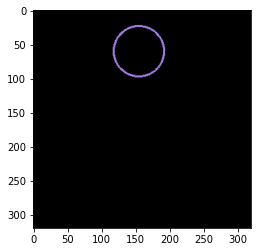

длина 19.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 222.7939383983612
длина 5.656854152679443
длина 5.656854152679443
длина 19.656854152679443
длина 266.1076464653015
длина 233.13708317279816
длина 258.10764503479004
длина 235.86500430107117
длина 254.79393661022186
длина 238.79393649101257
длина 252.4507908821106
длина 241.13708317279816
длина 250.1076464653015
длина 6.2426406145095825
длина 114.32590091228485
длина 114.32590055465698
длина 221.82337391376495
длина 19.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 222.7939383983612
длина 5.656854152679443
длина 5.656854152679443
длина 19.656854152679443
длина 266.1076464653015
длина 233.137083172798

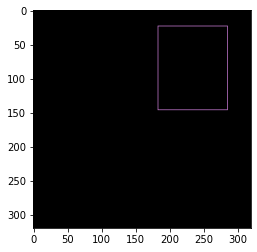

длина 426.97056245803833
длина 466.0
длина 439.65685415267944
длина 455.65685415267944
длина 439.65685415267944
длина 453.3137083053589
длина 445.3137083053589
длина 450.0
длина 425.3137083053589
длина 467.65685415267944
длина 439.65685415267944
длина 453.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 425.3137083053589
длина 467.65685415267944
длина 437.3137083053589
длина 455.65685415267944
длина 439.65685415267944
длина 453.3137083053589
длина 445.3137083053589
длина 450.0
itogo 4


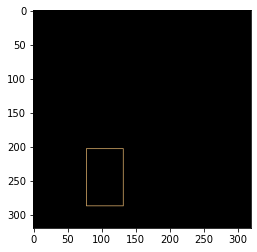

длина 89.65685415267944
длина 149.65685415267944
длина 149.65685415267944
длина 249.65685415267944
длина 89.65685415267944
длина 295.3137083053589
длина 263.3137083053589
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
длина 251.3137083053589
длина 293.65685415267944
длина 265.65685415267944
длина 281.65685415267944
длина 268.9705619812012
длина 276.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 251.3137083053589
длина 293.65685415267944
длина 265.65685415267944
длина 279.3137083053589
itogo 4


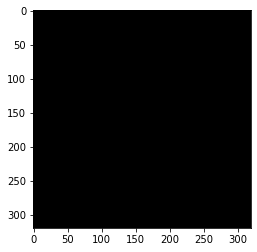

itogo 4
train_data/67.png


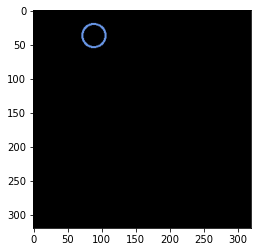

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 98.91168785095215
длина 126.22539567947388
длина 104.56854057312012
длина 120.56854128837585
длина 110.22539710998535
длина 114.9116872549057
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 90.91168737411499
длина 11.656854152679443
длина 134.22539567947388
длина 98.91168785095215
длина 126.22539567947388
длина 102.22539710998535
длина 122.32590043544769
длина 104.56854057312012
длина 120.56854128837585
длина 110.22539615631104
длина 114.91168737411499
длина 8.0
длина 2.0
длина 0.0
длина 0.0
длина 5.656854152679443
длина 8.485280990600586
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 8.485280990600586
длина 11.313708305358887
длина 0.0
длина 0.0
длина 2.0
длина 8.0
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
д

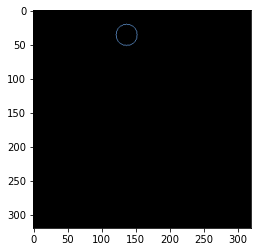

длина 82.91168785095215
длина 122.91168737411499
длина 101.25483322143555
длина 104.56854057312012
длина 82.91168785095215
длина 122.91168737411499
длина 95.59797859191895
длина 106.91168785095215
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 82.91168785095215
длина 122.91168737411499
длина 95.5979790687561
длина 110.22539710998535
длина 101.25483322143555
длина 104.56854057312012
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
itogo 0


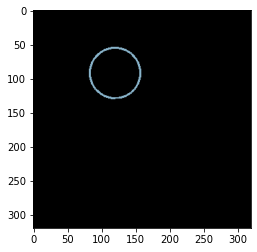

длина 9.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 222.7939383983612
длина 5.656854152679443
длина 5.656854152679443
длина 19.656854152679443
длина 266.1076464653015
длина 233.13708317279816
длина 258.10764503479004
длина 238.79393768310547
длина 252.45079135894775
длина 238.20815062522888
длина 252.4507908821106
длина 39.79898953437805
длина 6.2426406145095825
длина 64.5269113779068
длина 117.1543276309967
длина 227.4802280664444
длина 9.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 222.7939383983612
длина 5.656854152679443
длина 5.656854152679443
длина 19.656854152679443
длина 266.1076464653015
длина 230.7939383983612
длина 258.1076464653015
длина

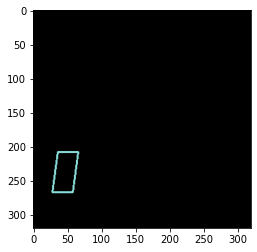

длина 53.65685415267944
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 155.4558436870575
длина 53.65685415267944
длина 202.28427076339722
длина 163.4558436870575
длина 195.94112491607666
длина 170.28427076339722
длина 190.28427076339722
длина 174.28427076339722
длина 187.94112491607666
длина 97.31370830535889
длина 73.31370830535889
длина 73.31370830535889
длина 97.31370830535889
длина 53.65685415267944
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 

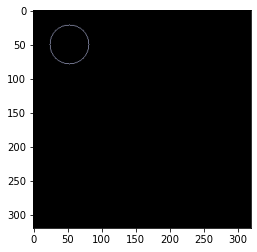

длина 170.5096664428711
длина 208.1665210723877
длина 180.85281372070312
длина 194.50966548919678
длина 66.62741661071777
длина 2.8284270763397217
длина 2.8284270763397217
длина 66.62741661071777
длина 66.62741661071777
длина 2.8284270763397217
длина 2.8284270763397217
длина 66.62741661071777
длина 170.5096664428711
длина 208.1665210723877
длина 180.85281372070312
длина 194.50966548919678
длина 66.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 66.62741661071777
длина 66.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 66.62741661071777
длина 170.5096664428711
длина 208.1665210723877
длина 180.85281372070312
длина 194.50966548919678
длина 186.50966548919678
длина 192.16651916503906
itogo 0


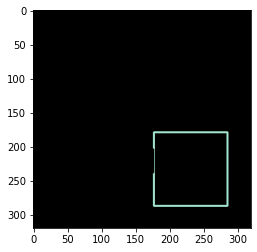

длина 209.65685415267944
длина 89.65685415267944
длина 405.65685415267944
длина 209.65685415267944
длина 41.65685415267944
длина 209.65685415267944
длина 452.1421353816986
длина 413.65685415267944
длина 444.97056245803833
длина 416.9705619812012
длина 441.65685415267944
длина 787.798989534378
длина 783.798989534378
длина 779.3137083053589
длина 209.65685415267944
длина 89.65685415267944
длина 405.65685415267944
длина 209.65685415267944
длина 41.65685415267944
длина 209.65685415267944
длина 452.97056245803833
длина 411.3137083053589
длина 447.3137083053589
длина 413.65685415267944
длина 444.97056245803833
длина 416.9705619812012
длина 439.3137083053589
длина 787.798989534378
длина 786.6274166107178
длина 782.6274166107178
длина 779.3137083053589
длина 209.65685415267944
длина 89.65685415267944
длина 405.65685415267944
длина 209.65685415267944
длина 41.65685415267944
длина 209.65685415267944
длина 452.1421353816986
длина 413.65685415267944
длина 444.97056245803833
длина 414.4852812290191

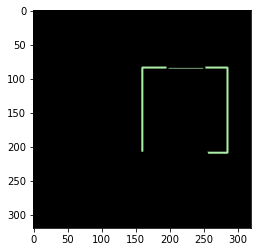

длина 49.65685415267944
длина 243.65685415267944
длина 239.65685415267944
длина 85.65685415267944
длина 57.65685415267944
длина 63.65685415267944
длина 819.3553384542465
длина 104.0
длина 376.72792184352875
длина 323.899494767189
длина 96.0
длина 373.55634891986847
длина 319.899494767189
длина 370.48528122901917
длина 318.2426406145096
длина 367.3137083053589
длина 314.2426406145096
длина 362.4852809906006
длина 310.2426404953003
длина 49.65685415267944
длина 243.65685415267944
длина 239.65685415267944
длина 85.65685415267944
длина 57.65685415267944
длина 63.65685415267944
длина 819.3553384542465
длина 105.65685415267944
длина 377.55634891986847
длина 323.899494767189
длина 101.65685415267944
длина 374.97056245803833
длина 321.55634891986847
длина 96.0
длина 371.89949452877045
длина 318.2426404953003
длина 370.48528122901917
длина 318.2426406145096
длина 369.899494767189
длина 316.48528122901917
длина 366.1421353816986
длина 311.899494767189
длина 362.4852809906006
длина 310.2426404953

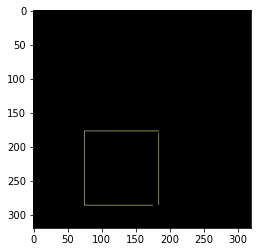

длина 865.798989534378
длина 212.0
длина 637.6568541526794
длина 204.0
длина 629.6568541526794
длина 863.3137083053589
длина 212.0
длина 637.6568541526794
длина 204.0
длина 628.4852809906006
длина 6.2426406145095825
длина 6.2426406145095825
длина 865.798989534378
длина 209.65685415267944
длина 634.1421353816986
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


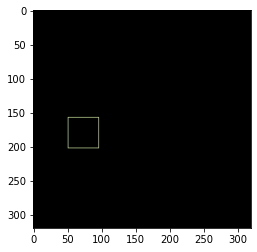

длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 153.65685415267944
длина 71.65685415267944
длина 199.3137083053589
длина 169.65685415267944
длина 185.65685415267944
длина 172.97056198120117
длина 180.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 155.3137083053589
длина 197.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 175.3137083053589
длина 180.0
длина 155.3137083053589
длина 197.65685415267944
длина 169.65685415267944
длина 185.65685415267944
длина 175.3137083053589
длина 180.0
itogo 3


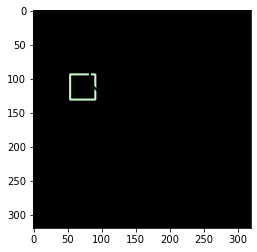

длина 67.65685415267944
длина 19.656854152679443
длина 29.656854152679443
длина 67.65685415267944
длина 5.656854152679443
длина 47.65685415267944
длина 297.11269783973694
длина 295.3553384542465
длина 55.55634891986847
длина 230.62741661071777
длина 51.071067690849304
длина 228.1421353816986
длина 48.485281229019165
длина 224.97056245803833
длина 45.65685415267944
длина 223.55634891986847
длина 42.24264049530029
длина 218.72792148590088
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 67.65685415267944
длина 19.656854152679443
длина 29.656854152679443
длина 67.65685415267944
длина 5.656854152679443
длина 47.65685415267944
длина 297.11269783973694
длина 130.62741661071777
длина 164.1421353816986
длина 56.72792172431946
длина 233.79898953437805
длина 51.656854033470154
длина 228.14213502407074
длина 51.071067690849304
длина 228.1421353816986
длина 48.485281229019165
длина 224.97056245803833
длина 45.65685415267944
длина 223.5563489

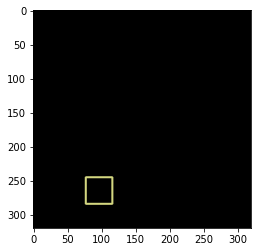

длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 175.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 143.3137083053589
длина 161.65685415267944
длина 143.3137083053589
длина 161.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 148.97056198120117
длина 156.0
длина 151.3137083053589
длина 153.65685415267944
длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 175.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 143.3137083053589
длина 161.65685415267944
длина 143.3137083053589
длина 161.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 148.97056198120117
длина 156.0
длина 151.3137083053589
длина 153.65685415267944
длина 71.65685415267944
длина 129.65685415267944

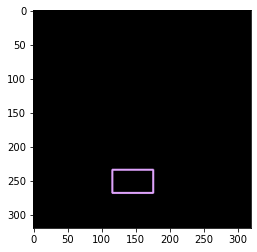

длина 113.65685415267944
длина 161.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 113.65685415267944
длина 207.3137083053589
длина 167.3137083053589
длина 201.65685415267944
длина 169.65685415267944
длина 199.3137083053589
длина 172.97056198120117
длина 193.65685415267944
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 180.97056245803833
длина 188.0
длина 183.3137083053589
длина 185.65685415267944
длина 113.65685415267944
длина 161.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 113.65685415267944
длина 207.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 172.97056198120117
длина 196.0
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 183.3137083053589
длина 188.0
длина 113.65685415267944
длина 161.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 113.65685415267944
длина 207.3137083053589
длина 1

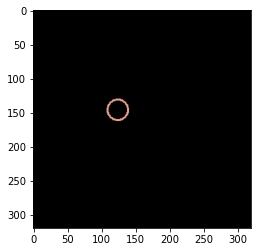

длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152679443
длина 120.56854152679443
длина 85.25483322143555
длина 114.91168642044067
длина 87.5979790687561
длина 112.56854057312012
длина 90.91168689727783
длина 106.91168880462646
длина 93.25483322143555
длина 106.91168642044067
длина 93.25483322143555
длина 106.91168737411499
длина 95.5979790687561
длина 104.56854104995728
длина 98.91168689727783
длина 101.25483226776123
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152679443
длина 120.56854152679443
длина 85.25483322143555
длина 112.56854057312012
длина 90.91168689727783
длина 109.25483226776123
длина 93.25483322143555
длина 106.91168642044067
длина 93.25483226776123
длина 104.56854152679443
длина 98.91168785095215
длина 98.91168880462646
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152

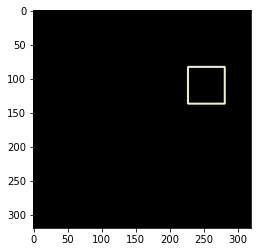

длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 195.3137083053589
длина 229.65685415267944
длина 197.65685415267944
длина 227.3137083053589
длина 200.97056198120117
длина 221.65685415267944
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 205.65685415267944
длина 219.3137083053589
длина 211.3137083053589
длина 216.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 101.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 235.3137083053589
длина 195.3137083053589
длина 229.65685415267944
длина 197.65685415267944
длина 227.3137083053589
длина 200.97056198120117
длина 224.0
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 221.65685415267944
длина 205.65685415267944
длина 219.31

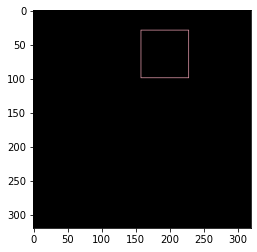

длина 255.3137083053589
длина 297.65685415267944
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 275.3137083053589
длина 280.0
длина 256.97056245803833
длина 296.0
длина 269.65685415267944
длина 285.65685415267944
длина 275.3137083053589
длина 280.0
длина 256.97056245803833
длина 296.0
длина 269.65685415267944
длина 285.65685415267944
длина 272.9705619812012
длина 280.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 7


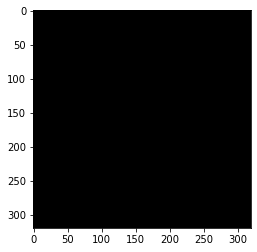

itogo 7
train_data/68.png


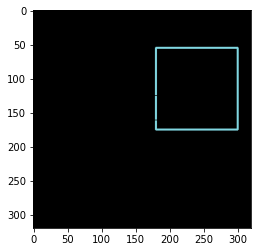

длина 233.65685415267944
длина 21.656854152679443
длина 65.65685415267944
длина 453.65685415267944
длина 233.65685415267944
длина 133.65685415267944
длина 233.65685415267944
длина 499.3137083053589
длина 463.3137083053589
длина 492.97056245803833
длина 467.3137083053589
длина 485.65685415267944
длина 69.65685415267944
длина 878.6274166107178
длина 64.0
длина 875.3137083053589
длина 233.65685415267944
длина 21.656854152679443
длина 65.65685415267944
длина 453.65685415267944
длина 233.65685415267944
длина 133.65685415267944
длина 233.65685415267944
длина 499.3137083053589
длина 461.65685415267944
длина 491.3137083053589
длина 463.3137083053589
длина 492.97056245803833
длина 467.3137083053589
длина 485.65685415267944
длина 468.97056245803833
длина 487.3137083053589
длина 69.65685415267944
длина 878.6274166107178
длина 64.0
длина 872.9705619812012
длина 60.0
длина 868.9705624580383
длина 233.65685415267944
длина 21.656854152679443
длина 63.65685415267944
длина 453.65685415267944
длина 233.

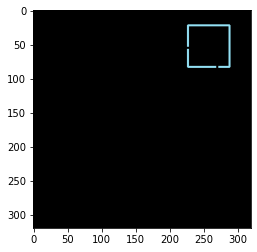

длина 25.656854152679443
длина 75.65685415267944
длина 45.65685415267944
длина 220.97056245803833
длина 115.65685415267944
длина 55.65685415267944
длина 115.65685415267944
длина 266.6274166107178
длина 141.89949476718903
длина 342.3847759962082
длина 135.65685403347015
длина 334.97056210041046
длина 134.48528122901917
длина 336.1421353816986
длина 128.24264061450958
длина 328.72792184352875
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 25.656854152679443
длина 75.65685415267944
длина 45.65685415267944
длина 220.97056245803833
длина 115.65685415267944
длина 55.65685415267944
длина 115.65685415267944
длина 266.6274166107178
длина 141.89949476718903
длина 342.3847759962082
длина 139.55634891986847
длина 340.04163014888763
длина 135.65685403347015
длина 334.97056210041046
длина 136.24264061450958
длина 336.72792184352875
длина 133.89949476718903
длина 334.3847759962082
длина 128.24264061450958
длина 328.72792184352875
длина 128.82

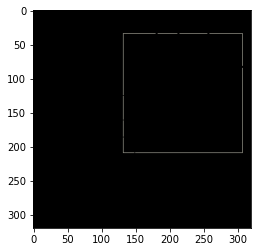

длина 680.2842707633972
длина 719.3137083053589
длина 190.48528122901917
длина 81.65685415267944
длина 57.65685415267944
длина 1046.7695519924164
длина 70.82842707633972
длина 42.0
длина 64.0
длина 556.8284270763397
длина 184.82842707633972
длина 76.0
длина 52.0
длина 268.8284270763397
длина 677.798989534378
длина 725.1126978397369
длина 190.48528122901917
длина 81.65685415267944
длина 57.65685415267944
длина 1046.7695519924164
длина 70.82842707633972
длина 42.0
длина 64.0
длина 556.8284270763397
длина 184.82842707633972
длина 76.0
длина 52.0
длина 268.8284270763397
длина 299.65685415267944
длина 17.656854152679443
длина 29.656854152679443
длина 35.65685415267944
длина 57.65685415267944
длина 233.65685415267944
длина 79.65685415267944
длина 165.65685415267944
длина 686.911687374115
длина 81.65685415267944
длина 69.65685415267944
длина 45.65685415267944
длина 79.65685415267944
длина 732.5685415267944
длина 190.48528122901917
длина 81.65685415267944
длина 57.65685415267944
длина 1046.769

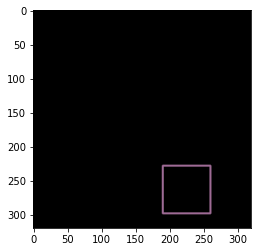

длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.65685415267944
длина 291.3137083053589
длина 264.9705619812012
длина 285.65685415267944
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 275.3137083053589
длина 277.65685415267944
длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.65685415267944
длина 291.3137083053589
длина 267.3137083053589
длина 285.65685415267944
длина 272.9705619812012
длина 280.0
длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.65685415267944
длина 291.3137083053589
длина 264.9705619812012
длина 285.65685415267944
длина 267.3137083053589
длина 285.65685415267944
длина 272.97056245803833
дл

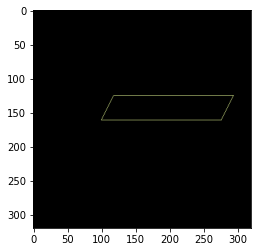

длина 408.911687374115
длина 452.911687374115
длина 425.49747383594513
длина 443.7401144504547
длина 431.7401143312454
длина 438.911687374115
длина 0.0
длина 408.08326029777527
длина 453.7401144504547
длина 424.9116872549057
длина 443.7401144504547
длина 430.56854140758514
длина 438.911687374115
длина 0.0
длина 3.414213538169861
длина 335.65685415267944
длина 407.25483322143555
длина 335.65685415267944
длина 454.56854152679443
длина 427.49747383594513
длина 440.56854152679443
itogo 4


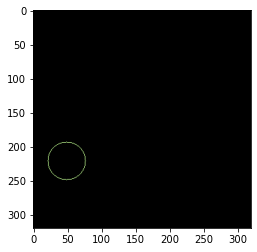

длина 162.5096664428711
длина 202.5096664428711
длина 175.1959581375122
длина 186.50966548919678
длина 77.11269783973694
длина 77.11269783973694
длина 77.11269783973694
длина 77.11269783973694
длина 162.5096664428711
длина 202.5096664428711
длина 175.1959581375122
длина 189.82337474822998
длина 178.50966548919678
длина 186.5096664428711
длина 56.97056245803833
длина 56.97056245803833
длина 56.97056245803833
длина 56.97056245803833
длина 162.5096664428711
длина 202.5096664428711
длина 178.5096664428711
длина 186.50966548919678
itogo 4


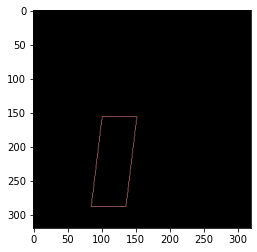

длина 353.7401144504547
длина 396.08326029777527
длина 368.911687374115
длина 384.911687374115
длина 372.2253952026367
длина 379.25483322143555
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 353.7401144504547
длина 396.08326029777527
длина 368.911687374115
длина 382.56854152679443
длина 353.7401144504547
длина 396.08326029777527
длина 368.911687374115
длина 382.56854152679443
itogo 4


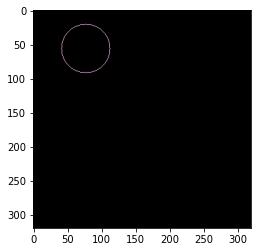

длина 214.79393672943115
длина 254.79393768310547
длина 227.48022937774658
длина 242.10764503479004
длина 233.13708209991455
длина 236.45079231262207
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
длина 214.79393672943115
длина 254.79393768310547
длина 227.4802303314209
длина 238.7939395904541
длина 78.62741661071777
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 78.62741661071777
длина 78.62741661071777
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 78.62741661071777
длина 214.79393672943115
длина 254.79393768310547
длина 227.48022937774658
длина 242.10764503479004
длина 233.13708209991455
длина 236.45079231262207
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 0.0
длина 0.0
длина 0.0
дл

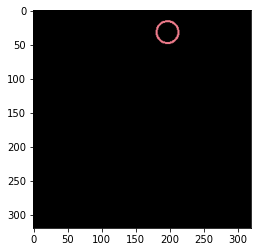

длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 90.91168737411499
длина 120.56854057312012
длина 93.25483298301697
длина 118.22539710998535
длина 96.56854152679443
длина 114.91168785095215
длина 98.91168737411499
длина 112.56854057312012
длина 98.91168737411499
длина 112.56854057312012
длина 101.25483298301697
длина 110.22539710998535
длина 104.56854152679443
длина 106.91168785095215
длина 8.0
длина 2.0
длина 2.0
длина 0.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.0
длина 2.0
длина 8.0
длина 8.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 0.0
длина 2.0
длина 2.0
длина 8.0
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 84.6690468788147
длина 11.656854152679443
длина 126.22539710998535
длина 93.25483298301697
длина 118.22539710998535
длина 98.9116872549057
длина 112.56854057312012
дл

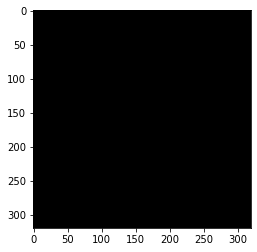

itogo 4
train_data/69.png


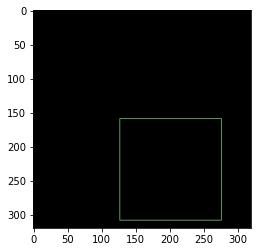

длина 572.9705624580383
длина 612.0
длина 585.6568541526794
длина 599.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 279.65685415267944
длина 279.65685415267944
длина 279.65685415267944
длина 569.6568541526794
длина 279.65685415267944
длина 615.3137083053589
длина 583.3137083053589
длина 601.6568541526794
длина 585.6568541526794
длина 599.3137083053589
длина 591.3137083053589
длина 596.0
длина 572.9705624580383
длина 612.0
длина 585.6568541526794
длина 599.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


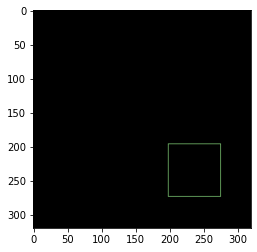

длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 281.65685415267944
длина 135.65685415267944
длина 327.3137083053589
длина 297.65685415267944
длина 313.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 135.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 281.65685415267944
длина 135.65685415267944
длина 327.3137083053589
длина 297.65685415267944
длина 313.65685415267944
длина 297.65685415267944
длина 311.3137083053589
длина 303.3137083053589
длина 308.0
длина 283.3137083053589
длина 325.65685415267944
длина 297.65685415267944
длина 311.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


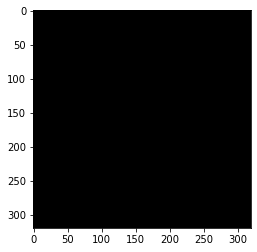

itogo 2
train_data/70.png


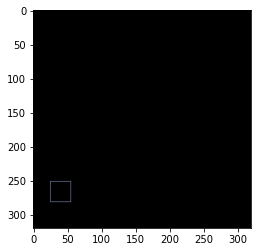

длина 41.65685415267944
длина 41.65685415267944
длина 45.65685415267944
длина 93.65685415267944
длина 45.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 123.31370830535889
длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 123.31370830535889
длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
itogo 1


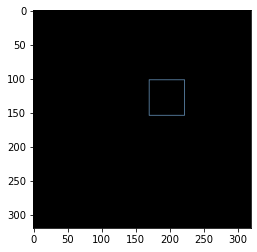

длина 183.3137083053589
длина 225.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 184.97056245803833
длина 224.0
длина 197.65685415267944
длина 213.65685415267944
длина 203.3137083053589
длина 208.0
длина 183.3137083053589
длина 225.65685415267944
длина 197.65685415267944
длина 213.65685415267944
длина 200.97056198120117
длина 214.62741661071777
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


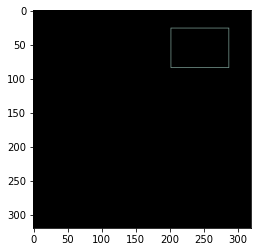

длина 262.97056245803833
длина 302.0
длина 275.65685415267944
длина 289.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 151.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 259.65685415267944
длина 151.65685415267944
длина 305.3137083053589
длина 275.65685415267944
длина 291.65685415267944
длина 281.3137083053589
длина 286.0
длина 261.3137083053589
длина 303.65685415267944
длина 275.65685415267944
длина 291.65685415267944
длина 281.3137083053589
длина 286.0
itogo 2


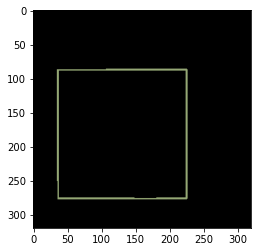

длина 83.65685415267944
длина 219.65685415267944
длина 730.4852812290192
длина 371.65685415267944
длина 321.65685415267944
длина 231.65685415267944
длина 774.1421353816986
длина 738.4852812290192
длина 767.3137083053589
длина 741.7989890575409
длина 761.6568541526794
длина 744.1421353816986
длина 760.4852812290192
длина 226.82842707633972
длина 328.8284270763397
длина 702.4852812290192
длина 2.0
длина 10.242640614509583
длина 2.0
длина 10.242640614509583
длина 83.65685415267944
длина 219.65685415267944
длина 730.4852812290192
длина 371.65685415267944
длина 321.65685415267944
длина 231.65685415267944
длина 774.1421353816986
длина 738.4852812290192
длина 767.3137083053589
длина 738.4852812290192
длина 766.1421353816986
длина 744.1421353816986
длина 761.6568541526794
длина 746.4852812290192
длина 759.3137083053589
длина 223.41421353816986
длина 325.41421353816986
длина 698.4852809906006
длина 83.65685415267944
длина 219.65685415267944
длина 730.4852812290192
длина 371.65685415267944
длина

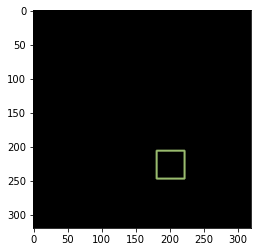

длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 148.97056198120117
длина 169.65685415267944
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 161.65685415267944
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 156.97056245803833
длина 164.0
длина 159.3137083053589
длина 161.65685415267944
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.31

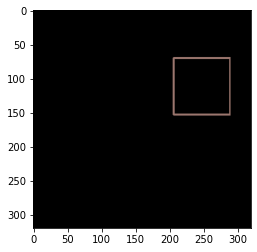

длина 159.65685415267944
длина 305.65685415267944
длина 159.65685415267944
длина 159.65685415267944
длина 349.3137083053589
длина 313.65685415267944
длина 342.48528122901917
длина 316.9705619812012
длина 336.8284270763397
длина 319.3137083053589
длина 335.65685415267944
длина 496.1421353816986
длина 490.48528122901917
длина 159.65685415267944
длина 305.65685415267944
длина 159.65685415267944
длина 159.65685415267944
длина 349.3137083053589
длина 313.65685415267944
длина 341.3137083053589
длина 319.3137083053589
длина 336.8284270763397
длина 497.79898953437805
длина 0.0
длина 6.2426406145095825
длина 0.0
длина 6.2426406145095825
длина 159.65685415267944
длина 305.65685415267944
длина 159.65685415267944
длина 159.65685415267944
длина 349.3137083053589
длина 313.65685415267944
длина 341.3137083053589
длина 319.3137083053589
длина 335.65685415267944
длина 496.14213514328003
itogo 5


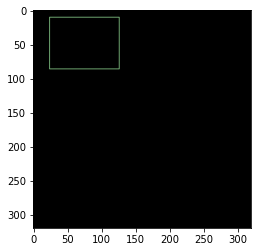

длина 331.3137083053589
длина 373.65685415267944
длина 345.65685415267944
длина 361.65685415267944
длина 351.3137083053589
длина 356.0
длина 331.3137083053589
длина 373.65685415267944
длина 343.3137083053589
длина 361.65685415267944
длина 345.65685415267944
длина 359.3137083053589
длина 351.3137083053589
длина 356.0
длина 331.3137083053589
длина 373.65685415267944
длина 345.65685415267944
длина 361.65685415267944
длина 351.3137083053589
длина 356.0
itogo 5


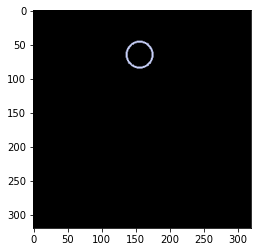

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длина 147.88224959373474
длина 111.39696907997131
длина 139.88224983215332
длина 112.56854200363159
длина 137.53910446166992
длина 118.22539591789246
длина 133.63960933685303
длина 119.39696860313416
длина 131.882248878479
длина 120.56854152679443
длина 131.29646372795105
длина 65.94112455844879
длина 174.02438580989838
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 104.56854128837585
длина 13.656854152679443
длина 147.88224947452545
длина 111.39696907997131
длина 139.88224983215332
длина 112.56854128837585
длина 137.53910541534424
длина 118.22539591789246
длина 133.63960933685303
длина 118.22539567947388
длина 134.2253954410553
длина 119.39696907997131
длина 131.88224959373474
длина 125.05382299423218
длина 126.22539615631104
длина 8.0
длина 0.0
длина 0.0
длина 0.0
длина 8.0
длина 8.0
длина 0.0
длина 0.0
длина 0.0
длина 8.0
длин

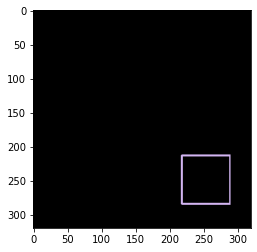

длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 301.3137083053589
длина 265.65685415267944
длина 294.48528122901917
длина 265.65685415267944
длина 293.3137083053589
длина 271.3137083053589
длина 288.8284270763397
длина 271.3137083053589
длина 287.65685415267944
длина 273.65685415267944
длина 286.48528122901917
длина 421.3137080669403
длина 414.48528122901917
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 301.3137083053589
длина 265.65685415267944
длина 294.48528122901917
длина 265.65685415267944
длина 293.3137083053589
длина 271.3137083053589
длина 288.8284270763397
длина 273.65685415267944
длина 286.48528122901917
длина 424.14213514328003
длина 414.48528122901917
длина 135.65685415267944
длина 257.65685415267944
длина 135.65685415267944
длина 135.65685415267944
длина 301.3137083053589
длина 263.3137083053589
длина 295.65685415267944
длина 265.65685415267944
длина 293.31

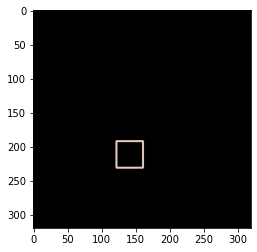

длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 175.3137083053589
длина 135.3137083053589
длина 169.65685415267944
длина 137.65685415267944
длина 167.3137083053589
длина 140.97056198120117
длина 161.65685415267944
длина 143.3137083053589
длина 161.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 145.65685415267944
длина 159.3137083053589
длина 151.3137083053589
длина 156.0
длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 71.65685415267944
длина 175.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 137.65685415267944
длина 167.3137083053589
длина 143.3137083053589
длина 161.65685415267944
длина 143.3137083053589
длина 161.65685415267944
длина 145.65685415267944
длина 159.3137083053589
длина 148.97056198120117
длина 156.0
длина 71.65685415267944
длина 129.65685415267944
длина 71.65685415267944
длина 71.65685415267944


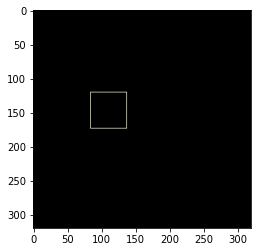

длина 187.3137083053589
длина 229.65685415267944
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
длина 188.97056245803833
длина 228.0
длина 199.3137083053589
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 187.3137083053589
длина 229.65685415267944
длина 201.65685415267944
длина 217.65685415267944
длина 201.65685415267944
длина 215.3137083053589
длина 207.3137083053589
длина 212.0
itogo 8


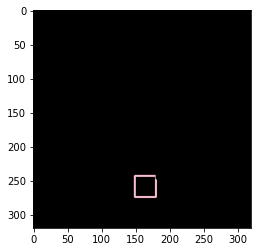

длина 55.65685415267944
длина 45.65685415267944
длина 97.0710676908493
длина 55.65685415267944
длина 53.65685415267944
длина 142.72792184352875
длина 103.31370830535889
длина 136.48528122901917
длина 105.65685415267944
длина 134.72792184352875
длина 109.5563485622406
длина 130.82842707633972
длина 236.97056245803833
длина 235.3137083053589
длина 230.1421353816986
длина 226.72792148590088
длина 222.72792184352875
длина 55.65685415267944
длина 45.65685415267944
длина 97.0710676908493
длина 55.65685415267944
длина 53.65685415267944
длина 142.72792184352875
длина 105.65685415267944
длина 134.72792184352875
длина 106.48528122901917
длина 134.97056245803833
длина 236.97056245803833
длина 233.55634891986847
длина 228.1421353816986
длина 224.72792184352875
длина 55.65685415267944
длина 45.65685415267944
длина 97.0710676908493
длина 55.65685415267944
длина 53.65685415267944
длина 142.72792184352875
длина 105.65685415267944
длина 134.72792184352875
длина 105.65685415267944
длина 134.142135381698

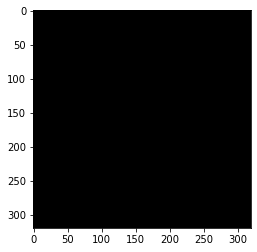

itogo 9
train_data/71.png


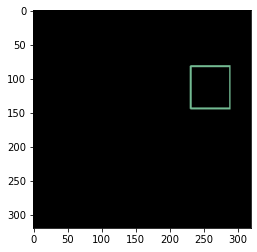

длина 109.65685415267944
длина 213.65685415267944
длина 117.65685415267944
длина 109.65685415267944
длина 257.3137083053589
длина 221.65685415267944
длина 249.3137083053589
длина 227.3137083053589
длина 244.82842707633972
длина 354.1421353816986
длина 109.65685415267944
длина 213.65685415267944
длина 117.65685415267944
длина 109.65685415267944
длина 257.3137083053589
длина 221.65685415267944
длина 250.48528122901917
длина 221.65685415267944
длина 249.3137083053589
длина 227.3137083053589
длина 244.82842707633972
длина 229.65685415267944
длина 242.48528122901917
длина 354.1421353816986
длина 348.48528122901917
длина 109.65685415267944
длина 213.65685415267944
длина 117.65685415267944
длина 109.65685415267944
длина 257.3137083053589
длина 221.65685415267944
длина 250.48528122901917
длина 227.3137083053589
длина 244.82842707633972
длина 229.65685415267944
длина 243.65685415267944
длина 354.14213514328003
длина 0.0
длина 6.2426406145095825
длина 0.0
длина 6.2426406145095825
itogo 0


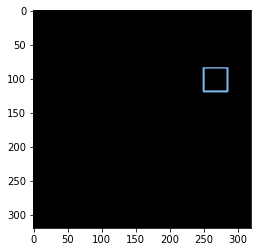

длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 157.3137083053589
длина 121.65685415267944
длина 150.48528122901917
длина 127.31370830535889
длина 144.82842707633972
длина 129.65685415267944
длина 142.48528122901917
длина 206.48528122901917
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 157.3137083053589
длина 121.65685415267944
длина 150.48528122901917
длина 121.65685415267944
длина 149.3137083053589
длина 127.31370830535889
длина 144.82842707633972
длина 129.65685415267944
длина 142.48528122901917
длина 208.14213514328003
длина 202.48528122901917
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 157.3137083053589
длина 119.31370830535889
длина 151.65685415267944
длина 121.65685415267944
длина 149.3137083053589
длина 124.97056198120117
длина 144.82842707633972
длина 127.31370830535889
длина 144.82842707633972
длина 129.6568

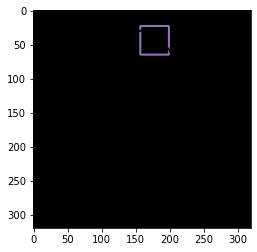

длина 77.65685415267944
длина 59.65685415267944
длина 55.65685415267944
длина 77.65685415267944
длина 335.2132030725479
длина 165.55634891986847
длина 164.1421353816986
длина 158.72792160511017
длина 156.72792160511017
длина 156.72792184352875
длина 156.1421353816986
длина 149.0710676908493
длина 148.48528122901917
длина 145.0710676908493
длина 142.48528122901917
длина 77.65685415267944
длина 59.65685415267944
длина 55.65685415267944
длина 77.65685415267944
длина 335.2132030725479
длина 163.79898953437805
длина 162.3847759962082
длина 157.89949476718903
длина 157.89949476718903
длина 151.3137083053589
длина 152.1421353816986
длина 3.414213538169861
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 77.65685415267944
длина 59.65685415267944
длина 55.65685415267944
длина 77.65685415267944
длина 336.87005722522736
длина 166.1421353816986
длина 164.1421353816986
длина 161.55634891986847
длина 161.55634891986847
длина 159.3137083053589
длина 157.89949476718903


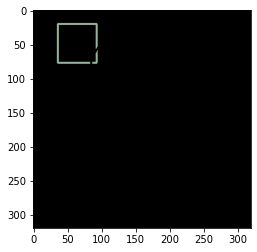

длина 5.656854152679443
длина 87.65685415267944
длина 23.656854152679443
длина 61.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 455.2132030725479
длина 53.31370830535889
длина 396.3847759962082
длина 47.071067571640015
длина 388.3847756385803
длина 44.485281229019165
длина 388.3847759962082
длина 36.24264061450958
длина 380.72792184352875
длина 30.242640614509583
длина 374.72792184352875
длина 5.656854152679443
длина 87.65685415267944
длина 23.656854152679443
длина 61.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 455.2132030725479
длина 53.899494767189026
длина 396.3847759962082
длина 49.31370830535889
длина 393.2132030725479
длина 45.65685415267944
длина 390.1421353816986
длина 42.485281229019165
длина 386.97056245803833
длина 36.24264049530029
длина 380.7279214859009
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 5.656854152679443
длина 87.65685415267944
длина 23.6568541526794

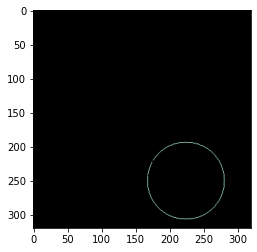

длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 355.2619720697403
длина 7.656854152679443
длина 7.656854152679443
длина 394.6761864423752
длина 740.9675999879837
длина 127.5979790687561
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 75.79898953437805
длина 36.97056245803833
длина 127.5979790687561
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 127.5979790687561
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 355.2619720697403
длина 5.656854152679443
длина 5.656854152679443
длина 394.6761864423752
длина 747.3523721694946
длина 755.1686066389084
длина 35.65685415267944
длина 35.65685415267944
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 35.65685415267944
длина 35.65685415267944
длина 10.0
длина 35.65685415267944
длина 14.828427076339722
длина 4.0
длина 4.0


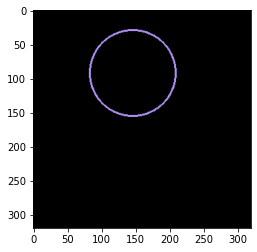

длина 25.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 395.6467480659485
длина 7.656854152679443
длина 7.656854152679443
длина 25.656854152679443
длина 438.9604573249817
длина 405.98989486694336
длина 430.9604573249817
длина 405.989896774292
длина 430.9604561328888
длина 411.64674854278564
длина 425.30360198020935
длина 411.64674949645996
длина 422.9604561328888
длина 188.85281193256378
длина 3.414213538169861
длина 3.414213538169861
длина 188.85281205177307
длина 188.85281205177307
длина 3.414213538169861
длина 3.414213538169861
длина 188.85281193256378
длина 25.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 25.656854152679443
длина 25.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 395.6467480659485
длина 7.656854152679443
дл

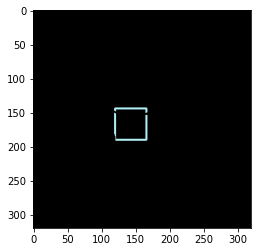

длина 83.65685415267944
длина 65.65685415267944
длина 55.65685415267944
длина 157.89949476718903
длина 5.656854152679443
длина 85.65685415267944
длина 203.55634891986847
длина 364.7695519924164
длина 244.3847759962082
длина 112.72792184352875
длина 165.65685415267944
длина 70.24264061450958
длина 109.89949476718903
длина 161.89949476718903
длина 64.82842707633972
длина 106.72792184352875
длина 156.2426404953003
длина 58.0
длина 103.07106757164001
длина 6.2426406145095825
длина 6.2426406145095825
длина 4.828427076339722
длина 83.65685415267944
длина 65.65685415267944
длина 55.65685415267944
длина 157.89949476718903
длина 5.656854152679443
длина 85.65685415267944
длина 203.55634891986847
длина 363.94112479686737
длина 244.62741661071777
длина 114.14213538169861
длина 241.89949464797974
длина 112.48528110980988
длина 165.65685415267944
длина 70.24264061450958
длина 109.89949476718903
длина 163.0710676908493
длина 65.41421353816986
длина 109.0710676908493
длина 158.48528122901917
длина 61.

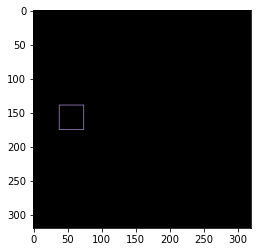

длина 119.31370830535889
длина 161.65685415267944
длина 133.65685415267944
длина 149.65685415267944
длина 139.3137083053589
длина 144.0
длина 119.31370830535889
длина 161.65685415267944
длина 133.65685415267944
длина 149.65685415267944
длина 139.3137083053589
длина 144.0
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 149.65685415267944
длина 133.65685415267944
длина 147.3137083053589
длина 139.3137083053589
длина 144.0
itogo 5


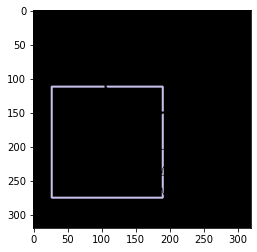

длина 319.65685415267944
длина 7.656854152679443
длина 31.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 45.65685415267944
длина 97.65685415267944
длина 65.65685415267944
длина 628.9705624580383
длина 319.65685415267944
длина 157.65685415267944
длина 147.65685415267944
длина 672.9705624580383
длина 243.3137083053589
длина 1057.4558436870575
длина 240.72792184352875
длина 1059.012192606926
длина 237.65685415267944
длина 1053.4558436870575
длина 62.485281229019165
длина 162.48528122901917
длина 235.65685415267944
длина 818.1421353816986
длина 35.65685415267944
длина 2.0
длина 49.65685415267944
длина 99.65685415267944
длина 231.89949476718903
длина 810.3847759962082
длина 32.0
длина 46.0
длина 96.0
длина 228.82842707633972
длина 808.4852812290192
длина 319.65685415267944
длина 7.656854152679443
длина 31.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 43.65685415267944
длина 5.656854152679443
длина 95.65685415267944
длина 65.65685415267944
длина

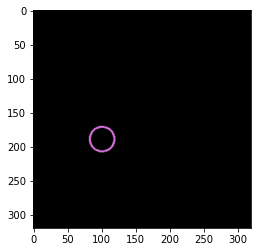

длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.882248878479
длина 104.56854176521301
длина 134.22539520263672
длина 106.91168713569641
длина 131.882248878479
длина 111.39696884155273
длина 126.22539710998535
длина 112.56854176521301
длина 126.22539615631104
длина 112.56854057312012
длина 126.22539520263672
длина 118.2253954410553
длина 120.56854128837585
длина 10.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 10.0
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 98.91168737411499
длина 11.656854152679443
длина 139.882248878479
длина 106.91168713569641
длина 131.882248878479
длина 112.56854176521301
длина 126.22539615631104
длина 118.2253954410553
длина 120.5685405731201

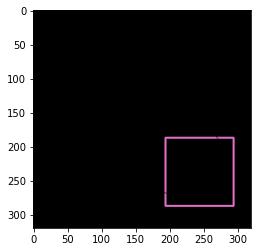

длина 193.65685415267944
длина 29.656854152679443
длина 5.656854152679443
длина 373.65685415267944
длина 193.65685415267944
длина 153.65685415267944
длина 39.65685415267944
длина 5.656854152679443
длина 143.65685415267944
длина 419.3137083053589
длина 379.3137083053589
длина 413.65685415267944
длина 383.3137083053589
длина 412.97056245803833
длина 384.9705619812012
длина 405.65685415267944
длина 387.3137083053589
длина 405.65685415267944
длина 391.3137083053589
длина 404.97056245803833
длина 472.72792184352875
длина 304.2426406145096
длина 470.48528122901917
длина 300.8284270763397
длина 193.65685415267944
длина 29.656854152679443
длина 5.656854152679443
длина 373.65685415267944
длина 193.65685415267944
длина 153.65685415267944
длина 39.65685415267944
длина 5.656854152679443
длина 143.65685415267944
длина 419.3137083053589
длина 383.3137083053589
длина 412.97056245803833
длина 387.3137083053589
длина 405.65685415267944
длина 472.7279214859009
длина 304.2426404953003
длина 193.656854152

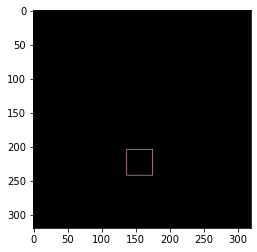

длина 127.31370830535889
длина 169.65685415267944
длина 139.3137083053589
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 147.3137083053589
длина 152.0
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 125.65685415267944
длина 57.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 157.65685415267944
длина 147.3137083053589
длина 152.0
длина 128.97056245803833
длина 165.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 144.97056198120117
длина 152.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 8


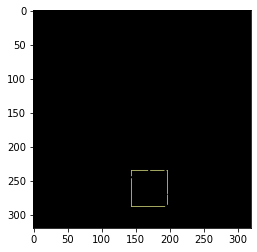

длина 193.2132030725479
длина 230.97056245803833
длина 183.89949476718903
длина 107.0710676908493
длина 45.65685415267944
длина 67.89949476718903
длина 179.89949476718903
длина 103.89949476718903
длина 41.65685415267944
длина 63.899494767189026
длина 24.0
длина 174.82842707633972
длина 66.0
длина 36.0
длина 58.82842707633972
длина 192.3847759962082
длина 228.48528122901917
длина 183.89949476718903
длина 107.0710676908493
длина 45.65685415267944
длина 67.89949476718903
длина 179.89949476718903
длина 103.89949476718903
длина 41.65685415267944
длина 63.899494767189026
длина 24.0
длина 174.82842707633972
длина 66.82842707633972
длина 36.0
длина 58.82842707633972
длина 2.8284270763397217
длина 2.8284270763397217
длина 192.3847759962082
длина 230.1421353816986
длина 180.48528122901917
длина 104.48528122901917
длина 41.65685415267944
длина 64.48528122901917
длина 20.0
длина 170.82842707633972
длина 62.0
длина 32.0
длина 54.82842707633972
itogo 9


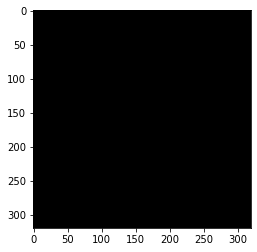

itogo 9
train_data/72.png


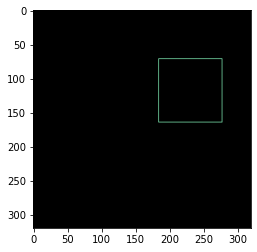

длина 348.97056245803833
длина 388.0
длина 361.65685415267944
длина 375.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 167.65685415267944
длина 167.65685415267944
длина 167.65685415267944
длина 345.65685415267944
длина 167.65685415267944
длина 391.3137083053589
длина 359.3137083053589
длина 377.65685415267944
длина 361.65685415267944
длина 375.3137083053589
длина 367.3137083053589
длина 372.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 167.65685415267944
длина 167.65685415267944
длина 167.65685415267944
длина 345.65685415267944
длина 167.65685415267944
длина 391.3137083053589
длина 361.65685415267944
длина 377.65685415267944
длина 364.9705619812012
длина 372.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


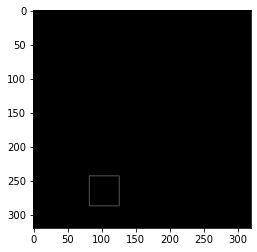

длина 69.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 149.65685415267944
длина 69.65685415267944
длина 195.3137083053589
длина 165.65685415267944
длина 181.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 151.3137083053589
длина 193.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 151.3137083053589
длина 193.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 2


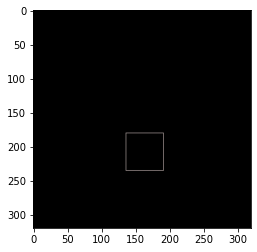

длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 196.97056245803833
длина 236.0
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
itogo 3


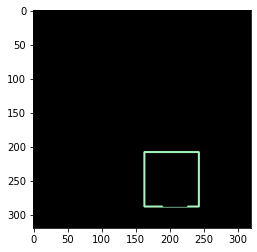

длина 57.65685415267944
длина 27.656854152679443
длина 47.65685415267944
длина 294.48528122901917
длина 153.65685415267944
длина 153.65685415267944
длина 153.65685415267944
длина 340.1421353816986
длина 303.3137083053589
длина 331.3137083053589
длина 304.1421353816986
длина 332.1421353816986
длина 563.798989534378
длина 559.798989534378
длина 556.9705619812012
длина 27.656854152679443
длина 47.65685415267944
длина 295.3137083053589
длина 153.65685415267944
длина 153.65685415267944
длина 153.65685415267944
длина 339.3137083053589
длина 300.97056245803833
длина 333.65685415267944
длина 303.3137083053589
длина 331.3137083053589
длина 306.6274161338806
длина 328.0
длина 566.6274166107178
длина 566.1421353816986
длина 559.798989534378
длина 556.9705619812012
длина 552.9705624580383
длина 27.656854152679443
длина 47.65685415267944
длина 294.48528122901917
длина 153.65685415267944
длина 153.65685415267944
длина 153.65685415267944
длина 339.3137083053589
длина 303.3137083053589
длина 331.31370

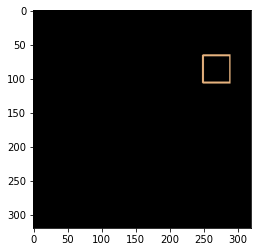

длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 177.3137083053589
длина 139.3137083053589
длина 171.65685415267944
длина 141.65685415267944
длина 169.3137083053589
длина 144.97056198120117
длина 164.82842707633972
длина 147.3137083053589
длина 164.82842707633972
длина 149.65685415267944
длина 162.48528122901917
длина 238.1421353816986
длина 236.48528122901917
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 177.3137083053589
длина 141.65685415267944
длина 170.48528122901917
длина 141.65685415267944
длина 169.3137083053589
длина 147.3137083053589
длина 164.82842707633972
длина 149.65685415267944
длина 162.48528122901917
длина 235.3137080669403
длина 0.0
длина 6.2426406145095825
длина 0.0
длина 6.2426406145095825
длина 73.65685415267944
длина 133.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 177.3137083053589
длина 141.65685415267944
длина 170.48528122901917

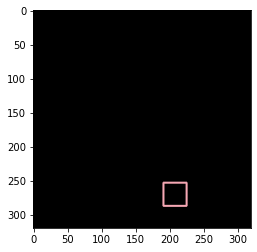

длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 115.31370830535889
длина 149.65685415267944
длина 117.65685415267944
длина 147.3137083053589
длина 120.97056198120117
длина 144.0
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 131.3137083053589
длина 133.65685415267944
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 120.97056198120117
длина 144.0
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267

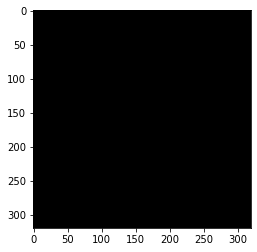

itogo 6
train_data/73.png


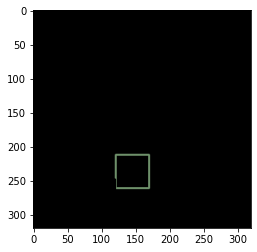

длина 89.65685415267944
длина 11.656854152679443
длина 169.0710676908493
длина 91.65685415267944
длина 63.65685415267944
длина 91.65685415267944
длина 214.72792184352875
длина 177.65685415267944
длина 206.1421353816986
длина 359.55634891986847
длина 354.14213502407074
длина 89.65685415267944
длина 169.0710676908493
длина 91.65685415267944
длина 63.65685415267944
длина 91.65685415267944
длина 214.72792184352875
длина 177.65685415267944
длина 206.72792184352875
длина 183.3137083053589
длина 201.0710676908493
длина 361.3137083053589
длина 352.7279214859009
длина 89.65685415267944
длина 11.656854152679443
длина 169.0710676908493
длина 91.65685415267944
длина 63.65685415267944
длина 91.65685415267944
длина 214.72792184352875
длина 177.65685415267944
длина 206.1421353816986
длина 359.55634891986847
длина 352.7279214859009
itogo 1


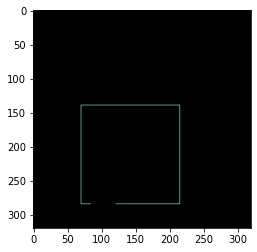

длина 173.65685415267944
длина 13.656854152679443
длина 271.65685415267944
длина 271.65685415267944
длина 271.65685415267944
длина 1096.6274166107178
длина 1080.6274166107178
длина 171.65685415267944
длина 11.656854152679443
длина 271.65685415267944
длина 271.65685415267944
длина 271.65685415267944
длина 1096.6274166107178
длина 1082.9705624580383
длина 1080.6274166107178
длина 1073.313708305359
длина 171.65685415267944
длина 11.656854152679443
длина 271.65685415267944
длина 271.65685415267944
длина 271.65685415267944
длина 1096.6274166107178
длина 1085.313708305359
длина 1074.9705619812012
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


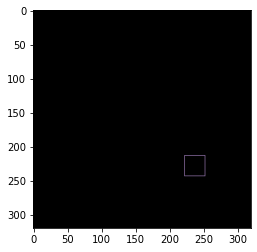

длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 123.31370830535889
длина 95.31370830535889
длина 137.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
itogo 3


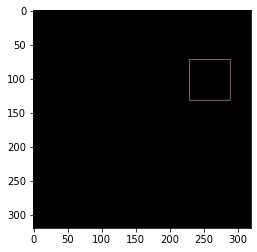

длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 213.65685415267944
длина 101.65685415267944
длина 259.3137083053589
длина 229.65685415267944
длина 245.65685415267944
длина 232.97056198120117
длина 240.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 215.3137083053589
длина 257.65685415267944
длина 229.65685415267944
длина 245.65685415267944
длина 235.3137083053589
длина 240.0
длина 101.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 213.65685415267944
длина 101.65685415267944
длина 259.3137083053589
длина 229.65685415267944
длина 245.65685415267944
длина 235.3137083053589
длина 240.0
itogo 4


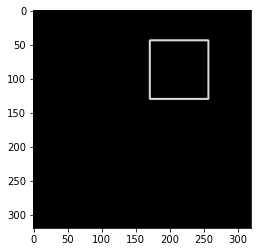

длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 325.65685415267944
длина 355.3137083053589
длина 325.65685415267944
длина 355.3137083053589
длина 331.3137083053589
длина 349.65685415267944
длина 331.3137083053589
длина 349.65685415267944
длина 333.65685415267944
длина 347.3137083053589
длина 336.9705619812012
длина 344.0
длина 339.3137083053589
длина 341.65685415267944
длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 323.3137083053589
длина 357.65685415267944
длина 325.65685415267944
длина 355.3137083053589
длина 328.9705619812012
длина 349.65685415267944
длина 331.3137083053589
длина 349.65685415267944
длина 333.65685415267944
длина 347.3137083053589
длина 336.97056245803833
длина 344.0
длина 339.3137083053589
длина 341.65685415267944
длина 165.65685415267944
длина 317.656854

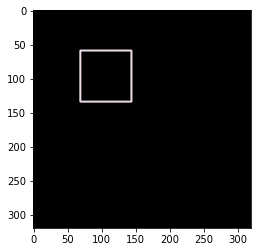

длина 143.65685415267944
длина 273.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 319.3137083053589
длина 279.3137083053589
длина 313.65685415267944
длина 281.65685415267944
длина 311.3137083053589
длина 284.9705619812012
длина 305.65685415267944
длина 287.3137083053589
длина 305.65685415267944
длина 289.65685415267944
длина 303.3137083053589
длина 289.65685415267944
длина 303.3137083053589
длина 292.9705619812012
длина 300.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 143.65685415267944
длина 273.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 143.65685415267944
длина 319.3137083053589
длина 281.65685415267944
длина 311.3137083053589
длина 281.65685415267944
длина 311.3137083053589
длина 287.3137083053589
длина 305.65685415267944
длина 287.3137083053589
длина 305.65685415267944
длина 289.65685415267944
длина 303.3137083053589
длина 292.9705619812012
дли

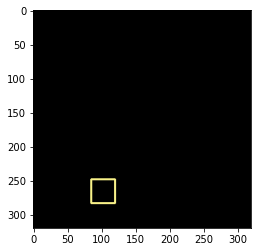

длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 119.31370830535889
длина 153.65685415267944
длина 121.65685415267944
длина 151.3137083053589
длина 124.97056198120117
длина 148.0
длина 127.31370830535889
длина 145.65685415267944
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 132.97056198120117
длина 140.0
длина 135.3137083053589
длина 137.65685415267944
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 119.31370830535889
длина 153.65685415267944
длина 121.65685415267944
длина 151.3137083053589
длина 124.97056198120117
длина 148.0
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 132.97056198120117
длина 140.0
длина 135.3137083

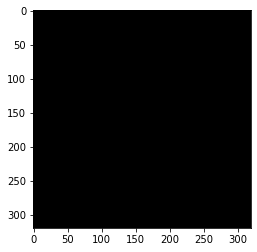

itogo 7
train_data/74.png


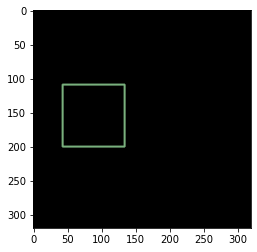

длина 175.65685415267944
длина 337.65685415267944
длина 175.65685415267944
длина 175.65685415267944
длина 175.65685415267944
длина 383.3137083053589
длина 345.65685415267944
длина 375.3137083053589
длина 351.3137083053589
длина 369.65685415267944
длина 353.65685415267944
длина 367.3137083053589
длина 359.3137083053589
длина 361.65685415267944
длина 175.65685415267944
длина 337.65685415267944
длина 175.65685415267944
длина 175.65685415267944
длина 175.65685415267944
длина 383.3137083053589
длина 345.65685415267944
длина 375.3137083053589
длина 345.65685415267944
длина 375.3137083053589
длина 351.3137083053589
длина 369.65685415267944
длина 353.65685415267944
длина 367.3137083053589
длина 356.9705619812012
длина 364.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 175.65685415267944
длина 337.65685415267944
длина 175.65685415267944
длина 175.65685415267944
длина 175.65685415267944
длина 383.3137083053589
длина 345.65685415267944


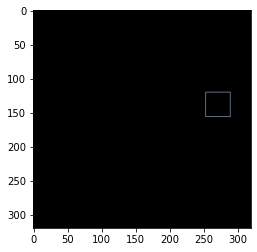

длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 149.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 119.31370830535889
длина 161.65685415267944
длина 133.65685415267944
длина 149.65685415267944
длина 139.3137083053589
длина 144.0
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 133.65685415267944
длина 149.65685415267944
длина 136.97056198120117
длина 144.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


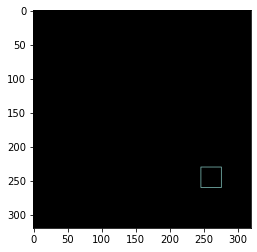

длина 95.31370830535889
длина 137.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
длина 96.97056245803833
длина 136.0
длина 109.65685415267944
длина 125.65685415267944
длина 109.65685415267944
длина 123.31370830535889
длина 115.31370830535889
длина 120.0
длина 95.31370830535889
длина 137.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 112.97056198120117
длина 120.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 3


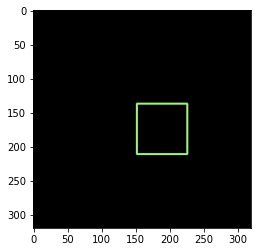

длина 141.65685415267944
длина 269.65685415267944
длина 141.65685415267944
длина 141.65685415267944
длина 141.65685415267944
длина 315.3137083053589
длина 277.65685415267944
длина 307.3137083053589
длина 280.9705619812012
длина 301.65685415267944
длина 283.3137083053589
длина 301.65685415267944
длина 285.65685415267944
длина 299.3137083053589
длина 291.3137083053589
длина 293.65685415267944
длина 141.65685415267944
длина 269.65685415267944
длина 141.65685415267944
длина 141.65685415267944
длина 141.65685415267944
длина 315.3137083053589
длина 275.3137083053589
длина 309.65685415267944
длина 277.65685415267944
длина 307.3137083053589
длина 280.9705619812012
длина 304.0
длина 283.3137083053589
длина 301.65685415267944
длина 285.65685415267944
длина 301.65685415267944
длина 285.65685415267944
длина 299.3137083053589
длина 288.9705619812012
длина 296.0
длина 291.3137083053589
длина 293.65685415267944
длина 141.65685415267944
длина 269.65685415267944
длина 141.65685415267944
длина 141.65685

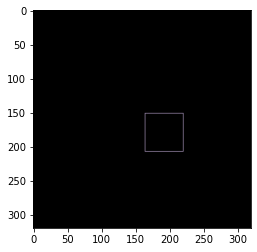

длина 199.3137083053589
длина 241.65685415267944
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 197.65685415267944
длина 93.65685415267944
длина 243.3137083053589
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
длина 199.3137083053589
длина 241.65685415267944
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
itogo 5


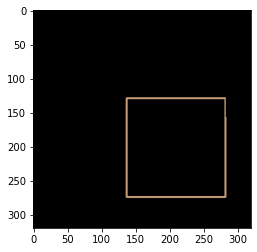

длина 283.65685415267944
длина 229.65685415267944
длина 553.6568541526794
длина 283.65685415267944
длина 283.65685415267944
длина 598.7279218435287
длина 561.6568541526794
длина 591.3137083053589
длина 561.6568541526794
длина 590.7279218435287
длина 567.3137083053589
длина 585.6568541526794
длина 569.6568541526794
длина 585.0710676908493
длина 1103.213203072548
длина 1097.899494767189
длина 283.65685415267944
длина 229.65685415267944
длина 553.6568541526794
длина 283.65685415267944
длина 283.65685415267944
длина 598.7279218435287
длина 561.6568541526794
длина 591.3137083053589
длина 564.9705619812012
длина 585.6568541526794
длина 567.3137083053589
длина 585.0710676908493
длина 1103.213203072548
длина 1096.1421353816986
длина 283.65685415267944
длина 229.65685415267944
длина 553.6568541526794
длина 283.65685415267944
длина 283.65685415267944
длина 598.7279218435287
длина 561.6568541526794
длина 590.7279218435287
длина 567.3137083053589
длина 585.6568541526794
длина 1103.213203072548
дли

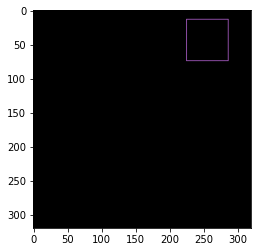

длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 217.65685415267944
длина 103.65685415267944
длина 263.3137083053589
длина 233.65685415267944
длина 249.65685415267944
длина 236.97056198120117
длина 244.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 219.3137083053589
длина 261.65685415267944
длина 233.65685415267944
длина 247.3137083053589
длина 219.3137083053589
длина 261.65685415267944
длина 231.3137083053589
длина 249.65685415267944
длина 233.65685415267944
длина 247.3137083053589
длина 239.3137083053589
длина 244.0
itogo 7


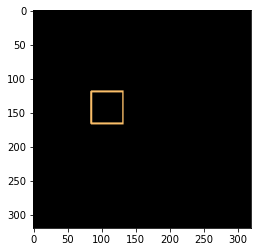

длина 87.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 205.3137083053589
длина 167.3137083053589
длина 199.65685415267944
длина 169.65685415267944
длина 198.48528122901917
длина 172.97056198120117
длина 194.0
длина 175.3137083053589
длина 192.82842707633972
длина 175.3137083053589
длина 191.65685415267944
длина 288.1421353816986
длина 277.3137080669403
длина 277.3137083053589
длина 87.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 205.3137083053589
длина 169.65685415267944
длина 198.48528122901917
длина 169.65685415267944
длина 197.3137083053589
длина 175.3137083053589
длина 192.82842707633972
длина 177.65685415267944
длина 191.65685415267944
длина 280.1421353816986
длина 277.3137083053589
длина 87.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 205.3137083053589
длина 169.65685415267944
длина 197.3137083053589
длина 175.3137083053589
длина 191.65

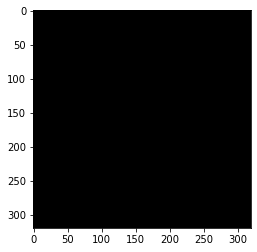

itogo 8
train_data/75.png


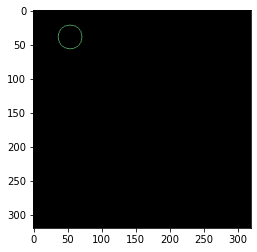

длина 96.56854057312012
длина 136.56854152679443
длина 114.91168737411499
длина 118.22539615631104
длина 96.56854152679443
длина 136.56854152679443
длина 109.25483322143555
длина 123.88224983215332
длина 114.91168737411499
длина 118.22539615631104
длина 96.56854152679443
длина 136.56854152679443
длина 112.56854152679443
длина 120.56854152679443
itogo 0


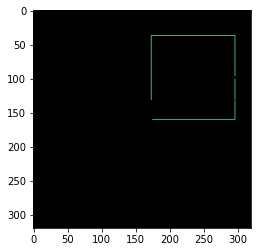

длина 227.65685415267944
длина 39.65685415267944
длина 49.65685415267944
длина 103.65685415267944
длина 175.65685415267944
длина 231.65685415267944
длина 938.5269113779068
длина 295.899494767189
длина 61.65685415267944
длина 550.1421353816986
длина 935.2132030725479
длина 363.899494767189
длина 554.1421353816986
длина 361.55634891986847
длина 550.1421353816986
длина 290.8284270763397
длина 56.0
длина 545.6568541526794
длина 225.65685415267944
длина 37.65685415267944
длина 45.65685415267944
длина 101.65685415267944
длина 171.65685415267944
длина 227.65685415267944
длина 939.3553384542465
длина 362.8284270763397
длина 553.6568541526794
длина 292.2426404953003
длина 58.0
длина 544.4852809906006
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


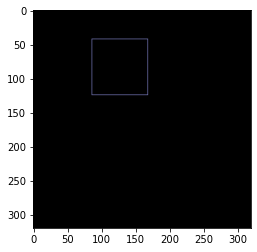

длина 304.97056245803833
длина 344.0
длина 317.65685415267944
длина 331.3137083053589
длина 145.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 301.65685415267944
длина 145.65685415267944
длина 347.3137083053589
длина 317.65685415267944
длина 331.3137083053589
длина 145.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 301.65685415267944
длина 145.65685415267944
длина 347.3137083053589
длина 317.65685415267944
длина 333.65685415267944
длина 320.9705619812012
длина 328.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


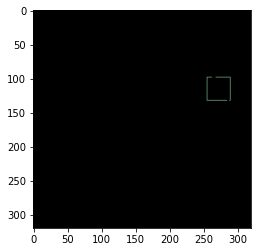

длина 113.55634891986847
длина 152.0
длина 110.48528122901917
длина 138.1421353816986
длина 113.55634891986847
длина 5.656854152679443
длина 154.48528122901917
длина 114.24264061450958
длина 141.65685415267944
длина 107.65685403347015
длина 132.4852809906006
длина 114.38477599620819
длина 5.656854152679443
длина 152.82842707633972
длина 110.48528122901917
длина 138.1421353816986
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 3


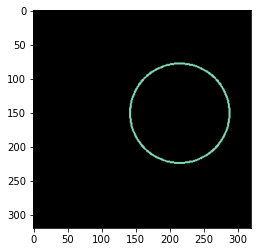

длина 27.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 5.656854152679443
длина 7.656854152679443
длина 7.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 27.656854152679443
длина 27.656854152679443
длина 9.656854152679443
длина 9.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 461.5878748893738
длина 7.656854152679443
длина 5.656854152679443
длина 9.656854152679443
длина 7.656854152679443
длина 27.656854152679443
длина 504.9015808105469
длина 471.93101942539215
длина 498.0731551647186
длина 477.0020867586136
длина 491.24472737312317
длина 477.58787393569946
длина 491.83051443099976
длина 92.97056245803833
длина 6.828427076339722
длина 60.183765292167664
длина 91.29646301269531
длина 54.183765292167664
длина 138.42640614509583
длина 138.42640614509583
длина 24.3847758769989
длина 24.3847758769989
длина 34.87005698680878
длина 6.828427076339722
длина 60.183765292167664
длина 92.97056245803833
длина

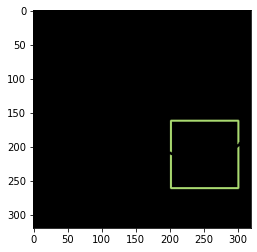

длина 191.65685415267944
длина 89.65685415267944
длина 113.65685415267944
длина 428.1421353816986
длина 57.65685415267944
длина 83.65685415267944
длина 191.65685415267944
длина 367.55634891986847
длина 420.72792184352875
длина 360.72792184352875
длина 418.97056245803833
длина 358.3847759962082
длина 413.899494767189
длина 353.899494767189
длина 410.72792184352875
длина 350.72792184352875
длина 406.4852809906006
длина 344.4852809906006
длина 191.65685415267944
длина 89.65685415267944
длина 113.65685415267944
длина 428.1421353816986
длина 57.65685415267944
длина 83.65685415267944
длина 191.65685415267944
длина 367.55634891986847
длина 422.97056245803833
длина 362.3847758769989
длина 418.97056245803833
длина 358.97056245803833
длина 414.72792184352875
длина 354.72792184352875
длина 413.899494767189
длина 353.899494767189
длина 410.72792184352875
длина 350.72792184352875
длина 406.4852809906006
длина 344.4852809906006
длина 402.48528122901917
длина 340.48528122901917
длина 191.656854152679

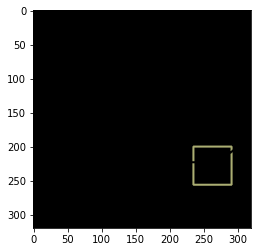

длина 105.65685415267944
длина 55.65685415267944
длина 85.65685415267944
длина 201.89949476718903
длина 35.65685415267944
длина 105.65685415267944
длина 247.55634891986847
длина 272.1421353816986
длина 170.1421353816986
длина 269.55634891986847
длина 167.55634891986847
длина 265.899494767189
длина 163.89949476718903
длина 261.899494767189
длина 159.89949476718903
длина 258.4852809906006
длина 156.4852809906006
длина 105.65685415267944
длина 55.65685415267944
длина 85.65685415267944
длина 201.89949476718903
длина 35.65685415267944
длина 105.65685415267944
длина 247.55634891986847
длина 272.1421353816986
длина 170.1421353816986
длина 269.55634891986847
длина 167.55634891986847
длина 265.899494767189
длина 163.89949476718903
длина 262.72792184352875
длина 160.72792184352875
длина 258.4852809906006
длина 156.4852809906006
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 105.65685415267944
длина 55.65685415267944
длина 85.656854152679

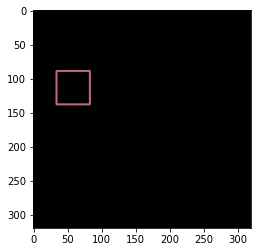

длина 91.65685415267944
длина 169.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 201.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 191.3137083053589
длина 193.65685415267944
длина 91.65685415267944
длина 169.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 188.97056198120117
длина 196.0
длина 91.65685415267944
длина 169.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 199.31

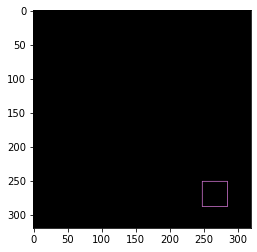

длина 124.97056245803833
длина 164.0
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
длина 123.31370830535889
длина 165.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 123.31370830535889
длина 165.65685415267944
длина 135.3137083053589
длина 153.65685415267944
длина 137.65685415267944
длина 151.3137083053589
длина 143.3137083053589
длина 148.0
itogo 6


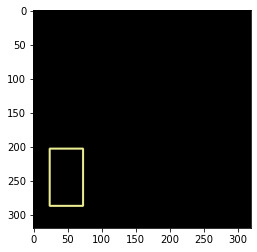

длина 91.65685415267944
длина 239.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 91.65685415267944
длина 285.3137083053589
длина 245.3137083053589
длина 279.65685415267944
длина 247.65685415267944
длина 277.3137083053589
длина 250.97056198120117
длина 271.65685415267944
длина 253.3137083053589
длина 271.65685415267944
длина 255.65685415267944
длина 269.3137083053589
длина 255.65685415267944
длина 269.3137083053589
длина 258.9705619812012
длина 266.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 91.65685415267944
длина 239.65685415267944
длина 161.65685415267944
длина 161.65685415267944
длина 91.65685415267944
длина 285.3137083053589
длина 245.3137083053589
длина 279.65685415267944
длина 247.65685415267944
длина 277.3137083053589
длина 250.97056198120117
длина 274.0
длина 253.3137083053589
длина 271.65685415267944
длина 255.65685415267944
длина 271.65685415267944
длина 255.65685415267944
длина 269.313708

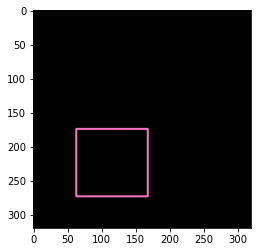

длина 203.65685415267944
длина 381.65685415267944
длина 191.65685415267944
длина 191.65685415267944
длина 203.65685415267944
длина 427.3137083053589
длина 387.3137083053589
длина 421.65685415267944
длина 389.65685415267944
длина 419.3137083053589
длина 392.9705619812012
длина 416.0
длина 395.3137083053589
длина 413.65685415267944
длина 397.65685415267944
длина 413.65685415267944
длина 397.65685415267944
длина 411.3137083053589
длина 400.9705619812012
длина 408.0
длина 403.3137083053589
длина 405.65685415267944
длина 203.65685415267944
длина 381.65685415267944
длина 191.65685415267944
длина 191.65685415267944
длина 203.65685415267944
длина 427.3137083053589
длина 389.65685415267944
длина 419.3137083053589
длина 395.3137083053589
длина 413.65685415267944
длина 397.65685415267944
длина 411.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 203.65685415267944
длина 381.65685415267944
длина 191.65685415267944
длина 191.656

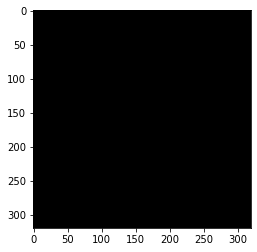

itogo 6
train_data/76.png


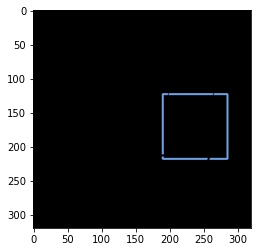

длина 45.65685415267944
длина 123.65685415267944
длина 354.48528122901917
длина 183.65685415267944
длина 169.65685415267944
длина 33.65685415267944
длина 123.65685415267944
длина 9.656854152679443
длина 400.97056245803833
длина 142.72792184352875
длина 612.5269113779068
длина 137.65685415267944
длина 607.6984843015671
длина 130.82842707633972
длина 274.4852809906006
длина 124.0
длина 184.2426404953003
длина 45.65685415267944
длина 123.65685415267944
длина 354.48528122901917
длина 183.65685415267944
длина 169.65685415267944
длина 33.65685415267944
длина 123.65685415267944
длина 9.656854152679443
длина 400.97056245803833
длина 144.48528122901917
длина 611.798989534378
длина 140.24264061450958
длина 606.7279214859009
длина 137.65685415267944
длина 607.6984843015671
длина 134.48528122901917
длина 276.1421353816986
длина 127.65685415267944
длина 187.89949476718903
длина 130.82842707633972
длина 271.65685415267944
длина 122.0
длина 184.82842707633972
длина 45.65685415267944
длина 123.6568541

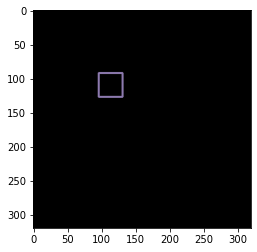

длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 132.97056198120117
длина 140.0
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 135.3137083053589
длина 137.65685415267944
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.

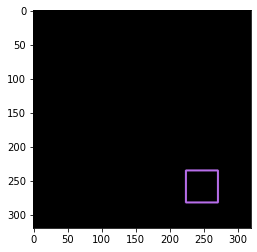

длина 87.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 207.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 180.97056198120117
длина 188.0
длина 183.3137083053589
длина 185.65685415267944
длина 87.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 207.3137083053589
длина 169.65685415267944
длина 199.3137083053589
длина 175.3137083053589
длина 193.65685415267944
длина 180.97056198120117
длина 188.0
длина 87.65685415267944
длина 161.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 207.3137083053589
длина 167.3137083053589
длина 201.65685415267944
длина 169.65685415267944
длина 199.3137083053589
длина 172.97056198120117
длина 193.65685415267944


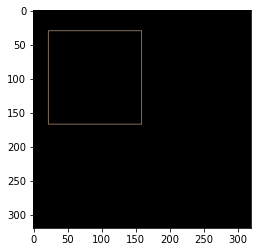

длина 523.3137083053589
длина 565.6568541526794
длина 537.6568541526794
длина 553.6568541526794
длина 540.9705619812012
длина 548.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 255.65685415267944
длина 255.65685415267944
длина 255.65685415267944
длина 521.6568541526794
длина 255.65685415267944
длина 567.3137083053589
длина 537.6568541526794
длина 553.6568541526794
длина 543.3137083053589
длина 548.0
длина 523.3137083053589
длина 565.6568541526794
длина 537.6568541526794
длина 551.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 4


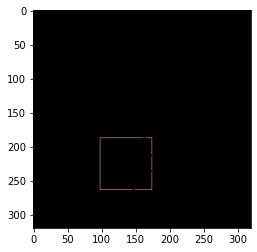

длина 33.65685415267944
длина 77.65685415267944
длина 33.65685415267944
длина 23.656854152679443
длина 31.656854152679443
длина 133.65685415267944
длина 284.2842707633972
длина 109.65685415267944
длина 329.94112491607666
длина 102.82842707633972
длина 42.0
длина 68.82842707633972
длина 373.65685415267944
длина 94.2426404953003
длина 34.0
длина 60.24264049530029
длина 364.4852809906006
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 285.11269783973694
длина 325.79898953437805
длина 99.89949476718903
длина 39.65685415267944
длина 65.89949476718903
длина 370.1421353816986
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 280.97056245803833
длина 320.0
длина 100.48528122901917
длина 39.65685415267944
длина 66.48528122901917
длина 371.3137083053589
длина 94.82842707633972
длина 34.0
длина 60.82842707633972
длина 365.65685415267944
itogo 5


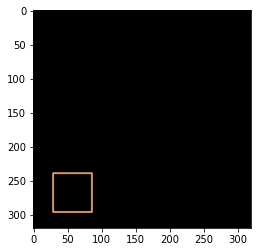

длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 247.3137083053589
длина 209.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 239.3137083053589
длина 215.3137083053589
длина 233.65685415267944
длина 215.3137083053589
длина 233.65685415267944
длина 217.65685415267944
длина 231.3137083053589
длина 220.97056198120117
длина 228.0
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 247.3137083053589
длина 209.65685415267944
длина 239.3137083053589
длина 212.97056198120117
длина 233.65685415267944
длина 217.65685415267944
длина 233.65685415267944
длина 220.97056245803833
длина 228.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 107.65685415267944
длина 201

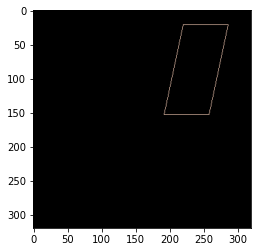

длина 392.02438521385193
длина 436.02438521385193
длина 406.02438521385193
длина 424.85281229019165
длина 411.6812393665314
длина 422.5096664428711
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 392.02438521385193
длина 436.02438521385193
длина 406.02438521385193
длина 424.85281229019165
длина 412.85281205177307
длина 419.1959581375122
длина 113.65685415267944
длина 391.1959581375122
длина 113.65685415267944
длина 435.6812393665314
длина 406.02438521385193
длина 424.85281229019165
длина 137.65685415267944
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длин

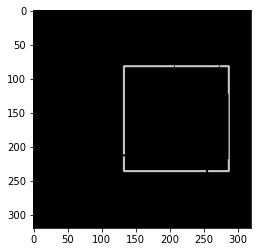

длина 53.65685415267944
длина 233.65685415267944
длина 29.656854152679443
длина 35.65685415267944
длина 590.4852812290192
длина 75.65685415267944
длина 251.65685415267944
длина 21.656854152679443
длина 125.65685415267944
длина 141.65685415267944
длина 635.3137083053589
длина 289.899494767189
длина 939.2132030725479
длина 287.55634891986847
длина 940.1837655305862
длина 284.2426406145096
длина 933.5563489198685
длина 281.899494767189
длина 934.5269113779068
длина 97.65685415267944
длина 280.2426406145096
длина 110.48528122901917
длина 129.65685415267944
длина 403.0710676908493
длина 90.2426404953003
длина 276.2426404953003
длина 102.2426404953003
длина 124.0
длина 398.2426404953003
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 53.65685415267944
длина 233.65685415267944
длина 29.656854152679443
длина 35.65685415267944
длина 590.4852812290192
длина 75.65685415267944
длина 251.65685415267944
длина 19.656854152679443
длина 5.656854

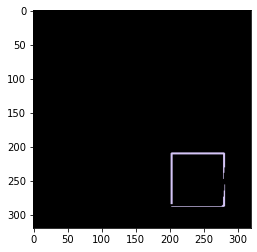

длина 21.656854152679443
длина 35.65685415267944
длина 141.65685415267944
длина 147.65685415267944
длина 612.2842707633972
длина 219.89949464797974
длина 380.1421353816986
длина 218.1421353816986
длина 377.79898953437805
длина 207.89949476718903
длина 371.3137083053589
длина 51.65685415267944
длина 356.72792184352875
длина 45.65685415267944
длина 351.899494767189
длина 28.82842707633972
длина 336.4852809906006
длина 22.82842707633972
длина 330.48528122901917
длина 21.656854152679443
длина 35.65685415267944
длина 141.65685415267944
длина 147.65685415267944
длина 612.2842707633972
длина 219.89949464797974
длина 380.1421353816986
длина 214.1421353816986
длина 375.79898953437805
длина 54.485281229019165
длина 359.3137083053589
длина 51.071067690849304
длина 357.3137083053589
длина 31.656854152679443
длина 340.1421353816986
длина 27.41421353816986
длина 337.65685415267944
длина 21.656854152679443
длина 35.65685415267944
длина 141.65685415267944
длина 147.65685415267944
длина 612.28427076339

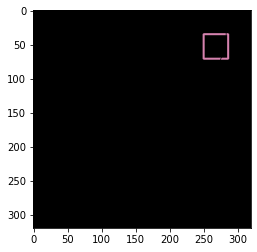

длина 13.656854152679443
длина 43.65685415267944
длина 117.65685415267944
длина 65.65685415267944
длина 65.65685415267944
длина 57.65685415267944
длина 163.3137083053589
длина 125.65685415267944
длина 155.3137083053589
длина 127.89949476718903
длина 156.97056245803833
длина 131.3137083053589
длина 149.65685415267944
длина 133.55634891986847
длина 151.3137083053589
длина 94.72792184352875
длина 182.1421353816986
длина 89.65685403347015
длина 176.4852809906006
длина 84.24264061450958
длина 172.48528122901917
длина 13.656854152679443
длина 43.65685415267944
длина 117.65685415267944
длина 65.65685415267944
длина 65.65685415267944
длина 57.65685415267944
длина 163.3137083053589
длина 126.48528122901917
длина 156.97056245803833
длина 131.3137083053589
длина 149.65685415267944
длина 94.72792184352875
длина 182.1421353816986
длина 88.24264061450958
длина 177.65685415267944
длина 13.656854152679443
длина 43.65685415267944
длина 117.65685415267944
длина 65.65685415267944
длина 65.65685415267944


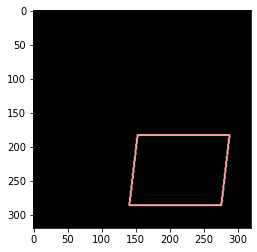

длина 263.65685415267944
длина 5.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 459.5979790687561
длина 5.656854152679443
длина 263.65685415267944
длина 505.25483322143555
длина 463.5979790687561
длина 499.5979790687561
длина 467.5979790687561
длина 497.25483322143555
длина 469.25483298301697
длина 493.94112491607666
длина 473.25483322143555
длина 491.5979790687561
длина 473.25483322143555
длина 491.5979790687561
длина 475.5979790687561
длина 489.25483322143555
длина 387

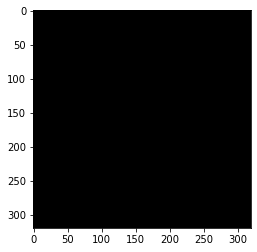

itogo 9
train_data/77.png


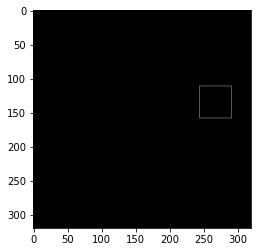

длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 161.65685415267944
длина 75.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 193.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 1


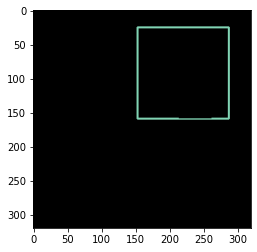

длина 45.65685415267944
длина 115.65685415267944
длина 510.48528122901917
длина 261.65685415267944
длина 261.65685415267944
длина 261.65685415267944
длина 555.3137083053589
длина 518.4852812290192
длина 547.3137083053589
длина 524.1421353816986
длина 541.6568541526794
длина 526.4852812290192
длина 539.3137083053589
длина 965.3137083053589
длина 45.65685415267944
длина 115.65685415267944
длина 510.48528122901917
длина 261.65685415267944
длина 261.65685415267944
длина 261.65685415267944
длина 555.3137083053589
длина 518.4852812290192
длина 547.3137083053589
длина 518.4852812290192
длина 547.3137083053589
длина 524.1421353816986
длина 541.6568541526794
длина 524.1421353816986
длина 541.6568541526794
длина 526.4852812290192
длина 539.3137083053589
длина 966.9705619812012
длина 958.9705624580383
длина 45.65685415267944
длина 115.65685415267944
длина 510.48528122901917
длина 261.65685415267944
длина 261.65685415267944
длина 261.65685415267944
длина 555.3137083053589
длина 518.4852812290192
д

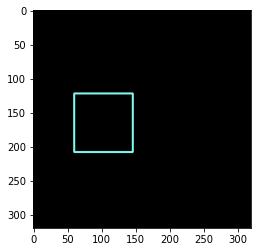

длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 325.65685415267944
длина 355.3137083053589
длина 331.3137083053589
длина 349.65685415267944
длина 333.65685415267944
длина 347.3137083053589
длина 339.3137083053589
длина 344.0
длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длина 323.3137083053589
длина 357.65685415267944
длина 325.65685415267944
длина 355.3137083053589
длина 328.9705619812012
длина 352.0
длина 331.3137083053589
длина 349.65685415267944
длина 331.3137083053589
длина 349.65685415267944
длина 333.65685415267944
длина 347.3137083053589
длина 336.9705619812012
длина 344.0
длина 339.3137083053589
длина 341.65685415267944
длина 165.65685415267944
длина 317.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 165.65685415267944
длина 363.3137083053589
длин

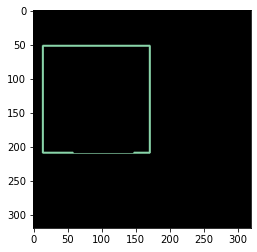

длина 157.65685415267944
длина 41.65685415267944
длина 83.65685415267944
длина 602.4852812290192
длина 307.65685415267944
длина 307.65685415267944
длина 307.65685415267944
длина 648.1421353816986
длина 611.3137083053589
длина 639.3137083053589
длина 1082.6274166107178
длина 1074.6274166107178
длина 1068.9705619812012
длина 41.65685415267944
длина 83.65685415267944
длина 603.3137083053589
длина 307.65685415267944
длина 307.65685415267944
длина 307.65685415267944
длина 647.3137083053589
длина 611.3137083053589
длина 639.3137083053589
длина 611.3137083053589
длина 639.3137083053589
длина 616.9705624580383
длина 633.6568541526794
длина 1075.798989534378
длина 1071.798989534378
длина 1068.9705619812012
длина 1060.9705624580383
длина 157.65685415267944
длина 41.65685415267944
длина 83.65685415267944
длина 602.4852812290192
длина 307.65685415267944
длина 307.65685415267944
длина 307.65685415267944
длина 648.1421353816986
длина 611.3137083053589
длина 639.3137083053589
длина 612.1421353816986


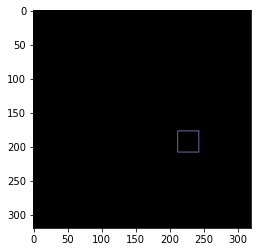

длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
длина 99.31370830535889
длина 141.65685415267944
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124.0
itogo 5


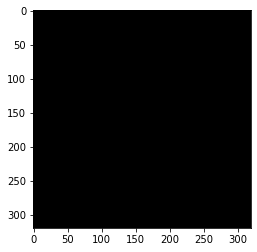

itogo 5
train_data/78.png


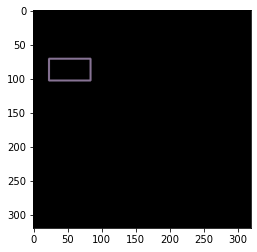

длина 115.65685415267944
длина 159.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 115.65685415267944
длина 205.3137083053589
длина 167.65685415267944
длина 197.3137083053589
длина 173.3137083053589
длина 191.65685415267944
длина 175.65685415267944
длина 189.3137083053589
длина 178.97056198120117
длина 186.0
длина 115.65685415267944
длина 159.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 115.65685415267944
длина 205.3137083053589
длина 167.65685415267944
длина 197.3137083053589
длина 173.3137083053589
длина 191.65685415267944
длина 175.65685415267944
длина 189.3137083053589
длина 115.65685415267944
длина 159.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 115.65685415267944
длина 205.3137083053589
длина 167.65685415267944
длина 197.3137083053589
длина 170.97056198120117
длина 191.65685415267944
длина 175.65685415267944
длина 191.65685415267944
длина 178.97056245803833
длина 186.0
длина 6.2426406145095825
длина 6.242640614

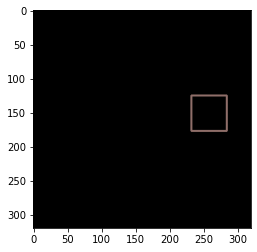

длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 213.65685415267944
длина 200.97056198120117
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 200.97056198120117
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 200.97056198120117
длина 208.0
itogo 1


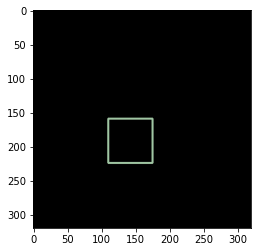

длина 123.65685415267944
длина 233.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 268.0
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 255.3137083053589
длина 257.65685415267944
длина 123.65685415267944
длина 233.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 255.3137083053589
длина 260.0
длина 123.65685415267944
длина 233.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.313

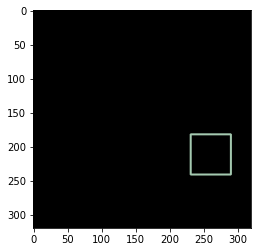

длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 220.97056198120117
длина 244.0
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 223.3137083053589
длина 241.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 228.97056198120117
длина 236.0
длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
дл

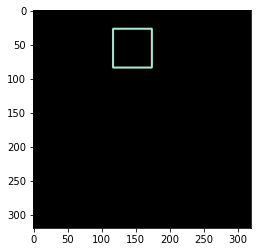

длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 247.3137083053589
длина 209.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 239.3137083053589
длина 215.3137083053589
длина 233.65685415267944
длина 217.65685415267944
длина 231.3137083053589
длина 220.97056198120117
длина 228.0
длина 107.65685415267944
длина 201.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 107.65685415267944
длина 247.3137083053589
длина 207.3137083053589
длина 241.65685415267944
длина 209.65685415267944
длина 239.3137083053589
длина 212.97056198120117
длина 233.65685415267944
длина 215.3137083053589
длина 233.65685415267944
длина 217.65685415267944
длина 231.3137083053589
длина 217.65685415267944
длина 231.3137083053589
длина 220.97056198120117
длина 228.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 107.65685415267944
длина 201.65

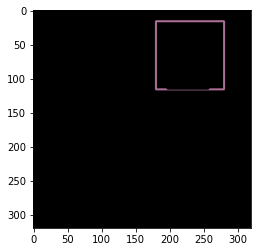

длина 37.65685415267944
длина 25.656854152679443
длина 374.48528122901917
длина 193.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 419.3137083053589
длина 383.3137083053589
длина 411.3137083053589
длина 384.1421353816986
длина 412.1421353816986
длина 674.6274166107178
длина 667.798989534378
длина 664.9705619812012
длина 37.65685415267944
длина 25.656854152679443
длина 374.48528122901917
длина 193.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 419.3137083053589
длина 383.3137083053589
длина 411.3137083053589
длина 671.798989534378
длина 664.9705619812012
длина 37.65685415267944
длина 25.656854152679443
длина 375.3137083053589
длина 193.65685415267944
длина 193.65685415267944
длина 193.65685415267944
длина 419.3137083053589
длина 383.3137083053589
длина 411.3137083053589
длина 386.6274161338806
длина 405.65685415267944
длина 671.798989534378
длина 664.9705624580383
длина 656.9705624580383
itogo 5


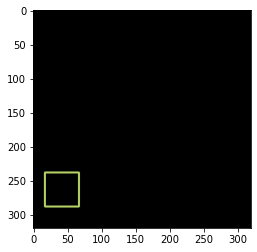

длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 192.97056198120117
длина 200.0
длина 195.3137083053589
длина 197.65685415267944
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 219.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 181.65685415267944
длина 211.3137083053589
длина 187.3137083053589
длина 205.65685415267944
длина 187.3137083053589
длина 205.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 192.97056198120117
длина 200.0
длина 195.3137083053589
длина 197.65685415267944
длина 93.65685415267944
длина 173.65685415267944
длина 93.65685415267944
длина 93.65685415267944


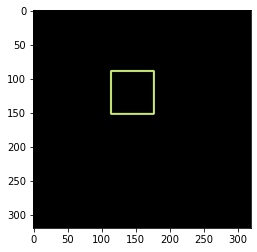

длина 119.65685415267944
длина 225.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 271.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 233.65685415267944
длина 263.3137083053589
длина 239.3137083053589
длина 257.65685415267944
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 244.97056198120117
длина 252.0
длина 119.65685415267944
длина 225.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 271.3137083053589
длина 231.3137083053589
длина 265.65685415267944
длина 233.65685415267944
длина 263.3137083053589
длина 236.97056198120117
длина 257.65685415267944
длина 239.3137083053589
длина 257.65685415267944
длина 241.65685415267944
длина 255.3137083053589
длина 241.65685415267944
длина 255.3137083053589
длина 247.3137083053589
длина 252.0
длина 119.65685415267944
длина 225.65685415267944
длина 119.65685415267944
длина 119.6568

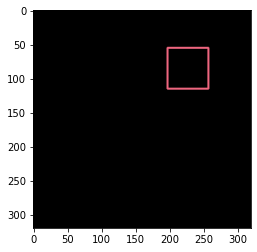

длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 219.3137083053589
длина 253.65685415267944
длина 221.65685415267944
длина 251.3137083053589
длина 224.97056198120117
длина 248.0
длина 227.3137083053589
длина 245.65685415267944
длина 229.65685415267944
длина 245.65685415267944
длина 229.65685415267944
длина 243.3137083053589
длина 232.97056198120117
длина 240.0
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 10.242640614509583
длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.3137083053589
длина 221.65685415267944
длина 251.3137083053589
длина 227.3137083053589
длина 245.65685415267944
длина 232.97056198120117
длина 240.0
длина 113.65685415267944
длина 213.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 259.313708305358

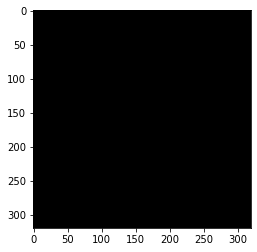

itogo 8
train_data/79.png


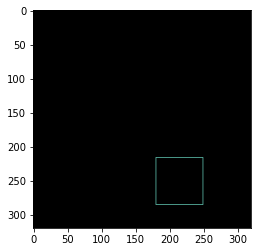

длина 119.65685415267944
длина 119.65685415267944
длина 123.65685415267944
длина 249.65685415267944
длина 123.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 279.3137083053589
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 249.65685415267944
длина 119.65685415267944
длина 295.3137083053589
длина 265.65685415267944
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
длина 251.3137083053589
длина 293.65685415267944
длина 265.65685415267944
длина 281.65685415267944
длина 268.9705619812012
длина 276.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


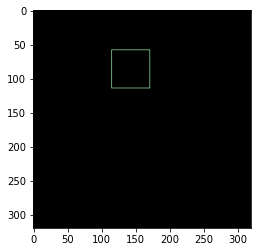

длина 199.3137083053589
длина 241.65685415267944
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
длина 93.65685415267944
длина 93.65685415267944
длина 93.65685415267944
длина 197.65685415267944
длина 93.65685415267944
длина 243.3137083053589
длина 211.3137083053589
длина 229.65685415267944
длина 213.65685415267944
длина 227.3137083053589
длина 219.3137083053589
длина 224.0
длина 200.97056245803833
длина 240.0
длина 213.65685415267944
длина 229.65685415267944
длина 219.3137083053589
длина 224.0
itogo 2


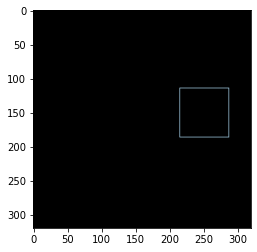

длина 263.3137083053589
длина 305.65685415267944
длина 277.65685415267944
длина 293.65685415267944
длина 283.3137083053589
длина 288.0
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 261.65685415267944
длина 125.65685415267944
длина 307.3137083053589
длина 277.65685415267944
длина 293.65685415267944
длина 277.65685415267944
длина 291.3137083053589
длина 283.3137083053589
длина 288.0
длина 263.3137083053589
длина 305.65685415267944
длина 275.3137083053589
длина 293.65685415267944
длина 277.65685415267944
длина 291.3137083053589
длина 283.3137083053589
длина 288.0
itogo 3


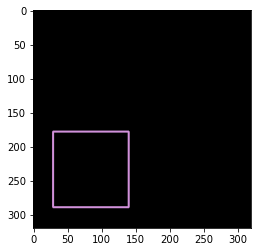

длина 215.65685415267944
длина 417.65685415267944
длина 215.65685415267944
длина 215.65685415267944
длина 215.65685415267944
длина 463.3137083053589
длина 425.65685415267944
длина 455.3137083053589
длина 425.65685415267944
длина 455.3137083053589
длина 431.3137083053589
длина 449.65685415267944
длина 431.3137083053589
длина 449.65685415267944
длина 433.65685415267944
длина 447.3137083053589
длина 436.9705619812012
длина 444.0
длина 439.3137083053589
длина 441.65685415267944
длина 215.65685415267944
длина 417.65685415267944
длина 215.65685415267944
длина 215.65685415267944
длина 215.65685415267944
длина 463.3137083053589
длина 425.65685415267944
длина 455.3137083053589
длина 431.3137083053589
длина 449.65685415267944
длина 433.65685415267944
длина 449.65685415267944
длина 436.9705619812012
длина 444.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 215.65685415267944
длина 417.65685415267944
длина 215.65685415267944
длина 215.656

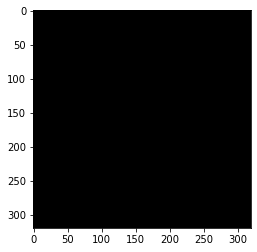

itogo 4
train_data/80.png


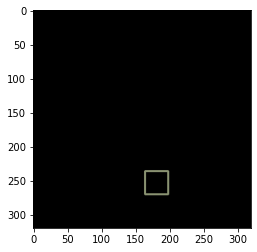

длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 128.97056198120117
длина 136.0
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 141.65685415267944
длина 128.97056198120117
длина 136.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.6568541526

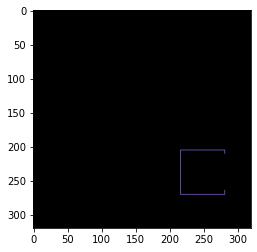

длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 420.97056245803833
длина 408.97056245803833
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 111.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 420.97056245803833
длина 406.6274166107178
длина 421.79898953437805
длина 408.97056245803833
длина 406.6274166107178
длина 399.3137083053589
itogo 2


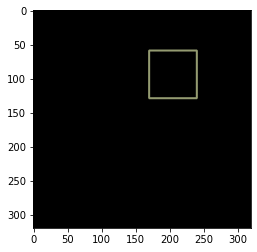

длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.65685415267944
длина 291.3137083053589
длина 264.9705619812012
длина 285.65685415267944
длина 269.65685415267944
длина 285.65685415267944
длина 272.97056245803833
длина 280.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.65685415267944
длина 291.3137083053589
длина 264.9705619812012
длина 285.65685415267944
длина 267.3137083053589
длина 285.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 275.3137083053589
длина 277.65685415267944
длина 133.65685415267944
длина 253.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 133.65685415267944
длина 299.3137083053589
длина 261.6568541526794

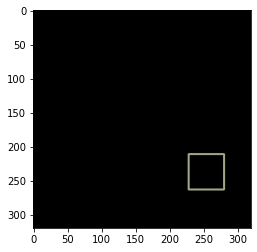

длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 192.97056198120117
длина 216.0
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 200.97056198120117
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.6568

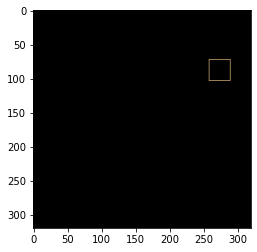

длина 99.31370830535889
длина 141.65685415267944
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124.0
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 129.65685415267944
длина 116.97056198120117
длина 124.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 113.65685415267944
длина 127.31370830535889
itogo 5


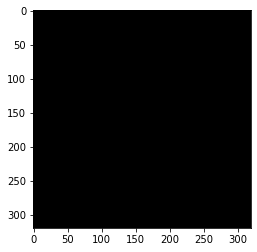

itogo 5
train_data/81.png


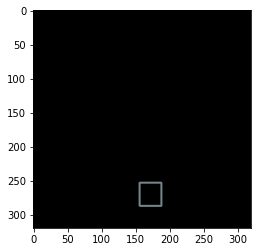

длина 57.65685415267944
длина 105.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 57.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 57.65685415267944
длина 105.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 57.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 127.31370830535889
длина 132.0
длина 57.65685415267944
длина 105.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 57.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 13

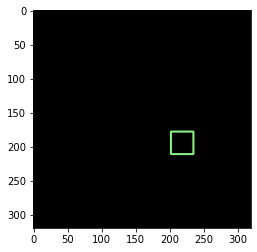

длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 113.65685415267944
длина 143.3137083053589
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 124.97056198120117
длина 132.0
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 111.31370830535889
длина 145.65685415267944
длина 113.65685415267944
длина 143.3137083053589
длина 116.97056198120117
длина 140.0
длина 119.31370830535889
длина 137.65685415267944
длина 121.65685415267944
длина 137.65685415267944
длина 121.65685415267944
длина 135.3137083053589
длина 124.97056198120117
длина 132.0
длина 127.31370830535889
длина 129.65685415267944
длина 59.65685415267944
длина 105.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 151.3137083053589
длина 11

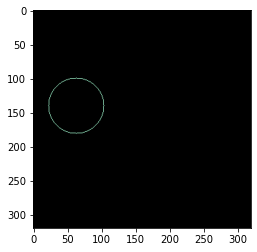

длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 247.764497756958
длина 5.656854152679443
длина 5.656854152679443
длина 287.7644987106323
длина 260.45079135894775
длина 271.76450061798096
длина 14.0
длина 14.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 14.0
длина 14.0
длина 247.764497756958
длина 287.7644987106323
длина 260.45079040527344
длина 275.0782060623169
длина 266.10764598846436
длина 274.1076469421387
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 247.764497756958
длина 287.7644987106323
длина 260.45079135894775
длина 271.76450061798096
длина 266.10764694213

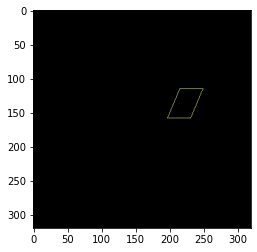

длина 49.65685415267944
длина 138.08326029777527
длина 49.65685415267944
длина 185.39696860313416
длина 156.911687374115
длина 174.56854152679443
длина 71.65685415267944
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 71.65685415267944
длина 49.65685415267944
длина 138.08326029777527
длина 49.65685415267944
длина 185.39696860313416
длина 155.74011421203613
длина 174.56854152679443
длина 161.39696860313416
длина 168.911687374115
длина 2.0
длина 2.0
длина 138.911687374115
длина 184.56854152679443
длина 161.39696860313416
длина 168.911687374115
itogo 1


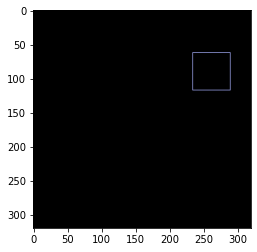

длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


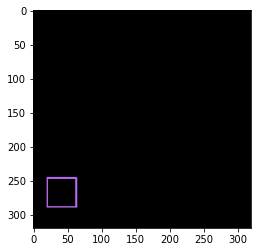

длина 145.0710676908493
длина 79.65685415267944
длина 79.65685415267944
длина 187.89949476718903
длина 153.65685415267944
длина 181.0710676908493
длина 153.65685415267944
длина 179.3137083053589
длина 159.3137083053589
длина 175.41421353816986
длина 161.65685415267944
длина 173.0710676908493
длина 3.414213538169861
длина 171.89949476718903
длина 166.24264061450958
длина 145.0710676908493
длина 79.65685415267944
длина 79.65685415267944
длина 187.89949476718903
длина 153.65685415267944
длина 179.3137083053589
длина 159.3137083053589
длина 173.65685415267944
длина 0.0
длина 169.07106757164001
длина 145.0710676908493
длина 79.65685415267944
длина 79.65685415267944
длина 187.89949476718903
длина 151.3137083053589
длина 181.65685415267944
длина 153.65685415267944
длина 181.0710676908493
длина 156.97056198120117
длина 176.0
длина 159.3137083053589
длина 175.41421353816986
длина 161.65685415267944
длина 173.65685415267944
длина 9.071067690849304
длина 178.72792184352875
длина 0.0
длина 169.071

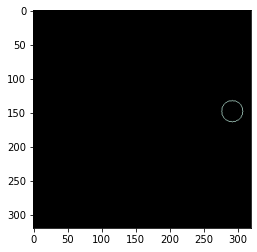

длина 82.91168785095215
длина 122.91168737411499
длина 95.59797859191895
длина 106.91168785095215
длина 101.25483322143555
длина 104.56854057312012
длина 82.91168785095215
длина 122.91168737411499
длина 95.5979790687561
длина 110.22539710998535
длина 98.91168785095215
длина 106.91168689727783
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 35.31370830535889
длина 82.91168785095215
длина 122.91168737411499
длина 95.5979790687561
длина 110.22539615631104
длина 101.25483322143555
длина 104.56854057312012
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
itogo 3


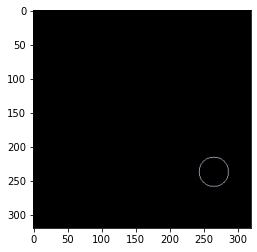

длина 123.88224983215332
длина 161.53910446166992
длина 134.22539710998535
длина 147.882248878479
длина 139.882248878479
длина 145.5391025543213
длина 123.88224983215332
длина 161.53910446166992
длина 134.22539710998535
длина 151.1959571838379
длина 139.882248878479
длина 145.5391025543213
длина 123.88224983215332
длина 161.53910446166992
длина 134.22539615631104
длина 151.1959581375122
длина 139.882248878479
длина 147.882248878479
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 6.0
длина 6.0
itogo 3


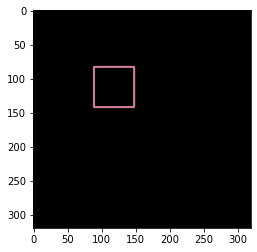

длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 223.3137083053589
длина 241.65685415267944
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 228.97056198120117
длина 236.0
длина 231.3137083053589
длина 233.65685415267944
длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137083053589
длина 223.3137083053589
длина 241.65685415267944
длина 225.65685415267944
длина 239.3137083053589
длина 231.3137083053589
длина 236.0
длина 111.65685415267944
длина 209.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 255.3137083053589
длина 217.65685415267944
длина 247.3137

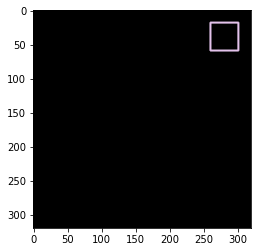

длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 143.3137083053589
длина 177.65685415267944
длина 145.65685415267944
длина 175.3137083053589
длина 148.97056198120117
длина 169.65685415267944
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 156.97056245803833
длина 164.0
длина 159.3137083053589
длина 164.0
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 183.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 175.3137083053589
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 75.65685415267944
длина 137.65685415267944
длина 75.65685415267944
длина 75.65685415267944
длина 75.656

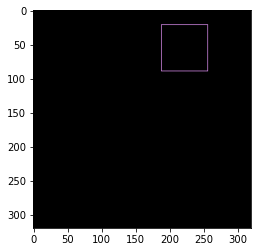

длина 248.97056245803833
длина 288.0
длина 259.3137083053589
длина 277.65685415267944
длина 261.65685415267944
длина 275.3137083053589
длина 267.3137083053589
длина 272.0
длина 248.97056245803833
длина 288.0
длина 261.65685415267944
длина 277.65685415267944
длина 267.3137083053589
длина 272.0
длина 117.65685415267944
длина 117.65685415267944
длина 117.65685415267944
длина 245.65685415267944
длина 117.65685415267944
длина 291.3137083053589
длина 259.3137083053589
длина 277.65685415267944
длина 261.65685415267944
длина 275.3137083053589
длина 267.3137083053589
длина 272.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 6


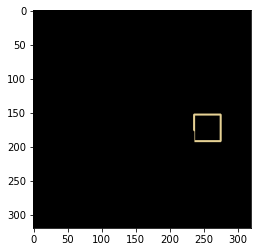

длина 69.65685415267944
длина 129.0710676908493
длина 71.65685415267944
длина 41.65685415267944
длина 71.65685415267944
длина 174.72792184352875
длина 135.3137083053589
длина 168.48528122901917
длина 137.65685415267944
длина 166.1421353816986
длина 141.5563485622406
длина 161.0710676908493
длина 280.97056245803833
длина 277.55634891986847
длина 272.97056245803833
длина 270.48528122901917
длина 69.65685415267944
длина 129.0710676908493
длина 71.65685415267944
длина 41.65685415267944
длина 71.65685415267944
длина 174.72792184352875
длина 137.65685415267944
длина 166.72792184352875
длина 137.65685415267944
длина 166.1421353816986
длина 143.3137083053589
длина 161.0710676908493
длина 277.55634891986847
длина 274.97056245803833
длина 270.7279214859009
длина 264.72792184352875
длина 69.65685415267944
длина 129.0710676908493
длина 71.65685415267944
длина 41.65685415267944
длина 71.65685415267944
длина 174.72792184352875
длина 137.65685415267944
длина 166.72792184352875
длина 141.5563485622406

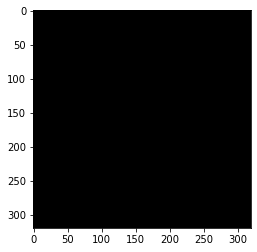

itogo 7
train_data/82.png


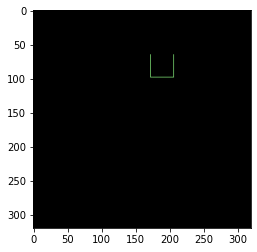

длина 212.48528122901917
длина 198.1421353816986
длина 6.2426406145095825
длина 6.2426406145095825
длина 49.65685415267944
длина 49.65685415267944
длина 49.65685415267944
длина 214.1421353816986
длина 202.1421353816986
длина 198.1421353816986
длина 193.65685415267944
длина 212.48528122901917
длина 198.1421353816986
длина 2.8284270763397217
длина 2.8284270763397217
itogo 0


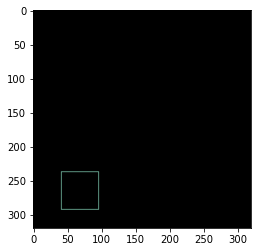

длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 212.97056198120117
длина 220.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


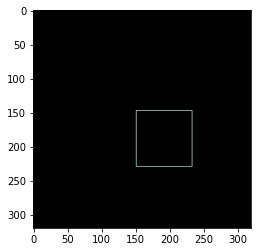

длина 145.65685415267944
длина 145.65685415267944
длина 145.65685415267944
длина 301.65685415267944
длина 145.65685415267944
длина 347.3137083053589
длина 317.65685415267944
длина 333.65685415267944
длина 320.9705619812012
длина 328.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 303.3137083053589
длина 345.65685415267944
длина 315.3137083053589
длина 333.65685415267944
длина 317.65685415267944
длина 331.3137083053589
длина 323.3137083053589
длина 328.0
длина 303.3137083053589
длина 345.65685415267944
длина 315.3137083053589
длина 333.65685415267944
длина 317.65685415267944
длина 331.3137083053589
длина 323.3137083053589
длина 328.0
itogo 2


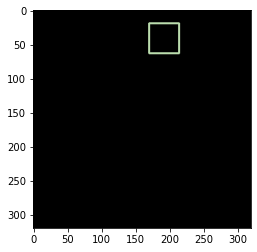

длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 168.97056245803833
длина 176.0
длина 171.3137083053589
длина 173.65685415267944
длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 155.3137083053589
длина 189.65685415267944
длина 157.65685415267944
длина 187.3137083053589
длина 160.97056198120117
длина 181.65685415267944
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 168.97056198120117
длина 176.0
длина 171.3137083053589
длина 173.65685415267944
длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944

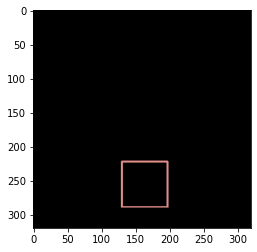

длина 241.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 285.3137083053589
длина 247.3137083053589
длина 279.65685415267944
длина 249.65685415267944
длина 277.3137083053589
длина 252.97056198120117
длина 272.8284270763397
длина 255.3137083053589
длина 272.8284270763397
длина 257.65685415267944
длина 270.48528122901917
длина 400.1421353816986
длина 398.48528122901917
длина 241.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 285.3137083053589
длина 249.65685415267944
длина 278.48528122901917
длина 255.3137083053589
длина 272.8284270763397
длина 257.65685415267944
длина 271.65685415267944
длина 397.3137080669403
длина 241.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 127.65685415267944
длина 285.3137083053589
длина 249.65685415267944
длина 278.48528122901917
длина 255.3137083053589
длина 272.8284270763397
длина 257.65685415267944
длина 270.48528122901917
длина 397.3137

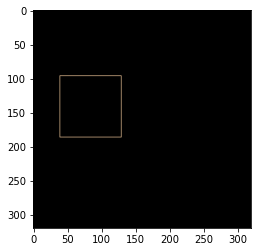

длина 336.97056245803833
длина 376.0
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 355.3137083053589
длина 360.0
длина 335.3137083053589
длина 377.65685415267944
длина 349.65685415267944
длина 365.65685415267944
длина 352.9705619812012
длина 360.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 336.97056245803833
длина 376.0
длина 349.65685415267944
длина 365.65685415267944
длина 355.3137083053589
длина 360.0
itogo 5


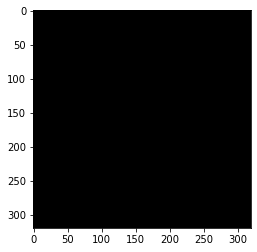

itogo 5
train_data/83.png


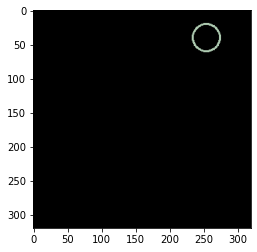

длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 118.22539567947388
длина 145.53910398483276
длина 119.98275518417358
длина 145.5391035079956
длина 123.882248878479
длина 139.88224959373474
длина 125.63960886001587
длина 139.88224935531616
длина 129.53910446166992
длина 134.22539520263672
длина 0.0
длина 2.8284270763397217
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 5.656854152679443
длина 0.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 153.53910398483276
длина 117.63960886001587
длина 147.88224935531616
длина 118.81118202209473
длина 145.53910386562347
длина 123.88224983215332
длина 139.88224983215332
длина 126.22539520263672
длина 139.88224983215332
длина 125.63960933685303
длина 137.53910398483276
длина 131.29646348953247
длина 134.22539567947388
длина 0.0
длина 2.8284270763397217
длин

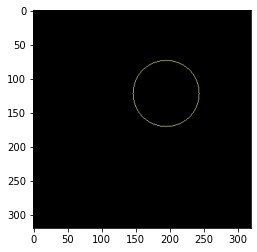

длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 302.3919153213501
длина 5.656854152679443
длина 5.656854152679443
длина 342.3919153213501
длина 315.0782070159912
длина 329.70562267303467
длина 320.7350606918335
длина 324.048770904541
длина 302.3919153213501
длина 342.3919153213501
длина 315.0782070159912
длина 329.705623626709
длина 320.7350606918335
длина 324.048770904541
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 302.3919153213501
длина 342.3919153213501
длина 318.3919143676758
длина 326.3919153213501
itogo 0


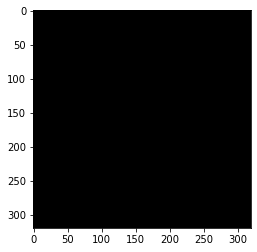

itogo 0
train_data/84.png


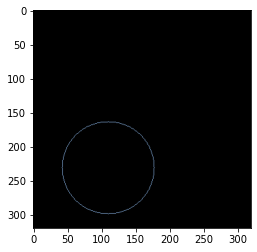

длина 428.61731338500977
длина 468.617311000824
длина 446.96045684814453
длина 450.2741641998291
длина 428.61731338500977
длина 468.617311000824
длина 444.6173105239868
длина 452.61731147766113
длина 16.0
длина 16.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 16.0
длина 16.0
длина 16.0
длина 16.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 16.0
длина 16.0
длина 428.61731338500977
длина 468.617311000824
длина 441.30360221862793
длина 452.61731147766113
длина 165.39696860313416
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 165.39696860313416
длина 165.39696860313416
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 165.39696860313416
itogo 0


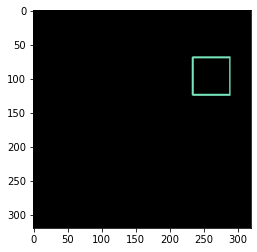

длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 237.3137083053589
длина 201.65685415267944
длина 229.3137083053589
длина 207.3137083053589
длина 224.82842707633972
длина 329.79898953437805
длина 318.48528122901917
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 237.3137083053589
длина 199.3137083053589
длина 231.65685415267944
длина 201.65685415267944
длина 229.3137083053589
длина 204.97056198120117
длина 224.82842707633972
длина 207.3137083053589
длина 224.82842707633972
длина 209.65685415267944
длина 222.48528122901917
длина 328.1421353816986
длина 326.48528122901917
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 237.3137083053589
длина 201.65685415267944
длина 230.48528122901917
длина 201.65685415267944
длина 229.3137083053589
длина 207.3137083053589
длина 224.82842707633972
длина 209.65685415267944
длина 222.4

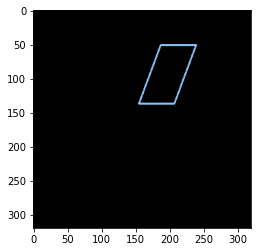

длина 99.65685415267944
длина 5.656854152679443
длина 271.6812393665314
длина 5.656854152679443
длина 99.65685415267944
длина 320.16652059555054
длина 282.5096664428711
длина 313.82337474823
длина 286.5096664428711
длина 308.16652059555054
длина 290.5096664428711
длина 305.3380935192108
длина 113.89949464797974
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 2.0
длина 2.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 2.0
длина 2.0
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 113.89949464797974
длина 0.0
длина 0.0
длина 99.65685415267944
длина 5.656854152679443
длина 271.6812393665314
длина 5.656854152679443
длина 99.65685415267944
длина 320.16652059555054
длина 2

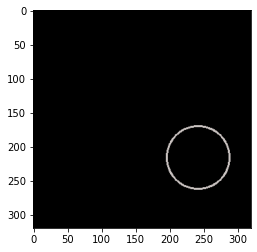

длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 283.07820773124695
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 326.3919143676758
длина 291.07820677757263
длина 318.39191722869873
длина 293.4213533401489
длина 318.39191722869873
длина 299.0782070159912
длина 312.73506259918213
длина 299.0782070159912
длина 312.7350630760193
длина 301.42135310173035
длина 310.3919150829315
длина 138.22539520263672
длина 3.414213538169861
длина 3.414213538169861
длина 138.22539520263672
длина 138.22539520263672
длина 3.414213538169861
длина 3.414213538169861
длина 138.22539520263672
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
д

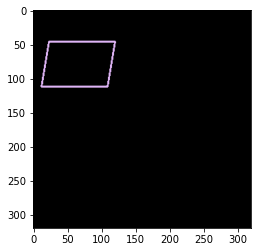

длина 187.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 305.94112491607666
длина 187.65685415267944
длина 352.7695519924164
длина 313.94112491607666
длина 348.7695519924164
длина 317.94112491607666
длина 346.4264061450958
длина 319.5979788303375
длина 340.7695519924164
длина 321.94112491607666
длина 340.7695519924164
длина 324.7695519924164
длина 338.4264061450958
длина 327.5979790687561
длина 335.11269783973694
длина 198.48528122901917
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длин

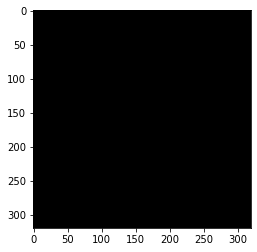

itogo 1
train_data/85.png


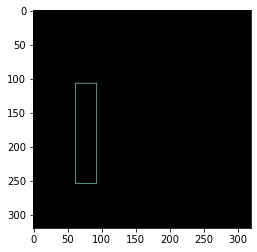

длина 331.3137083053589
длина 373.65685415267944
длина 345.65685415267944
длина 359.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 331.3137083053589
длина 373.65685415267944
длина 343.3137083053589
длина 361.65685415267944
длина 345.65685415267944
длина 359.3137083053589
длина 351.3137083053589
длина 356.0
длина 331.3137083053589
длина 373.65685415267944
длина 345.65685415267944
длина 361.65685415267944
длина 348.9705619812012
длина 356.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 0


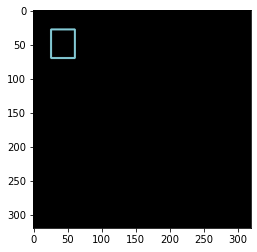

длина 63.65685415267944
длина 127.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 63.65685415267944
длина 173.3137083053589
длина 135.65685415267944
длина 165.3137083053589
длина 141.3137083053589
длина 159.65685415267944
длина 143.65685415267944
длина 157.3137083053589
длина 149.3137083053589
длина 154.0
длина 63.65685415267944
длина 127.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 63.65685415267944
длина 173.3137083053589
длина 135.65685415267944
длина 165.3137083053589
длина 135.65685415267944
длина 165.3137083053589
длина 141.3137083053589
длина 159.65685415267944
длина 141.3137083053589
длина 159.65685415267944
длина 143.65685415267944
длина 157.3137083053589
длина 146.97056198120117
длина 154.0
длина 63.65685415267944
длина 127.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 63.65685415267944
длина 173.3137083053589
длина 135.65685415267944
длина 165.3137083053589
длина 135.65685415267944
длина 165.3137083053589
дл

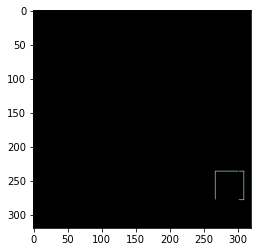

длина 65.65685415267944
длина 65.65685415267944
длина 49.65685415267944
длина 278.04163014888763
длина 263.79898953437805
длина 101.65685415267944
длина 138.82842707633972
длина 65.65685415267944
длина 65.65685415267944
длина 49.65685415267944
длина 276.3847759962082
длина 264.3847759962082
длина 262.04163014888763
длина 105.65685415267944
длина 142.82842707633972
длина 275.55634891986847
длина 264.48528122901917
длина 105.65685415267944
длина 142.82842707633972
itogo 1


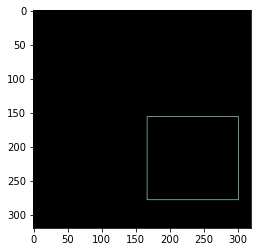

длина 487.3137083053589
длина 529.6568541526794
длина 501.65685415267944
длина 517.6568541526794
длина 507.3137083053589
длина 512.0
длина 487.3137083053589
длина 529.6568541526794
длина 499.3137083053589
длина 517.6568541526794
длина 501.65685415267944
длина 515.3137083053589
длина 507.3137083053589
длина 512.0
длина 488.97056245803833
длина 528.0
длина 501.65685415267944
длина 517.6568541526794
длина 504.9705619812012
длина 512.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


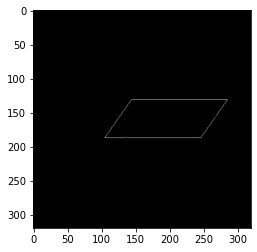

длина 394.6518008708954
длина 440.30865478515625
длина 839.7888824939728
длина 210.0
длина 58.82842707633972
длина 280.8284270763397
длина 394.6518008708954
длина 440.30865478515625
длина 839.7888824939728
длина 210.0
длина 58.82842707633972
длина 280.8284270763397
длина 393.4802279472351
длина 441.137081861496
длина 847.5046141147614
длина 3.414213538169861
длина 3.414213538169861
itogo 1


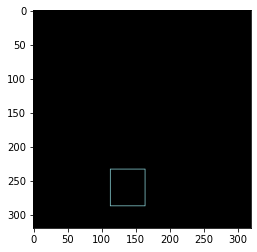

длина 186.97056245803833
длина 226.0
длина 199.65685415267944
длина 215.65685415267944
длина 205.3137083053589
длина 210.0
длина 186.97056245803833
длина 226.0
длина 197.3137083053589
длина 215.65685415267944
длина 199.65685415267944
длина 213.3137083053589
длина 205.3137083053589
длина 210.0
длина 83.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 183.65685415267944
длина 83.65685415267944
длина 229.3137083053589
длина 197.3137083053589
длина 215.65685415267944
длина 199.65685415267944
длина 213.3137083053589
длина 205.3137083053589
длина 210.0
itogo 1


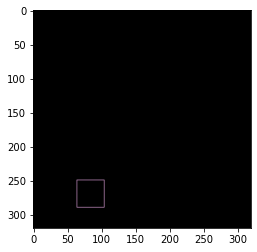

длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 133.65685415267944
длина 61.65685415267944
длина 179.3137083053589
длина 149.65685415267944
длина 165.65685415267944
длина 152.97056198120117
длина 160.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 135.3137083053589
длина 177.65685415267944
длина 149.65685415267944
длина 165.65685415267944
длина 155.3137083053589
длина 160.0
длина 136.97056245803833
длина 176.0
длина 149.65685415267944
длина 165.65685415267944
длина 152.97056198120117
длина 160.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


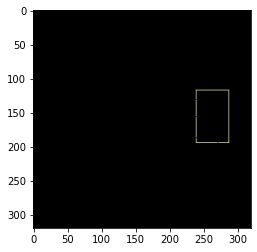

длина 226.1421353816986
длина 269.3137083053589
длина 237.3137083053589
длина 255.65685415267944
длина 242.97056245803833
длина 256.6274166107178
длина 68.82842707633972
длина 54.0
длина 42.0
длина 298.48528122901917
длина 226.97056245803833
длина 266.0
длина 237.3137083053589
длина 255.65685415267944
длина 242.97056245803833
длина 256.6274166107178
длина 68.82842707633972
длина 54.0
длина 42.0
длина 298.48528122901917
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 230.28427076339722
длина 269.3137083053589
длина 242.97056245803833
длина 258.97056245803833
длина 64.82842707633972
длина 50.0
длина 38.0
длина 294.48528122901917
itogo 2


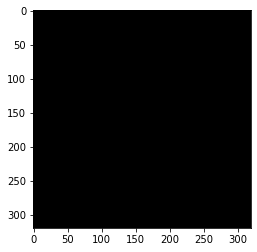

itogo 2
train_data/86.png


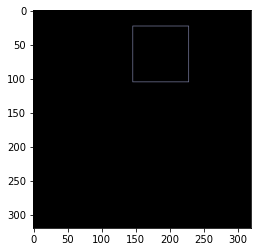

длина 303.3137083053589
длина 345.65685415267944
длина 317.65685415267944
длина 331.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 303.3137083053589
длина 345.65685415267944
длина 317.65685415267944
длина 331.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 304.97056245803833
длина 344.0
длина 317.65685415267944
длина 333.65685415267944
длина 323.3137083053589
длина 328.0
itogo 1


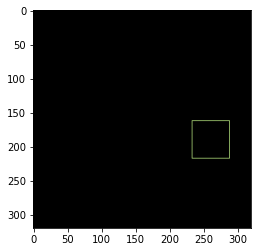

длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 212.97056198120117
длина 220.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 196.97056245803833
длина 236.0
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 91.65685415267944
длина 91.65685415267944
длина 91.65685415267944
длина 193.65685415267944
длина 91.65685415267944
длина 239.3137083053589
длина 209.65685415267944
длина 225.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 2


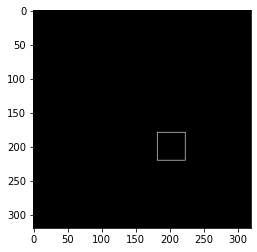

длина 139.3137083053589
длина 181.65685415267944
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 139.3137083053589
длина 181.65685415267944
длина 151.3137083053589
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
длина 140.97056245803833
длина 180.0
длина 153.65685415267944
длина 169.65685415267944
длина 153.65685415267944
длина 167.3137083053589
длина 159.3137083053589
длина 164.0
itogo 3


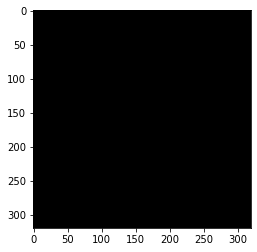

itogo 3
train_data/87.png


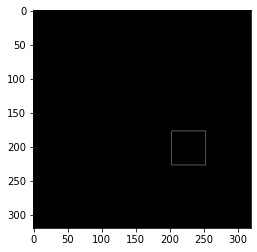

длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 173.65685415267944
длина 81.65685415267944
длина 219.3137083053589
длина 189.65685415267944
длина 203.3137083053589
длина 175.3137083053589
длина 217.65685415267944
длина 189.65685415267944
длина 203.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 176.97056245803833
длина 216.0
длина 189.65685415267944
длина 203.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 1


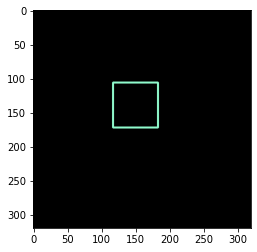

длина 125.65685415267944
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 283.3137083053589
длина 245.65685415267944
длина 275.3137083053589
длина 251.3137083053589
длина 269.65685415267944
длина 253.65685415267944
длина 269.65685415267944
длина 256.9705619812012
длина 264.0
длина 125.65685415267944
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 283.3137083053589
длина 243.3137083053589
длина 277.65685415267944
длина 245.65685415267944
длина 275.3137083053589
длина 248.97056198120117
длина 272.0
длина 251.3137083053589
длина 269.65685415267944
длина 251.3137083053589
длина 269.65685415267944
длина 253.65685415267944
длина 267.3137083053589
длина 256.9705619812012
длина 264.0
длина 259.3137083053589
длина 261.65685415267944
длина 125.65685415267944
длина 237.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 125.65685415267944
длина 283.3137083053589
дл

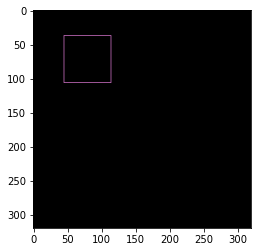

длина 252.97056245803833
длина 292.0
длина 263.3137083053589
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
длина 251.3137083053589
длина 293.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 119.65685415267944
длина 119.65685415267944
длина 119.65685415267944
длина 249.65685415267944
длина 119.65685415267944
длина 295.3137083053589
длина 263.3137083053589
длина 281.65685415267944
длина 265.65685415267944
длина 279.3137083053589
длина 271.3137083053589
длина 276.0
itogo 3


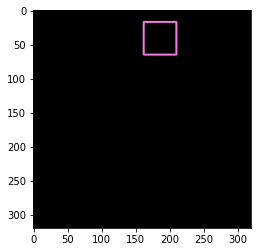

длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 211.3137083053589
длина 171.3137083053589
длина 205.65685415267944
длина 173.65685415267944
длина 203.3137083053589
длина 176.97056198120117
длина 200.0
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 184.97056198120117
длина 192.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 211.3137083053589
длина 173.65685415267944
длина 203.3137083053589
длина 179.3137083053589
длина 197.65685415267944
длина 181.65685415267944
длина 195.3137083053589
длина 187.3137083053589
длина 189.65685415267944
длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.656854152679

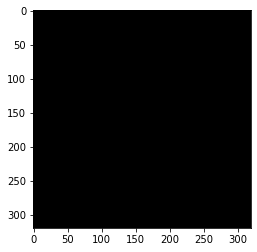

itogo 4
train_data/88.png


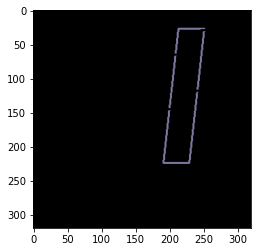

длина 69.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
дл

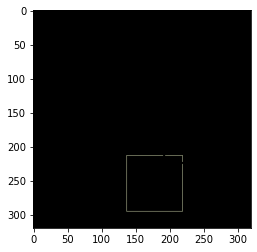

длина 306.6274166107178
длина 345.65685415267944
длина 68.48528122901917
длина 570.1421353816986
длина 58.82842707633972
длина 560.4852812290192
длина 145.65685415267944
длина 121.65685415267944
длина 145.65685415267944
длина 304.1421353816986
длина 33.65685415267944
длина 89.65685415267944
длина 349.79898953437805
длина 68.48528122901917
длина 570.1421353816986
длина 62.82842707633972
длина 564.4852812290192
длина 304.1421353816986
длина 346.48528122901917
длина 67.89949476718903
длина 568.3847759962082
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 1


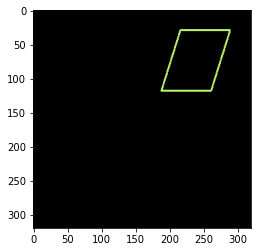

длина 141.65685415267944
длина 7.656854152679443
длина 319.1959581375122
длина 5.656854152679443
длина 141.65685415267944
длина 364.2670258283615
длина 327.1959581375122
длина 357.6812393665314
длина 327.1959581375122
длина 356.2670258283615
длина 332.85281229019165
длина 352.02438521385193
длина 335.1959581375122
длина 350.02438521385193
длина 336.85281229019165
длина 345.78174459934235
длина 0.0
длина 150.48528122901917
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 149.65685415267944
длина 141.65685415267944
длина 7.656854152679443
длина 319.1959581375122
длина 5.656854152679443
дл

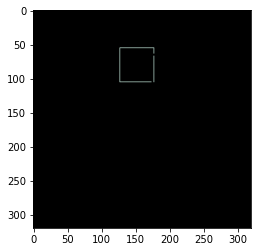

длина 178.3847759962082
длина 218.48528122901917
длина 80.0
длина 308.48528122901917
длина 72.0
длина 298.7279214859009
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 177.55634891986847
длина 217.65685415267944
длина 81.65685415267944
длина 308.3847759962082
длина 77.65685415267944
длина 304.3847759962082
длина 72.0
длина 300.48528122901917
длина 75.65685415267944
длина 61.65685415267944
длина 81.65685415267944
длина 176.72792184352875
длина 81.65685415267944
длина 220.1421353816986
длина 80.0
длина 308.48528122901917
длина 77.65685415267944
длина 304.3847759962082
длина 68.0
длина 296.48528122901917
itogo 2


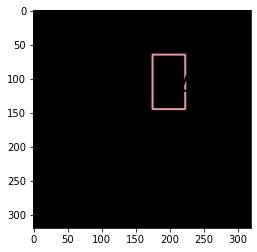

длина 89.65685415267944
длина 43.65685415267944
длина 7.656854152679443
длина 5.656854152679443
длина 231.89949476718903
длина 53.65685415267944
длина 153.65685415267944
длина 89.65685415267944
длина 277.55634891986847
длина 32.485281229019165
длина 473.4558436870575
длина 29.313708305358887
длина 470.2842707633972
длина 24.82842707633972
длина 463.45584321022034
длина 21.41421353816986
длина 462.3847759962082
длина 18.242640614509583
длина 459.2132030725479
длина 13.656854152679443
длина 454.6274166107178
длина 8.0
длина 451.3137083053589
длина 89.65685415267944
длина 43.65685415267944
длина 7.656854152679443
длина 5.656854152679443
длина 233.55634891986847
длина 53.65685415267944
длина 153.65685415267944
длина 89.65685415267944
длина 279.2132030725479
длина 30.485281229019165
длина 471.4558436870575
длина 24.82842707633972
длина 463.45584321022034
длина 19.656854152679443
длина 460.6274166107178
длина 12.0
длина 452.97056245803833
длина 4.0
длина 444.97056245803833
длина 89.656854152

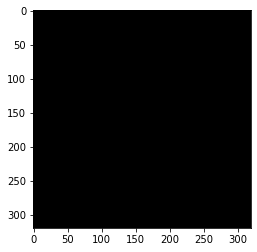

itogo 2
train_data/89.png


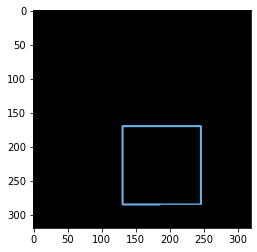

длина 105.65685415267944
длина 433.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 478.72792184352875
длина 441.65685415267944
длина 470.72792184352875
длина 447.3137083053589
длина 465.0710676908493
длина 794.1421350240707
длина 105.65685415267944
длина 433.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 478.72792184352875
длина 441.65685415267944
длина 471.3137083053589
длина 441.65685415267944
длина 470.72792184352875
длина 447.3137083053589
длина 465.65685415267944
длина 449.65685415267944
длина 463.3137083053589
длина 795.5563485622406
длина 786.7279218435287
длина 105.65685415267944
длина 433.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 223.65685415267944
длина 478.72792184352875
длина 439.3137083053589
длина 473.0710676908493
длина 441.65685415267944
длина 470.72792184352875
длина 444.9705619812012
длина 465.65685415267944
длина 447.3137083053589
длина 465.65

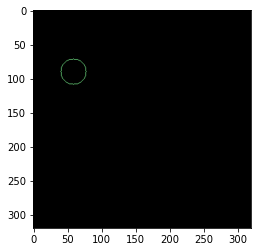

длина 102.22539710998535
длина 142.22539520263672
длина 120.56854152679443
длина 123.88224983215332
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168689727783
длина 129.53910541534424
длина 120.56854152679443
длина 123.88224983215332
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 102.22539710998535
длина 142.22539520263672
длина 118.22539710998535
длина 126.22539615631104
itogo 1


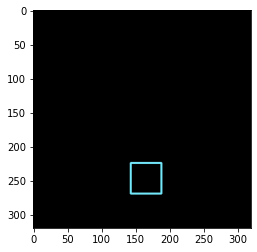

длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 161.65685415267944
длина 191.3137083053589
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3137083053589
длина 159.3137083053589
длина 193.65685415267944
длина 161.65685415267944
длина 191.3137083053589
длина 164.97056198120117
длина 185.65685415267944
длина 167.3137083053589
длина 185.65685415267944
длина 169.65685415267944
длина 183.3137083053589
длина 169.65685415267944
длина 183.3137083053589
длина 175.3137083053589
длина 180.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 83.65685415267944
длина 153.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 83.65685415267944
длина 199.3

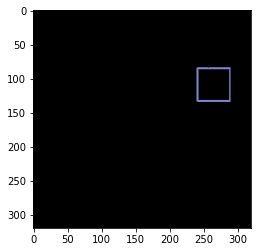

длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 209.3137083053589
длина 173.65685415267944
длина 202.48528122901917
длина 179.3137083053589
длина 196.82842707633972
длина 181.65685415267944
длина 195.3137083053589
длина 59.41421353816986
длина 215.89949476718903
длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 209.3137083053589
длина 173.65685415267944
длина 202.48528122901917
длина 179.3137083053589
длина 196.82842707633972
длина 181.65685415267944
длина 195.3137083053589
длина 283.3137080669403
длина 89.65685415267944
длина 165.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 209.3137083053589
длина 173.65685415267944
длина 202.48528122901917
длина 173.65685415267944
длина 202.1421353816986
длина 179.3137083053589
длина 196.82842707633972
длина 179.3137083053589
длина 195.65685415267944
длина 288.6274166107178
длина 61.41421353816986
длина 217.8994945287704

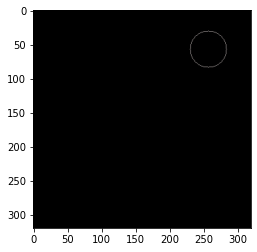

длина 156.8528127670288
длина 194.50966548919678
длина 172.85281085968018
длина 180.85281133651733
длина 156.8528127670288
длина 194.50966548919678
длина 172.85281085968018
длина 180.85281133651733
длина 156.8528127670288
длина 194.50966548919678
длина 172.85281085968018
длина 180.85281133651733
itogo 3


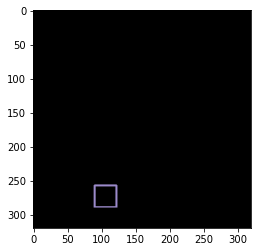

длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 145.3137083053589
длина 109.65685415267944
длина 138.48528122901917
длина 112.97056198120117
длина 132.82842707633972
длина 115.31370830535889
длина 131.65685415267944
длина 190.1421353816986
длина 184.48528122901917
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 145.3137083053589
длина 109.65685415267944
длина 138.48528122901917
длина 115.31370830535889
длина 132.82842707633972
длина 117.65685415267944
длина 130.48528122901917
длина 187.3137080669403
длина 101.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 145.3137083053589
длина 109.65685415267944
длина 138.48528122901917
длина 109.65685415267944
длина 137.3137083053589
длина 115.31370830535889
длина 132.82842707633972
длина 115.31370830535889
длина 131.65685415267944
длина 191.79898953437805
длина 187.3137080669403
itogo 4


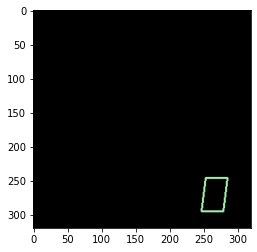

длина 57.65685415267944
длина 5.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 140.62741661071777
длина 5.656854152679443
длина 57.65685415267944
длина 186.28427076339722
длина 148.62741661071777
длина 178.28427076339722
длина 150.28427052497864
длина 174.97056245803833
длина 154.28427076339722
длина 172.62741661071777
длина 156.62741661071777
длина 170.28427076339722
длина 72.48528122901917
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 10.0
длина 72.48528122901917
длина 57.65685415267944
длина 5.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.65685415267944

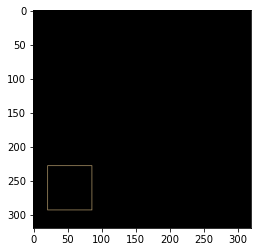

длина 236.97056245803833
длина 276.0
длина 249.65685415267944
длина 265.65685415267944
длина 252.97056198120117
длина 260.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 111.65685415267944
длина 111.65685415267944
длина 111.65685415267944
длина 233.65685415267944
длина 111.65685415267944
длина 279.3137083053589
длина 249.65685415267944
длина 265.65685415267944
длина 255.3137083053589
длина 260.0
длина 111.65685415267944
длина 111.65685415267944
длина 115.65685415267944
длина 233.65685415267944
длина 115.65685415267944
длина 279.3137083053589
длина 249.65685415267944
длина 263.3137083053589
itogo 5


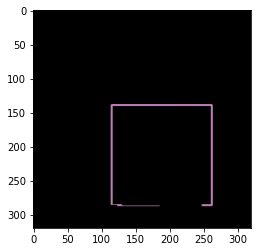

длина 23.656854152679443
длина 7.656854152679443
длина 287.65685415267944
длина 285.65685415267944
длина 287.65685415267944
длина 1059.4558436870575
длина 1050.8700572252274
длина 1047.9411249160767
длина 19.656854152679443
длина 908.1421353816986
длина 16.82842707633972
длина 904.9705624580383
длина 10.0
длина 902.1421353816986
длина 6.0
длина 898.7279218435287
длина 23.656854152679443
длина 7.656854152679443
длина 287.65685415267944
длина 285.65685415267944
длина 287.65685415267944
длина 1059.4558436870575
длина 1048.8700572252274
длина 19.656854152679443
длина 908.9705624580383
длина 12.828427076339722
длина 904.3847759962082
длина 6.0
длина 898.7279218435287
длина 23.656854152679443
длина 7.656854152679443
длина 287.65685415267944
длина 285.65685415267944
длина 287.65685415267944
длина 1059.4558436870575
длина 1050.8700572252274
длина 1047.698484301567
длина 19.656854152679443
длина 908.1421353816986
длина 15.656854152679443
длина 904.9705624580383
длина 10.0
длина 898.727921485900

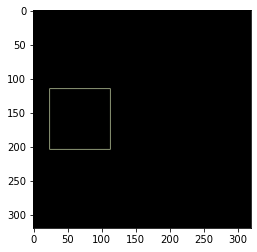

длина 159.65685415267944
длина 159.65685415267944
длина 159.65685415267944
длина 329.65685415267944
длина 159.65685415267944
длина 375.3137083053589
длина 345.65685415267944
длина 361.65685415267944
длина 348.9705619812012
длина 356.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 331.3137083053589
длина 373.65685415267944
длина 343.3137083053589
длина 361.65685415267944
длина 345.65685415267944
длина 359.3137083053589
длина 351.3137083053589
длина 356.0
длина 331.3137083053589
длина 373.65685415267944
длина 345.65685415267944
длина 361.65685415267944
длина 351.3137083053589
длина 356.0
itogo 7


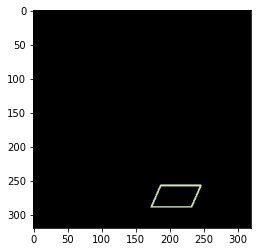

длина 162.76955199241638
длина 5.656854152679443
длина 113.65685415267944
длина 209.8406196832657
длина 170.76955199241638
длина 204.08326017856598
длина 173.5979790687561
длина 201.25483310222626
длина 177.5979790687561
длина 197.8406196832657
длина 179.25483298301697
длина 195.5979790687561
длина 181.5979790687561
длина 193.8406196832657
длина 14.485281229019165
длина 14.242640614509583
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 145.79898953437805
длина 2.0
длина 116.82842707633972
длина 162.76955199241638
длина 5.656854152679443
длина 113.65685415267944
длина 209.8406196832657
длина 170.76955199241638
длина 205.25483322143555
длина 173.5979790687561
длина 201.8406196832657
длина 176.42640614509583
длина 198.42640614509583
длина 177.59797883033752
длина 196.18376553058624
длина 181.5979790687561
длина 193.8406195640564
длина 264.61017167568207
длина 5.414213538169861
длина 121.65685415267944
длина 0.0
длина 162.7695519924

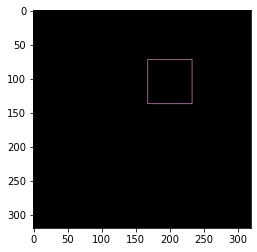

длина 235.3137083053589
длина 277.65685415267944
длина 249.65685415267944
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 255.3137083053589
длина 260.0
длина 235.3137083053589
длина 277.65685415267944
длина 249.65685415267944
длина 265.65685415267944
длина 255.3137083053589
длина 260.0
длина 236.97056245803833
длина 276.0
длина 249.65685415267944
длина 265.65685415267944
длина 252.97056198120117
длина 260.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 8


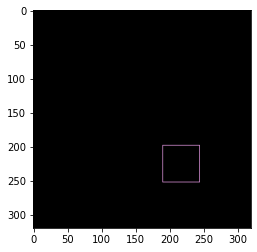

длина 191.3137083053589
длина 233.65685415267944
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 211.3137083053589
длина 216.0
длина 191.3137083053589
длина 233.65685415267944
длина 205.65685415267944
длина 221.65685415267944
длина 211.3137083053589
длина 216.0
длина 89.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 189.65685415267944
длина 89.65685415267944
длина 235.3137083053589
длина 203.3137083053589
длина 221.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 211.3137083053589
длина 216.0
itogo 9


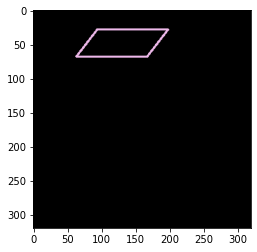

длина 203.65685415267944
длина 5.656854152679443
длина 278.36753034591675
длина 5.656854152679443
длина 203.65685415267944
длина 332.5096654891968
длина 285.1959569454193
длина 328.5096650123596
длина 289.1959571838379
длина 324.5096652507782
длина 290.85281109809875
длина 322.8528108596802
длина 294.85281133651733
длина 320.5096650123596
длина 296.02438402175903
длина 318.85281109809875
длина 297.1959571838379
длина 316.5096652507782
длина 301.6812381744385
длина 314.8528108596802
длина 6.828427076339722
длина 2.8284270763397217
длина 17.899494767189026
длина 5.656854152679443
длина 5.656854152679443
длина 2.8284270763397217
длина 2.8284270763397217
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 2.8284270763397217
длина 2.8284270763397217
длина 5.656854152679443
длина 5.656854152679443
длина 2.8284270763397217
длина 17.899494767189026
длина 6.828427076339722
длина 203.65685415267944
длина 5.656854152679443
длина 278.36753034591675

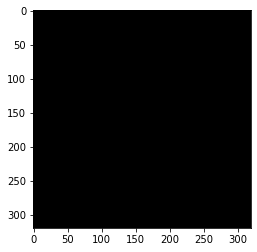

itogo 9
train_data/90.png


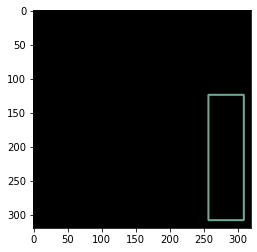

длина 97.65685415267944
длина 445.65685415267944
длина 361.65685415267944
длина 361.65685415267944
длина 97.65685415267944
длина 491.3137083053589
длина 453.65685415267944
длина 483.3137083053589
длина 459.3137083053589
длина 477.65685415267944
длина 464.9705619812012
длина 472.0
длина 97.65685415267944
длина 445.65685415267944
длина 361.65685415267944
длина 361.65685415267944
длина 97.65685415267944
длина 491.3137083053589
длина 453.65685415267944
длина 483.3137083053589
длина 453.65685415267944
длина 483.3137083053589
длина 459.3137083053589
длина 477.65685415267944
длина 461.65685415267944
длина 475.3137083053589
длина 464.9705619812012
длина 472.0
длина 97.65685415267944
длина 445.65685415267944
длина 361.65685415267944
длина 361.65685415267944
длина 97.65685415267944
длина 491.3137083053589
длина 453.65685415267944
длина 483.3137083053589
длина 459.3137083053589
длина 477.65685415267944
длина 461.65685415267944
длина 477.65685415267944
длина 464.9705619812012
длина 472.0
длина 6.2

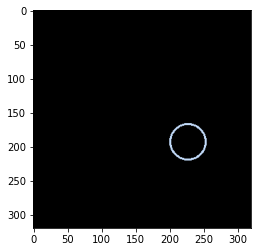

длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 151.1959571838379
длина 17.656854152679443
длина 192.16652297973633
длина 156.85281372070312
длина 186.5096664428711
длина 159.1959571838379
длина 184.16652059555054
длина 164.85281085968018
длина 178.50966787338257
длина 164.8528118133545
длина 178.50966691970825
длина 167.1959571838379
длина 176.16652154922485
длина 170.50966453552246
длина 172.85281229019165
длина 17.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 151.1959571838379
длина 17.656854152679443
длина 192.16652297973633
длина 156.8528118133545
длина 186.50966691970825
длина 159.1959571838379
длина 184.16652154922485
длина 162.5096664428711
длина 180.85281229019165
длина 164.8528118133545
длина 178.50966691970825
длина 164.85281372070312
длина 178.5096664428711
длина 170.50966548919678
длина 172.85281324386597
длина 22.82842707633972
длина 0.0
длина 0.0
длина 0.0
длина 8.242640614509583
длина 5.656854152679443
длина 8.2

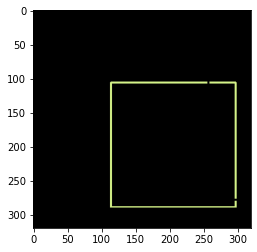

длина 11.656854152679443
длина 705.6568541526794
длина 333.65685415267944
длина 359.65685415267944
длина 69.65685415267944
длина 275.65685415267944
длина 749.3137083053589
длина 423.899494767189
длина 1035.5563489198685
длина 421.55634891986847
длина 1032.0416301488876
длина 418.2426406145096
длина 1029.899494767189
длина 415.899494767189
длина 1026.3847759962082
длина 414.2426406145096
длина 1025.899494767189
длина 15.41421353816986
длина 410.2426404953003
длина 643.6568540334702
длина 12.0
длина 406.2426406145096
длина 640.2426406145096
длина 11.656854152679443
длина 705.6568541526794
длина 333.65685415267944
длина 359.65685415267944
длина 69.65685415267944
длина 275.65685415267944
длина 749.3137083053589
длина 714.6274166107178
длина 746.9705624580383
длина 421.55634891986847
длина 1032.0416301488876
длина 418.2426404953003
длина 1028.7279214859009
длина 418.2426406145096
длина 1029.899494767189
длина 416.48528122901917
длина 1028.1421353816986
длина 22.242640614509583
длина 414.242

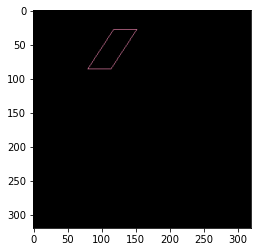

длина 183.82337474822998
длина 229.48022890090942
длина 200.6518018245697
длина 221.1370828151703
длина 204.6518018245697
длина 217.1370828151703
длина 66.82842707633972
длина 66.82842707633972
длина 0.0
длина 0.0
длина 51.65685415267944
длина 182.99494767189026
длина 51.65685415267944
длина 230.30865597724915
длина 204.6518018245697
длина 218.30865597724915
длина 4.0
длина 4.0
длина 183.82337474822998
длина 229.48022890090942
длина 200.65180158615112
длина 219.48022890090942
длина 73.65685415267944
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 73.65685415267944
itogo 1


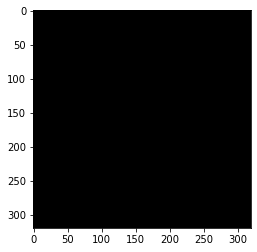

itogo 1
train_data/91.png


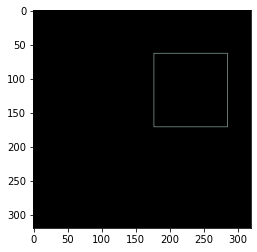

длина 407.3137083053589
длина 449.65685415267944
длина 421.65685415267944
длина 437.65685415267944
длина 427.3137083053589
длина 432.0
длина 197.65685415267944
длина 197.65685415267944
длина 197.65685415267944
длина 405.65685415267944
длина 197.65685415267944
длина 451.3137083053589
длина 421.65685415267944
длина 437.65685415267944
длина 427.3137083053589
длина 432.0
длина 407.3137083053589
длина 449.65685415267944
длина 421.65685415267944
длина 437.65685415267944
длина 427.3137083053589
длина 432.0
itogo 1


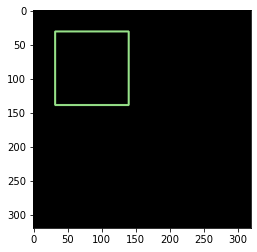

длина 209.65685415267944
длина 405.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 451.3137083053589
длина 413.65685415267944
длина 443.3137083053589
длина 416.9705619812012
длина 437.65685415267944
длина 419.3137083053589
длина 437.65685415267944
длина 424.97056245803833
длина 432.0
длина 427.3137083053589
длина 429.65685415267944
длина 209.65685415267944
длина 405.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 451.3137083053589
длина 411.3137083053589
длина 445.65685415267944
длина 413.65685415267944
длина 443.3137083053589
длина 416.9705619812012
длина 437.65685415267944
длина 419.3137083053589
длина 437.65685415267944
длина 421.65685415267944
длина 435.3137083053589
длина 424.97056245803833
длина 432.0
длина 427.3137083053589
длина 432.0
длина 209.65685415267944
длина 405.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 209.65685415267944
длина 451.3137083053589
дл

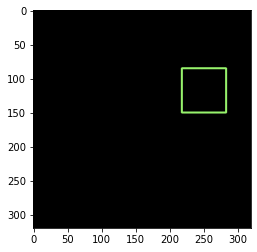

длина 123.65685415267944
длина 233.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 279.3137083053589
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 265.65685415267944
длина 247.3137083053589
длина 265.65685415267944
длина 252.97056245803833
длина 260.0
длина 255.3137083053589
длина 257.65685415267944
длина 123.65685415267944
длина 233.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 123.65685415267944
длина 279.3137083053589
длина 239.3137083053589
длина 273.65685415267944
длина 241.65685415267944
длина 271.3137083053589
длина 244.97056198120117
длина 268.0
длина 247.3137083053589
длина 265.65685415267944
длина 249.65685415267944
длина 265.65685415267944
длина 249.65685415267944
длина 263.3137083053589
длина 252.97056198120117
длина 260.0
длина 255.3137083053589
длина 257.65685415267944
длина 123.65685415267944
длина 233.65685415267944
длина 123.65685415267944
длина 123.65685415267944

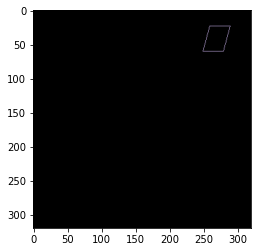

длина 41.65685415267944
длина 114.28427076339722
длина 43.65685415267944
длина 158.76955199241638
длина 130.28427076339722
длина 147.94112491607666
длина 2.0
длина 67.65685415267944
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 67.65685415267944
длина 115.11269783973694
длина 157.94112491607666
длина 130.28427076339722
длина 145.11269783973694
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 115.11269783973694
длина 157.94112491607666
длина 129.11269783973694
длина 147.94112491607666
длина 134.7695517539978
длина 142.28427076339722
длина 0.0
длина 0.0
itogo 4


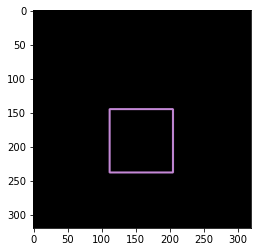

длина 179.65685415267944
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 391.3137083053589
длина 353.65685415267944
длина 383.3137083053589
длина 353.65685415267944
длина 383.3137083053589
длина 359.3137083053589
длина 377.65685415267944
длина 361.65685415267944
длина 377.65685415267944
длина 361.65685415267944
длина 375.3137083053589
длина 367.3137083053589
длина 372.0
длина 179.65685415267944
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 391.3137083053589
длина 353.65685415267944
длина 383.3137083053589
длина 359.3137083053589
длина 377.65685415267944
длина 361.65685415267944
длина 375.3137083053589
длина 364.9705619812012
длина 372.0
длина 179.65685415267944
длина 345.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 179.65685415267944
длина 391.3137083053589
длина 353.65685415267944
длина 383.3137083053589
длина 353.65685415267944
длина 383.3137

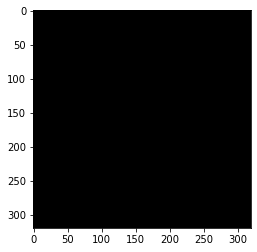

itogo 5
train_data/92.png


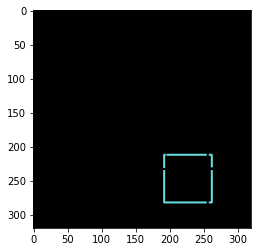

длина 117.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 254.48528122901917
длина 29.656854152679443
длина 31.656854152679443
длина 109.65685415267944
длина 301.79898953437805
длина 107.55634880065918
длина 223.55634891986847
длина 49.55634880065918
длина 169.79898953437805
длина 101.89949464797974
длина 217.89949476718903
длина 43.899494647979736
длина 164.1421353816986
длина 96.2426404953003
длина 212.2426404953003
длина 38.24264049530029
длина 112.0
длина 37.41421353816986
длина 117.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 254.48528122901917
длина 29.656854152679443
длина 31.656854152679443
длина 109.65685415267944
длина 301.79898953437805
длина 110.48528122901917
длина 225.89949476718903
длина 52.485281229019165
длина 170.48528122901917
длина 107.55634880065918
длина 223.55634891986847
длина 49.55634880065918
длина 169.79898953437805
длина 104.24264061450958
длина 220.24264061450958
длина 46.24264061450958
длина 164.24264061450958
д

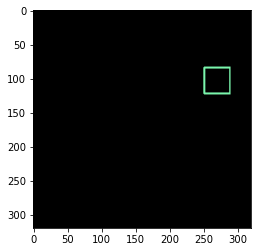

длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 169.3137083053589
длина 133.65685415267944
длина 161.3137083053589
длина 139.3137083053589
длина 156.82842707633972
длина 232.97056245803833
длина 220.48528122901917
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 169.3137083053589
длина 131.3137083053589
длина 163.65685415267944
длина 133.65685415267944
длина 162.48528122901917
длина 136.97056198120117
длина 158.0
длина 139.3137083053589
длина 156.82842707633972
длина 141.65685415267944
длина 155.65685415267944
длина 232.97056245803833
длина 223.3137080669403
длина 220.48528122901917
длина 69.65685415267944
длина 125.65685415267944
длина 69.65685415267944
длина 69.65685415267944
длина 169.3137083053589
длина 133.65685415267944
длина 162.48528122901917
длина 133.65685415267944
длина 161.3137083053589
длина 139.3137083053589
длина 156.82842707633972
длина 141.65685415267944
длина 1

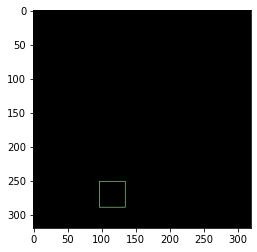

длина 127.31370830535889
длина 169.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 57.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 125.65685415267944
длина 57.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 147.3137083053589
длина 152.0
длина 127.31370830535889
длина 169.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 147.3137083053589
длина 152.0
itogo 3


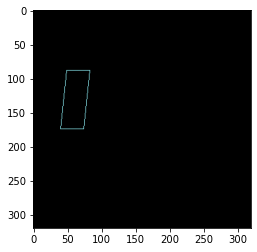

длина 222.76955199241638
длина 263.4558436870575
длина 237.11269783973694
длина 250.76955199241638
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 221.94112491607666
длина 264.2842707633972
длина 234.76955199241638
длина 253.11269783973694
длина 237.11269783973694
длина 250.76955199241638
длина 77.65685415267944
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 77.65685415267944
длина 222.76955199241638
длина 263.4558436870575
длина 234.76955199241638
длина 253.11269783973694
длина 237.11269783973694
длина 250.76955199241638
длина 77.65685415267944
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 12.0
длина 12.0
длина 14.0
длина 14.0
длина 77.65685415267944
itogo 3


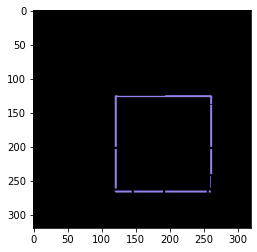

длина 113.65685415267944
длина 77.65685415267944
длина 39.65685415267944
длина 65.65685415267944
длина 107.65685415267944
длина 117.65685415267944
длина 536.7279218435287
длина 17.656854152679443
длина 141.65685415267944
длина 129.65685415267944
длина 579.5563489198685
длина 13.656854152679443
длина 129.65685415267944
длина 93.65685415267944
длина 57.071067690849304
длина 33.65685415267944
длина 81.65685415267944
длина 123.65685415267944
длина 582.9705624580383
длина 8.0
длина 124.0
длина 88.0
длина 51.41421353816986
длина 24.0
длина 76.0
длина 118.0
длина 577.3137083053589
длина 5.656854152679443
длина 121.65685415267944
длина 85.65685415267944
длина 48.82842707633972
длина 73.65685415267944
длина 115.65685415267944
длина 123.65685415267944
длина 450.1421353816986
длина 0.0
длина 116.0
длина 80.0
длина 44.0
длина 68.0
длина 110.0
длина 118.0
длина 152.2426404953003
длина 148.82842707633972
длина 113.65685415267944
длина 77.65685415267944
длина 39.65685415267944
длина 65.65685415267944

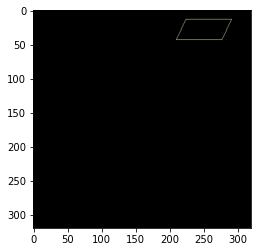

длина 117.65685415267944
длина 174.76955199241638
длина 117.65685415267944
длина 222.08326029777527
длина 193.5979790687561
длина 211.25483322143555
длина 137.65685415267944
длина 0.0
длина 0.0
длина 137.65685415267944
длина 175.5979790687561
длина 221.25483322143555
длина 193.5979790687561
длина 211.25483322143555
длина 199.25483322143555
длина 205.5979790687561
длина 117.65685415267944
длина 174.76955199241638
длина 117.65685415267944
длина 222.08326029777527
длина 193.5979790687561
длина 207.25483322143555
длина 2.0
длина 2.0
itogo 4


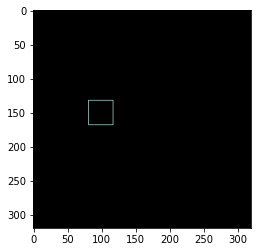

длина 120.97056245803833
длина 160.0
длина 133.65685415267944
длина 149.65685415267944
длина 136.97056198120117
длина 144.0
длина 53.65685415267944
длина 53.65685415267944
длина 53.65685415267944
длина 117.65685415267944
длина 53.65685415267944
длина 163.3137083053589
длина 131.3137083053589
длина 149.65685415267944
длина 133.65685415267944
длина 147.3137083053589
длина 139.3137083053589
длина 144.0
длина 119.31370830535889
длина 161.65685415267944
длина 131.3137083053589
длина 149.65685415267944
длина 133.65685415267944
длина 147.3137083053589
длина 139.3137083053589
длина 144.0
itogo 5


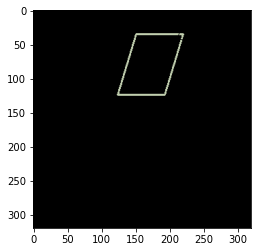

длина 133.65685415267944
длина 7.656854152679443
длина 310.3675310611725
длина 7.656854152679443
длина 5.656854152679443
длина 119.65685415267944
длина 356.02438521385193
длина 318.3675310611725
длина 349.6812393665314
длина 319.1959581375122
длина 349.6812393665314
длина 324.02438521385193
длина 344.02438521385193
длина 668.0487704277039
длина 20.485281229019165
длина 632.735062122345
длина 147.3137083053589
длина 20.485281229019165
длина 20.485281229019165
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 20.485281229019165
длина 20.485281229019165
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 11.656854152679443
длина 20.485281229019165
длина 11.656854152679443
длина 125.65685415267944
длина 0.0
длина 0.0
длина 133.65685415267944
длина 7.656854152679443
длина 310.3675310611725
длина 7.656854152679443
длина 5.656854152679443
длина 119.65685415267944
длина 356.02438521385

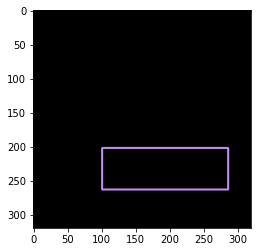

длина 363.65685415267944
длина 465.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 363.65685415267944
длина 511.3137083053589
длина 473.65685415267944
длина 503.3137083053589
длина 473.65685415267944
длина 503.3137083053589
длина 479.3137083053589
длина 497.65685415267944
длина 481.65685415267944
длина 497.65685415267944
длина 481.65685415267944
длина 495.3137083053589
длина 487.3137083053589
длина 492.0
длина 363.65685415267944
длина 465.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 363.65685415267944
длина 511.3137083053589
длина 473.65685415267944
длина 503.3137083053589
длина 479.3137083053589
длина 497.65685415267944
длина 481.65685415267944
длина 495.3137083053589
длина 484.9705619812012
длина 492.0
длина 363.65685415267944
длина 465.65685415267944
длина 115.65685415267944
длина 115.65685415267944
длина 363.65685415267944
длина 511.3137083053589
длина 471.3137083053589
длина 505.65685415267944
длина 473.65685415267944
длина 503.3137

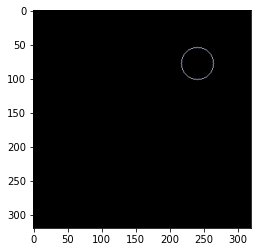

длина 135.1959581375122
длина 175.1959581375122
длина 147.882248878479
длина 162.5096664428711
длина 153.53910446166992
длина 156.85281467437744
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 135.1959581375122
длина 175.1959581375122
длина 147.88224983215332
длина 162.5096664428711
длина 153.53910446166992
длина 156.85281467437744
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 135.1959581375122
длина 175.1959581375122
длина 145.53910541534424
длина 164.8528127670288
длина 151.1959581375122
длина 159.1959571838379
длина 56.97056245803833
длина 56.97056245803833
длина 56.97056245803833
длина 56.97056245803833
itogo 5


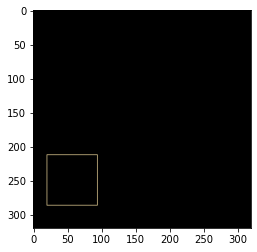

длина 271.3137083053589
длина 313.65685415267944
длина 283.3137083053589
длина 301.65685415267944
длина 285.65685415267944
длина 299.3137083053589
длина 291.3137083053589
длина 296.0
длина 271.3137083053589
длина 313.65685415267944
длина 285.65685415267944
длина 301.65685415267944
длина 285.65685415267944
длина 299.3137083053589
длина 291.3137083053589
длина 296.0
длина 129.65685415267944
длина 129.65685415267944
длина 129.65685415267944
длина 269.65685415267944
длина 129.65685415267944
длина 315.3137083053589
длина 285.65685415267944
длина 301.65685415267944
длина 291.3137083053589
длина 296.0
itogo 6


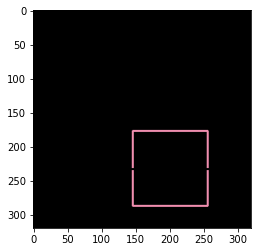

длина 213.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 413.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 213.65685415267944
длина 459.3137083053589
длина 434.1421353816986
длина 442.1421353816986
длина 431.79898953437805
длина 439.79898953437805
длина 428.4852809906006
длина 436.4852809906006
длина 428.48528122901917
длина 436.48528122901917
длина 427.3137083053589
длина 435.3137083053589
длина 422.1421353816986
длина 430.1421353816986
длина 420.4852809906006
длина 428.4852809906006
длина 416.48528122901917
длина 424.48528122901917
длина 213.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 413.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 213.65685415267944
длина 459.3137083053589
длина 434.1421353816986
длина 442.1421353816986
длина 428.48528122901917
длина 436.48528122901917
длина 426.1421353816986
длина 434.1421353816986
длина 420.4852809906006
длина 428.4852809906006
длина 213.656854152679

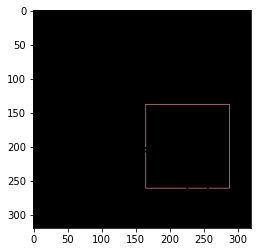

длина 470.6274166107178
длина 512.1421353816986
длина 57.65685415267944
длина 225.89949476718903
длина 7.656854152679443
длина 676.3847759962082
длина 53.65685415267944
длина 221.89949476718903
длина 2.0
длина 672.3847759962082
длина 48.0
длина 216.82842707633972
длина 668.4852812290192
длина 43.65685415267944
длина 37.65685415267944
длина 101.65685415267944
длина 87.65685415267944
длина 227.65685415267944
длина 107.65685415267944
длина 468.1421353816986
длина 227.65685415267944
длина 513.798989534378
длина 53.65685415267944
длина 222.48528122901917
длина 2.0
длина 674.1421353816986
длина 44.0
длина 212.82842707633972
длина 664.4852812290192
длина 468.97056245803833
длина 508.0
длина 53.65685415267944
длина 221.89949476718903
длина 2.0
длина 672.3847759962082
itogo 8


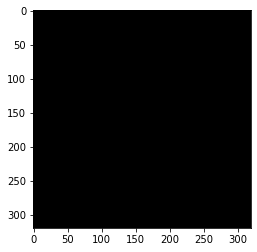

itogo 8
train_data/93.png


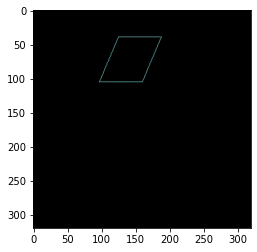

длина 109.65685415267944
длина 250.36753106117249
длина 109.65685415267944
длина 297.6812393665314
длина 270.85281229019165
длина 281.1959581375122
длина 251.1959581375122
длина 296.85281229019165
длина 268.02438497543335
длина 286.85281229019165
длина 273.6812393665314
длина 281.1959581375122
длина 0.0
длина 0.0
длина 251.1959581375122
длина 296.85281229019165
длина 268.02438497543335
длина 286.85281229019165
длина 273.6812393665314
длина 281.1959581375122
длина 0.0
длина 0.0
itogo 0


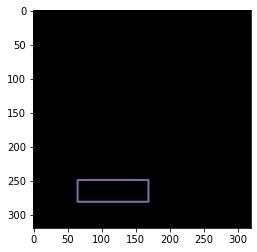

длина 201.65685415267944
длина 245.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 201.65685415267944
длина 291.3137083053589
длина 253.65685415267944
длина 283.3137083053589
длина 259.3137083053589
длина 277.65685415267944
длина 261.65685415267944
длина 275.3137083053589
длина 267.3137083053589
длина 272.0
длина 201.65685415267944
длина 245.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 201.65685415267944
длина 291.3137083053589
длина 253.65685415267944
длина 283.3137083053589
длина 259.3137083053589
длина 277.65685415267944
длина 264.9705619812012
длина 272.0
длина 201.65685415267944
длина 245.65685415267944
длина 57.65685415267944
длина 57.65685415267944
длина 201.65685415267944
длина 291.3137083053589
длина 253.65685415267944
длина 283.3137083053589
длина 253.65685415267944
длина 283.3137083053589
длина 259.3137083053589
длина 277.65685415267944
длина 261.65685415267944
длина 275.3137083053589
длина 264.9705619812012
длина 272.0
длина 2.82

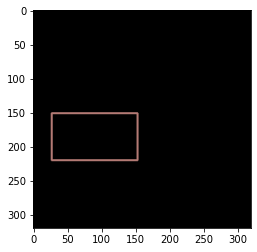

длина 245.65685415267944
длина 363.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 245.65685415267944
длина 409.3137083053589
длина 371.65685415267944
длина 401.3137083053589
длина 371.65685415267944
длина 401.3137083053589
длина 377.3137083053589
длина 395.65685415267944
длина 379.65685415267944
длина 393.3137083053589
длина 382.9705619812012
длина 390.0
длина 385.3137083053589
длина 387.65685415267944
длина 245.65685415267944
длина 363.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 245.65685415267944
длина 409.3137083053589
длина 371.65685415267944
длина 401.3137083053589
длина 377.3137083053589
длина 395.65685415267944
длина 379.65685415267944
длина 393.3137083053589
длина 385.3137083053589
длина 387.65685415267944
длина 245.65685415267944
длина 363.65685415267944
длина 131.65685415267944
длина 131.65685415267944
длина 245.65685415267944
длина 409.3137083053589
длина 371.65685415267944
длина 401.3137083053589
длина 377.3137083053589
дли

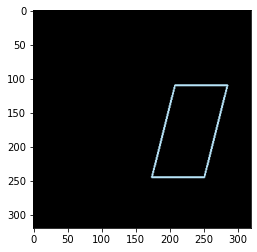

длина 149.65685415267944
длина 424.16652059555054
длина 149.65685415267944
длина 469.82337474823
длина 432.16652059555054
длина 463.4802289009094
длина 432.16652059555054
длина 461.82337474823
длина 437.82337474823
длина 457.82337474823
длина 440.16652059555054
длина 453.82337474823
длина 444.6518015861511
длина 452.16652059555054
длина 151.41421353816986
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 151.41421353816986
длина 149.65685415267944
длина 424.16652059555054
длина 149.65685415267944
длина 469.82337474823
длина 430.9949476718

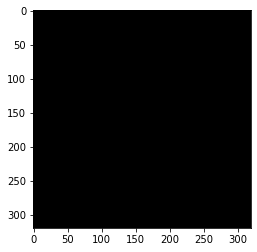

itogo 0
train_data/94.png


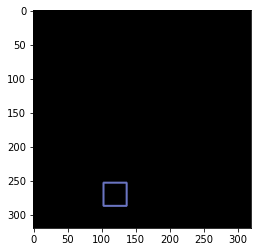

длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 128.97056198120117
длина 136.0
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 139.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 61.65685415267944
длина 109.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 155.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 117.65685415267944
длина 147.3137083053589
длина 123.31370830535889
длина 141.65685415267944
длина 125.65685415267944
длина 14

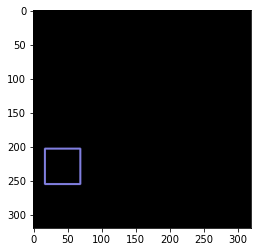

длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 208.0
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 189.65685415267944
длина 219.3137083053589
длина 195.3137083053589
длина 213.65685415267944
длина 197.65685415267944
длина 211.3137083053589
длина 203.3137083053589
длина 205.65685415267944
длина 97.65685415267944
длина 181.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 97.65685415267944
длина 227.3137083053589
длина 187.3137083053589
длина 221.65685415267944
длина 189.65685415267944
длина 219.3137083053589
длина 192.97056198120117
длина 213.65685415267944
длина 195.3137083053589
длина 213.6568

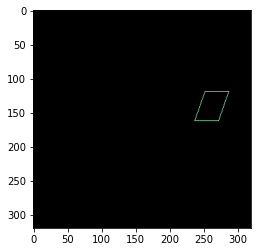

длина 141.25483322143555
длина 184.08326029777527
длина 156.42640614509583
длина 171.25483322143555
длина 0.0
длина 3.414213538169861
длина 3.414213538169861
длина 0.0
длина 142.08326029777527
длина 183.25483322143555
длина 155.25483322143555
длина 174.08326029777527
длина 156.42640614509583
длина 170.08326029777527
длина 162.08326029777527
длина 168.42640614509583
длина 2.0
длина 2.0
длина 141.25483322143555
длина 184.08326029777527
длина 155.25483322143555
длина 174.08326029777527
длина 160.9116871356964
длина 168.42640614509583
длина 0.0
длина 0.0
itogo 2


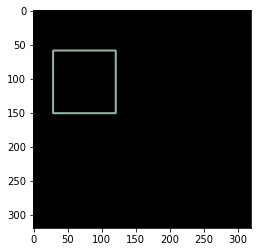

длина 177.65685415267944
длина 341.65685415267944
длина 177.65685415267944
длина 177.65685415267944
длина 177.65685415267944
длина 387.3137083053589
длина 349.65685415267944
длина 379.3137083053589
длина 355.3137083053589
длина 373.65685415267944
длина 357.65685415267944
длина 373.65685415267944
длина 360.9705619812012
длина 368.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 177.65685415267944
длина 341.65685415267944
длина 177.65685415267944
длина 177.65685415267944
длина 177.65685415267944
длина 387.3137083053589
длина 349.65685415267944
длина 379.3137083053589
длина 349.65685415267944
длина 379.3137083053589
длина 355.3137083053589
длина 373.65685415267944
длина 357.65685415267944
длина 371.3137083053589
длина 360.9705619812012
длина 368.0
длина 363.3137083053589
длина 365.65685415267944
длина 177.65685415267944
длина 341.65685415267944
длина 177.65685415267944
длина 177.65685415267944
длина 177.65685415267944
длина 387.31

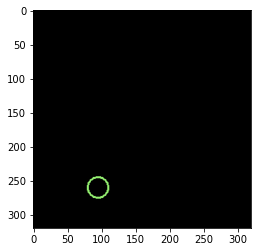

длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152679443
длина 120.56854152679443
длина 87.5979790687561
длина 112.56854057312012
длина 90.91168785095215
длина 106.91168785095215
длина 93.25483322143555
длина 106.91168642044067
длина 98.91168737411499
длина 101.25483322143555
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 11.656854152679443
длина 11.656854152679443
длина 11.656854152679443
длина 77.25483322143555
длина 11.656854152679443
длина 120.56854152679443
длина 85.25483322143555
длина 114.91168642044067
длина 87.5979790687561
длина 112.56854057312012
длина 90.91168689727783
длина 109.25483226776123
длина 93.25483322143555
длина 106.91168642044067
длина 93.25483322143555
длина 106.91168642044067
длина 93.25483226776123
длина 104.56854057312012
длина 98.91168689727783
длина 101.25483226776123
длина 8.0
длина 2.0
длина 0.0
длина 2.0
длина 2.0
длина 8.0
длина 8.0
длина 0.0
длина 0.0
длина 2.0
длина 0.0
длина 8.0
длина

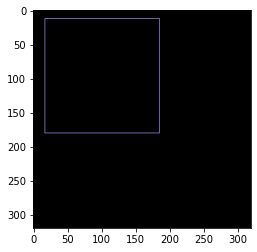

длина 648.9705624580383
длина 688.0
длина 661.6568541526794
длина 677.6568541526794
длина 667.3137083053589
длина 672.0
длина 647.3137083053589
длина 689.6568541526794
длина 661.6568541526794
длина 677.6568541526794
длина 667.3137083053589
длина 672.0
длина 647.3137083053589
длина 689.6568541526794
длина 659.3137083053589
длина 677.6568541526794
длина 661.6568541526794
длина 675.3137083053589
длина 667.3137083053589
длина 672.0
itogo 4


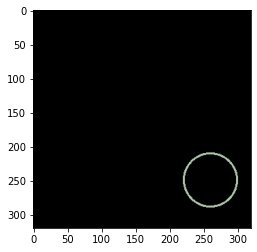

длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 236.45079135894775
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 279.76449966430664
длина 244.45079135894775
длина 271.76449966430664
длина 246.20815014839172
длина 271.76449966430664
длина 251.27921795845032
длина 266.10764598846436
длина 251.86500597000122
длина 266.1076452732086
длина 257.52185809612274
длина 260.45079135894775
длина 14.142135620117188
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 236.45079135894775
длина 5.656854152679443
длина 5.656854152679443
длина 21.656854152679443
длина 279.764499664

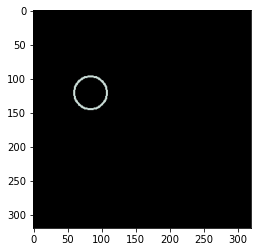

длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 137.5391025543213
длина 5.656854152679443
длина 5.656854152679443
длина 13.656854152679443
длина 180.8528118133545
длина 143.1959581375122
длина 173.43859958648682
длина 145.53910541534424
длина 172.26702535152435
длина 151.1959581375122
длина 167.19595742225647
длина 151.1959571838379
длина 166.61017179489136
длина 153.5391035079956
длина 164.8528118133545
длина 156.85281372070312
длина 160.95331704616547
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 5.656854152679443
длина 2.8284270763397217
длина 2.8284270763397217
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.6568541526

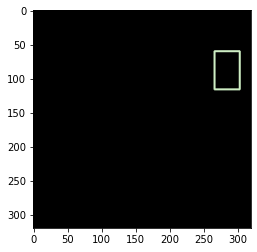

длина 67.65685415267944
длина 159.65685415267944
длина 105.65685415267944
длина 105.65685415267944
длина 67.65685415267944
длина 205.3137083053589
длина 167.65685415267944
длина 197.3137083053589
длина 167.65685415267944
длина 197.3137083053589
длина 173.3137083053589
длина 191.65685415267944
длина 173.3137083053589
длина 191.65685415267944
длина 175.65685415267944
длина 189.3137083053589
длина 178.97056198120117
длина 186.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 67.65685415267944
длина 159.65685415267944
длина 105.65685415267944
длина 105.65685415267944
длина 67.65685415267944
длина 205.3137083053589
длина 165.3137083053589
длина 199.65685415267944
длина 167.65685415267944
длина 197.3137083053589
длина 170.97056198120117
длина 194.0
длина 173.3137083053589
длина 191.65685415267944
длина 175.65685415267944
длина 191.65685415267944
длина 175.65685415267944
длина 189.3137083053589
длина 178.97056198120117
длина 186.0
длин

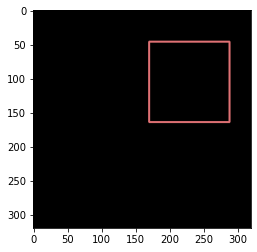

длина 229.65685415267944
длина 445.65685415267944
длина 229.65685415267944
длина 229.65685415267944
длина 229.65685415267944
длина 491.3137083053589
длина 451.3137083053589
длина 485.65685415267944
длина 453.65685415267944
длина 483.3137083053589
длина 456.9705619812012
длина 477.65685415267944
длина 459.3137083053589
длина 477.65685415267944
длина 461.65685415267944
длина 475.3137083053589
длина 464.97056245803833
длина 472.0
длина 467.3137083053589
длина 469.65685415267944
длина 229.65685415267944
длина 445.65685415267944
длина 229.65685415267944
длина 229.65685415267944
длина 229.65685415267944
длина 491.3137083053589
длина 453.65685415267944
длина 483.3137083053589
длина 459.3137083053589
длина 477.65685415267944
длина 464.97056245803833
длина 472.0
длина 229.65685415267944
длина 445.65685415267944
длина 229.65685415267944
длина 229.65685415267944
длина 229.65685415267944
длина 491.3137083053589
длина 453.65685415267944
длина 483.3137083053589
длина 459.3137083053589
длина 477.6568

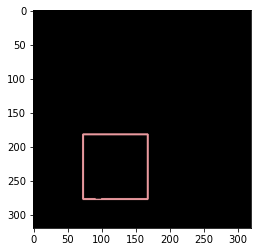

длина 131.65685415267944
длина 31.656854152679443
длина 354.48528122901917
длина 183.65685415267944
длина 183.65685415267944
длина 183.65685415267944
длина 399.3137083053589
длина 360.1421353816986
длина 393.65685415267944
длина 362.48528122901917
длина 391.3137083053589
длина 365.7989890575409
длина 385.65685415267944
длина 368.1421353816986
длина 385.65685415267944
длина 370.48528122901917
длина 383.3137083053589
длина 740.6274166107178
длина 734.9705619812012
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 131.65685415267944
длина 31.656854152679443
длина 354.48528122901917
длина 183.65685415267944
длина 183.65685415267944
длина 183.65685415267944
длина 399.3137083053589
длина 362.48528122901917
длина 391.3137083053589
длина 365.7989890575409
длина 385.65685415267944
длина 368.1421353816986
длина 385.65685415267944
длина 740.6274166107178
длина 730.9705624580383
длина 131.65685415267944
длина 31.656854152679443
длина 354.48528122

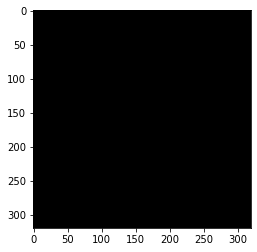

itogo 6
train_data/95.png


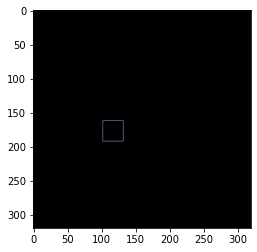

длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 123.31370830535889
длина 41.65685415267944
длина 41.65685415267944
длина 41.65685415267944
длина 93.65685415267944
длина 41.65685415267944
длина 139.3137083053589
длина 109.65685415267944
длина 123.31370830535889
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 95.31370830535889
длина 137.65685415267944
длина 109.65685415267944
длина 125.65685415267944
длина 115.31370830535889
длина 120.0
itogo 1


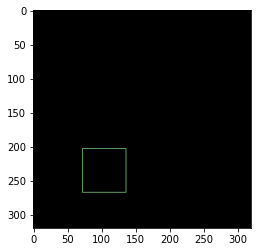

длина 232.97056245803833
длина 272.0
длина 245.65685415267944
длина 259.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 231.3137083053589
длина 273.65685415267944
длина 243.3137083053589
длина 261.65685415267944
длина 245.65685415267944
длина 259.3137083053589
длина 251.3137083053589
длина 256.0
длина 231.3137083053589
длина 273.65685415267944
длина 245.65685415267944
длина 261.65685415267944
длина 251.3137083053589
длина 256.0
itogo 2


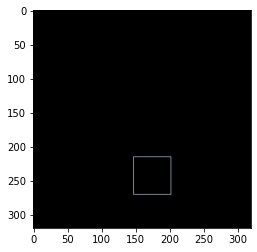

длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 215.3137083053589
длина 220.0
длина 196.97056245803833
длина 233.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 212.97056198120117
длина 220.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 195.3137083053589
длина 237.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 212.97056198120117
длина 220.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 3


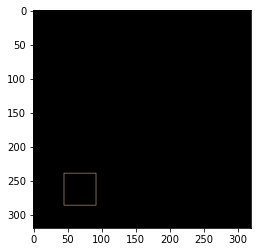

длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 193.65685415267944
длина 183.3137083053589
длина 188.0
длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 193.65685415267944
длина 183.3137083053589
длина 188.0
длина 163.3137083053589
длина 205.65685415267944
длина 177.65685415267944
длина 191.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 4


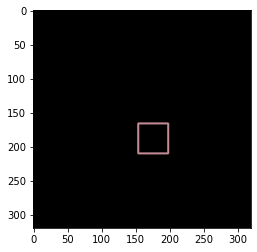

длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 171.3137083053589
длина 176.0
длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 168.97056198120117
длина 176.0
длина 81.65685415267944
длина 149.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 81.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 160.97056198120117
длина 181.65685415267944


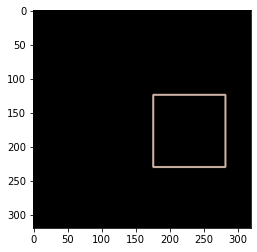

длина 205.65685415267944
длина 397.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 443.3137083053589
длина 405.65685415267944
длина 435.3137083053589
длина 405.65685415267944
длина 435.3137083053589
длина 411.3137083053589
длина 429.65685415267944
длина 411.3137083053589
длина 429.65685415267944
длина 413.65685415267944
длина 427.3137083053589
длина 416.9705619812012
длина 424.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 205.65685415267944
длина 397.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 205.65685415267944
длина 443.3137083053589
длина 405.65685415267944
длина 435.3137083053589
длина 405.65685415267944
длина 435.3137083053589
длина 411.3137083053589
длина 429.65685415267944
длина 413.65685415267944
длина 427.3137083053589
длина 416.9705619812012
длина 424.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145

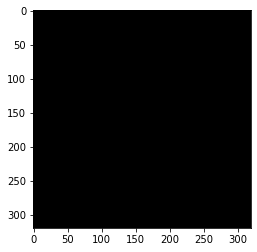

itogo 6
train_data/96.png


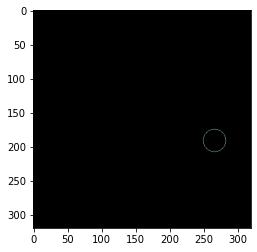

длина 90.91168689727783
длина 128.56854152679443
длина 109.25483322143555
длина 112.56854152679443
длина 90.91168689727783
длина 128.56854152679443
длина 104.56854057312012
длина 114.91168737411499
длина 90.91168689727783
длина 128.56854152679443
длина 104.56854057312012
длина 112.56854057312012
itogo 0


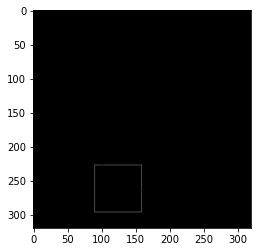

длина 119.65685415267944
длина 43.65685415267944
длина 61.65685415267944
длина 123.65685415267944
длина 251.3137083053589
длина 101.65685415267944
длина 7.656854152679443
длина 296.97056245803833
длина 189.89949476718903
длина 350.3847759962082
длина 119.65685415267944
длина 43.65685415267944
длина 61.65685415267944
длина 123.65685415267944
длина 252.1421353816986
длина 101.65685415267944
длина 7.656854152679443
длина 297.79898953437805
длина 189.89949476718903
длина 350.3847759962082
длина 253.79898953437805
длина 292.8284270763397
длина 188.2426404953003
длина 348.7279214859009
itogo 1


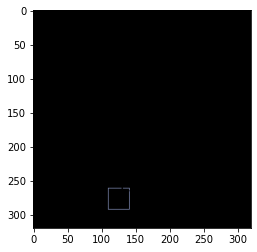

длина 100.14213538169861
длина 142.48528122901917
длина 238.28427076339722
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 43.65685415267944
длина 35.65685415267944
длина 43.65685415267944
длина 99.31370830535889
длина 21.656854152679443
длина 144.1421353816986
длина 240.62741661071777
длина 16.82842707633972
длина 202.48528122901917
длина 100.97056245803833
длина 140.0
длина 241.3137083053589
длина 18.82842707633972
длина 204.72792148590088
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 2


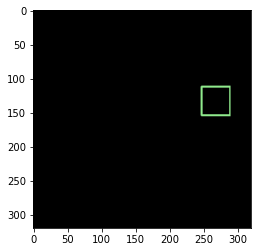

длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 185.3137083053589
длина 149.65685415267944
длина 178.48528122901917
длина 155.3137083053589
длина 172.82842707633972
длина 157.65685415267944
длина 171.65685415267944
длина 247.3137080669403
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 185.3137083053589
длина 147.3137083053589
длина 179.65685415267944
длина 149.65685415267944
длина 177.3137083053589
длина 152.97056198120117
длина 172.82842707633972
длина 155.3137083053589
длина 172.82842707633972
длина 157.65685415267944
длина 170.48528122901917
длина 250.1421353816986
длина 247.3137080669403
длина 0.0
длина 6.2426406145095825
длина 0.0
длина 6.2426406145095825
длина 77.65685415267944
длина 141.65685415267944
длина 77.65685415267944
длина 77.65685415267944
длина 185.3137083053589
длина 149.65685415267944
длина 178.48528122901917
длина 155.3137083053589
длина 172.82842707633972


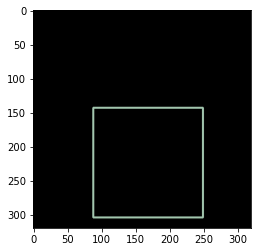

длина 315.65685415267944
длина 617.6568541526794
длина 315.65685415267944
длина 315.65685415267944
длина 315.65685415267944
длина 663.3137083053589
длина 625.6568541526794
длина 655.3137083053589
длина 628.9705619812012
длина 652.0
длина 631.3137083053589
длина 649.6568541526794
длина 633.6568541526794
длина 647.3137083053589
длина 639.3137083053589
длина 644.0
длина 315.65685415267944
длина 617.6568541526794
длина 315.65685415267944
длина 315.65685415267944
длина 315.65685415267944
длина 663.3137083053589
длина 625.6568541526794
длина 655.3137083053589
длина 625.6568541526794
длина 655.3137083053589
длина 631.3137083053589
длина 649.6568541526794
длина 633.6568541526794
длина 649.6568541526794
длина 633.6568541526794
длина 647.3137083053589
длина 639.3137083053589
длина 644.0
длина 315.65685415267944
длина 617.6568541526794
длина 315.65685415267944
длина 315.65685415267944
длина 315.65685415267944
длина 663.3137083053589
длина 625.6568541526794
длина 655.3137083053589
длина 625.656854

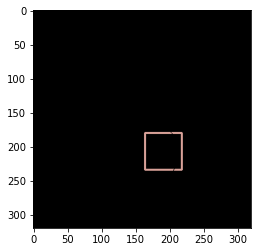

длина 15.656854152679443
длина 77.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 21.656854152679443
длина 5.656854152679443
длина 69.65685415267944
длина 235.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 199.3137083053589
длина 228.97056245803833
длина 203.3137083053589
длина 221.65685415267944
длина 204.1421353816986
длина 222.48528122901917
длина 424.2842707633972
длина 150.4852809906006
длина 258.4852809906006
длина 146.48528122901917
длина 254.48528122901917
длина 15.656854152679443
длина 77.65685415267944
длина 189.65685415267944
длина 101.65685415267944
длина 101.65685415267944
длина 21.656854152679443
длина 5.656854152679443
длина 69.65685415267944
длина 235.3137083053589
длина 197.65685415267944
длина 227.3137083053589
длина 200.97056198120117
длина 224.0
длина 204.97056245803833
длина 223.3137083053589
длина 154.1421353816986
длина 264.1421353816986
длина 147.65685415267944
длина 257.65685415267944
длина 1

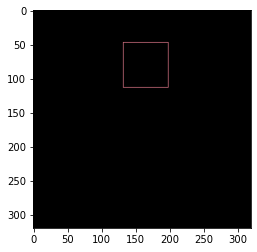

длина 239.3137083053589
длина 281.65685415267944
длина 251.3137083053589
длина 269.65685415267944
длина 253.65685415267944
длина 267.3137083053589
длина 259.3137083053589
длина 264.0
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 237.65685415267944
длина 113.65685415267944
длина 283.3137083053589
длина 253.65685415267944
длина 267.3137083053589
длина 113.65685415267944
длина 113.65685415267944
длина 113.65685415267944
длина 237.65685415267944
длина 113.65685415267944
длина 283.3137083053589
длина 253.65685415267944
длина 269.65685415267944
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
itogo 6


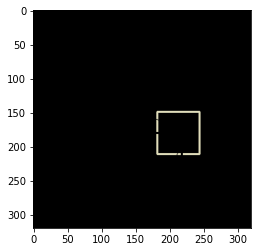

длина 41.65685415267944
длина 51.65685415267944
длина 51.65685415267944
длина 27.656854152679443
длина 224.1421353816986
длина 117.65685415267944
длина 15.656854152679443
длина 117.65685415267944
длина 269.79898953437805
длина 133.89949476718903
длина 358.3847759962082
длина 133.2132030725479
длина 357.6984843015671
длина 127.65685403347015
длина 350.97056210041046
длина 129.0710676908493
длина 353.55634891986847
длина 9.656854152679443
длина 114.48528122901917
длина 35.65685415267944
длина 312.97056245803833
длина 4.0
длина 110.24264061450958
длина 30.0
длина 308.72792184352875
длина 2.0
длина 108.82842707633972
длина 28.0
длина 308.48528122901917
длина 41.65685415267944
длина 51.65685415267944
длина 51.65685415267944
длина 27.656854152679443
длина 221.65685415267944
длина 117.65685415267944
длина 15.656854152679443
длина 117.65685415267944
длина 267.3137083053589
длина 133.89949476718903
длина 358.3847759962082
длина 133.2132030725479
длина 357.6984843015671
длина 127.65685403347015


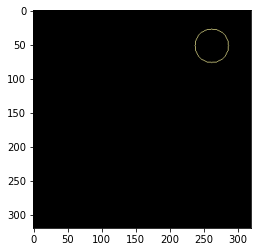

длина 143.1959571838379
длина 183.1959581375122
длина 155.88224983215332
длина 170.5096664428711
длина 159.1959571838379
длина 167.1959581375122
длина 62.62741661071777
длина 62.62741661071777
длина 62.62741661071777
длина 62.62741661071777
длина 143.1959571838379
длина 183.1959581375122
длина 155.88224983215332
длина 170.5096664428711
длина 161.53910398483276
длина 169.5391035079956
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 12.0
длина 143.1959571838379
длина 183.1959581375122
длина 155.88224983215332
длина 167.1959571838379
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
длина 8.0
itogo 7


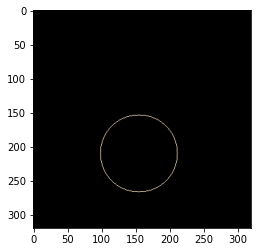

длина 354.67618560791016
длина 394.6761865615845
длина 365.0193328857422
длина 384.33303928375244
длина 370.6761884689331
длина 378.6761875152588
длина 123.5979790687561
длина 123.5979790687561
длина 123.5979790687561
длина 123.5979790687561
длина 354.67618560791016
длина 394.6761865615845
длина 367.3624782562256
длина 381.98989391326904
длина 373.01933097839355
длина 376.3330411911011
длина 14.0
длина 14.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 14.0
длина 14.0
длина 14.0
длина 14.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 14.0
длина 14.0
длина 354.67618560791016
длина 394.6761865615845
длина 367.3624792098999
длина 378.6761884689331
длина 170.36753058433533
длина 170.36753058433533
длина 170.36753058433533
длина 170.36753058433533
itogo 7


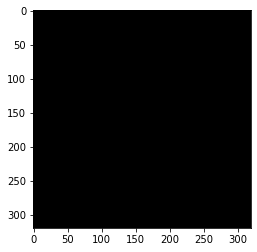

itogo 7
train_data/97.png


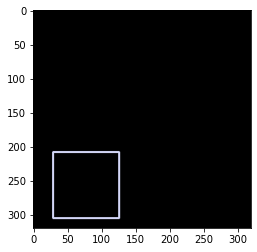

длина 187.65685415267944
длина 361.65685415267944
длина 187.65685415267944
длина 187.65685415267944
длина 187.65685415267944
длина 407.3137083053589
длина 369.65685415267944
длина 399.3137083053589
длина 369.65685415267944
длина 399.3137083053589
длина 375.3137083053589
длина 393.65685415267944
длина 375.3137083053589
длина 393.65685415267944
длина 377.65685415267944
длина 391.3137083053589
длина 380.9705619812012
длина 388.0
длина 383.3137083053589
длина 385.65685415267944
длина 187.65685415267944
длина 361.65685415267944
длина 187.65685415267944
длина 187.65685415267944
длина 187.65685415267944
длина 407.3137083053589
длина 369.65685415267944
длина 399.3137083053589
длина 369.65685415267944
длина 399.3137083053589
длина 375.3137083053589
длина 393.65685415267944
длина 375.3137083053589
длина 393.65685415267944
длина 377.65685415267944
длина 391.3137083053589
длина 380.9705619812012
длина 388.0
длина 383.3137083053589
длина 385.65685415267944
длина 187.65685415267944
длина 361.6568541

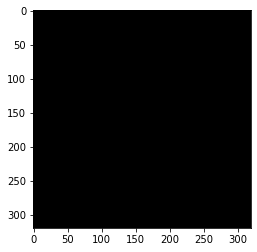

itogo 1
train_data/98.png


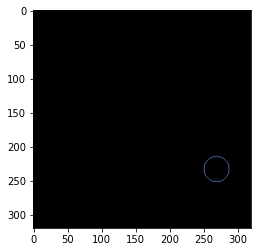

длина 102.22539710998535
длина 142.22539520263672
длина 120.56854152679443
длина 123.88224983215332
длина 102.22539710998535
длина 142.22539520263672
длина 118.22539615631104
длина 126.22539710998535
длина 102.22539710998535
длина 142.22539520263672
длина 114.91168689727783
длина 129.53910541534424
длина 120.56854152679443
длина 123.88224983215332
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
длина 6.0
itogo 0


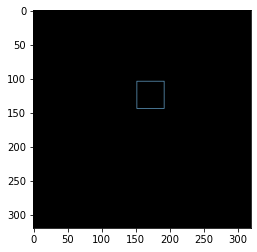

длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 133.65685415267944
длина 61.65685415267944
длина 179.3137083053589
длина 152.97056198120117
длина 166.62741661071777
длина 61.65685415267944
длина 61.65685415267944
длина 61.65685415267944
длина 133.65685415267944
длина 61.65685415267944
длина 179.3137083053589
длина 149.65685415267944
длина 165.65685415267944
длина 155.3137083053589
длина 160.0
длина 135.3137083053589
длина 177.65685415267944
длина 149.65685415267944
длина 165.65685415267944
длина 149.65685415267944
длина 163.3137083053589
длина 155.3137083053589
длина 160.0
itogo 1


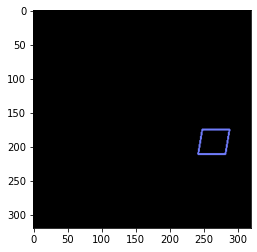

длина 73.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 127.79898953437805
длина 73.65685415267944
длина 174.62741661071777
длина 139.79898953437805
длина 168.28427076339722
длина 143.79898953437805
длина 162.62741661071777
длина 149.4558436870575
длина 156.97056245803833
длина 73.65685415267944
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 127.79898953437805
длина 73.65685415267944
длина 174.62741661071777
длина 139.79898953437805
длина 168.28427076339722
длина 142.6274163722992
длина 162.62741661071777
длина 146.62741661071777
длина 160.28427076339722
длина 81.65685415267944
дл

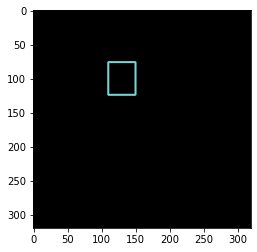

длина 73.65685415267944
длина 149.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 73.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 73.65685415267944
длина 149.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 73.65685415267944
длина 195.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 157.65685415267944
длина 187.3137083053589
длина 163.3137083053589
длина 181.65685415267944
длина 163.3137083053589
длина 181.65685415267944
длина 165.65685415267944
длина 179.3137083053589
длина 168.97056198120117
длина 176.0
длина 171.3137083053589
длина 173.65685415267944
длина 73.65685415267944
длина 149.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 73.65685415267944
длина 195.3

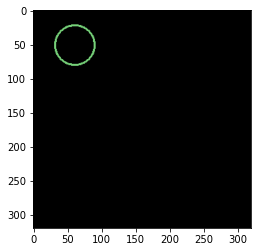

длина 17.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 170.50966548919678
длина 5.656854152679443
длина 17.656854152679443
длина 213.82337379455566
длина 180.85281133651733
длина 205.82337379455566
длина 186.50966548919678
длина 200.16651964187622
длина 188.85281133651733
длина 197.82337379455566
длина 17.656854152679443
длина 5.656854152679443
длина 17.656854152679443
длина 17.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 170.50966548919678
длина 5.656854152679443
длина 17.656854152679443
длина 213.82337379455566
длина 178.5096664428711
длина 205.82337379455566
длина 180.85281133651733
длина 205.82337379455566
длина 184.166522026062
длина 200.16651916503906
длина 186.50966548919678
длина 200.16651964187622
длина 186.50966548919678
длина 197.82337379455566
длина 192.16651916503906
длина 194.50966548919678
длина 14.0
длина 0.0
длина 2.0
длина 0.0
длина 0.0
длина 0.0


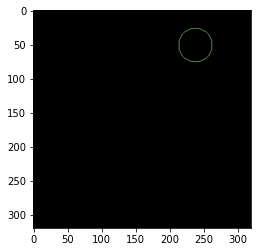

длина 143.1959571838379
длина 183.1959581375122
длина 159.1959571838379
длина 167.1959581375122
длина 143.1959571838379
длина 183.1959581375122
длина 155.88224983215332
длина 167.1959571838379
длина 161.53910446166992
длина 164.85281372070312
длина 143.1959571838379
длина 183.1959581375122
длина 161.5391035079956
длина 164.85281372070312
itogo 1


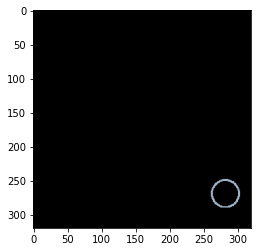

длина 5.656854152679443
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 152.71067690849304
длина 118.22539615631104
длина 144.7106773853302
длина 123.29646348953247
длина 141.39696860313416
длина 123.882248878479
длина 139.05382251739502
длина 249.76450061798096
длина 241.8650050163269
длина 13.656854152679443
длина 13.656854152679443
длина 110.22539567947388
длина 13.656854152679443
длина 152.71067690849304
длина 118.22539567947388
длина 144.71067690849304
длина 119.98275518417358
длина 144.71067643165588
длина 123.88224983215332
длина 139.0538227558136
длина 125.63960909843445
длина 139.05382227897644
длина 244.10764598846436
длина 2.0
длина 0.0
длина 2.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 2.0
длина 2.0
длина 0.0
длина 0.0
длина 2.0
длина 2.0
длина 12.0
длина 12.0
длина 0.0
длина 0.0
длина 2.8284270763397217
длина 5.656854152679443
длина 2.0
длина 0.0
длина 0.0
длина 2.0
длина 12.0
длина 13.656854152679443
длин

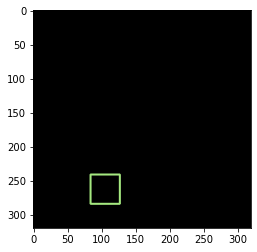

длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 156.97056198120117
длина 180.0
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 151.3137083053589
длина 185.65685415267944
длина 153.65685415267944
длина 183.3137083053589
длина 156.97056198120117
длина 177.65685415267944
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 161.65685415267944
длина 175.3137083053589
длина 167.3137083053589
длина 172.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 79.65685415267944
длина 145.65685415267944
длина 79.6

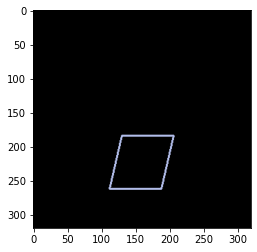

длина 145.65685415267944
длина 11.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 293.7401144504547
длина 11.656854152679443
длина 145.65685415267944
длина 340.56854152679443
длина 301.7401144504547
длина 334.2253956794739
длина 305.7401144504547
длина 332.56854152679443
длина 308.56854128837585
длина 328.56854152679443
длина 309.7401144504547
длина 326.2253956794739
длина 315.39696860313416
длина 322.911687374115
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 145.65685415267944
длина 11.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 

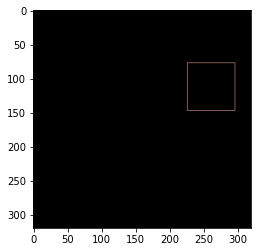

длина 255.3137083053589
длина 297.65685415267944
длина 269.65685415267944
длина 285.65685415267944
длина 272.9705619812012
длина 280.0
длина 255.3137083053589
длина 297.65685415267944
длина 269.65685415267944
длина 283.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 121.65685415267944
длина 121.65685415267944
длина 121.65685415267944
длина 253.65685415267944
длина 121.65685415267944
длина 299.3137083053589
длина 269.65685415267944
длина 283.3137083053589
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
itogo 3


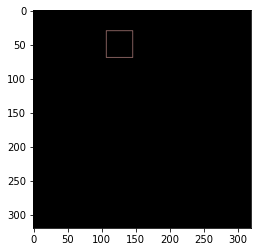

длина 59.65685415267944
длина 59.65685415267944
длина 59.65685415267944
длина 129.65685415267944
длина 59.65685415267944
длина 175.3137083053589
длина 145.65685415267944
длина 161.65685415267944
длина 148.97056198120117
длина 156.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 132.97056245803833
длина 172.0
длина 145.65685415267944
длина 159.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 132.97056245803833
длина 172.0
длина 145.65685415267944
длина 159.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 4


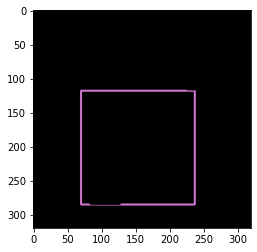

длина 211.65685415267944
длина 19.656854152679443
длина 642.4852812290192
длина 327.65685415267944
длина 327.65685415267944
длина 305.65685415267944
длина 686.7279218435287
длина 651.3137083053589
длина 679.3137083053589
длина 652.1421353816986
длина 679.5563489198685
длина 1248.6274166107178
длина 1241.213203072548
длина 554.4852812290192
длина 671.3137083053589
длина 547.6568540334702
длина 664.4852809906006
длина 10.242640614509583
длина 10.242640614509583
длина 2.0
длина 10.242640614509583
длина 211.65685415267944
длина 19.656854152679443
длина 642.4852812290192
длина 327.65685415267944
длина 327.65685415267944
длина 305.65685415267944
длина 686.7279218435287
длина 651.3137083053589
длина 678.7279218435287
длина 1244.6274166107178
длина 550.7279218435287
длина 668.1421353816986
длина 6.2426406145095825
длина 6.2426406145095825
длина 0.0
длина 6.2426406145095825
длина 211.65685415267944
длина 19.656854152679443
длина 642.4852812290192
длина 327.65685415267944
длина 327.6568541526794

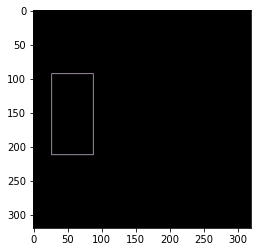

длина 335.3137083053589
длина 377.65685415267944
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 355.3137083053589
длина 360.0
длина 335.3137083053589
длина 377.65685415267944
длина 349.65685415267944
длина 365.65685415267944
длина 352.9705619812012
длина 360.0
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 335.3137083053589
длина 377.65685415267944
длина 347.3137083053589
длина 365.65685415267944
длина 349.65685415267944
длина 363.3137083053589
длина 355.3137083053589
длина 360.0
itogo 5


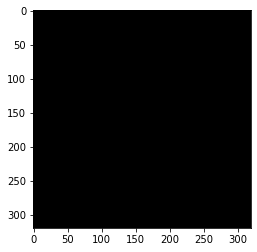

itogo 5
train_data/99.png


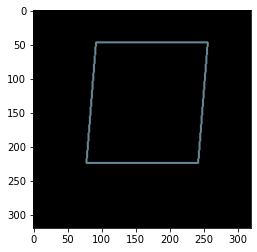

длина 321.65685415267944
длина 7.656854152679443
длина 7.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 21.656854152679443
длина 21.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 19.656854152679443
длина 667.2548332214355
длина 7.656854152679443
длина 7.656854152679443
длина 321.65685415267944
длина 712.911687374115
длина 675.2548332214355
длина 704.911687374115
длина 680.911687374115
длина 699.2548332214355
длина 972.3675308227539
длина 398.14213514328003
длина 321.6568

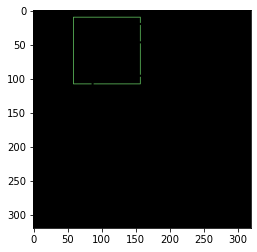

длина 121.65685415267944
длина 37.65685415267944
длина 5.656854152679443
длина 79.65685415267944
длина 35.65685415267944
длина 181.65685415267944
длина 372.2842707633972
длина 181.65685415267944
длина 417.94112491607666
длина 155.89949476718903
длина 91.65685415267944
длина 47.65685415267944
длина 456.3847759962082
длина 370.6274166107178
длина 409.65685415267944
длина 158.24264061450958
длина 94.0
длина 50.0
длина 458.72792184352875
длина 155.89949476718903
длина 91.65685415267944
длина 47.65685415267944
длина 456.3847759962082
длина 146.82842707633972
длина 82.0
длина 38.0
длина 448.48528122901917
длина 370.6274166107178
длина 409.65685415267944
длина 155.89949476718903
длина 91.65685415267944
длина 47.65685415267944
длина 456.3847759962082
itogo 1


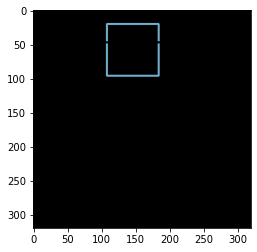

длина 145.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 280.97056245803833
длина 43.65685415267944
длина 43.65685415267944
длина 145.65685415267944
длина 326.6274166107178
длина 343.79898953437805
длина 255.79898953437805
длина 340.48528122901917
длина 252.48528122901917
длина 332.48528122901917
длина 244.48528122901917
длина 145.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 277.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 145.65685415267944
длина 323.3137083053589
длина 346.1421353816986
длина 258.1421353816986
длина 342.1421353816986
длина 254.1421353816986
длина 340.48528122901917
длина 252.48528122901917
длина 338.1421353816986
длина 250.1421353816986
длина 332.4852809906006
длина 244.4852809906006
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 145.65685415267944
длина 87.65685415267944
длина 87.65685415267944
длина 277.65685415267944
длина 43.65685415267

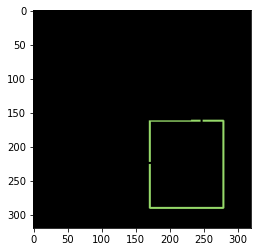

длина 209.65685415267944
длина 121.65685415267944
длина 445.65685415267944
длина 249.65685415267944
длина 113.65685415267944
длина 53.65685415267944
длина 21.656854152679443
длина 490.72792184352875
длина 664.3847759962082
длина 275.899494767189
длина 656.9705621004105
длина 269.65685403347015
длина 656.3847759962082
длина 267.3137083053589
длина 118.82842707633972
длина 650.7279218435287
длина 26.0
длина 112.0
длина 646.7279218435287
длина 18.0
длина 209.65685415267944
длина 121.65685415267944
длина 445.65685415267944
длина 249.65685415267944
длина 113.65685415267944
длина 53.65685415267944
длина 21.656854152679443
длина 490.72792184352875
длина 664.3847759962082
длина 275.899494767189
длина 662.0416301488876
длина 272.97056245803833
длина 658.7279218435287
длина 270.2426406145096
длина 656.3847759962082
длина 267.3137083053589
длина 656.3847759962082
длина 267.899494767189
длина 118.82842707633972
длина 650.7279214859009
длина 24.0
длина 114.0
длина 646.7279218435287
длина 20.0
длина

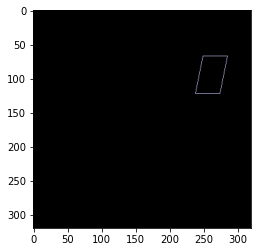

длина 164.76955199241638
длина 205.94112491607666
длина 177.94112491607666
длина 196.76955199241638
длина 184.7695517539978
длина 191.11269783973694
длина 163.94112491607666
длина 207.94112491607666
длина 177.94112491607666
длина 196.76955199241638
длина 186.42640590667725
длина 191.11269783973694
длина 163.94112491607666
длина 207.94112491607666
длина 177.94112491607666
длина 196.76955199241638
длина 183.5979790687561
длина 191.11269783973694
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
длина 4.828427076339722
itogo 2


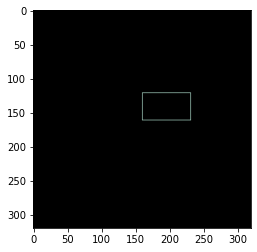

длина 198.97056245803833
длина 238.0
длина 211.65685415267944
длина 227.65685415267944
длина 217.3137083053589
длина 222.0
длина 198.97056245803833
длина 238.0
длина 211.65685415267944
длина 227.65685415267944
длина 211.65685415267944
длина 225.3137083053589
длина 217.3137083053589
длина 222.0
длина 198.97056245803833
длина 238.0
длина 211.65685415267944
длина 227.65685415267944
длина 214.97056198120117
длина 222.0
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
itogo 2


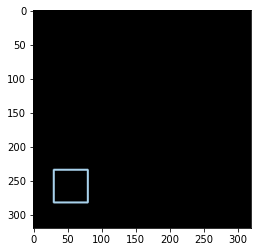

длина 93.65685415267944
длина 169.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 93.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 188.97056198120117
длина 196.0
длина 93.65685415267944
длина 169.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 93.65685415267944
длина 215.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 177.65685415267944
длина 207.3137083053589
длина 183.3137083053589
длина 201.65685415267944
длина 183.3137083053589
длина 201.65685415267944
длина 185.65685415267944
длина 199.3137083053589
длина 188.97056198120117
длина 196.0
длина 191.3137083053589
длина 193.65685415267944
длина 93.65685415267944
длина 169.65685415267944
длина 89.65685415267944
длина 89.65685415267944
длина 93.65685415267944
длина 215.3137083053589
д

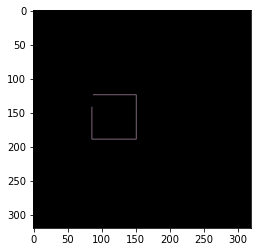

длина 490.72792184352875
длина 480.48528122901917
длина 470.7279214859009
длина 490.72792184352875
длина 478.1421353816986
длина 468.48528122901917
длина 490.72792184352875
длина 480.48528122901917
длина 472.48528122901917
itogo 3


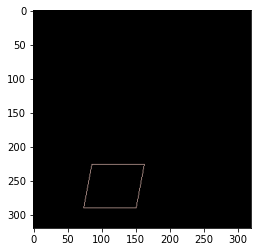

длина 266.18376553058624
длина 308.7695519924164
длина 278.7695519924164
длина 297.5979790687561
длина 282.7695519924164
длина 293.5979790687561
длина 156.82842707633972
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 6.0
длина 6.0
длина 4.0
длина 4.0
длина 156.82842707633972
длина 266.18376553058624
длина 308.7695519924164
длина 278.7695519924164
длина 297.5979790687561
длина 284.42640590667725
длина 291.94112491607666
длина 135.65685415267944
длина 265.3553384542465
длина 135.65685415267944
длина 308.4264061450958
длина 278.7695519924164
длина 297.5979790687561
длина 285.5979788303375
длина 291.94112491607666
itogo 3


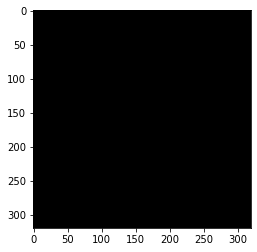

itogo 3
train_data/100.png


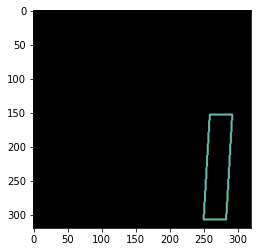

длина 59.65685415267944
длина 11.656854152679443
длина 11.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 355.11269783973694
длина 11.656854152679443
длина 11.656854152679443
длина 59.65685415267944
длина 400.7695519924164
длина 363.11269783973694
длина 392.7695519924164
длина 368.7695519924164
длина 387.11269783973694
длина 373.11269760131836
длина 373.11269760131836
длина 59.65685415267944
длина 11.656854152679443
длина 11.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 29.656854152679443
длина 

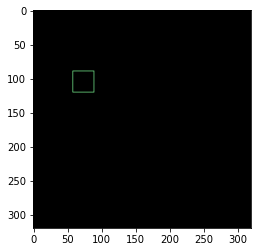

длина 99.31370830535889
длина 141.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 43.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 97.65685415267944
длина 43.65685415267944
длина 143.3137083053589
длина 111.31370830535889
длина 129.65685415267944
длина 113.65685415267944
длина 127.31370830535889
длина 119.31370830535889
длина 124.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 100.97056245803833
длина 140.0
длина 113.65685415267944
длина 129.65685415267944
длина 119.31370830535889
длина 124.0
itogo 1


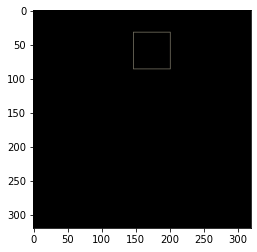

длина 191.3137083053589
длина 233.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 6.2426406145095825
длина 191.3137083053589
длина 233.65685415267944
длина 205.65685415267944
длина 219.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 191.3137083053589
длина 233.65685415267944
длина 205.65685415267944
длина 219.3137083053589
itogo 1


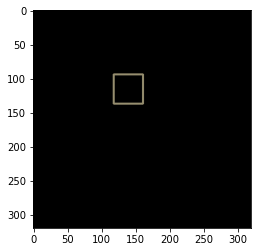

длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 156.97056198120117
длина 177.65685415267944
длина 159.3137083053589
длина 177.65685415267944
длина 164.97056245803833
длина 172.0
длина 167.3137083053589
длина 169.65685415267944
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 161.65685415267944
длина 175.3137083053589
длина 164.97056198120117
длина 172.0
длина 79.65685415267944
длина 145.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 79.65685415267944
длина 191.3137083053589
длина 153.65685415267944
длина 183.3137083053589
длина 159.3137083053589
длина 177.65685415267944
длина 164.97056198120117
длина 172.0
itogo 2


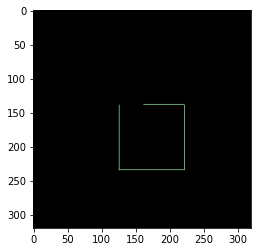

длина 173.65685415267944
длина 173.65685415267944
длина 175.65685415267944
длина 105.65685415267944
длина 705.798989534378
длина 691.5563489198685
длина 565.6568541526794
длина 114.0
длина 173.65685415267944
длина 173.65685415267944
длина 175.65685415267944
длина 105.65685415267944
длина 705.798989534378
длина 693.798989534378
длина 690.3847759962082
длина 685.3137083053589
длина 704.1421353816986
длина 693.899494767189
длина 685.899494767189
itogo 3


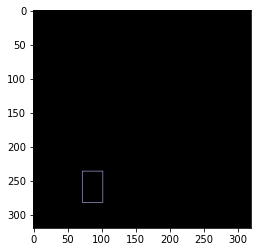

длина 41.65685415267944
длина 73.65685415267944
длина 73.65685415267944
длина 125.65685415267944
длина 41.65685415267944
длина 171.3137083053589
длина 141.65685415267944
длина 157.65685415267944
длина 147.3137083053589
длина 152.0
длина 127.31370830535889
длина 169.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 147.3137083053589
длина 152.0
длина 127.31370830535889
длина 169.65685415267944
длина 141.65685415267944
длина 157.65685415267944
длина 141.65685415267944
длина 155.3137083053589
длина 147.3137083053589
длина 152.0
itogo 3


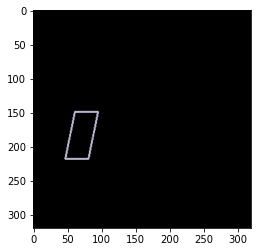

длина 61.65685415267944
длина 5.656854152679443
длина 13.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 5.656854152679443
длина 188.42640614509583
длина 13.656854152679443
длина 61.65685415267944
длина 235.25483322143555
длина 196.42640614509583
длина 228.911687374115
длина 197.5979790687561
длина 227.25483322143555
длина 202.0832600593567
длина 223.25483322143555
длина 204.42640614509583
длина 220.911687374115
длина 210.08326029777527
длина 217.5979790687561
длина 69.65685415267944
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
дли

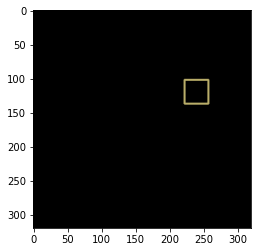

длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 132.97056245803833
длина 140.0
длина 135.3137083053589
длина 137.65685415267944
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 121.65685415267944
длина 151.3137083053589
длина 127.31370830535889
длина 145.65685415267944
длина 129.65685415267944
длина 143.3137083053589
длина 132.97056198120117
длина 140.0
длина 63.65685415267944
длина 113.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 63.65685415267944
длина 159.3137083053589
длина 121.65685415267944
длина 151.3137083053589

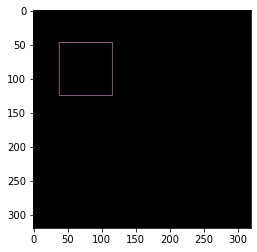

длина 137.65685415267944
длина 137.65685415267944
длина 137.65685415267944
длина 285.65685415267944
длина 137.65685415267944
длина 331.3137083053589
длина 301.65685415267944
длина 317.65685415267944
длина 304.9705619812012
длина 312.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 287.3137083053589
длина 329.65685415267944
длина 301.65685415267944
длина 315.3137083053589
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 3.414213538169861
длина 287.3137083053589
длина 329.65685415267944
длина 301.65685415267944
длина 317.65685415267944
длина 307.3137083053589
длина 312.0
itogo 5


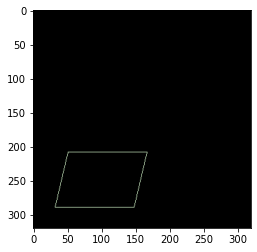

длина 382.56854152679443
длина 425.39696860313416
длина 396.56854152679443
длина 415.39696860313416
длина 402.2253956794739
длина 409.7401144504547
длина 2.8284270763397217
длина 3.414213538169861
длина 3.414213538169861
длина 2.8284270763397217
длина 213.65685415267944
длина 381.7401144504547
длина 213.65685415267944
длина 426.2253956794739
длина 396.56854152679443
длина 415.39696860313416
длина 400.56854152679443
длина 413.0538227558136
длина 237.65685415267944
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 4.0
длина 4.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 2.0
длина 237.65685415267944
длина 383.39696860313416
длина 425.7401144504547
длина 396.56854152679443
длина 415.39696860313416
длина 402.2253956794739
длина 409.7401144504547


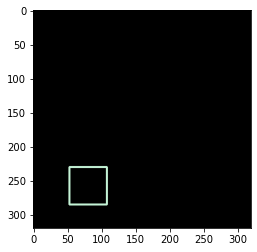

длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 201.65685415267944
длина 231.3137083053589
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 215.3137083053589
длина 220.0
длина 103.65685415267944
длина 193.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 103.65685415267944
длина 239.3137083053589
длина 199.3137083053589
длина 233.65685415267944
длина 201.65685415267944
длина 231.3137083053589
длина 204.97056198120117
длина 228.0
длина 207.3137083053589
длина 225.65685415267944
длина 209.65685415267944
длина 225.65685415267944
длина 209.65685415267944
длина 223.3137083053589
длина 212.97056198120117
длина 220.0
длина 215.3137083053589
длина 217.65685415267944
длина 103.65685415267944
длина 193.65685415267944
д

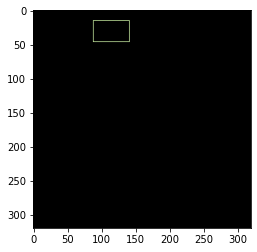

длина 144.97056245803833
длина 184.0
длина 157.65685415267944
длина 173.65685415267944
длина 157.65685415267944
длина 171.3137083053589
длина 163.3137083053589
длина 168.0
длина 87.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 141.65685415267944
длина 87.65685415267944
длина 187.3137083053589
длина 155.3137083053589
длина 173.65685415267944
длина 157.65685415267944
длина 171.3137083053589
длина 163.3137083053589
длина 168.0
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 2.8284270763397217
длина 87.65685415267944
длина 43.65685415267944
длина 43.65685415267944
длина 141.65685415267944
длина 87.65685415267944
длина 187.3137083053589
длина 157.65685415267944
длина 173.65685415267944
длина 163.3137083053589
длина 168.0
itogo 6


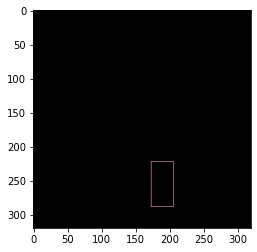

длина 173.3137083053589
длина 215.65685415267944
длина 185.3137083053589
длина 203.65685415267944
длина 187.65685415267944
длина 201.3137083053589
длина 193.3137083053589
длина 198.0
длина 173.3137083053589
длина 215.65685415267944
длина 187.65685415267944
длина 203.65685415267944
длина 193.3137083053589
длина 198.0
длина 174.97056245803833
длина 214.0
длина 187.65685415267944
длина 203.65685415267944
длина 193.3137083053589
длина 198.0
itogo 6


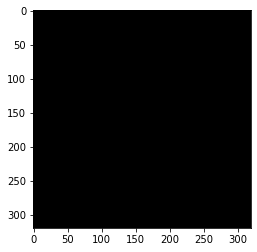

itogo 6


In [317]:
train['pred'] = train[:100].img_path.apply(count_sq, args=(bord,))

In [318]:
train[:100]

img_path  label  type  pred
0     train_data/1.png      3     1   3.0
1     train_data/2.png      7     3   7.0
2     train_data/3.png      9     2   9.0
3     train_data/4.png      9     1   9.0
4     train_data/5.png     10     1  10.0
..                 ...    ...   ...   ...
95   train_data/96.png      7     3   7.0
96   train_data/97.png      1     1   1.0
97   train_data/98.png      5     2   5.0
98   train_data/99.png      3     3   3.0
99  train_data/100.png      7     2   6.0

[100 rows x 4 columns]

In [319]:
stat(train[:100])

rmse всего =
rmse -  0.3872983346207417
            label      type        pred
count  100.000000  100.0000  100.000000
mean     5.410000    2.1200    5.380000
std      2.964759    0.7691    2.880727
min      0.000000    1.0000    0.000000
25%      3.000000    2.0000    3.000000
50%      5.500000    2.0000    5.000000
75%      8.000000    3.0000    8.000000
max     10.000000    3.0000   10.000000
       label  pred
0  0       5     3
1  1       4     6
2  2      10     9
3  3      15    16
4  4       9     8
5  5       7     9
6  6       8    10
7  7      10     9
8  8      12    11
9  9      13    12
10 10      7     7
---------------
type =  1
rmse 1 = 
rmse -  0.2041241452319315
           label  type       pred
count  24.000000  24.0  24.000000
mean    5.083333   1.0   5.041667
std     2.483277   0.0   2.475606
min     1.000000   1.0   1.000000
25%     3.000000   1.0   3.000000
50%     5.000000   1.0   5.000000
75%     6.250000   1.0   6.250000
max    10.000000   1.0  10.000000
   

In [14]:
test['pred'] = test.img_path.apply(count_sq, args=(bord,))
pred_to_csv(test)
stat(test, False)

test_data/1.png
test_data/2.png
test_data/3.png
test_data/4.png
test_data/5.png
test_data/6.png
test_data/7.png
test_data/8.png
test_data/9.png
test_data/10.png
test_data/11.png
test_data/12.png
test_data/13.png
test_data/14.png
test_data/15.png
test_data/16.png
test_data/17.png
test_data/18.png
test_data/19.png
test_data/20.png
test_data/21.png
test_data/22.png
test_data/23.png
test_data/24.png
test_data/25.png
test_data/26.png
test_data/27.png
test_data/28.png
test_data/29.png
test_data/30.png
test_data/31.png
test_data/32.png
test_data/33.png
test_data/34.png
test_data/35.png
test_data/36.png
test_data/37.png
test_data/38.png
test_data/39.png
test_data/40.png
test_data/41.png
test_data/42.png
test_data/43.png
test_data/44.png
test_data/45.png
test_data/46.png
test_data/47.png
test_data/48.png
test_data/49.png
test_data/50.png
test_data/51.png
test_data/52.png
test_data/53.png
test_data/54.png
test_data/55.png
test_data/56.png
test_data/57.png
test_data/58.png
test_data/59.png
test_d

In [5]:
binary

Unnamed: 0            img_path  pred_type
0              0     test_data/1.png   0.113235
1              1     test_data/2.png   0.135533
2              2     test_data/3.png   0.080725
3              3     test_data/4.png   1.000000
4              4     test_data/5.png   1.000000
...          ...                 ...        ...
5995        5995  test_data/5996.png   1.000000
5996        5996  test_data/5997.png   0.999998
5997        5997  test_data/5998.png   1.000000
5998        5998  test_data/5999.png   1.000000
5999        5999  test_data/6000.png   0.082966

[6000 rows x 3 columns]

In [53]:
binary = binary[['img_path', 'pred_type']]


In [59]:
binary[binary.img_path=='test_data/5993.png']

img_path  pred_type
5992  test_data/5993.png   0.112496

In [56]:
binary

img_path  pred_type
0        test_data/1.png   0.113235
1        test_data/2.png   0.135533
2        test_data/3.png   0.080725
3        test_data/4.png   1.000000
4        test_data/5.png   1.000000
...                  ...        ...
5995  test_data/5996.png   1.000000
5996  test_data/5997.png   0.999998
5997  test_data/5998.png   1.000000
5998  test_data/5999.png   1.000000
5999  test_data/6000.png   0.082966

[6000 rows x 2 columns]

In [7]:
binary.pred_type.value_counts()

1.000000    3403
1.000000      25
1.000000       8
1.000000       8
1.000000       5
            ... 
0.090951       1
0.101407       1
0.157919       1
0.122919       1
0.082966       1
Name: pred_type, Length: 2525, dtype: int64

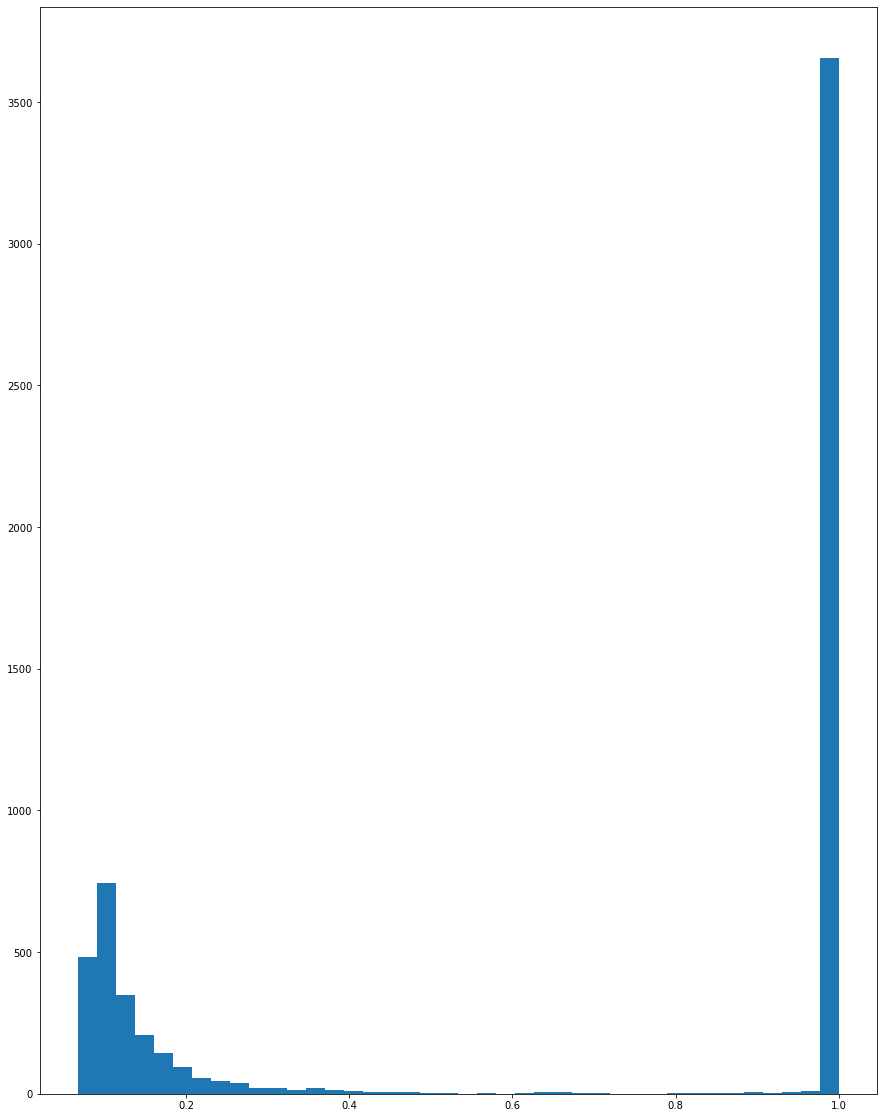

In [57]:
plt.figure(figsize=(15,20))
plt.hist(binary.pred_type, bins=40)
plt.show()

In [11]:
binary[binary.pred_type<=0.2]

img_path  pred_type
0        test_data/1.png   0.113235
1        test_data/2.png   0.135533
2        test_data/3.png   0.080725
5        test_data/6.png   0.134040
8        test_data/9.png   0.123678
...                  ...        ...
5981  test_data/5982.png   0.099268
5988  test_data/5989.png   0.081798
5990  test_data/5991.png   0.151910
5992  test_data/5993.png   0.112496
5999  test_data/6000.png   0.082966

[1993 rows x 2 columns]

In [14]:
binary.loc[binary.pred_type<0.2, 'pred_type'] = 0
binary.loc[binary.pred_type>=0.2, 'pred_type'] = 1

binary

/opt/homebrew/Caskroom/miniforge/base/envs/m1/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


img_path  pred_type
0        test_data/1.png        0.0
1        test_data/2.png        0.0
2        test_data/3.png        0.0
3        test_data/4.png        1.0
4        test_data/5.png        1.0
...                  ...        ...
5995  test_data/5996.png        1.0
5996  test_data/5997.png        1.0
5997  test_data/5998.png        1.0
5998  test_data/5999.png        1.0
5999  test_data/6000.png        0.0

[6000 rows x 2 columns]

In [13]:
binary.describe()

pred_type
count  6000.000000
mean      0.667833
std       0.471030
min       0.000000
25%       0.000000
50%       1.000000
75%       1.000000
max       1.000000

In [15]:
test_1class = binary[binary.pred_type==0][['img_path']]
test_1class

img_path
0        test_data/1.png
1        test_data/2.png
2        test_data/3.png
5        test_data/6.png
8        test_data/9.png
...                  ...
5981  test_data/5982.png
5988  test_data/5989.png
5990  test_data/5991.png
5992  test_data/5993.png
5999  test_data/6000.png

[1993 rows x 1 columns]

In [16]:
test_1class.to_csv('test_1class.csv', index=False)

In [15]:
test_2class = binary[binary.pred_type==1][['img_path']]
test_2class

img_path
3        test_data/4.png
4        test_data/5.png
6        test_data/7.png
7        test_data/8.png
9       test_data/10.png
...                  ...
5994  test_data/5995.png
5995  test_data/5996.png
5996  test_data/5997.png
5997  test_data/5998.png
5998  test_data/5999.png

[4007 rows x 1 columns]

In [16]:
test_2class['pred'] = test_2class.img_path.apply(count_sq, args=(bord,))

test_data/4.png
test_data/5.png
test_data/7.png
test_data/8.png
test_data/10.png
test_data/13.png
test_data/14.png
test_data/16.png
test_data/18.png
test_data/19.png
test_data/20.png
test_data/22.png
test_data/23.png
test_data/24.png
test_data/25.png
test_data/26.png
test_data/27.png
test_data/28.png
test_data/29.png
test_data/31.png
test_data/32.png
test_data/33.png
test_data/34.png
test_data/35.png
test_data/36.png
test_data/39.png
test_data/40.png
test_data/41.png
test_data/43.png
test_data/44.png
test_data/45.png
test_data/48.png
test_data/49.png
test_data/50.png
test_data/51.png
test_data/53.png
test_data/55.png
test_data/56.png
test_data/57.png
test_data/58.png
test_data/60.png
test_data/61.png
test_data/62.png
test_data/63.png
test_data/64.png
test_data/65.png
test_data/66.png
test_data/69.png
test_data/70.png
test_data/71.png
test_data/72.png
test_data/74.png
test_data/75.png
test_data/80.png
test_data/82.png
test_data/83.png
test_data/84.png
test_data/85.png
test_data/86.png
t

In [17]:
test_2class

img_path  pred
3        test_data/4.png     7
4        test_data/5.png     9
6        test_data/7.png    14
7        test_data/8.png    17
9       test_data/10.png     2
...                  ...   ...
5994  test_data/5995.png    13
5995  test_data/5996.png    15
5996  test_data/5997.png    13
5997  test_data/5998.png    15
5998  test_data/5999.png     8

[4007 rows x 2 columns]

In [ ]:
test_2class

In [18]:
pred_1class = pd.read_csv('./predictions/by_part/1class.csv')
pred_1class

img_path  label  type  pred
0        test_data/1.png    NaN   NaN     7
1        test_data/2.png    NaN   NaN    16
2        test_data/3.png    NaN   NaN     2
3        test_data/6.png    NaN   NaN     4
4        test_data/9.png    NaN   NaN    10
...                  ...    ...   ...   ...
1988  test_data/5982.png    NaN   NaN     7
1989  test_data/5989.png    NaN   NaN     3
1990  test_data/5991.png    NaN   NaN    10
1991  test_data/5993.png    NaN   NaN     7
1992  test_data/6000.png    NaN   NaN     4

[1993 rows x 4 columns]

In [46]:
pd.set_option('display.max_rows', 100)

In [19]:
pred_1class = pred_1class[['img_path', 'pred']]
pred_1class

img_path  pred
0        test_data/1.png     7
1        test_data/2.png    16
2        test_data/3.png     2
3        test_data/6.png     4
4        test_data/9.png    10
...                  ...   ...
1988  test_data/5982.png     7
1989  test_data/5989.png     3
1990  test_data/5991.png    10
1991  test_data/5993.png     7
1992  test_data/6000.png     4

[1993 rows x 2 columns]

In [51]:
pred_1class[-15:]

img_path  pred
1978  test_data/5954.png     5
1979  test_data/5957.png     2
1980  test_data/5963.png     3
1981  test_data/5964.png     7
1982  test_data/5966.png     4
1983  test_data/5967.png     1
1984  test_data/5968.png    20
1985  test_data/5975.png     8
1986  test_data/5978.png    16
1987  test_data/5981.png     3
1988  test_data/5982.png     7
1989  test_data/5989.png     3
1990  test_data/5991.png    10
1991  test_data/5993.png     7
1992  test_data/6000.png     4

In [22]:
pred_all = pd.concat((pred_1class, test_2class))
pred_all

img_path  pred
0        test_data/1.png     7
1        test_data/2.png    16
2        test_data/3.png     2
3        test_data/6.png     4
4        test_data/9.png    10
...                  ...   ...
5994  test_data/5995.png    13
5995  test_data/5996.png    15
5996  test_data/5997.png    13
5997  test_data/5998.png    15
5998  test_data/5999.png     8

[6000 rows x 2 columns]

In [23]:
pred_all = pred_all.sort_values('img_path')
pred_all

img_path  pred
0        test_data/1.png     7
9       test_data/10.png     2
99     test_data/100.png     8
999   test_data/1000.png     5
1000  test_data/1001.png     3
...                  ...   ...
994    test_data/995.png     8
995    test_data/996.png     2
329    test_data/997.png     6
997    test_data/998.png     8
330    test_data/999.png    15

[6000 rows x 2 columns]

In [24]:
pred_all.reset_index(inplace=True)

In [35]:
pred_all.img_path.str.split('/').str[1].str.split('.').str[0].astype('int')

0          1
1         10
2        100
3       1000
4       1001
        ... 
5995     995
5996     996
5997     997
5998     998
5999     999
Name: img_path, Length: 6000, dtype: int64

In [37]:
pred_all['ind'] = pred_all.img_path.str.split('/').str[1].str.split('.').str[0].astype('int')
pred_all

index            img_path  pred   ind
0         0     test_data/1.png     7     1
1         9    test_data/10.png     2    10
2        99   test_data/100.png     8   100
3       999  test_data/1000.png     5  1000
4      1000  test_data/1001.png     3  1001
...     ...                 ...   ...   ...
5995    994   test_data/995.png     8   995
5996    995   test_data/996.png     2   996
5997    329   test_data/997.png     6   997
5998    997   test_data/998.png     8   998
5999    330   test_data/999.png    15   999

[6000 rows x 4 columns]

In [38]:
pred_all = pred_all.sort_values('ind')
pred_all

index            img_path  pred   ind
0         0     test_data/1.png     7     1
1111      1     test_data/2.png    16     2
2222      2     test_data/3.png     2     3
3333      3     test_data/4.png     7     4
4444      4     test_data/5.png     9     5
...     ...                 ...   ...   ...
5551   5995  test_data/5996.png    15  5996
5552   5996  test_data/5997.png    13  5997
5553   5997  test_data/5998.png    15  5998
5554   5998  test_data/5999.png     8  5999
5558   1992  test_data/6000.png     4  6000

[6000 rows x 4 columns]

In [40]:
pred_all[pred_all.pred>15]

index            img_path  pred   ind
1111      1     test_data/2.png    16     2
5778      7     test_data/8.png    17     8
889      17    test_data/18.png    18    18
1223      9    test_data/21.png    19    21
1889     26    test_data/27.png    16    27
...     ...                 ...   ...   ...
5509   5957  test_data/5958.png    16  5958
5520   1984  test_data/5968.png    20  5968
5524   5970  test_data/5971.png    18  5971
5531   1986  test_data/5978.png    16  5978
5540   5985  test_data/5986.png    17  5986

[643 rows x 4 columns]

In [41]:
pred_all = pred_all[['pred']]
pred_all

pred
0        7
1111    16
2222     2
3333     7
4444     9
...    ...
5551    15
5552    13
5553    15
5554     8
5558     4

[6000 rows x 1 columns]

In [42]:
pred_to_csv(pred_all)

/opt/homebrew/Caskroom/miniforge/base/envs/m1/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [43]:
pred_all

label
0         7
1111     16
2222      2
3333      7
4444      9
...     ...
5551     15
5552     13
5553     15
5554      8
5558      4

[6000 rows x 1 columns]

Выборочно проверим работу на тестовом наборе

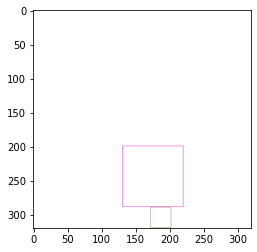

test_data/3.png


2    2
Name: img_path, dtype: int64

In [48]:
# откроем пример изображения
filename = '3.png' # Имя файла
image = Image.open('test_data/'+filename)
im_arr = np.array(image)
img1 = ImageDraw.Draw(image) 
plt.imshow(image) # Рисуем изображение
plt.show()

test.loc[2:2].img_path.apply(count_sq, args=(bord,))

**Результаты**:
- 0.38 rmse на обучающем наборе, 0.49 на тестовом

# Classification apply

чтобы немного улучшить результаты мы обучим классификатор, предскажем тип для каждого изображения на тестовом наборе и для каждого типа будем применять свои настройки подсчета квадратов

## Classification model

In [ ]:
from datetime import datetime
from tensorflow.keras.models import Sequential #Сеть прямого распространения
#Базовые слои для счёрточных сетей
from tensorflow.keras.layers import Dense, Activation,Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
from tensorflow.keras.optimizers import Adam, Adadelta # оптимизаторы
from tensorflow.keras import utils #Используем дял to_categoricall
from tensorflow.keras.preprocessing import image #Для отрисовки изображений
from PIL import Image #Для отрисовки изображений
%matplotlib inline

In [ ]:
train_path = None #Папка с папками картинок, рассортированных по категориям
batch_size = 25 #Размер выборки
img_width = 320 #Ширина изображения
img_height = 320 #Высота изображения

In [4]:
train['type'] = train['type'] - 1


In [5]:
train = pd.concat((train, pd.get_dummies(train['type'])), axis=1)

In [6]:
train

img_path  label  type  0  1  2
0        train_data/1.png      3     0  1  0  0
1        train_data/2.png      7     2  0  0  1
2        train_data/3.png      9     1  0  1  0
3        train_data/4.png      9     0  1  0  0
4        train_data/5.png     10     0  1  0  0
...                   ...    ...   ... .. .. ..
2995  train_data/2996.png     10     0  1  0  0
2996  train_data/2997.png      2     0  1  0  0
2997  train_data/2998.png      7     0  1  0  0
2998  train_data/2999.png      7     2  0  0  1
2999  train_data/3000.png      1     1  0  1  0

[3000 rows x 6 columns]

In [7]:
#Генератор изображений
datagen = ImageDataGenerator(
    rescale=1. / 255, #Значения цвета меняем на дробные показания
    
    width_shift_range=0.1, #Двигаем изображения по ширине при генерации выборки
    height_shift_range=0.1, #Двигаем изображения по высоте при генерации выборки
    zoom_range=0.1, #Зумируем изображения при генерации выборки
    horizontal_flip=True, # Включаем отзеркаливание изображений
    vertical_flip=True,
    fill_mode='nearest', #Заполнение пикселей вне границ ввода
    validation_split=0.1 #Указываем разделение изображений на обучающую и тестовую выборку
)

In [8]:
# обучающая выборка
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = 'img_path',
    y_col = [0,1,2],
    color_mode = 'rgb',
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='raw',
    shuffle=True, #Перемешивание выборки
    subset='training' # устанавливаем как набор для обучения
)

# проверочная выборка
validation_generator =  datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = 'img_path',
    y_col = [0,1,2],
    color_mode = 'rgb',
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode='raw',
    shuffle=True, #Перемешивание выборки
    subset='validation' # устанавливаем как набор для обучения
)

Found 2700 validated image filenames.
Found 300 validated image filenames.


In [9]:
#Создаем последовательную модель
model = Sequential()
#Первый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(img_width, img_height, 3)))
#Второй сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Третий сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Четвертый сверточный слой
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Пятый сверточный слой
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
#Шестой сверточный слой
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
#Слой регуляризации Dropout
model.add(Dropout(0.2))
#Слой преобразования двумерных данных в одномерные 
model.add(Flatten())
#Полносвязный слой
model.add(Dense(2048, activation='relu'))
#Полносвязный слой
model.add(Dense(4096, activation='relu'))
#Вызодной полносвязный слой
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

2022-08-20 14:09:47.996110: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-20 14:09:47.996818: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-20 14:09:48.037363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-20 14:09:48.037840: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 SUPER computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 462.00GiB/s
2022-08-20 14:09:48.037862: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-20 14:09:48.039867: I tensorflow/stream_executor/platf

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=300,
    verbose=1
)

Epoch 1/300
 20/108 [====>.........................] - ETA: 32s - loss: 0.6077 - accuracy: 0.6500

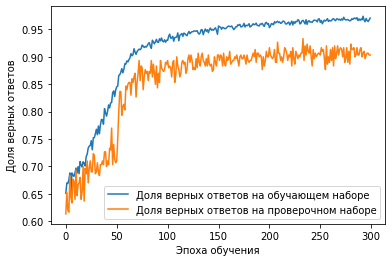

In [13]:
#Оображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [16]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    x_col = 'img_path',
    color_mode = 'rgb',
    target_size=(img_width, img_height), #Размер изображений
    batch_size=batch_size, #Размер batch_size
    class_mode=None, #Категориальный тип выборки. Разбиение выборки по маркам авто 
    shuffle=False, #Перемешивание выборки
)

Found 6000 validated image filenames.


In [17]:
test_generator.reset()

In [18]:
pred_classes=model.predict_generator(test_generator,
verbose=1)

/home/prop/anaconda3/envs/tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


240/240 [==============================] - 88s 367ms/step


In [19]:
pred_classes

array([[9.8237956e-01, 1.6192570e-02, 1.4279266e-03],
       [9.1457242e-01, 8.5409433e-02, 1.8211498e-05],
       [9.7996831e-01, 1.6052667e-02, 3.9790794e-03],
       ...,
       [2.7982674e-07, 9.2963573e-06, 9.9999046e-01],
       [6.2727947e-09, 9.9996293e-01, 3.7080681e-05],
       [1.4859249e-02, 2.4974399e-06, 9.8513830e-01]], dtype=float32)

# Three classes

Разобъем тестовый набор на поднаборы по предсказанным типам изображений.

Каждому поднабору применим свои настройки

In [6]:
test['class_1'] = pred_classes[:,0]
test

img_path       class_1
0        test_data/1.png  9.823796e-01
1        test_data/2.png  9.145724e-01
2        test_data/3.png  9.799683e-01
3        test_data/4.png  3.285581e-12
4        test_data/5.png  3.736210e-09
...                  ...           ...
5995  test_data/5996.png  0.000000e+00
5996  test_data/5997.png  0.000000e+00
5997  test_data/5998.png  2.798267e-07
5998  test_data/5999.png  6.272795e-09
5999  test_data/6000.png  1.485925e-02

[6000 rows x 2 columns]

In [7]:
test['class_2'] = pred_classes[:,1]
test

img_path       class_1   class_2
0        test_data/1.png  9.823796e-01  0.016193
1        test_data/2.png  9.145724e-01  0.085409
2        test_data/3.png  9.799683e-01  0.016053
3        test_data/4.png  3.285581e-12  0.000006
4        test_data/5.png  3.736210e-09  0.999706
...                  ...           ...       ...
5995  test_data/5996.png  0.000000e+00  0.000000
5996  test_data/5997.png  0.000000e+00  0.000000
5997  test_data/5998.png  2.798267e-07  0.000009
5998  test_data/5999.png  6.272795e-09  0.999963
5999  test_data/6000.png  1.485925e-02  0.000002

[6000 rows x 3 columns]

In [8]:
test['class_3'] = pred_classes[:,2]
test

img_path       class_1   class_2   class_3
0        test_data/1.png  9.823796e-01  0.016193  0.001428
1        test_data/2.png  9.145724e-01  0.085409  0.000018
2        test_data/3.png  9.799683e-01  0.016053  0.003979
3        test_data/4.png  3.285581e-12  0.000006  0.999993
4        test_data/5.png  3.736210e-09  0.999706  0.000294
...                  ...           ...       ...       ...
5995  test_data/5996.png  0.000000e+00  0.000000  1.000000
5996  test_data/5997.png  0.000000e+00  0.000000  1.000000
5997  test_data/5998.png  2.798267e-07  0.000009  0.999990
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037
5999  test_data/6000.png  1.485925e-02  0.000002  0.985138

[6000 rows x 4 columns]

<AxesSubplot:>

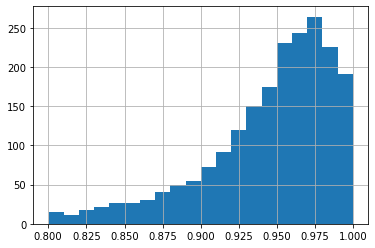

In [34]:
test.class_1[test.class_1>0.8].hist(bins=20)

## Type 1

In [10]:
test

img_path       class_1   class_2   class_3
0        test_data/1.png  9.823796e-01  0.016193  0.001428
1        test_data/2.png  9.145724e-01  0.085409  0.000018
2        test_data/3.png  9.799683e-01  0.016053  0.003979
3        test_data/4.png  3.285581e-12  0.000006  0.999993
4        test_data/5.png  3.736210e-09  0.999706  0.000294
...                  ...           ...       ...       ...
5995  test_data/5996.png  0.000000e+00  0.000000  1.000000
5996  test_data/5997.png  0.000000e+00  0.000000  1.000000
5997  test_data/5998.png  2.798267e-07  0.000009  0.999990
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037
5999  test_data/6000.png  1.485925e-02  0.000002  0.985138

[6000 rows x 4 columns]

In [13]:
test['class_full'] = np.argmax(pred_classes, axis=1)

In [14]:
test

img_path       class_1   class_2   class_3  class_full
0        test_data/1.png  9.823796e-01  0.016193  0.001428           0
1        test_data/2.png  9.145724e-01  0.085409  0.000018           0
2        test_data/3.png  9.799683e-01  0.016053  0.003979           0
3        test_data/4.png  3.285581e-12  0.000006  0.999993           2
4        test_data/5.png  3.736210e-09  0.999706  0.000294           1
...                  ...           ...       ...       ...         ...
5995  test_data/5996.png  0.000000e+00  0.000000  1.000000           2
5996  test_data/5997.png  0.000000e+00  0.000000  1.000000           2
5997  test_data/5998.png  2.798267e-07  0.000009  0.999990           2
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037           1
5999  test_data/6000.png  1.485925e-02  0.000002  0.985138           2

[6000 rows x 5 columns]

In [15]:
test_1 = test[test.class_full==0]
test_1

img_path   class_1   class_2       class_3  class_full
0        test_data/1.png  0.982380  0.016193  1.427927e-03           0
1        test_data/2.png  0.914572  0.085409  1.821150e-05           0
2        test_data/3.png  0.979968  0.016053  3.979079e-03           0
5        test_data/6.png  0.886614  0.108727  4.659219e-03           0
8        test_data/9.png  0.983413  0.013655  2.932713e-03           0
...                  ...       ...       ...           ...         ...
5981  test_data/5982.png  0.982809  0.016984  2.062971e-04           0
5985  test_data/5986.png  0.975919  0.024080  7.001373e-07           0
5988  test_data/5989.png  0.990947  0.002783  6.269257e-03           0
5990  test_data/5991.png  0.959962  0.035575  4.462739e-03           0
5993  test_data/5994.png  0.905152  0.045857  4.899049e-02           0

[2160 rows x 5 columns]

In [24]:
# bord 10, bordsq 3 2,(2,2)
bord = 10
bord_square = 3
its = 2
its_size = (2,2)
big_bord = 3
test_1['pred'] = test_1.img_path.apply(count_sq, args=(bord,))

test_data/1.png
test_data/2.png
test_data/3.png
test_data/6.png
test_data/9.png
test_data/11.png
test_data/12.png
test_data/15.png
test_data/17.png
test_data/18.png
test_data/21.png
test_data/27.png
test_data/30.png
test_data/32.png
test_data/37.png
test_data/38.png
test_data/42.png
test_data/46.png
test_data/47.png
test_data/50.png
test_data/52.png
test_data/54.png
test_data/58.png
test_data/59.png
test_data/67.png
test_data/68.png
test_data/73.png
test_data/77.png
test_data/78.png
test_data/79.png
test_data/84.png
test_data/89.png
test_data/90.png
test_data/91.png
test_data/93.png
test_data/94.png
test_data/99.png
test_data/101.png
test_data/103.png
test_data/104.png
test_data/107.png
test_data/112.png
test_data/116.png
test_data/117.png
test_data/118.png
test_data/120.png
test_data/122.png
test_data/130.png
test_data/133.png
test_data/134.png
test_data/135.png
test_data/136.png
test_data/137.png
test_data/139.png
test_data/140.png
test_data/141.png
test_data/144.png
test_data/150.pn

/tmp/ipykernel_4750/4279561627.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_1['pred'] = test_1.img_path.apply(count_sq, args=(bord,))


## Type 2

In [25]:
test_2 = test[test.class_full==1]
test_2

img_path       class_1   class_2   class_3  class_full
4        test_data/5.png  3.736210e-09  0.999706  0.000294           1
7        test_data/8.png  8.567202e-06  0.999727  0.000264           1
12      test_data/13.png  4.090859e-09  0.999988  0.000012           1
13      test_data/14.png  9.510909e-09  0.999984  0.000016           1
15      test_data/16.png  7.267500e-09  0.998886  0.001114           1
...                  ...           ...       ...       ...         ...
5984  test_data/5985.png  3.165281e-10  0.999326  0.000674           1
5986  test_data/5987.png  3.312181e-05  0.893725  0.106242           1
5989  test_data/5990.png  8.266927e-09  0.999892  0.000108           1
5994  test_data/5995.png  4.733783e-09  0.999994  0.000006           1
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037           1

[1834 rows x 5 columns]

In [26]:
# bord 3, bordsq = 2, 2,(1,1)

bord = 3
bord_square = 2
its = 2
its_size = (1,1)
big_bord = 3
test_2['pred'] = test_2.img_path.apply(count_sq, args=(bord,))

test_data/5.png
test_data/8.png
test_data/13.png
test_data/14.png
test_data/16.png
test_data/20.png
test_data/24.png
test_data/29.png
test_data/33.png
test_data/40.png
test_data/43.png
test_data/44.png
test_data/45.png
test_data/48.png
test_data/49.png
test_data/57.png
test_data/61.png
test_data/64.png
test_data/65.png
test_data/70.png
test_data/74.png
test_data/80.png
test_data/82.png
test_data/83.png
test_data/86.png
test_data/87.png
test_data/88.png
test_data/95.png
test_data/98.png
test_data/102.png
test_data/105.png
test_data/109.png
test_data/114.png
test_data/127.png
test_data/129.png
test_data/131.png
test_data/132.png
test_data/138.png
test_data/146.png
test_data/148.png
test_data/149.png
test_data/154.png
test_data/156.png
test_data/158.png
test_data/161.png
test_data/163.png
test_data/171.png
test_data/176.png
test_data/179.png
test_data/180.png
test_data/183.png
test_data/186.png
test_data/187.png
test_data/190.png
test_data/196.png
test_data/201.png
test_data/203.png
test_

/tmp/ipykernel_4750/4027359803.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_2['pred'] = test_2.img_path.apply(count_sq, args=(bord,))


In [27]:
test_2

img_path       class_1   class_2   class_3  class_full  pred
4        test_data/5.png  3.736210e-09  0.999706  0.000294           1     9
7        test_data/8.png  8.567202e-06  0.999727  0.000264           1    18
12      test_data/13.png  4.090859e-09  0.999988  0.000012           1     6
13      test_data/14.png  9.510909e-09  0.999984  0.000016           1    14
15      test_data/16.png  7.267500e-09  0.998886  0.001114           1     4
...                  ...           ...       ...       ...         ...   ...
5984  test_data/5985.png  3.165281e-10  0.999326  0.000674           1     8
5986  test_data/5987.png  3.312181e-05  0.893725  0.106242           1     2
5989  test_data/5990.png  8.266927e-09  0.999892  0.000108           1     4
5994  test_data/5995.png  4.733783e-09  0.999994  0.000006           1    14
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037           1     8

[1834 rows x 6 columns]

## Type 3

In [28]:
test_3 = test[test.class_full==2]
test_3

img_path       class_1       class_2   class_3  class_full
3        test_data/4.png  3.285581e-12  6.499486e-06  0.999993           2
6        test_data/7.png  0.000000e+00  0.000000e+00  1.000000           2
9       test_data/10.png  7.945125e-07  1.548239e-01  0.845175           2
18      test_data/19.png  7.575534e-06  1.717444e-04  0.999821           2
21      test_data/22.png  5.459316e-36  0.000000e+00  1.000000           2
...                  ...           ...           ...       ...         ...
5992  test_data/5993.png  2.983662e-29  3.966050e-35  1.000000           2
5995  test_data/5996.png  0.000000e+00  0.000000e+00  1.000000           2
5996  test_data/5997.png  0.000000e+00  0.000000e+00  1.000000           2
5997  test_data/5998.png  2.798267e-07  9.296357e-06  0.999990           2
5999  test_data/6000.png  1.485925e-02  2.497440e-06  0.985138           2

[2006 rows x 5 columns]

In [29]:
# bord 10, bordsq = 2, 2,(2,2)

bord = 10
bord_square = 2
its = 2
its_size = (2,2)
big_bord = 3
test_3['pred'] = test_3.img_path.apply(count_sq, args=(bord,))

test_data/4.png
test_data/7.png
test_data/10.png
test_data/19.png
test_data/22.png
test_data/23.png
test_data/25.png
test_data/26.png
test_data/28.png
test_data/31.png
test_data/34.png
test_data/35.png
test_data/36.png
test_data/39.png
test_data/41.png
test_data/51.png
test_data/53.png
test_data/55.png
test_data/56.png
test_data/60.png
test_data/62.png
test_data/63.png
test_data/66.png
test_data/69.png
test_data/71.png
test_data/72.png
test_data/75.png
test_data/76.png
test_data/81.png
test_data/85.png
test_data/92.png
test_data/96.png
test_data/97.png
test_data/100.png
test_data/106.png
test_data/108.png
test_data/110.png
test_data/111.png
test_data/113.png
test_data/115.png
test_data/119.png
test_data/121.png
test_data/123.png
test_data/124.png
test_data/125.png
test_data/126.png
test_data/128.png
test_data/142.png
test_data/143.png
test_data/145.png
test_data/147.png
test_data/152.png
test_data/153.png
test_data/162.png
test_data/167.png
test_data/170.png
test_data/172.png
test_data

/tmp/ipykernel_4750/1650530457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_3['pred'] = test_3.img_path.apply(count_sq, args=(bord,))


In [79]:
test

img_path
0        test_data/1.png
1        test_data/2.png
2        test_data/3.png
3        test_data/4.png
4        test_data/5.png
...                  ...
5995  test_data/5996.png
5996  test_data/5997.png
5997  test_data/5998.png
5998  test_data/5999.png
5999  test_data/6000.png

[6000 rows x 1 columns]

## Union all subsets

In [30]:
test = test.merge(test_1[['img_path','pred']], on='img_path', how='left')

In [31]:
test = test.merge(test_2[['img_path','pred']], on='img_path', how='left')

In [32]:
test = test.merge(test_3[['img_path','pred']], on='img_path', how='left')

In [83]:
test

img_path  pred_x  pred_y  pred
0        test_data/1.png     7.0     NaN   NaN
1        test_data/2.png    16.0     NaN   NaN
2        test_data/3.png     2.0     NaN   NaN
3        test_data/4.png     NaN     NaN   6.0
4        test_data/5.png     NaN     9.0   NaN
...                  ...     ...     ...   ...
5995  test_data/5996.png     NaN     NaN  15.0
5996  test_data/5997.png     NaN     NaN  14.0
5997  test_data/5998.png     NaN     NaN  16.0
5998  test_data/5999.png     NaN     8.0   NaN
5999  test_data/6000.png     NaN     NaN   2.0

[6000 rows x 4 columns]

In [ ]:
test[test.pred.isna() & test.pred_x.isna() & test.pred_y.isna() & test.pred_last.isna()]

Empty DataFrame
Columns: [img_path, pred_x, pred_y, pred, pred_last]
Index: []

In [33]:
test.fillna(0, inplace=True)
test

img_path       class_1   class_2   class_3  class_full  \
0        test_data/1.png  9.823796e-01  0.016193  0.001428           0   
1        test_data/2.png  9.145724e-01  0.085409  0.000018           0   
2        test_data/3.png  9.799683e-01  0.016053  0.003979           0   
3        test_data/4.png  3.285581e-12  0.000006  0.999993           2   
4        test_data/5.png  3.736210e-09  0.999706  0.000294           1   
...                  ...           ...       ...       ...         ...   
5995  test_data/5996.png  0.000000e+00  0.000000  1.000000           2   
5996  test_data/5997.png  0.000000e+00  0.000000  1.000000           2   
5997  test_data/5998.png  2.798267e-07  0.000009  0.999990           2   
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037           1   
5999  test_data/6000.png  1.485925e-02  0.000002  0.985138           2   

      pred_x  pred_y  pred  
0        7.0     0.0   0.0  
1       16.0     0.0   0.0  
2        2.0     0.0   0.0  
3        0.0     0.0   6.0  
4        0.0     9.0   0.0  
...      ...     ...   ...  
5995     0.0     0.0  15.0  
5996     0.0     0.0  14.0  
5997     0.0     0.0  16.0  
5998     0.0     8.0   0.0  
5999     0.0     0.0   2.0  

[6000 rows x 8 columns]

In [34]:
test['pred_full'] = test.pred+test.pred_x + test.pred_y
test

img_path       class_1   class_2   class_3  class_full  \
0        test_data/1.png  9.823796e-01  0.016193  0.001428           0   
1        test_data/2.png  9.145724e-01  0.085409  0.000018           0   
2        test_data/3.png  9.799683e-01  0.016053  0.003979           0   
3        test_data/4.png  3.285581e-12  0.000006  0.999993           2   
4        test_data/5.png  3.736210e-09  0.999706  0.000294           1   
...                  ...           ...       ...       ...         ...   
5995  test_data/5996.png  0.000000e+00  0.000000  1.000000           2   
5996  test_data/5997.png  0.000000e+00  0.000000  1.000000           2   
5997  test_data/5998.png  2.798267e-07  0.000009  0.999990           2   
5998  test_data/5999.png  6.272795e-09  0.999963  0.000037           1   
5999  test_data/6000.png  1.485925e-02  0.000002  0.985138           2   

      pred_x  pred_y  pred  pred_full  
0        7.0     0.0   0.0        7.0  
1       16.0     0.0   0.0       16.0  
2        2.0     0.0   0.0        2.0  
3        0.0     0.0   6.0        6.0  
4        0.0     9.0   0.0        9.0  
...      ...     ...   ...        ...  
5995     0.0     0.0  15.0       15.0  
5996     0.0     0.0  14.0       14.0  
5997     0.0     0.0  16.0       16.0  
5998     0.0     8.0   0.0        8.0  
5999     0.0     0.0   2.0        2.0  

[6000 rows x 9 columns]

In [35]:
test_itog = test[['img_path', 'pred_full']]
test_itog.rename(columns={'pred_full': 'pred'}, inplace=True)
test_itog

/tmp/ipykernel_4750/655365359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_itog.rename(columns={'pred_full': 'pred'}, inplace=True)


img_path  pred
0        test_data/1.png   7.0
1        test_data/2.png  16.0
2        test_data/3.png   2.0
3        test_data/4.png   6.0
4        test_data/5.png   9.0
...                  ...   ...
5995  test_data/5996.png  15.0
5996  test_data/5997.png  14.0
5997  test_data/5998.png  16.0
5998  test_data/5999.png   8.0
5999  test_data/6000.png   2.0

[6000 rows x 2 columns]

In [36]:
pred_to_csv(test_itog)

/tmp/ipykernel_4750/3991628192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred.rename(columns={'pred': 'label'}, inplace=True)


Итого после применения разных настроек к разным предсказанным типам изображений удалось снизить ошибку rmse с 0.4963197893831489 до 0.42504901678120216

# Conclusion

Итого была достигнута примелимая точность на тестовом наборе. При этом она не зависит от того, как данные были поделены на тестовый и обучающий наборы. Напомню, что скорее всего тестовый набор специально содержит большшее количество квадратов на каждом изображении по сравнению с обучающим, что сбивает модели M. Данный подход не зависит от ML и дает достатточно точное предсказание

Итоговая ошибка rmse:
Public  0.42504901678120216
Private  0.4127145906474998